<a href="https://colab.research.google.com/github/reagan13/gpt2-distilbert-thesis-files/blob/main/Hybrid_Model_Parallel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pip install libraries

Python library used for evaluating sequence labeling tasks, such as Named Entity Recognition (NER) and part-of-speech tagging.

In [ ]:
!pip install seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=1c65e16d0f0df3c19f19027ee500e24385c0aacb5e4e6a464d685ca2d38241d1
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


# Upload Dataset(Optional if using Google Colab)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving final_dataset.json to final_dataset.json


# Convert Ner Labels List into String

In [ ]:
import json

# Load the JSON file
with open('final_dataset.json', 'r') as file:
    data = json.load(file)

# If your dataset is a list of dictionaries
if isinstance(data, list):
    for entry in data:
        if 'ner_labels_only' in entry and isinstance(entry['ner_labels_only'], list):
            # Convert the list to a string
            entry['ner_labels_only'] = json.dumps(entry['ner_labels_only'])
            # Print the modified entry
            print("Modified entry:")
            print(json.dumps(entry, indent=4))

# If your dataset is a single dictionary
elif isinstance(data, dict):
    if 'ner_labels_only' in data and isinstance(data['ner_labels_only'], list):
        data['ner_labels_only'] = json.dumps(data['ner_labels_only'])
        # Print the modified data
        print("Modified entry:")
        print(json.dumps(data, indent=4))

# Save the modified data back to the file
with open('final_dataset_temp.json', 'w') as file:
    json.dump(data, file, indent=4)

print("\nConversion complete. Check final_dataset.json for the updated data.")

Streaming output truncated to the last 5000 lines.
    "has_placeholder": false,
    "ner_labels_only": "[]"
}
Modified entry:
{
    "instruction": "show me my restitution status",
    "category": "refund",
    "intent": "track_refund",
    "response": "sure! i completely understand your need to check the status of your restitution. rest assured, i'm here to assist you with that. let me quickly gather the required information to give you an update on your restitution status. please bear with me for a moment while i retrieve the most recent details. your patience is highly appreciated.",
    "has_placeholder": false,
    "ner_labels_only": "[]"
}
Modified entry:
{
    "instruction": "where could i see if there is anything new on my refund?",
    "category": "refund",
    "intent": "track_refund",
    "response": "definitely! i understand that you're looking to stay updated on any new developments regarding your refund. to check for the latest information, please navigate to your '{{acco

# MOUNT DRIVE (Optional if You use colab)

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
SAVE_PATH = "/content/drive/MyDrive/gpt2_hybrid_fusion_parallel_droupout_2"
os.makedirs(SAVE_PATH, exist_ok=True)

Mounted at /content/drive


# Import Libraries

This code imports necessary libraries for working with PyTorch, data visualization, evaluation metrics, and JSON handling. It defines a function load_dataset that loads and returns a dataset from a specified JSON file. The function reads the JSON file, parses its content, and outputs it as a list of dictionaries.

In [ ]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2TokenizerFast, DistilBertTokenizerFast, GPT2Model, DistilBertModel, AdamW, get_linear_schedule_with_warmup
from typing import Dict, List, Optional, Tuple
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from seqeval.metrics import precision_score as seq_precision, recall_score as seq_recall, f1_score as seq_f1
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import time
from google.colab import drive
from tabulate import tabulate

# Functions

## Load Dataset

In [ ]:

# Load dataset
def load_dataset(json_file: str) -> list:
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data


## Saved Dataset split

In [ ]:
# Save dataset splits
def save_dataset_split(data: List[Dict], split_name: str, save_path: str):
    file_path = os.path.join(save_path, f"{split_name}.json")
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print(f"Saved {split_name} split to {file_path}")

## Load Datasplit

In [ ]:
# Load or split dataset
def get_dataset_splits(json_file: str, save_path: str, train_ratio=0.8, val_ratio=0.1):
    train_file = os.path.join(save_path, "train.json")
    val_file = os.path.join(save_path, "val.json")
    test_file = os.path.join(save_path, "test.json")

    if os.path.exists(train_file) and os.path.exists(val_file) and os.path.exists(test_file):
        print("Loading pre-split datasets...")
        train_data = load_dataset(train_file)
        val_data = load_dataset(val_file)
        test_data = load_dataset(test_file)
    else:
        print("Splitting dataset and saving...")
        data = load_dataset(json_file)
        train_data, temp_data = train_test_split(data, train_size=train_ratio, random_state=42)
        val_data, test_data = train_test_split(temp_data, train_size=val_ratio / (1 - train_ratio), random_state=42)
        save_dataset_split(train_data, "train", save_path)
        save_dataset_split(val_data, "val", save_path)
        save_dataset_split(test_data, "test", save_path)

    return train_data, val_data, test_data

## Detect and Mapping the labels

This code defines the detect_labels function, which processes a dataset to identify unique categories, intents, and named entity recognition (NER) labels. The function iterates through each sample in the dataset, extracting and adding unique values to sets for categories, intents, and NER labels. It also creates mappings (encoders) to assign an integer index to each unique category, intent, and NER label, which are then returned as a dictionary. The function prints out the encoders for categories, intents, and NER labels.

In [ ]:
# Updated detect_labels to use BIO scheme like HybridFusionParallel
def detect_labels(data: List[Dict]) -> Dict[str, Dict]:
    unique_categories = set()
    unique_intents = set()
    unique_ner_labels = set(["O"])  # "O" is the default label for tokens outside entities

    for sample in data:
        unique_categories.add(sample["category"])
        unique_intents.add(sample["intent"])
        ner_labels = sample["ner_labels_only"]  # Convert string to list of dicts
        ner_labels = json.loads(ner_labels) # Parse string to list of dictionaries
        for label in ner_labels:
            label_type = label["label"]
            unique_ner_labels.add(f"B-{label_type}")  # Add "B-" prefix for beginning of entity
            unique_ner_labels.add(f"I-{label_type}")  # Add "I-" prefix for inside of entity

    category_encoder = {cat: idx for idx, cat in enumerate(sorted(unique_categories))}
    intent_encoder = {intent: idx for idx, intent in enumerate(sorted(unique_intents))}
    ner_label_encoder = {ner: idx for idx, ner in enumerate(sorted(unique_ner_labels))}

    print("Category encoder:", category_encoder)
    print("Intent encoder:", intent_encoder)
    print("NER label encoder:", ner_label_encoder)

    return {
        "category_encoder": category_encoder,
        "intent_encoder": intent_encoder,
        "ner_label_encoder": ner_label_encoder
    }


## Tokenize Text

This code is a function that tokenizes input text using both GPT-2 and DistilBERT tokenizers. It processes the text by truncating or padding it to a maximum length, and returns tokenized outputs in the form of input_ids and attention_mask for each model. These tokenized inputs are then ready to be fed into the model for multitask learning.

In [ ]:
def tokenize_text(text: str, gpt2_tokenizer, distilbert_tokenizer, max_length: int = 128) -> Tuple[dict, dict]:
    gpt2_inputs = gpt2_tokenizer(
        text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    distilbert_inputs = distilbert_tokenizer(
        text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    return {
        "gpt2_input_ids": gpt2_inputs["input_ids"].squeeze(0),
        "gpt2_attention_mask": gpt2_inputs["attention_mask"].squeeze(0)
    }, {
        "distilbert_input_ids": distilbert_inputs["input_ids"].squeeze(0),
        "distilbert_attention_mask": distilbert_inputs["attention_mask"].squeeze(0)
    }

## Aligning Ner Labels

The align_ner_labels function aligns Named Entity Recognition (NER) labels with tokenized input from DistilBERT and GPT2. It tokenizes the text, maps each token to its character offset, and then assigns appropriate NER labels based on the positions of entities in the text. It ensures that the labels are correctly aligned with the tokens, using the BIO (Begin, Inside, Outside) scheme. The function returns a list of integers representing the aligned NER labels, which can then be used for training or evaluation.

In [ ]:
def align_ner_labels(text: str, ner_labels, tokenizer, ner_label_encoder: Dict, max_length: int = 128) -> List[int]:
    # Handle both string and list inputs
    if isinstance(ner_labels, str):
        try:
            ner_labels = json.loads(ner_labels)
        except json.JSONDecodeError:
            # Silent failure, don't print error
            ner_labels = []

    encoding = tokenizer(text, max_length=max_length, padding="max_length", truncation=True,
                         return_offsets_mapping=True, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])
    token_to_char_map = encoding["offset_mapping"][0].tolist()
    ner_aligned = [ner_label_encoder["O"]] * len(tokens)

    found_entities = 0

    for label in ner_labels:
        label_text, label_type = label["text"], label["label"]
        label_start = text.lower().find(label_text.lower())  # Case-insensitive matching
        if label_start == -1:
            # Skip without printing warning
            continue

        found_entities += 1
        label_end = label_start + len(label_text)

        # Find token indices that correspond to this entity
        entity_tokens = []
        for i, (start, end) in enumerate(token_to_char_map):
            if start == 0 and end == 0:  # Special tokens
                continue
            # A token is part of an entity if it overlaps with the entity span
            if start < label_end and end > label_start:
                entity_tokens.append(i)

        # Apply BIO tagging - first token gets B-, rest get I-
        for idx, token_idx in enumerate(entity_tokens):
            prefix = "B-" if idx == 0 else "I-"
            bio_label = f"{prefix}{label_type}"
            if bio_label in ner_label_encoder:
                ner_aligned[token_idx] = ner_label_encoder[bio_label]
            # Skip warning if label not found

    return ner_aligned[:max_length]

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Split Dataset

In [ ]:
def split_dataset(data: List[Dict], train_ratio=0.8, val_ratio=0.1):
    train_data, temp_data = train_test_split(data, train_size=train_ratio, random_state=42)
    val_data, test_data = train_test_split(temp_data, train_size=val_ratio / (1 - train_ratio), random_state=42)
    return train_data, val_data, test_data

# Class and Data Loaders

## Create Custom Dataset

The MultiTaskDataset class is a custom dataset for multitask learning, designed to handle text data for Intent Classification, Category Classification, and Named Entity Recognition (NER). It tokenizes the input text using both GPT-2 and DistilBERT tokenizers, aligns the NER labels with the tokenized text, and encodes the labels (category, intent, NER) using provided label encoders. The dataset returns tokenized inputs for both models and the associated labels as tensors for training in multitask settings.

In [ ]:
class MultiTaskDataset(Dataset):
    def __init__(self, data: List[Dict], gpt2_tokenizer, distilbert_tokenizer, label_encoders, max_length: int = 128):
        self.data = data
        self.gpt2_tokenizer = gpt2_tokenizer
        self.distilbert_tokenizer = distilbert_tokenizer
        self.label_encoders = label_encoders
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        text = sample["instruction"]
        category = self.label_encoders["category_encoder"][sample["category"]]
        intent = self.label_encoders["intent_encoder"][sample["intent"]]
        ner_labels_str = sample["ner_labels_only"]
        ner_labels = ast.literal_eval(ner_labels_str) if ner_labels_str != "[]" else []

        gpt2_inputs, distilbert_inputs = tokenize_text(text, self.gpt2_tokenizer, self.distilbert_tokenizer, self.max_length)
        ner_labels_aligned = align_ner_labels(
            text, ner_labels, self.distilbert_tokenizer, self.label_encoders["ner_label_encoder"], self.max_length
        )

        return {
            "gpt2_input_ids": gpt2_inputs["gpt2_input_ids"],
            "gpt2_attention_mask": gpt2_inputs["gpt2_attention_mask"],
            "distilbert_input_ids": distilbert_inputs["distilbert_input_ids"],
            "distilbert_attention_mask": distilbert_inputs["distilbert_attention_mask"],
            "category_labels": category,
            "intent_labels": intent,
            "ner_labels": torch.tensor(ner_labels_aligned)
        }

## DataLoaders

The get_dataloaders function creates DataLoader objects for the training, validation, and test datasets. It initializes MultiTaskDataset for each dataset and then creates corresponding DataLoader instances with specified batch sizes and the number of workers for parallel data loading. These DataLoaders are used to efficiently load data in batches during model training and evaluation.

In [ ]:
def get_dataloaders(train_data, val_data, test_data, gpt2_tokenizer, distilbert_tokenizer, label_encoders, batch_size=16, num_workers=0):
    train_dataset = MultiTaskDataset(train_data, gpt2_tokenizer, distilbert_tokenizer, label_encoders)
    val_dataset = MultiTaskDataset(val_data, gpt2_tokenizer, distilbert_tokenizer, label_encoders)
    test_dataset = MultiTaskDataset(test_data, gpt2_tokenizer, distilbert_tokenizer, label_encoders)
    return (
        DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
        DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers),
        DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    )

# Hybrid Model Architecture

This code defines a multi-task learning model for text classification, leveraging both GPT-2 and DistilBERT base models. It uses a fusion module to combine features from both models with cross-attention and a fusion gate. The model performs three tasks: intent classification, category classification, and named entity recognition (NER). It includes separate fusion and attention mechanisms for each task, followed by classification heads to generate predictions. The model also supports loss computation if labels for all tasks are provided, enabling joint training across multiple tasks. In the code, the parameters of the base models (GPT-2 and DistilBERT) are frozen to prevent their weights from being updated during training. This is done by setting requires_grad = False for all parameters of both models, ensuring that only the task-specific components, such as the FusionModule, attention layers, and classification heads, are trained.

In [ ]:
class HybridFusionParallel(nn.Module):
    def __init__(self, num_intents: int, num_categories: int, num_ner_labels: int, fusion_dim: int = 768, dropout_rate: float = 0.2):
        super().__init__()
        self.gpt2 = GPT2Model.from_pretrained('gpt2')
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        for param in self.gpt2.parameters():
            param.requires_grad = False
        for param in self.distilbert.parameters():
            param.requires_grad = False

        gpt2_dim = self.gpt2.config.n_embd  # 768
        bert_dim = self.distilbert.config.hidden_size  # 768

        # Fusion for Intent and Category (unchanged)
        self.intent_fusion = FusionModule(gpt2_dim, bert_dim, fusion_dim)
        self.category_fusion = FusionModule(gpt2_dim, bert_dim, fusion_dim)
        self.intent_attention = nn.Sequential(nn.Linear(fusion_dim, 1), nn.Softmax(dim=1))
        self.category_attention = nn.Sequential(nn.Linear(fusion_dim, 1), nn.Softmax(dim=1))

        # New NER Fusion: Lightweight Token-Wise Concatenation
        self.ner_gpt2_proj = nn.Linear(gpt2_dim, fusion_dim // 2)  # 384
        self.ner_bert_proj = nn.Linear(bert_dim, fusion_dim // 2)  # 384
        self.ner_combine = nn.Linear(fusion_dim, fusion_dim)  # 768 -> 768 with residual
        self.ner_norm = nn.LayerNorm(fusion_dim)

        # Classifiers
        classifier_layers = [
            nn.LayerNorm(fusion_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(fusion_dim, fusion_dim // 2),
            nn.GELU(),
            nn.LayerNorm(fusion_dim // 2),
            nn.Dropout(dropout_rate)
        ]
        self.intent_classifier = nn.Sequential(*classifier_layers, nn.Linear(fusion_dim // 2, num_intents))
        self.category_classifier = nn.Sequential(*classifier_layers, nn.Linear(fusion_dim // 2, num_categories))
        self.ner_classifier = nn.Sequential(
            nn.LayerNorm(fusion_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(fusion_dim, num_ner_labels)
        )

    def forward(self, gpt2_input_ids, gpt2_attention_mask, distilbert_input_ids, distilbert_attention_mask, intent_labels=None, category_labels=None, ner_labels=None):
        gpt2_outputs = self.gpt2(input_ids=gpt2_input_ids, attention_mask=gpt2_attention_mask)
        distilbert_outputs = self.distilbert(input_ids=distilbert_input_ids, attention_mask=distilbert_attention_mask)
        gpt2_features = gpt2_outputs.last_hidden_state  # [batch, seq_len, 768]
        bert_features = distilbert_outputs.last_hidden_state  # [batch, seq_len, 768]

        # Intent and Category Fusion (unchanged)
        intent_fused = self.intent_fusion(gpt2_features, bert_features, gpt2_attention_mask)
        category_fused = self.category_fusion(gpt2_features, bert_features, gpt2_attention_mask)
        intent_weights = self.intent_attention(intent_fused)
        intent_pooled = torch.sum(intent_fused * intent_weights, dim=1)
        category_weights = self.category_attention(category_fused)
        category_pooled = torch.sum(category_fused * category_weights, dim=1)
        intent_logits = self.intent_classifier(intent_pooled)
        category_logits = self.category_classifier(category_pooled)

        # NER Fusion: Token-Wise Concatenation with Residual
        gpt2_ner = self.ner_gpt2_proj(gpt2_features)  # [batch, seq_len, 384]
        bert_ner = self.ner_bert_proj(bert_features)  # [batch, seq_len, 384]
        ner_combined = torch.cat([gpt2_ner, bert_ner], dim=-1)  # [batch, seq_len, 768]
        ner_fused = self.ner_combine(ner_combined) + ner_combined  # Residual connection
        ner_fused = self.ner_norm(ner_fused)  # [batch, seq_len, 768]
        ner_logits = self.ner_classifier(ner_fused)

        loss = None
        if all(label is not None for label in [intent_labels, category_labels, ner_labels]):
            intent_loss = F.cross_entropy(intent_logits, intent_labels)
            category_loss = F.cross_entropy(category_logits, category_labels)
            active_loss = distilbert_attention_mask.view(-1) == 1
            active_logits = ner_logits.view(-1, ner_logits.size(-1))[active_loss]
            active_labels = ner_labels.view(-1)[active_loss]
            ner_loss = F.cross_entropy(active_logits, active_labels)
            # Static weighting within hyperparameter constraints
            loss = intent_loss + category_loss + 5.0 * ner_loss  # Boost NER contribution

        return {'intent_logits': intent_logits, 'category_logits': category_logits, 'ner_logits': ner_logits, 'loss': loss}

class FusionModule(nn.Module):  # Unchanged from original
    def __init__(self, gpt2_dim: int, bert_dim: int, fusion_dim: int):
        super().__init__()
        self.gpt2_proj = nn.Linear(gpt2_dim, fusion_dim)
        self.bert_proj = nn.Linear(bert_dim, fusion_dim)
        self.cross_attention = nn.MultiheadAttention(fusion_dim, num_heads=8, batch_first=True)
        self.fusion_gate = nn.Sequential(nn.Linear(fusion_dim * 2, fusion_dim), nn.Sigmoid())
        self.layer_norm = nn.LayerNorm(fusion_dim)

    def forward(self, gpt2_features: torch.Tensor, bert_features: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        gpt2_proj = self.gpt2_proj(gpt2_features)
        bert_proj = self.bert_proj(bert_features)
        attn_mask = attention_mask.float().masked_fill(attention_mask == 0, float('-inf'))
        cross_attended, _ = self.cross_attention(gpt2_proj, bert_proj, bert_proj, key_padding_mask=~attention_mask.bool())
        gate_weights = self.fusion_gate(torch.cat([gpt2_proj, cross_attended], dim=-1))
        fused = gate_weights * gpt2_proj + (1 - gate_weights) * cross_attended
        return self.layer_norm(fused)

## Training Model

The train_model_with_mixed_precision function trains a multitask model using mixed-precision training for improved performance and memory efficiency. It tracks multiple metrics, including training loss, validation loss, intent accuracy, category accuracy, and NER F1 score. The function leverages gradient accumulation for efficient updates and autocast for automatic mixed precision during forward and backward passes. It computes and reports the metrics for both training and validation phases, and filters out "O" labels in NER for accurate F1 score calculation. The model is trained for a specified number of epochs on a GPU device.

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, label_encoders, num_epochs=5, device="cuda", accumulation_steps=4):
    model.to(device)
    ner_label_decoder = {v: k for k, v in label_encoders["ner_label_encoder"].items()}
    metrics = {"train_losses": [], "val_losses": [], "train_intent_acc": [], "train_category_f1": [],
               "train_ner_f1": [], "val_intent_acc": [], "val_category_f1": [], "val_ner_f1": [],
               "epoch_times": []}

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f"\nEpoch {epoch + 1}/{num_epochs} (Device: {device})")
        print("-" * 50)

        # Training
        model.train()
        train_loss = 0.0
        train_intent_preds, train_intent_labels = [], []
        train_category_preds, train_category_labels = [], []
        train_ner_true_seqs, train_ner_pred_seqs = [], []
        optimizer.zero_grad()

        for i, batch in enumerate(tqdm(train_loader, desc="Training")):
            batch_start = time.time()
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)
            loss = outputs["loss"] / accumulation_steps
            loss.backward()
            train_loss += loss.item() * accumulation_steps  # Multiply by accumulation_steps to get actual batch loss

            # Collect intent and category predictions
            train_intent_preds.extend(outputs["intent_logits"].argmax(dim=-1).cpu().numpy())
            train_intent_labels.extend(inputs["intent_labels"].cpu().numpy())
            train_category_preds.extend(outputs["category_logits"].argmax(dim=-1).cpu().numpy())
            train_category_labels.extend(inputs["category_labels"].cpu().numpy())

            # Process NER predictions with attention mask for proper sequence handling
            # Use distilbert_attention_mask for NER processing (since you're using DistilBERT for NER)
            attention_mask = inputs["distilbert_attention_mask"]
            ner_pred_batch = outputs["ner_logits"].argmax(dim=-1)  # [batch_size, seq_length]
            ner_true_batch = inputs["ner_labels"]  # [batch_size, seq_length]

            # Convert predictions and labels to lists of BIO tags, respecting attention mask
            for j in range(ner_pred_batch.size(0)):  # Changed 'i' to 'j' to avoid variable reuse
                length = attention_mask[j].sum().item()
                # Only consider tokens within the attention mask
                pred_seq = [ner_label_decoder[p.item()] for p in ner_pred_batch[j, :length]]
                true_seq = [ner_label_decoder[l.item()] for l in ner_true_batch[j, :length]]

                train_ner_pred_seqs.append(pred_seq)
                train_ner_true_seqs.append(true_seq)

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            print(f"Batch {i + 1} Latency: {time.time() - batch_start:.4f}s", end='\r')

        # Calculate training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_intent_acc = accuracy_score(train_intent_labels, train_intent_preds)
        train_category_f1 = f1_score(train_category_labels, train_category_preds, average='weighted')

        # Calculate NER metrics - with better error handling
        try:
            train_ner_f1 = seq_f1(train_ner_true_seqs, train_ner_pred_seqs, average='macro')
            # Print some additional debug info
            entity_counts = {}
            for seq in train_ner_true_seqs:
                for tag in seq:
                    if tag.startswith('B-'):
                        entity_type = tag[2:]
                        entity_counts[entity_type] = entity_counts.get(entity_type, 0) + 1
            print(f"Entity counts in training data: {entity_counts}")
        except Exception as e:
            print(f"Error calculating NER F1: {str(e)}")
            print(f"Sample true: {train_ner_true_seqs[:2]}")
            print(f"Sample pred: {train_ner_pred_seqs[:2]}")
            train_ner_f1 = 0.0

        # Validation (similar changes as in training)
        model.eval()
        val_loss = 0.0
        val_intent_preds, val_intent_labels = [], []
        val_category_preds, val_category_labels = [], []
        val_ner_true_seqs, val_ner_pred_seqs = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                inputs = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**inputs)
                val_loss += outputs["loss"].item()

                # Intent and Category
                val_intent_preds.extend(outputs["intent_logits"].argmax(dim=-1).cpu().numpy())
                val_intent_labels.extend(inputs["intent_labels"].cpu().numpy())
                val_category_preds.extend(outputs["category_logits"].argmax(dim=-1).cpu().numpy())
                val_category_labels.extend(inputs["category_labels"].cpu().numpy())

                # Process NER with attention mask
                attention_mask = inputs["distilbert_attention_mask"]  # Use distilbert_attention_mask
                ner_pred_batch = outputs["ner_logits"].argmax(dim=-1)
                ner_true_batch = inputs["ner_labels"]

                # Convert predictions and labels to lists of BIO tags, respecting attention mask
                for j in range(ner_pred_batch.size(0)):
                    length = attention_mask[j].sum().item()
                    # Only consider tokens within the attention mask
                    pred_seq = [ner_label_decoder[p.item()] for p in ner_pred_batch[j, :length]]
                    true_seq = [ner_label_decoder[l.item()] for l in ner_true_batch[j, :length]]

                    val_ner_pred_seqs.append(pred_seq)
                    val_ner_true_seqs.append(true_seq)

        # Calculate validation metrics
        avg_val_loss = val_loss / len(val_loader)
        val_intent_acc = accuracy_score(val_intent_labels, val_intent_preds)
        val_category_f1 = f1_score(val_category_labels, val_category_preds, average='weighted')

        # Calculate NER metrics with error handling for validation
        try:
            val_ner_f1 = seq_f1(val_ner_true_seqs, val_ner_pred_seqs, average='macro')
            # Print some additional debug info for validation
            entity_counts = {}
            for seq in val_ner_true_seqs:
                for tag in seq:
                    if tag.startswith('B-'):
                        entity_type = tag[2:]
                        entity_counts[entity_type] = entity_counts.get(entity_type, 0) + 1
            print(f"Entity counts in validation data: {entity_counts}")
        except Exception as e:
            print(f"Error calculating validation NER F1: {str(e)}")
            print(f"Sample val true: {val_ner_true_seqs[:2]}")
            print(f"Sample val pred: {val_ner_pred_seqs[:2]}")
            val_ner_f1 = 0.0

        # Save metrics
        epoch_time = time.time() - start_time
        metrics["train_losses"].append(avg_train_loss)
        metrics["val_losses"].append(avg_val_loss)
        metrics["train_intent_acc"].append(train_intent_acc)
        metrics["train_category_f1"].append(train_category_f1)
        metrics["train_ner_f1"].append(train_ner_f1)
        metrics["val_intent_acc"].append(val_intent_acc)
        metrics["val_category_f1"].append(val_category_f1)
        metrics["val_ner_f1"].append(val_ner_f1)
        metrics["epoch_times"].append(epoch_time)

        # Overfitting/Underfitting Analysis
        fit_status = "Good"
        if epoch > 0:
            if avg_train_loss < metrics["train_losses"][-2] and avg_val_loss > metrics["val_losses"][-2]:
                fit_status = "Overfitting"
            elif avg_train_loss > 0.5 and avg_val_loss > 0.5:  # Arbitrary threshold, adjust as needed
                fit_status = "Underfitting"

        print(f"Training Loss: {avg_train_loss:.4f} | Intent Acc: {train_intent_acc:.4f} | Category F1: {train_category_f1:.4f} | NER F1: {train_ner_f1:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f} | Intent Acc: {val_intent_acc:.4f} | Category F1: {val_category_f1:.4f} | NER F1: {val_ner_f1:.4f}")
        print(f"Epoch Time: {epoch_time:.2f}s | Fit Status: {fit_status}")

    return metrics

## Creating Optimizer and Scheduler

The setup_optimizer_and_scheduler function sets up the AdamW optimizer and a learning rate scheduler for training a hybrid multi-task model. It takes the model, training DataLoader, learning rate, number of epochs, and warmup steps as inputs. The optimizer is initialized with the model's parameters, and the scheduler is configured to adjust the learning rate over the course of training, with a warmup phase if specified. The function returns both the optimizer and the scheduler for training.

In [ ]:
def setup_optimizer_and_scheduler(model, train_loader, lr=2e-5, num_epochs=5, warmup_steps=0):
    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    return optimizer, scheduler

## Save Training Model History and results

This function saves the training metrics and evaluation results, including confusion matrices for intent and category, into a JSON file. It filters out unnecessary data (like predictions and labels) and stores the relevant information in a structured format. The file is saved to the specified save_path with the name "training_history.json".

In [ ]:
def save_training_artifacts(model, gpt2_tokenizer, distilbert_tokenizer, label_encoders, metrics, test_results, save_path):
    torch.save(model.state_dict(), os.path.join(save_path, "model.pth"))
    gpt2_tokenizer.save_pretrained(os.path.join(save_path, "gpt2_tokenizer"))
    distilbert_tokenizer.save_pretrained(os.path.join(save_path, "distilbert_tokenizer"))
    with open(os.path.join(save_path, "label_encoders.json"), "w", encoding="utf-8") as f:
        json.dump(label_encoders, f, ensure_ascii=False, indent=4)
    with open(os.path.join(save_path, "training_metrics.json"), "w", encoding="utf-8") as f:
        json.dump(metrics, f, ensure_ascii=False, indent=4)
    with open(os.path.join(save_path, "test_results.json"), "w", encoding="utf-8") as f:
        json.dump(test_results, f, ensure_ascii=False, indent=4)
    print(f"Artifacts saved to {save_path}")

# Initialize

## Define Hyperparameters

In [ ]:
lr = 2e-5 #learning rate
batch_size = 16
num_epochs = 5
warmup_steps = 0
num_workers = 0
accumulation_steps = 4
device = "cuda" if torch.cuda.is_available() else "cpu"
# dropout_rate: float = 0.2
#datasplit ratio = 80% traing data, 10% val data, 10% test data

## Tokenizer Set Up

In [ ]:
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

## Data Splitting and Detect Labels Set Up

In [ ]:
# train_data, val_data, test_data = get_dataset_splits("final_dataset_temp.json", SAVE_PATH)
# Load the three separate JSON datasets
with open("train.json", "r") as f:
    train_data = json.load(f)

with open("val.json", "r") as f:
    val_data = json.load(f)

with open("test.json", "r") as f:
    test_data = json.load(f)

label_encoders = detect_labels(train_data + val_data + test_data)


## Data Loader and Model Set Up

In [ ]:
model = HybridFusionParallel(
    num_intents=len(label_encoders["intent_encoder"]),
    num_categories=len(label_encoders["category_encoder"]),
    num_ner_labels=len(label_encoders["ner_label_encoder"])
)
if gpt2_tokenizer.pad_token_id is not None:
    model.gpt2.resize_token_embeddings(len(gpt2_tokenizer))

train_loader, val_loader, test_loader = get_dataloaders(
    train_data, val_data, test_data,
    gpt2_tokenizer, distilbert_tokenizer, label_encoders,
    batch_size=batch_size, num_workers=num_workers
)

# Training

The code snippet executes the training and loads the dataset and tokenizes it using GPT-2 and DistilBERT, and splits the data into training, validation, and test sets. A hybrid multi-task model is created and trained using mixed precision. The model is then evaluated for intent classification, category classification, and named entity recognition (NER). The results are printed and saved to Google Drive, including the model's state, tokenizers, label encoders, metrics plots, and training history.

In [ ]:
# Training
sample = train_data[0]
text = sample["instruction"]
ner_labels = json.loads(sample["ner_labels_only"])

print("Hybrid (DistilBERT):", distilbert_tokenizer.tokenize(text))
print("Hybrid NER:", align_ner_labels(text, sample["ner_labels_only"], distilbert_tokenizer, label_encoders["ner_label_encoder"]))

optimizer, scheduler = setup_optimizer_and_scheduler(model, train_loader, lr=lr, num_epochs=num_epochs)

metrics = train_model(model, train_loader, val_loader, optimizer, scheduler, label_encoders, num_epochs=num_epochs, device=device, accumulation_steps=accumulation_steps)


Loading pre-split datasets...
Category encoder: {'account': 0, 'cancel': 1, 'contact': 2, 'delivery': 3, 'feedback': 4, 'invoice': 5, 'order': 6, 'payment': 7, 'refund': 8, 'shipping': 9, 'subscription': 10}
Intent encoder: {'cancel_order': 0, 'change_order': 1, 'change_shipping_address': 2, 'check_cancellation_fee': 3, 'check_invoice': 4, 'check_payment_methods': 5, 'check_refund_policy': 6, 'complaint': 7, 'contact_customer_service': 8, 'contact_human_agent': 9, 'create_account': 10, 'delete_account': 11, 'delivery_options': 12, 'delivery_period': 13, 'edit_account': 14, 'get_invoice': 15, 'get_refund': 16, 'newsletter_subscription': 17, 'payment_issue': 18, 'place_order': 19, 'recover_password': 20, 'registration_problems': 21, 'review': 22, 'set_up_shipping_address': 23, 'switch_account': 24, 'track_order': 25, 'track_refund': 26}
NER label encoder: {'B-account_category': 0, 'B-account_type': 1, 'B-currency_symbol': 2, 'B-delivery_city': 3, 'B-delivery_country': 4, 'B-invoice_numbe

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/5 (Device: cuda)
--------------------------------------------------


Training:   0%|          | 1/1344 [00:01<35:26,  1.58s/it]

Training:   0%|          | 2/1344 [00:01<17:40,  1.27it/s]

Training:   0%|          | 3/1344 [00:02<11:46,  1.90it/s]

Training:   0%|          | 4/1344 [00:02<09:23,  2.38it/s]

Training:   0%|          | 5/1344 [00:02<07:43,  2.89it/s]

Training:   0%|          | 6/1344 [00:02<06:43,  3.32it/s]

Training:   1%|          | 7/1344 [00:02<06:04,  3.67it/s]

Training:   1%|          | 8/1344 [00:03<05:41,  3.92it/s]

Training:   1%|          | 9/1344 [00:03<05:23,  4.12it/s]

Training:   1%|          | 10/1344 [00:03<05:11,  4.28it/s]

Training:   1%|          | 11/1344 [00:03<05:04,  4.38it/s]

Training:   1%|          | 12/1344 [00:04<05:01,  4.42it/s]

Training:   1%|          | 13/1344 [00:04<04:57,  4.47it/s]

Training:   1%|          | 14/1344 [00:04<04:53,  4.53it/s]

Training:   1%|          | 15/1344 [00:04<04:53,  4.53it/s]

Training:   1%|          | 16/1344 [00:04<04:51,  4.55it/s]

Training:   1%|▏         | 17/1344 [00:05<04:49,  4.59it/s]

Training:   1%|▏         | 18/1344 [00:05<04:47,  4.61it/s]

Training:   1%|▏         | 19/1344 [00:05<04:47,  4.61it/s]

Training:   1%|▏         | 20/1344 [00:05<04:47,  4.60it/s]

Training:   2%|▏         | 21/1344 [00:05<04:48,  4.59it/s]

Training:   2%|▏         | 22/1344 [00:06<04:48,  4.59it/s]

Training:   2%|▏         | 23/1344 [00:06<04:48,  4.58it/s]

Training:   2%|▏         | 24/1344 [00:06<04:48,  4.57it/s]

Training:   2%|▏         | 25/1344 [00:06<04:46,  4.60it/s]

Training:   2%|▏         | 26/1344 [00:07<04:45,  4.61it/s]

Training:   2%|▏         | 27/1344 [00:07<04:45,  4.62it/s]

Training:   2%|▏         | 28/1344 [00:07<04:46,  4.60it/s]

Training:   2%|▏         | 29/1344 [00:07<04:45,  4.60it/s]

Training:   2%|▏         | 30/1344 [00:07<04:46,  4.59it/s]

Training:   2%|▏         | 31/1344 [00:08<04:45,  4.59it/s]

Training:   2%|▏         | 32/1344 [00:08<04:45,  4.60it/s]

Training:   2%|▏         | 33/1344 [00:08<04:45,  4.59it/s]

Training:   3%|▎         | 34/1344 [00:08<04:47,  4.56it/s]

Training:   3%|▎         | 35/1344 [00:09<04:47,  4.55it/s]

Training:   3%|▎         | 36/1344 [00:09<04:47,  4.55it/s]

Training:   3%|▎         | 37/1344 [00:09<04:46,  4.57it/s]

Training:   3%|▎         | 38/1344 [00:09<04:46,  4.55it/s]

Training:   3%|▎         | 39/1344 [00:09<04:44,  4.58it/s]

Training:   3%|▎         | 40/1344 [00:10<04:45,  4.57it/s]

Training:   3%|▎         | 41/1344 [00:10<04:44,  4.58it/s]

Training:   3%|▎         | 42/1344 [00:10<04:43,  4.59it/s]

Training:   3%|▎         | 43/1344 [00:10<04:42,  4.60it/s]

Training:   3%|▎         | 44/1344 [00:11<05:16,  4.11it/s]

Training:   3%|▎         | 45/1344 [00:11<05:23,  4.01it/s]

Training:   3%|▎         | 46/1344 [00:11<05:11,  4.17it/s]

Training:   3%|▎         | 47/1344 [00:11<05:02,  4.29it/s]

Training:   4%|▎         | 48/1344 [00:12<05:33,  3.89it/s]

Training:   4%|▎         | 49/1344 [00:12<06:11,  3.48it/s]

Training:   4%|▎         | 50/1344 [00:12<06:27,  3.34it/s]

Training:   4%|▍         | 51/1344 [00:12<05:59,  3.60it/s]

Training:   4%|▍         | 52/1344 [00:13<06:13,  3.46it/s]

Training:   4%|▍         | 53/1344 [00:13<06:40,  3.23it/s]

Training:   4%|▍         | 54/1344 [00:14<06:51,  3.13it/s]

Training:   4%|▍         | 55/1344 [00:14<06:17,  3.42it/s]

Training:   4%|▍         | 56/1344 [00:14<05:57,  3.60it/s]

Training:   4%|▍         | 57/1344 [00:14<05:41,  3.77it/s]

Training:   4%|▍         | 58/1344 [00:14<05:30,  3.89it/s]

Training:   4%|▍         | 59/1344 [00:15<05:21,  4.00it/s]

Training:   4%|▍         | 60/1344 [00:15<05:16,  4.06it/s]

Training:   5%|▍         | 61/1344 [00:15<05:04,  4.22it/s]

Training:   5%|▍         | 62/1344 [00:15<04:59,  4.28it/s]

Training:   5%|▍         | 63/1344 [00:16<04:54,  4.35it/s]

Training:   5%|▍         | 64/1344 [00:16<04:52,  4.38it/s]

Training:   5%|▍         | 65/1344 [00:16<04:47,  4.45it/s]

Training:   5%|▍         | 66/1344 [00:16<04:44,  4.50it/s]

Training:   5%|▍         | 67/1344 [00:16<04:42,  4.52it/s]

Training:   5%|▌         | 68/1344 [00:17<04:42,  4.52it/s]

Training:   5%|▌         | 69/1344 [00:17<04:39,  4.56it/s]

Training:   5%|▌         | 70/1344 [00:17<04:39,  4.56it/s]

Training:   5%|▌         | 71/1344 [00:17<04:38,  4.58it/s]

Training:   5%|▌         | 72/1344 [00:18<04:41,  4.52it/s]

Training:   5%|▌         | 73/1344 [00:18<04:38,  4.56it/s]

Training:   6%|▌         | 74/1344 [00:18<04:37,  4.58it/s]

Training:   6%|▌         | 75/1344 [00:18<04:36,  4.58it/s]

Training:   6%|▌         | 76/1344 [00:18<04:40,  4.52it/s]

Training:   6%|▌         | 77/1344 [00:19<04:39,  4.53it/s]

Training:   6%|▌         | 78/1344 [00:19<04:37,  4.56it/s]

Training:   6%|▌         | 79/1344 [00:19<04:37,  4.56it/s]

Training:   6%|▌         | 80/1344 [00:19<04:38,  4.54it/s]

Training:   6%|▌         | 81/1344 [00:20<04:37,  4.56it/s]

Training:   6%|▌         | 82/1344 [00:20<04:36,  4.56it/s]

Training:   6%|▌         | 83/1344 [00:20<04:35,  4.58it/s]

Training:   6%|▋         | 84/1344 [00:20<04:38,  4.53it/s]

Training:   6%|▋         | 85/1344 [00:20<04:39,  4.51it/s]

Training:   6%|▋         | 86/1344 [00:21<04:37,  4.53it/s]

Training:   6%|▋         | 87/1344 [00:21<04:37,  4.53it/s]

Training:   7%|▋         | 88/1344 [00:21<04:41,  4.46it/s]

Training:   7%|▋         | 89/1344 [00:21<04:38,  4.51it/s]

Training:   7%|▋         | 90/1344 [00:22<04:36,  4.53it/s]

Training:   7%|▋         | 91/1344 [00:22<04:35,  4.54it/s]

Training:   7%|▋         | 92/1344 [00:22<04:37,  4.52it/s]

Training:   7%|▋         | 93/1344 [00:22<04:34,  4.55it/s]

Training:   7%|▋         | 94/1344 [00:22<04:34,  4.56it/s]

Training:   7%|▋         | 95/1344 [00:23<04:34,  4.55it/s]

Training:   7%|▋         | 96/1344 [00:23<04:35,  4.53it/s]

Training:   7%|▋         | 97/1344 [00:23<04:33,  4.56it/s]

Training:   7%|▋         | 98/1344 [00:23<04:33,  4.55it/s]

Training:   7%|▋         | 99/1344 [00:24<04:36,  4.51it/s]

Training:   7%|▋         | 100/1344 [00:24<04:35,  4.51it/s]

Training:   8%|▊         | 101/1344 [00:24<04:34,  4.53it/s]

Training:   8%|▊         | 102/1344 [00:24<04:33,  4.54it/s]

Training:   8%|▊         | 103/1344 [00:24<04:32,  4.56it/s]

Training:   8%|▊         | 104/1344 [00:25<04:34,  4.52it/s]

Training:   8%|▊         | 105/1344 [00:25<04:34,  4.51it/s]

Training:   8%|▊         | 106/1344 [00:25<04:40,  4.41it/s]

Training:   8%|▊         | 107/1344 [00:25<04:41,  4.39it/s]

Training:   8%|▊         | 108/1344 [00:26<04:47,  4.30it/s]

Training:   8%|▊         | 109/1344 [00:26<04:48,  4.27it/s]

Training:   8%|▊         | 110/1344 [00:26<04:48,  4.27it/s]

Training:   8%|▊         | 111/1344 [00:26<04:49,  4.25it/s]

Training:   8%|▊         | 112/1344 [00:27<04:52,  4.21it/s]

Training:   8%|▊         | 113/1344 [00:27<04:50,  4.23it/s]

Training:   8%|▊         | 114/1344 [00:27<04:49,  4.25it/s]

Training:   9%|▊         | 115/1344 [00:27<04:50,  4.23it/s]

Training:   9%|▊         | 116/1344 [00:27<04:50,  4.22it/s]

Training:   9%|▊         | 117/1344 [00:28<04:50,  4.22it/s]

Training:   9%|▉         | 118/1344 [00:28<04:48,  4.25it/s]

Training:   9%|▉         | 119/1344 [00:28<04:42,  4.33it/s]

Training:   9%|▉         | 120/1344 [00:28<04:41,  4.35it/s]

Training:   9%|▉         | 121/1344 [00:29<04:38,  4.39it/s]

Training:   9%|▉         | 122/1344 [00:29<04:36,  4.42it/s]

Training:   9%|▉         | 123/1344 [00:29<04:33,  4.46it/s]

Training:   9%|▉         | 124/1344 [00:29<04:38,  4.38it/s]

Training:   9%|▉         | 125/1344 [00:29<04:34,  4.45it/s]

Training:   9%|▉         | 126/1344 [00:30<04:32,  4.47it/s]

Training:   9%|▉         | 127/1344 [00:30<04:30,  4.49it/s]

Training:  10%|▉         | 128/1344 [00:30<04:31,  4.47it/s]

Training:  10%|▉         | 129/1344 [00:30<04:30,  4.50it/s]

Training:  10%|▉         | 130/1344 [00:31<04:28,  4.52it/s]

Training:  10%|▉         | 131/1344 [00:31<04:27,  4.54it/s]

Training:  10%|▉         | 132/1344 [00:31<04:28,  4.51it/s]

Training:  10%|▉         | 133/1344 [00:31<04:29,  4.50it/s]

Training:  10%|▉         | 134/1344 [00:31<04:27,  4.52it/s]

Training:  10%|█         | 135/1344 [00:32<04:27,  4.53it/s]

Training:  10%|█         | 136/1344 [00:32<04:27,  4.51it/s]

Training:  10%|█         | 137/1344 [00:32<04:26,  4.53it/s]

Training:  10%|█         | 138/1344 [00:32<04:25,  4.54it/s]

Training:  10%|█         | 139/1344 [00:33<04:25,  4.54it/s]

Training:  10%|█         | 140/1344 [00:33<04:26,  4.52it/s]

Training:  10%|█         | 141/1344 [00:33<04:25,  4.53it/s]

Training:  11%|█         | 142/1344 [00:33<04:24,  4.54it/s]

Training:  11%|█         | 143/1344 [00:33<04:24,  4.54it/s]

Training:  11%|█         | 144/1344 [00:34<04:27,  4.49it/s]

Training:  11%|█         | 145/1344 [00:34<04:25,  4.52it/s]

Training:  11%|█         | 146/1344 [00:34<04:29,  4.45it/s]

Training:  11%|█         | 147/1344 [00:34<04:27,  4.48it/s]

Training:  11%|█         | 148/1344 [00:35<04:27,  4.47it/s]

Training:  11%|█         | 149/1344 [00:35<04:26,  4.48it/s]

Training:  11%|█         | 150/1344 [00:35<04:25,  4.49it/s]

Training:  11%|█         | 151/1344 [00:35<04:24,  4.51it/s]

Training:  11%|█▏        | 152/1344 [00:35<04:25,  4.49it/s]

Training:  11%|█▏        | 153/1344 [00:36<04:23,  4.51it/s]

Training:  11%|█▏        | 154/1344 [00:36<04:23,  4.51it/s]

Training:  12%|█▏        | 155/1344 [00:36<04:23,  4.52it/s]

Training:  12%|█▏        | 156/1344 [00:36<04:24,  4.50it/s]

Training:  12%|█▏        | 157/1344 [00:37<04:24,  4.49it/s]

Training:  12%|█▏        | 158/1344 [00:37<04:23,  4.50it/s]

Training:  12%|█▏        | 159/1344 [00:37<04:24,  4.49it/s]

Training:  12%|█▏        | 160/1344 [00:37<04:24,  4.48it/s]

Training:  12%|█▏        | 161/1344 [00:37<04:22,  4.50it/s]

Training:  12%|█▏        | 162/1344 [00:38<04:22,  4.50it/s]

Training:  12%|█▏        | 163/1344 [00:38<04:23,  4.49it/s]

Training:  12%|█▏        | 164/1344 [00:38<04:30,  4.37it/s]

Training:  12%|█▏        | 165/1344 [00:38<04:31,  4.35it/s]

Training:  12%|█▏        | 166/1344 [00:39<04:32,  4.32it/s]

Training:  12%|█▏        | 167/1344 [00:39<04:33,  4.31it/s]

Training:  12%|█▎        | 168/1344 [00:39<04:38,  4.23it/s]

Training:  13%|█▎        | 169/1344 [00:39<04:37,  4.23it/s]

Training:  13%|█▎        | 170/1344 [00:40<04:37,  4.24it/s]

Training:  13%|█▎        | 171/1344 [00:40<04:35,  4.26it/s]

Training:  13%|█▎        | 172/1344 [00:40<04:36,  4.24it/s]

Training:  13%|█▎        | 173/1344 [00:40<04:37,  4.22it/s]

Training:  13%|█▎        | 174/1344 [00:41<04:38,  4.20it/s]

Training:  13%|█▎        | 175/1344 [00:41<04:38,  4.20it/s]

Training:  13%|█▎        | 176/1344 [00:41<04:40,  4.17it/s]

Training:  13%|█▎        | 177/1344 [00:41<04:33,  4.27it/s]

Training:  13%|█▎        | 178/1344 [00:41<04:29,  4.33it/s]

Training:  13%|█▎        | 179/1344 [00:42<04:26,  4.37it/s]

Training:  13%|█▎        | 180/1344 [00:42<04:25,  4.39it/s]

Training:  13%|█▎        | 181/1344 [00:42<04:25,  4.39it/s]

Training:  14%|█▎        | 182/1344 [00:42<04:22,  4.42it/s]

Training:  14%|█▎        | 183/1344 [00:43<04:22,  4.42it/s]

Training:  14%|█▎        | 184/1344 [00:43<04:22,  4.43it/s]

Training:  14%|█▍        | 185/1344 [00:43<04:19,  4.46it/s]

Training:  14%|█▍        | 186/1344 [00:43<04:18,  4.47it/s]

Training:  14%|█▍        | 187/1344 [00:43<04:22,  4.42it/s]

Training:  14%|█▍        | 188/1344 [00:44<04:22,  4.40it/s]

Training:  14%|█▍        | 189/1344 [00:44<04:20,  4.43it/s]

Training:  14%|█▍        | 190/1344 [00:44<04:19,  4.45it/s]

Training:  14%|█▍        | 191/1344 [00:44<04:18,  4.46it/s]

Training:  14%|█▍        | 192/1344 [00:45<04:18,  4.45it/s]

Training:  14%|█▍        | 193/1344 [00:45<04:17,  4.48it/s]

Training:  14%|█▍        | 194/1344 [00:45<04:16,  4.48it/s]

Training:  15%|█▍        | 195/1344 [00:45<04:18,  4.45it/s]

Training:  15%|█▍        | 196/1344 [00:46<04:19,  4.42it/s]

Training:  15%|█▍        | 197/1344 [00:46<04:18,  4.44it/s]

Training:  15%|█▍        | 198/1344 [00:46<04:17,  4.45it/s]

Training:  15%|█▍        | 199/1344 [00:46<04:17,  4.44it/s]

Training:  15%|█▍        | 200/1344 [00:46<04:18,  4.42it/s]

Training:  15%|█▍        | 201/1344 [00:47<04:17,  4.43it/s]

Training:  15%|█▌        | 202/1344 [00:47<04:16,  4.45it/s]

Training:  15%|█▌        | 203/1344 [00:47<04:16,  4.46it/s]

Training:  15%|█▌        | 204/1344 [00:47<04:18,  4.41it/s]

Training:  15%|█▌        | 205/1344 [00:48<04:17,  4.42it/s]

Training:  15%|█▌        | 206/1344 [00:48<04:16,  4.44it/s]

Training:  15%|█▌        | 207/1344 [00:48<04:16,  4.43it/s]

Training:  15%|█▌        | 208/1344 [00:48<04:17,  4.41it/s]

Training:  16%|█▌        | 209/1344 [00:48<04:18,  4.40it/s]

Training:  16%|█▌        | 210/1344 [00:49<04:18,  4.39it/s]

Training:  16%|█▌        | 211/1344 [00:49<04:16,  4.42it/s]

Training:  16%|█▌        | 212/1344 [00:49<04:16,  4.41it/s]

Training:  16%|█▌        | 213/1344 [00:49<04:15,  4.43it/s]

Training:  16%|█▌        | 214/1344 [00:50<04:14,  4.43it/s]

Training:  16%|█▌        | 215/1344 [00:50<04:14,  4.43it/s]

Training:  16%|█▌        | 216/1344 [00:50<04:15,  4.41it/s]

Training:  16%|█▌        | 217/1344 [00:50<04:13,  4.44it/s]

Training:  16%|█▌        | 218/1344 [00:50<04:13,  4.44it/s]

Training:  16%|█▋        | 219/1344 [00:51<04:12,  4.45it/s]

Training:  16%|█▋        | 220/1344 [00:51<04:14,  4.42it/s]

Training:  16%|█▋        | 221/1344 [00:51<04:17,  4.35it/s]

Training:  17%|█▋        | 222/1344 [00:51<04:22,  4.28it/s]

Training:  17%|█▋        | 223/1344 [00:52<04:23,  4.26it/s]

Training:  17%|█▋        | 224/1344 [00:52<04:26,  4.20it/s]

Training:  17%|█▋        | 225/1344 [00:52<04:25,  4.21it/s]

Training:  17%|█▋        | 226/1344 [00:52<04:25,  4.21it/s]

Training:  17%|█▋        | 227/1344 [00:53<04:25,  4.21it/s]

Training:  17%|█▋        | 228/1344 [00:53<04:27,  4.17it/s]

Training:  17%|█▋        | 229/1344 [00:53<04:28,  4.15it/s]

Training:  17%|█▋        | 230/1344 [00:53<04:30,  4.12it/s]

Training:  17%|█▋        | 231/1344 [00:54<04:30,  4.12it/s]

Training:  17%|█▋        | 232/1344 [00:54<04:32,  4.07it/s]

Training:  17%|█▋        | 233/1344 [00:54<04:31,  4.09it/s]

Training:  17%|█▋        | 234/1344 [00:54<04:25,  4.18it/s]

Training:  17%|█▋        | 235/1344 [00:55<04:22,  4.23it/s]

Training:  18%|█▊        | 236/1344 [00:55<04:19,  4.27it/s]

Training:  18%|█▊        | 237/1344 [00:55<04:16,  4.31it/s]

Training:  18%|█▊        | 238/1344 [00:55<04:15,  4.33it/s]

Training:  18%|█▊        | 239/1344 [00:55<04:13,  4.36it/s]

Training:  18%|█▊        | 240/1344 [00:56<04:14,  4.34it/s]

Training:  18%|█▊        | 241/1344 [00:56<04:12,  4.36it/s]

Training:  18%|█▊        | 242/1344 [00:56<04:11,  4.38it/s]

Training:  18%|█▊        | 243/1344 [00:56<04:12,  4.36it/s]

Training:  18%|█▊        | 244/1344 [00:57<04:12,  4.35it/s]

Training:  18%|█▊        | 245/1344 [00:57<04:11,  4.37it/s]

Training:  18%|█▊        | 246/1344 [00:57<04:11,  4.37it/s]

Training:  18%|█▊        | 247/1344 [00:57<04:10,  4.38it/s]

Training:  18%|█▊        | 248/1344 [00:58<04:10,  4.37it/s]

Training:  19%|█▊        | 249/1344 [00:58<04:09,  4.38it/s]

Training:  19%|█▊        | 250/1344 [00:58<04:09,  4.39it/s]

Training:  19%|█▊        | 251/1344 [00:58<04:08,  4.40it/s]

Training:  19%|█▉        | 252/1344 [00:58<04:09,  4.37it/s]

Training:  19%|█▉        | 253/1344 [00:59<04:08,  4.38it/s]

Training:  19%|█▉        | 254/1344 [00:59<04:08,  4.39it/s]

Training:  19%|█▉        | 255/1344 [00:59<04:09,  4.37it/s]

Training:  19%|█▉        | 256/1344 [00:59<04:11,  4.32it/s]

Training:  19%|█▉        | 257/1344 [01:00<04:13,  4.29it/s]

Training:  19%|█▉        | 258/1344 [01:00<04:11,  4.32it/s]

Training:  19%|█▉        | 259/1344 [01:00<04:09,  4.34it/s]

Training:  19%|█▉        | 260/1344 [01:00<04:09,  4.34it/s]

Training:  19%|█▉        | 261/1344 [01:00<04:08,  4.36it/s]

Training:  19%|█▉        | 262/1344 [01:01<04:06,  4.38it/s]

Training:  20%|█▉        | 263/1344 [01:01<04:06,  4.39it/s]

Training:  20%|█▉        | 264/1344 [01:01<04:07,  4.37it/s]

Training:  20%|█▉        | 265/1344 [01:01<04:06,  4.38it/s]

Training:  20%|█▉        | 266/1344 [01:02<04:04,  4.40it/s]

Training:  20%|█▉        | 267/1344 [01:02<04:05,  4.39it/s]

Training:  20%|█▉        | 268/1344 [01:02<04:05,  4.37it/s]

Training:  20%|██        | 269/1344 [01:02<04:05,  4.38it/s]

Training:  20%|██        | 270/1344 [01:03<04:05,  4.37it/s]

Training:  20%|██        | 271/1344 [01:03<04:04,  4.39it/s]

Training:  20%|██        | 272/1344 [01:03<04:07,  4.33it/s]

Training:  20%|██        | 273/1344 [01:03<04:05,  4.35it/s]

Training:  20%|██        | 274/1344 [01:03<04:04,  4.38it/s]

Training:  20%|██        | 275/1344 [01:04<04:04,  4.38it/s]

Training:  21%|██        | 276/1344 [01:04<04:05,  4.35it/s]

Training:  21%|██        | 277/1344 [01:04<04:05,  4.34it/s]

Training:  21%|██        | 278/1344 [01:04<04:09,  4.28it/s]

Training:  21%|██        | 279/1344 [01:05<04:10,  4.24it/s]

Training:  21%|██        | 280/1344 [01:05<04:15,  4.16it/s]

Training:  21%|██        | 281/1344 [01:05<04:19,  4.10it/s]

Training:  21%|██        | 282/1344 [01:05<04:19,  4.09it/s]

Training:  21%|██        | 283/1344 [01:06<04:19,  4.09it/s]

Training:  21%|██        | 284/1344 [01:06<04:20,  4.07it/s]

Training:  21%|██        | 285/1344 [01:06<04:17,  4.11it/s]

Training:  21%|██▏       | 286/1344 [01:06<04:18,  4.10it/s]

Training:  21%|██▏       | 287/1344 [01:07<04:19,  4.08it/s]

Training:  21%|██▏       | 288/1344 [01:07<04:21,  4.05it/s]

Training:  22%|██▏       | 289/1344 [01:07<04:20,  4.05it/s]

Training:  22%|██▏       | 290/1344 [01:07<04:18,  4.07it/s]

Training:  22%|██▏       | 291/1344 [01:08<04:17,  4.09it/s]

Training:  22%|██▏       | 292/1344 [01:08<04:13,  4.14it/s]

Training:  22%|██▏       | 293/1344 [01:08<04:10,  4.19it/s]

Training:  22%|██▏       | 294/1344 [01:08<04:07,  4.24it/s]

Training:  22%|██▏       | 295/1344 [01:09<04:07,  4.23it/s]

Training:  22%|██▏       | 296/1344 [01:09<04:07,  4.24it/s]

Training:  22%|██▏       | 297/1344 [01:09<04:04,  4.28it/s]

Training:  22%|██▏       | 298/1344 [01:09<04:05,  4.25it/s]

Training:  22%|██▏       | 299/1344 [01:09<04:03,  4.28it/s]

Training:  22%|██▏       | 300/1344 [01:10<04:03,  4.29it/s]

Training:  22%|██▏       | 301/1344 [01:10<04:02,  4.30it/s]

Training:  22%|██▏       | 302/1344 [01:10<04:01,  4.31it/s]

Training:  23%|██▎       | 303/1344 [01:10<04:01,  4.32it/s]

Training:  23%|██▎       | 304/1344 [01:11<04:01,  4.31it/s]

Training:  23%|██▎       | 305/1344 [01:11<04:00,  4.32it/s]

Training:  23%|██▎       | 306/1344 [01:11<03:59,  4.34it/s]

Training:  23%|██▎       | 307/1344 [01:11<04:01,  4.29it/s]

Training:  23%|██▎       | 308/1344 [01:12<04:01,  4.28it/s]

Training:  23%|██▎       | 309/1344 [01:12<03:59,  4.32it/s]

Training:  23%|██▎       | 310/1344 [01:12<04:00,  4.30it/s]

Training:  23%|██▎       | 311/1344 [01:12<03:59,  4.32it/s]

Training:  23%|██▎       | 312/1344 [01:12<03:59,  4.31it/s]

Training:  23%|██▎       | 313/1344 [01:13<03:57,  4.33it/s]

Training:  23%|██▎       | 314/1344 [01:13<03:57,  4.33it/s]

Training:  23%|██▎       | 315/1344 [01:13<03:57,  4.33it/s]

Training:  24%|██▎       | 316/1344 [01:13<03:58,  4.31it/s]

Training:  24%|██▎       | 317/1344 [01:14<03:58,  4.30it/s]

Training:  24%|██▎       | 318/1344 [01:14<03:57,  4.32it/s]

Training:  24%|██▎       | 319/1344 [01:14<03:56,  4.33it/s]

Training:  24%|██▍       | 320/1344 [01:14<03:58,  4.30it/s]

Training:  24%|██▍       | 321/1344 [01:15<03:58,  4.28it/s]

Training:  24%|██▍       | 322/1344 [01:15<03:57,  4.30it/s]

Training:  24%|██▍       | 323/1344 [01:15<03:57,  4.30it/s]

Training:  24%|██▍       | 324/1344 [01:15<03:58,  4.28it/s]

Training:  24%|██▍       | 325/1344 [01:15<03:56,  4.30it/s]

Training:  24%|██▍       | 326/1344 [01:16<03:55,  4.32it/s]

Training:  24%|██▍       | 327/1344 [01:16<03:55,  4.31it/s]

Training:  24%|██▍       | 328/1344 [01:16<03:57,  4.27it/s]

Training:  24%|██▍       | 329/1344 [01:16<03:59,  4.24it/s]

Training:  25%|██▍       | 330/1344 [01:17<03:57,  4.27it/s]

Training:  25%|██▍       | 331/1344 [01:17<03:57,  4.27it/s]

Training:  25%|██▍       | 332/1344 [01:17<03:59,  4.22it/s]

Training:  25%|██▍       | 333/1344 [01:17<04:00,  4.21it/s]

Training:  25%|██▍       | 334/1344 [01:18<04:03,  4.14it/s]

Training:  25%|██▍       | 335/1344 [01:18<04:06,  4.10it/s]

Training:  25%|██▌       | 336/1344 [01:18<04:06,  4.08it/s]

Training:  25%|██▌       | 337/1344 [01:18<04:08,  4.05it/s]

Training:  25%|██▌       | 338/1344 [01:19<04:08,  4.05it/s]

Training:  25%|██▌       | 339/1344 [01:19<04:08,  4.05it/s]

Training:  25%|██▌       | 340/1344 [01:19<04:10,  4.01it/s]

Training:  25%|██▌       | 341/1344 [01:19<04:11,  3.99it/s]

Training:  25%|██▌       | 342/1344 [01:20<04:11,  3.98it/s]

Training:  26%|██▌       | 343/1344 [01:20<04:10,  3.99it/s]

Training:  26%|██▌       | 344/1344 [01:20<04:12,  3.96it/s]

Training:  26%|██▌       | 345/1344 [01:20<04:09,  4.00it/s]

Training:  26%|██▌       | 346/1344 [01:21<04:09,  4.00it/s]

Training:  26%|██▌       | 347/1344 [01:21<04:05,  4.06it/s]

Training:  26%|██▌       | 348/1344 [01:21<04:02,  4.11it/s]

Training:  26%|██▌       | 349/1344 [01:21<04:02,  4.11it/s]

Training:  26%|██▌       | 350/1344 [01:22<04:00,  4.13it/s]

Training:  26%|██▌       | 351/1344 [01:22<03:57,  4.17it/s]

Training:  26%|██▌       | 352/1344 [01:22<03:57,  4.18it/s]

Training:  26%|██▋       | 353/1344 [01:22<03:54,  4.22it/s]

Training:  26%|██▋       | 354/1344 [01:23<03:55,  4.21it/s]

Training:  26%|██▋       | 355/1344 [01:23<03:53,  4.24it/s]

Training:  26%|██▋       | 356/1344 [01:23<03:52,  4.25it/s]

Training:  27%|██▋       | 357/1344 [01:23<03:51,  4.26it/s]

Training:  27%|██▋       | 358/1344 [01:23<03:50,  4.27it/s]

Training:  27%|██▋       | 359/1344 [01:24<03:51,  4.26it/s]

Training:  27%|██▋       | 360/1344 [01:24<03:51,  4.24it/s]

Training:  27%|██▋       | 361/1344 [01:24<03:51,  4.25it/s]

Training:  27%|██▋       | 362/1344 [01:24<03:50,  4.26it/s]

Training:  27%|██▋       | 363/1344 [01:25<03:49,  4.28it/s]

Training:  27%|██▋       | 364/1344 [01:25<03:49,  4.27it/s]

Training:  27%|██▋       | 365/1344 [01:25<03:48,  4.29it/s]

Training:  27%|██▋       | 366/1344 [01:25<03:46,  4.32it/s]

Training:  27%|██▋       | 367/1344 [01:26<03:47,  4.30it/s]

Training:  27%|██▋       | 368/1344 [01:26<03:51,  4.21it/s]

Training:  27%|██▋       | 369/1344 [01:26<03:50,  4.22it/s]

Training:  28%|██▊       | 370/1344 [01:26<03:48,  4.26it/s]

Training:  28%|██▊       | 371/1344 [01:27<03:49,  4.25it/s]

Training:  28%|██▊       | 372/1344 [01:27<03:50,  4.21it/s]

Training:  28%|██▊       | 373/1344 [01:27<03:49,  4.23it/s]

Training:  28%|██▊       | 374/1344 [01:27<03:50,  4.21it/s]

Training:  28%|██▊       | 375/1344 [01:27<03:49,  4.21it/s]

Training:  28%|██▊       | 376/1344 [01:28<03:50,  4.20it/s]

Training:  28%|██▊       | 377/1344 [01:28<03:49,  4.21it/s]

Training:  28%|██▊       | 378/1344 [01:28<03:49,  4.22it/s]

Training:  28%|██▊       | 379/1344 [01:28<03:48,  4.22it/s]

Training:  28%|██▊       | 380/1344 [01:29<03:51,  4.16it/s]

Training:  28%|██▊       | 381/1344 [01:29<03:49,  4.19it/s]

Training:  28%|██▊       | 382/1344 [01:29<03:48,  4.21it/s]

Training:  28%|██▊       | 383/1344 [01:29<03:47,  4.22it/s]

Training:  29%|██▊       | 384/1344 [01:30<03:48,  4.20it/s]

Training:  29%|██▊       | 385/1344 [01:30<03:50,  4.17it/s]

Training:  29%|██▊       | 386/1344 [01:30<03:48,  4.20it/s]

Training:  29%|██▉       | 387/1344 [01:30<03:47,  4.21it/s]

Training:  29%|██▉       | 388/1344 [01:31<03:50,  4.15it/s]

Training:  29%|██▉       | 389/1344 [01:31<03:53,  4.09it/s]

Training:  29%|██▉       | 390/1344 [01:31<03:53,  4.08it/s]

Training:  29%|██▉       | 391/1344 [01:31<03:53,  4.08it/s]

Training:  29%|██▉       | 392/1344 [01:32<03:56,  4.03it/s]

Training:  29%|██▉       | 393/1344 [01:32<03:57,  4.00it/s]

Training:  29%|██▉       | 394/1344 [01:32<03:57,  4.00it/s]

Training:  29%|██▉       | 395/1344 [01:32<03:57,  4.00it/s]

Training:  29%|██▉       | 396/1344 [01:33<03:57,  3.99it/s]

Training:  30%|██▉       | 397/1344 [01:33<03:58,  3.97it/s]

Training:  30%|██▉       | 398/1344 [01:33<03:59,  3.96it/s]

Training:  30%|██▉       | 399/1344 [01:33<03:59,  3.94it/s]

Training:  30%|██▉       | 400/1344 [01:34<04:00,  3.93it/s]

Training:  30%|██▉       | 401/1344 [01:34<03:55,  4.00it/s]

Training:  30%|██▉       | 402/1344 [01:34<03:52,  4.05it/s]

Training:  30%|██▉       | 403/1344 [01:34<03:51,  4.06it/s]

Training:  30%|███       | 404/1344 [01:35<03:51,  4.06it/s]

Training:  30%|███       | 405/1344 [01:35<03:47,  4.12it/s]

Training:  30%|███       | 406/1344 [01:35<03:46,  4.14it/s]

Training:  30%|███       | 407/1344 [01:35<03:46,  4.13it/s]

Training:  30%|███       | 408/1344 [01:36<03:47,  4.12it/s]

Training:  30%|███       | 409/1344 [01:36<03:44,  4.17it/s]

Training:  31%|███       | 410/1344 [01:36<03:42,  4.20it/s]

Training:  31%|███       | 411/1344 [01:36<03:42,  4.20it/s]

Training:  31%|███       | 412/1344 [01:36<03:42,  4.20it/s]

Training:  31%|███       | 413/1344 [01:37<03:42,  4.19it/s]

Training:  31%|███       | 414/1344 [01:37<03:42,  4.19it/s]

Training:  31%|███       | 415/1344 [01:37<03:41,  4.19it/s]

Training:  31%|███       | 416/1344 [01:37<03:42,  4.17it/s]

Training:  31%|███       | 417/1344 [01:38<03:42,  4.17it/s]

Training:  31%|███       | 418/1344 [01:38<03:42,  4.16it/s]

Training:  31%|███       | 419/1344 [01:38<03:41,  4.18it/s]

Training:  31%|███▏      | 420/1344 [01:38<03:41,  4.16it/s]

Training:  31%|███▏      | 421/1344 [01:39<03:40,  4.18it/s]

Training:  31%|███▏      | 422/1344 [01:39<03:38,  4.21it/s]

Training:  31%|███▏      | 423/1344 [01:39<03:38,  4.22it/s]

Training:  32%|███▏      | 424/1344 [01:39<03:38,  4.20it/s]

Training:  32%|███▏      | 425/1344 [01:40<03:38,  4.21it/s]

Training:  32%|███▏      | 426/1344 [01:40<03:37,  4.22it/s]

Training:  32%|███▏      | 427/1344 [01:40<03:37,  4.21it/s]

Training:  32%|███▏      | 428/1344 [01:40<03:39,  4.18it/s]

Training:  32%|███▏      | 429/1344 [01:41<03:38,  4.18it/s]

Training:  32%|███▏      | 430/1344 [01:41<03:37,  4.19it/s]

Training:  32%|███▏      | 431/1344 [01:41<03:37,  4.19it/s]

Training:  32%|███▏      | 432/1344 [01:41<03:38,  4.18it/s]

Training:  32%|███▏      | 433/1344 [01:41<03:37,  4.19it/s]

Training:  32%|███▏      | 434/1344 [01:42<03:36,  4.21it/s]

Training:  32%|███▏      | 435/1344 [01:42<03:35,  4.22it/s]

Training:  32%|███▏      | 436/1344 [01:42<03:37,  4.18it/s]

Training:  33%|███▎      | 437/1344 [01:42<03:35,  4.21it/s]

Training:  33%|███▎      | 438/1344 [01:43<03:34,  4.23it/s]

Training:  33%|███▎      | 439/1344 [01:43<03:33,  4.24it/s]

Training:  33%|███▎      | 440/1344 [01:43<03:35,  4.19it/s]

Training:  33%|███▎      | 441/1344 [01:43<03:33,  4.22it/s]

Training:  33%|███▎      | 442/1344 [01:44<03:34,  4.20it/s]

Training:  33%|███▎      | 443/1344 [01:44<03:38,  4.13it/s]

Training:  33%|███▎      | 444/1344 [01:44<03:41,  4.07it/s]

Training:  33%|███▎      | 445/1344 [01:44<03:41,  4.06it/s]

Training:  33%|███▎      | 446/1344 [01:45<03:42,  4.03it/s]

Training:  33%|███▎      | 447/1344 [01:45<03:42,  4.04it/s]

Training:  33%|███▎      | 448/1344 [01:45<03:42,  4.03it/s]

Training:  33%|███▎      | 449/1344 [01:45<03:40,  4.06it/s]

Training:  33%|███▎      | 450/1344 [01:46<03:40,  4.05it/s]

Training:  34%|███▎      | 451/1344 [01:46<03:40,  4.06it/s]

Training:  34%|███▎      | 452/1344 [01:46<03:42,  4.02it/s]

Training:  34%|███▎      | 453/1344 [01:46<03:42,  4.00it/s]

Training:  34%|███▍      | 454/1344 [01:47<03:42,  4.00it/s]

Training:  34%|███▍      | 455/1344 [01:47<03:40,  4.03it/s]

Training:  34%|███▍      | 456/1344 [01:47<03:38,  4.07it/s]

Training:  34%|███▍      | 457/1344 [01:47<03:35,  4.11it/s]

Training:  34%|███▍      | 458/1344 [01:48<03:35,  4.12it/s]

Training:  34%|███▍      | 459/1344 [01:48<03:33,  4.15it/s]

Training:  34%|███▍      | 460/1344 [01:48<03:34,  4.12it/s]

Training:  34%|███▍      | 461/1344 [01:48<03:32,  4.15it/s]

Training:  34%|███▍      | 462/1344 [01:49<03:31,  4.18it/s]

Training:  34%|███▍      | 463/1344 [01:49<03:30,  4.19it/s]

Training:  35%|███▍      | 464/1344 [01:49<03:30,  4.19it/s]

Training:  35%|███▍      | 465/1344 [01:49<03:29,  4.20it/s]

Training:  35%|███▍      | 466/1344 [01:49<03:28,  4.22it/s]

Training:  35%|███▍      | 467/1344 [01:50<03:27,  4.23it/s]

Training:  35%|███▍      | 468/1344 [01:50<03:27,  4.21it/s]

Training:  35%|███▍      | 469/1344 [01:50<03:26,  4.24it/s]

Training:  35%|███▍      | 470/1344 [01:50<03:26,  4.24it/s]

Training:  35%|███▌      | 471/1344 [01:51<03:27,  4.21it/s]

Training:  35%|███▌      | 472/1344 [01:51<03:27,  4.20it/s]

Training:  35%|███▌      | 473/1344 [01:51<03:27,  4.20it/s]

Training:  35%|███▌      | 474/1344 [01:51<03:25,  4.22it/s]

Training:  35%|███▌      | 475/1344 [01:52<03:24,  4.26it/s]

Training:  35%|███▌      | 476/1344 [01:52<03:25,  4.22it/s]

Training:  35%|███▌      | 477/1344 [01:52<03:24,  4.24it/s]

Training:  36%|███▌      | 478/1344 [01:52<03:23,  4.25it/s]

Training:  36%|███▌      | 479/1344 [01:53<03:24,  4.24it/s]

Training:  36%|███▌      | 480/1344 [01:53<03:25,  4.21it/s]

Training:  36%|███▌      | 481/1344 [01:53<03:23,  4.25it/s]

Training:  36%|███▌      | 482/1344 [01:53<03:23,  4.24it/s]

Training:  36%|███▌      | 483/1344 [01:53<03:22,  4.25it/s]

Training:  36%|███▌      | 484/1344 [01:54<03:22,  4.25it/s]

Training:  36%|███▌      | 485/1344 [01:54<03:21,  4.26it/s]

Training:  36%|███▌      | 486/1344 [01:54<03:21,  4.26it/s]

Training:  36%|███▌      | 487/1344 [01:54<03:20,  4.28it/s]

Training:  36%|███▋      | 488/1344 [01:55<03:20,  4.26it/s]

Training:  36%|███▋      | 489/1344 [01:55<03:19,  4.28it/s]

Training:  36%|███▋      | 490/1344 [01:55<03:19,  4.27it/s]

Training:  37%|███▋      | 491/1344 [01:55<03:20,  4.26it/s]

Training:  37%|███▋      | 492/1344 [01:56<03:20,  4.25it/s]

Training:  37%|███▋      | 493/1344 [01:56<03:19,  4.27it/s]

Training:  37%|███▋      | 494/1344 [01:56<03:18,  4.28it/s]

Training:  37%|███▋      | 495/1344 [01:56<03:18,  4.27it/s]

Training:  37%|███▋      | 496/1344 [01:57<03:21,  4.22it/s]

Training:  37%|███▋      | 497/1344 [01:57<03:21,  4.20it/s]

Training:  37%|███▋      | 498/1344 [01:57<03:25,  4.11it/s]

Training:  37%|███▋      | 499/1344 [01:57<03:25,  4.11it/s]

Training:  37%|███▋      | 500/1344 [01:58<03:28,  4.05it/s]

Training:  37%|███▋      | 501/1344 [01:58<03:29,  4.03it/s]

Training:  37%|███▋      | 502/1344 [01:58<03:28,  4.03it/s]

Training:  37%|███▋      | 503/1344 [01:58<03:27,  4.04it/s]

Training:  38%|███▊      | 504/1344 [01:59<03:30,  3.98it/s]

Training:  38%|███▊      | 505/1344 [01:59<03:29,  4.00it/s]

Training:  38%|███▊      | 506/1344 [01:59<03:29,  3.99it/s]

Training:  38%|███▊      | 507/1344 [01:59<03:29,  4.00it/s]

Training:  38%|███▊      | 508/1344 [02:00<03:30,  3.97it/s]

Training:  38%|███▊      | 509/1344 [02:00<03:28,  4.01it/s]

Training:  38%|███▊      | 510/1344 [02:00<03:27,  4.01it/s]

Training:  38%|███▊      | 511/1344 [02:00<03:25,  4.05it/s]

Training:  38%|███▊      | 512/1344 [02:01<03:24,  4.07it/s]

Training:  38%|███▊      | 513/1344 [02:01<03:20,  4.13it/s]

Training:  38%|███▊      | 514/1344 [02:01<03:18,  4.17it/s]

Training:  38%|███▊      | 515/1344 [02:01<03:17,  4.19it/s]

Training:  38%|███▊      | 516/1344 [02:01<03:16,  4.21it/s]

Training:  38%|███▊      | 517/1344 [02:02<03:15,  4.22it/s]

Training:  39%|███▊      | 518/1344 [02:02<03:14,  4.25it/s]

Training:  39%|███▊      | 519/1344 [02:02<03:13,  4.27it/s]

Training:  39%|███▊      | 520/1344 [02:02<03:13,  4.26it/s]

Training:  39%|███▉      | 521/1344 [02:03<03:13,  4.26it/s]

Training:  39%|███▉      | 522/1344 [02:03<03:13,  4.25it/s]

Training:  39%|███▉      | 523/1344 [02:03<03:12,  4.27it/s]

Training:  39%|███▉      | 524/1344 [02:03<03:12,  4.27it/s]

Training:  39%|███▉      | 525/1344 [02:04<03:11,  4.27it/s]

Training:  39%|███▉      | 526/1344 [02:04<03:11,  4.28it/s]

Training:  39%|███▉      | 527/1344 [02:04<03:12,  4.24it/s]

Training:  39%|███▉      | 528/1344 [02:04<03:11,  4.25it/s]

Training:  39%|███▉      | 529/1344 [02:05<03:11,  4.25it/s]

Training:  39%|███▉      | 530/1344 [02:05<03:10,  4.26it/s]

Training:  40%|███▉      | 531/1344 [02:05<03:09,  4.29it/s]

Training:  40%|███▉      | 532/1344 [02:05<03:10,  4.27it/s]

Training:  40%|███▉      | 533/1344 [02:05<03:09,  4.28it/s]

Training:  40%|███▉      | 534/1344 [02:06<03:08,  4.30it/s]

Training:  40%|███▉      | 535/1344 [02:06<03:09,  4.27it/s]

Training:  40%|███▉      | 536/1344 [02:06<03:10,  4.25it/s]

Training:  40%|███▉      | 537/1344 [02:06<03:08,  4.29it/s]

Training:  40%|████      | 538/1344 [02:07<03:08,  4.27it/s]

Training:  40%|████      | 539/1344 [02:07<03:06,  4.33it/s]

Training:  40%|████      | 540/1344 [02:07<03:06,  4.31it/s]

Training:  40%|████      | 541/1344 [02:07<03:06,  4.31it/s]

Training:  40%|████      | 542/1344 [02:08<03:07,  4.28it/s]

Training:  40%|████      | 543/1344 [02:08<03:06,  4.29it/s]

Training:  40%|████      | 544/1344 [02:08<03:07,  4.27it/s]

Training:  41%|████      | 545/1344 [02:08<03:07,  4.27it/s]

Training:  41%|████      | 546/1344 [02:08<03:06,  4.27it/s]

Training:  41%|████      | 547/1344 [02:09<03:07,  4.25it/s]

Training:  41%|████      | 548/1344 [02:09<03:09,  4.20it/s]

Training:  41%|████      | 549/1344 [02:09<03:09,  4.19it/s]

Training:  41%|████      | 550/1344 [02:09<03:08,  4.22it/s]

Training:  41%|████      | 551/1344 [02:10<03:07,  4.22it/s]

Training:  41%|████      | 552/1344 [02:10<03:07,  4.22it/s]

Training:  41%|████      | 553/1344 [02:10<03:07,  4.23it/s]

Training:  41%|████      | 554/1344 [02:10<03:08,  4.18it/s]

Training:  41%|████▏     | 555/1344 [02:11<03:10,  4.15it/s]

Training:  41%|████▏     | 556/1344 [02:11<03:12,  4.09it/s]

Training:  41%|████▏     | 557/1344 [02:11<03:11,  4.11it/s]

Training:  42%|████▏     | 558/1344 [02:11<03:10,  4.12it/s]

Training:  42%|████▏     | 559/1344 [02:12<03:09,  4.14it/s]

Training:  42%|████▏     | 560/1344 [02:12<03:12,  4.08it/s]

Training:  42%|████▏     | 561/1344 [02:12<03:08,  4.15it/s]

Training:  42%|████▏     | 562/1344 [02:12<03:09,  4.12it/s]

Training:  42%|████▏     | 563/1344 [02:13<03:09,  4.11it/s]

Training:  42%|████▏     | 564/1344 [02:13<03:12,  4.06it/s]

Training:  42%|████▏     | 565/1344 [02:13<03:11,  4.08it/s]

Training:  42%|████▏     | 566/1344 [02:13<03:13,  4.03it/s]

Training:  42%|████▏     | 567/1344 [02:14<03:09,  4.11it/s]

Training:  42%|████▏     | 568/1344 [02:14<03:07,  4.14it/s]

Training:  42%|████▏     | 569/1344 [02:14<03:06,  4.16it/s]

Training:  42%|████▏     | 570/1344 [02:14<03:03,  4.22it/s]

Training:  42%|████▏     | 571/1344 [02:15<03:02,  4.23it/s]

Training:  43%|████▎     | 572/1344 [02:15<03:01,  4.24it/s]

Training:  43%|████▎     | 573/1344 [02:15<03:00,  4.27it/s]

Training:  43%|████▎     | 574/1344 [02:15<03:01,  4.24it/s]

Training:  43%|████▎     | 575/1344 [02:15<02:59,  4.28it/s]

Training:  43%|████▎     | 576/1344 [02:16<02:59,  4.27it/s]

Training:  43%|████▎     | 577/1344 [02:16<02:58,  4.29it/s]

Training:  43%|████▎     | 578/1344 [02:16<02:57,  4.31it/s]

Training:  43%|████▎     | 579/1344 [02:16<02:57,  4.31it/s]

Training:  43%|████▎     | 580/1344 [02:17<02:57,  4.30it/s]

Training:  43%|████▎     | 581/1344 [02:17<02:56,  4.32it/s]

Training:  43%|████▎     | 582/1344 [02:17<02:56,  4.32it/s]

Training:  43%|████▎     | 583/1344 [02:17<02:56,  4.32it/s]

Training:  43%|████▎     | 584/1344 [02:18<02:57,  4.27it/s]

Training:  44%|████▎     | 585/1344 [02:18<02:57,  4.28it/s]

Training:  44%|████▎     | 586/1344 [02:18<02:56,  4.30it/s]

Training:  44%|████▎     | 587/1344 [02:18<02:55,  4.31it/s]

Training:  44%|████▍     | 588/1344 [02:18<02:57,  4.27it/s]

Training:  44%|████▍     | 589/1344 [02:19<02:55,  4.30it/s]

Training:  44%|████▍     | 590/1344 [02:19<02:54,  4.32it/s]

Training:  44%|████▍     | 591/1344 [02:19<02:54,  4.32it/s]

Training:  44%|████▍     | 592/1344 [02:19<02:54,  4.30it/s]

Training:  44%|████▍     | 593/1344 [02:20<02:53,  4.32it/s]

Training:  44%|████▍     | 594/1344 [02:20<02:52,  4.34it/s]

Training:  44%|████▍     | 595/1344 [02:20<02:52,  4.34it/s]

Training:  44%|████▍     | 596/1344 [02:20<02:54,  4.28it/s]

Training:  44%|████▍     | 597/1344 [02:21<02:55,  4.27it/s]

Training:  44%|████▍     | 598/1344 [02:21<02:53,  4.30it/s]

Training:  45%|████▍     | 599/1344 [02:21<02:52,  4.31it/s]

Training:  45%|████▍     | 600/1344 [02:21<02:53,  4.29it/s]

Training:  45%|████▍     | 601/1344 [02:21<02:52,  4.30it/s]

Training:  45%|████▍     | 602/1344 [02:22<02:51,  4.31it/s]

Training:  45%|████▍     | 603/1344 [02:22<02:51,  4.33it/s]

Training:  45%|████▍     | 604/1344 [02:22<02:51,  4.30it/s]

Training:  45%|████▌     | 605/1344 [02:22<02:51,  4.32it/s]

Training:  45%|████▌     | 606/1344 [02:23<02:51,  4.32it/s]

Training:  45%|████▌     | 607/1344 [02:23<02:50,  4.33it/s]

Training:  45%|████▌     | 608/1344 [02:23<02:50,  4.31it/s]

Training:  45%|████▌     | 609/1344 [02:23<02:50,  4.32it/s]

Training:  45%|████▌     | 610/1344 [02:24<02:53,  4.24it/s]

Training:  45%|████▌     | 611/1344 [02:24<02:55,  4.17it/s]

Training:  46%|████▌     | 612/1344 [02:24<02:57,  4.13it/s]

Training:  46%|████▌     | 613/1344 [02:24<02:58,  4.09it/s]

Training:  46%|████▌     | 614/1344 [02:25<02:57,  4.11it/s]

Training:  46%|████▌     | 615/1344 [02:25<02:56,  4.12it/s]

Training:  46%|████▌     | 616/1344 [02:25<02:57,  4.10it/s]

Training:  46%|████▌     | 617/1344 [02:25<02:58,  4.07it/s]

Training:  46%|████▌     | 618/1344 [02:26<02:58,  4.08it/s]

Training:  46%|████▌     | 619/1344 [02:26<03:00,  4.02it/s]

Training:  46%|████▌     | 620/1344 [02:26<03:01,  3.98it/s]

Training:  46%|████▌     | 621/1344 [02:26<03:02,  3.96it/s]

Training:  46%|████▋     | 622/1344 [02:27<03:01,  3.98it/s]

Training:  46%|████▋     | 623/1344 [02:27<03:00,  4.00it/s]

Training:  46%|████▋     | 624/1344 [02:27<02:56,  4.07it/s]

Training:  47%|████▋     | 625/1344 [02:27<02:53,  4.14it/s]

Training:  47%|████▋     | 626/1344 [02:28<02:52,  4.16it/s]

Training:  47%|████▋     | 627/1344 [02:28<02:50,  4.21it/s]

Training:  47%|████▋     | 628/1344 [02:28<02:50,  4.21it/s]

Training:  47%|████▋     | 629/1344 [02:28<02:49,  4.21it/s]

Training:  47%|████▋     | 630/1344 [02:28<02:48,  4.24it/s]

Training:  47%|████▋     | 631/1344 [02:29<02:47,  4.25it/s]

Training:  47%|████▋     | 632/1344 [02:29<02:47,  4.26it/s]

Training:  47%|████▋     | 633/1344 [02:29<02:45,  4.29it/s]

Training:  47%|████▋     | 634/1344 [02:29<02:45,  4.30it/s]

Training:  47%|████▋     | 635/1344 [02:30<02:44,  4.30it/s]

Training:  47%|████▋     | 636/1344 [02:30<02:45,  4.28it/s]

Training:  47%|████▋     | 637/1344 [02:30<02:44,  4.29it/s]

Training:  47%|████▋     | 638/1344 [02:30<02:44,  4.29it/s]

Training:  48%|████▊     | 639/1344 [02:31<02:44,  4.29it/s]

Training:  48%|████▊     | 640/1344 [02:31<02:44,  4.27it/s]

Training:  48%|████▊     | 641/1344 [02:31<02:43,  4.29it/s]

Training:  48%|████▊     | 642/1344 [02:31<02:43,  4.30it/s]

Training:  48%|████▊     | 643/1344 [02:31<02:42,  4.31it/s]

Training:  48%|████▊     | 644/1344 [02:32<02:43,  4.29it/s]

Training:  48%|████▊     | 645/1344 [02:32<02:44,  4.25it/s]

Training:  48%|████▊     | 646/1344 [02:32<02:42,  4.28it/s]

Training:  48%|████▊     | 647/1344 [02:32<02:41,  4.31it/s]

Training:  48%|████▊     | 648/1344 [02:33<02:42,  4.29it/s]

Training:  48%|████▊     | 649/1344 [02:33<02:42,  4.29it/s]

Training:  48%|████▊     | 650/1344 [02:33<02:42,  4.28it/s]

Training:  48%|████▊     | 651/1344 [02:33<02:41,  4.28it/s]

Training:  49%|████▊     | 652/1344 [02:34<02:43,  4.24it/s]

Training:  49%|████▊     | 653/1344 [02:34<02:42,  4.26it/s]

Training:  49%|████▊     | 654/1344 [02:34<02:41,  4.27it/s]

Training:  49%|████▊     | 655/1344 [02:34<02:42,  4.25it/s]

Training:  49%|████▉     | 656/1344 [02:35<02:43,  4.21it/s]

Training:  49%|████▉     | 657/1344 [02:35<02:43,  4.21it/s]

Training:  49%|████▉     | 658/1344 [02:35<02:42,  4.22it/s]

Training:  49%|████▉     | 659/1344 [02:35<02:42,  4.22it/s]

Training:  49%|████▉     | 660/1344 [02:35<02:42,  4.21it/s]

Training:  49%|████▉     | 661/1344 [02:36<02:41,  4.24it/s]

Training:  49%|████▉     | 662/1344 [02:36<02:40,  4.26it/s]

Training:  49%|████▉     | 663/1344 [02:36<02:40,  4.25it/s]

Training:  49%|████▉     | 664/1344 [02:36<02:40,  4.25it/s]

Training:  49%|████▉     | 665/1344 [02:37<02:39,  4.25it/s]

Training:  50%|████▉     | 666/1344 [02:37<02:43,  4.14it/s]

Training:  50%|████▉     | 667/1344 [02:37<02:44,  4.11it/s]

Training:  50%|████▉     | 668/1344 [02:37<02:45,  4.08it/s]

Training:  50%|████▉     | 669/1344 [02:38<02:46,  4.06it/s]

Training:  50%|████▉     | 670/1344 [02:38<02:45,  4.08it/s]

Training:  50%|████▉     | 671/1344 [02:38<02:46,  4.04it/s]

Training:  50%|█████     | 672/1344 [02:38<02:46,  4.04it/s]

Training:  50%|█████     | 673/1344 [02:39<02:44,  4.07it/s]

Training:  50%|█████     | 674/1344 [02:39<02:43,  4.10it/s]

Training:  50%|█████     | 675/1344 [02:39<02:43,  4.09it/s]

Training:  50%|█████     | 676/1344 [02:39<02:45,  4.03it/s]

Training:  50%|█████     | 677/1344 [02:40<02:46,  4.00it/s]

Training:  50%|█████     | 678/1344 [02:40<02:46,  3.99it/s]

Training:  51%|█████     | 679/1344 [02:40<02:46,  4.00it/s]

Training:  51%|█████     | 680/1344 [02:40<02:44,  4.04it/s]

Training:  51%|█████     | 681/1344 [02:41<02:42,  4.09it/s]

Training:  51%|█████     | 682/1344 [02:41<02:40,  4.12it/s]

Training:  51%|█████     | 683/1344 [02:41<02:38,  4.18it/s]

Training:  51%|█████     | 684/1344 [02:41<02:37,  4.19it/s]

Training:  51%|█████     | 685/1344 [02:42<02:35,  4.24it/s]

Training:  51%|█████     | 686/1344 [02:42<02:34,  4.25it/s]

Training:  51%|█████     | 687/1344 [02:42<02:33,  4.28it/s]

Training:  51%|█████     | 688/1344 [02:42<02:35,  4.21it/s]

Training:  51%|█████▏    | 689/1344 [02:43<02:35,  4.21it/s]

Training:  51%|█████▏    | 690/1344 [02:43<02:34,  4.22it/s]

Training:  51%|█████▏    | 691/1344 [02:43<02:35,  4.21it/s]

Training:  51%|█████▏    | 692/1344 [02:43<02:35,  4.19it/s]

Training:  52%|█████▏    | 693/1344 [02:43<02:35,  4.20it/s]

Training:  52%|█████▏    | 694/1344 [02:44<02:33,  4.23it/s]

Training:  52%|█████▏    | 695/1344 [02:44<02:32,  4.25it/s]

Training:  52%|█████▏    | 696/1344 [02:44<02:33,  4.23it/s]

Training:  52%|█████▏    | 697/1344 [02:44<02:32,  4.24it/s]

Training:  52%|█████▏    | 698/1344 [02:45<02:31,  4.25it/s]

Training:  52%|█████▏    | 699/1344 [02:45<02:31,  4.25it/s]

Training:  52%|█████▏    | 700/1344 [02:45<02:33,  4.20it/s]

Training:  52%|█████▏    | 701/1344 [02:45<02:33,  4.18it/s]

Training:  52%|█████▏    | 702/1344 [02:46<02:32,  4.21it/s]

Training:  52%|█████▏    | 703/1344 [02:46<02:32,  4.21it/s]

Training:  52%|█████▏    | 704/1344 [02:46<02:32,  4.18it/s]

Training:  52%|█████▏    | 705/1344 [02:46<02:32,  4.19it/s]

Training:  53%|█████▎    | 706/1344 [02:47<02:32,  4.19it/s]

Training:  53%|█████▎    | 707/1344 [02:47<02:31,  4.20it/s]

Training:  53%|█████▎    | 708/1344 [02:47<02:30,  4.21it/s]

Training:  53%|█████▎    | 709/1344 [02:47<02:29,  4.25it/s]

Training:  53%|█████▎    | 710/1344 [02:47<02:29,  4.25it/s]

Training:  53%|█████▎    | 711/1344 [02:48<02:28,  4.27it/s]

Training:  53%|█████▎    | 712/1344 [02:48<02:28,  4.26it/s]

Training:  53%|█████▎    | 713/1344 [02:48<02:27,  4.28it/s]

Training:  53%|█████▎    | 714/1344 [02:48<02:29,  4.22it/s]

Training:  53%|█████▎    | 715/1344 [02:49<02:29,  4.20it/s]

Training:  53%|█████▎    | 716/1344 [02:49<02:29,  4.20it/s]

Training:  53%|█████▎    | 717/1344 [02:49<02:29,  4.20it/s]

Training:  53%|█████▎    | 718/1344 [02:49<02:28,  4.22it/s]

Training:  53%|█████▎    | 719/1344 [02:50<02:27,  4.24it/s]

Training:  54%|█████▎    | 720/1344 [02:50<02:26,  4.25it/s]

Training:  54%|█████▎    | 721/1344 [02:50<02:26,  4.25it/s]

Training:  54%|█████▎    | 722/1344 [02:50<02:28,  4.18it/s]

Training:  54%|█████▍    | 723/1344 [02:51<02:29,  4.16it/s]

Training:  54%|█████▍    | 724/1344 [02:51<02:29,  4.14it/s]

Training:  54%|█████▍    | 725/1344 [02:51<02:30,  4.12it/s]

Training:  54%|█████▍    | 726/1344 [02:51<02:30,  4.10it/s]

Training:  54%|█████▍    | 727/1344 [02:52<02:31,  4.08it/s]

Training:  54%|█████▍    | 728/1344 [02:52<02:31,  4.07it/s]

Training:  54%|█████▍    | 729/1344 [02:52<02:30,  4.08it/s]

Training:  54%|█████▍    | 730/1344 [02:52<02:31,  4.06it/s]

Training:  54%|█████▍    | 731/1344 [02:53<02:31,  4.05it/s]

Training:  54%|█████▍    | 732/1344 [02:53<02:33,  3.99it/s]

Training:  55%|█████▍    | 733/1344 [02:53<02:32,  4.01it/s]

Training:  55%|█████▍    | 734/1344 [02:53<02:32,  4.00it/s]

Training:  55%|█████▍    | 735/1344 [02:54<02:30,  4.04it/s]

Training:  55%|█████▍    | 736/1344 [02:54<02:30,  4.04it/s]

Training:  55%|█████▍    | 737/1344 [02:54<02:29,  4.07it/s]

Training:  55%|█████▍    | 738/1344 [02:54<02:27,  4.10it/s]

Training:  55%|█████▍    | 739/1344 [02:55<02:25,  4.15it/s]

Training:  55%|█████▌    | 740/1344 [02:55<02:25,  4.16it/s]

Training:  55%|█████▌    | 741/1344 [02:55<02:23,  4.20it/s]

Training:  55%|█████▌    | 742/1344 [02:55<02:23,  4.20it/s]

Training:  55%|█████▌    | 743/1344 [02:55<02:22,  4.23it/s]

Training:  55%|█████▌    | 744/1344 [02:56<02:24,  4.16it/s]

Training:  55%|█████▌    | 745/1344 [02:56<02:23,  4.18it/s]

Training:  56%|█████▌    | 746/1344 [02:56<02:22,  4.19it/s]

Training:  56%|█████▌    | 747/1344 [02:56<02:21,  4.21it/s]

Training:  56%|█████▌    | 748/1344 [02:57<02:22,  4.19it/s]

Training:  56%|█████▌    | 749/1344 [02:57<02:21,  4.21it/s]

Training:  56%|█████▌    | 750/1344 [02:57<02:21,  4.20it/s]

Training:  56%|█████▌    | 751/1344 [02:57<02:20,  4.21it/s]

Training:  56%|█████▌    | 752/1344 [02:58<02:20,  4.21it/s]

Training:  56%|█████▌    | 753/1344 [02:58<02:20,  4.21it/s]

Training:  56%|█████▌    | 754/1344 [02:58<02:20,  4.19it/s]

Training:  56%|█████▌    | 755/1344 [02:58<02:20,  4.19it/s]

Training:  56%|█████▋    | 756/1344 [02:59<02:21,  4.16it/s]

Training:  56%|█████▋    | 757/1344 [02:59<02:20,  4.19it/s]

Training:  56%|█████▋    | 758/1344 [02:59<02:22,  4.12it/s]

Training:  56%|█████▋    | 759/1344 [02:59<02:20,  4.15it/s]

Training:  57%|█████▋    | 760/1344 [03:00<02:21,  4.14it/s]

Training:  57%|█████▋    | 761/1344 [03:00<02:20,  4.15it/s]

Training:  57%|█████▋    | 762/1344 [03:00<02:19,  4.17it/s]

Training:  57%|█████▋    | 763/1344 [03:00<02:18,  4.19it/s]

Training:  57%|█████▋    | 764/1344 [03:00<02:18,  4.20it/s]

Training:  57%|█████▋    | 765/1344 [03:01<02:17,  4.22it/s]

Training:  57%|█████▋    | 766/1344 [03:01<02:16,  4.24it/s]

Training:  57%|█████▋    | 767/1344 [03:01<02:16,  4.23it/s]

Training:  57%|█████▋    | 768/1344 [03:01<02:16,  4.23it/s]

Training:  57%|█████▋    | 769/1344 [03:02<02:16,  4.23it/s]

Training:  57%|█████▋    | 770/1344 [03:02<02:15,  4.23it/s]

Training:  57%|█████▋    | 771/1344 [03:02<02:15,  4.22it/s]

Training:  57%|█████▋    | 772/1344 [03:02<02:15,  4.21it/s]

Training:  58%|█████▊    | 773/1344 [03:03<02:15,  4.22it/s]

Training:  58%|█████▊    | 774/1344 [03:03<02:14,  4.24it/s]

Training:  58%|█████▊    | 775/1344 [03:03<02:14,  4.23it/s]

Training:  58%|█████▊    | 776/1344 [03:03<02:16,  4.17it/s]

Training:  58%|█████▊    | 777/1344 [03:04<02:18,  4.10it/s]

Training:  58%|█████▊    | 778/1344 [03:04<02:19,  4.07it/s]

Training:  58%|█████▊    | 779/1344 [03:04<02:19,  4.04it/s]

Training:  58%|█████▊    | 780/1344 [03:04<02:20,  4.02it/s]

Training:  58%|█████▊    | 781/1344 [03:05<02:18,  4.07it/s]

Training:  58%|█████▊    | 782/1344 [03:05<02:18,  4.06it/s]

Training:  58%|█████▊    | 783/1344 [03:05<02:18,  4.06it/s]

Training:  58%|█████▊    | 784/1344 [03:05<02:19,  4.01it/s]

Training:  58%|█████▊    | 785/1344 [03:06<02:19,  4.01it/s]

Training:  58%|█████▊    | 786/1344 [03:06<02:19,  4.01it/s]

Training:  59%|█████▊    | 787/1344 [03:06<02:19,  3.99it/s]

Training:  59%|█████▊    | 788/1344 [03:06<02:20,  3.95it/s]

Training:  59%|█████▊    | 789/1344 [03:07<02:21,  3.93it/s]

Training:  59%|█████▉    | 790/1344 [03:07<02:18,  4.01it/s]

Training:  59%|█████▉    | 791/1344 [03:07<02:15,  4.07it/s]

Training:  59%|█████▉    | 792/1344 [03:07<02:16,  4.05it/s]

Training:  59%|█████▉    | 793/1344 [03:08<02:14,  4.10it/s]

Training:  59%|█████▉    | 794/1344 [03:08<02:12,  4.14it/s]

Training:  59%|█████▉    | 795/1344 [03:08<02:11,  4.17it/s]

Training:  59%|█████▉    | 796/1344 [03:08<02:11,  4.16it/s]

Training:  59%|█████▉    | 797/1344 [03:08<02:10,  4.20it/s]

Training:  59%|█████▉    | 798/1344 [03:09<02:09,  4.23it/s]

Training:  59%|█████▉    | 799/1344 [03:09<02:09,  4.21it/s]

Training:  60%|█████▉    | 800/1344 [03:09<02:10,  4.17it/s]

Training:  60%|█████▉    | 801/1344 [03:09<02:09,  4.19it/s]

Training:  60%|█████▉    | 802/1344 [03:10<02:08,  4.21it/s]

Training:  60%|█████▉    | 803/1344 [03:10<02:09,  4.19it/s]

Training:  60%|█████▉    | 804/1344 [03:10<02:09,  4.18it/s]

Training:  60%|█████▉    | 805/1344 [03:10<02:08,  4.21it/s]

Training:  60%|█████▉    | 806/1344 [03:11<02:07,  4.23it/s]

Training:  60%|██████    | 807/1344 [03:11<02:07,  4.22it/s]

Training:  60%|██████    | 808/1344 [03:11<02:07,  4.20it/s]

Training:  60%|██████    | 809/1344 [03:11<02:06,  4.24it/s]

Training:  60%|██████    | 810/1344 [03:12<02:05,  4.25it/s]

Training:  60%|██████    | 811/1344 [03:12<02:04,  4.27it/s]

Training:  60%|██████    | 812/1344 [03:12<02:06,  4.22it/s]

Training:  60%|██████    | 813/1344 [03:12<02:05,  4.23it/s]

Training:  61%|██████    | 814/1344 [03:13<02:05,  4.23it/s]

Training:  61%|██████    | 815/1344 [03:13<02:05,  4.23it/s]

Training:  61%|██████    | 816/1344 [03:13<02:04,  4.23it/s]

Training:  61%|██████    | 817/1344 [03:13<02:04,  4.23it/s]

Training:  61%|██████    | 818/1344 [03:13<02:03,  4.25it/s]

Training:  61%|██████    | 819/1344 [03:14<02:03,  4.25it/s]

Training:  61%|██████    | 820/1344 [03:14<02:04,  4.23it/s]

Training:  61%|██████    | 821/1344 [03:14<02:03,  4.22it/s]

Training:  61%|██████    | 822/1344 [03:14<02:04,  4.20it/s]

Training:  61%|██████    | 823/1344 [03:15<02:04,  4.19it/s]

Training:  61%|██████▏   | 824/1344 [03:15<02:04,  4.18it/s]

Training:  61%|██████▏   | 825/1344 [03:15<02:03,  4.20it/s]

Training:  61%|██████▏   | 826/1344 [03:15<02:03,  4.20it/s]

Training:  62%|██████▏   | 827/1344 [03:16<02:03,  4.19it/s]

Training:  62%|██████▏   | 828/1344 [03:16<02:03,  4.18it/s]

Training:  62%|██████▏   | 829/1344 [03:16<02:02,  4.19it/s]

Training:  62%|██████▏   | 830/1344 [03:16<02:01,  4.22it/s]

Training:  62%|██████▏   | 831/1344 [03:17<02:00,  4.25it/s]

Training:  62%|██████▏   | 832/1344 [03:17<02:04,  4.11it/s]

Training:  62%|██████▏   | 833/1344 [03:17<02:04,  4.09it/s]

Training:  62%|██████▏   | 834/1344 [03:17<02:04,  4.09it/s]

Training:  62%|██████▏   | 835/1344 [03:18<02:05,  4.07it/s]

Training:  62%|██████▏   | 836/1344 [03:18<02:05,  4.05it/s]

Training:  62%|██████▏   | 837/1344 [03:18<02:04,  4.08it/s]

Training:  62%|██████▏   | 838/1344 [03:18<02:03,  4.09it/s]

Training:  62%|██████▏   | 839/1344 [03:19<02:03,  4.09it/s]

Training:  62%|██████▎   | 840/1344 [03:19<02:04,  4.05it/s]

Training:  63%|██████▎   | 841/1344 [03:19<02:04,  4.05it/s]

Training:  63%|██████▎   | 842/1344 [03:19<02:06,  3.96it/s]

Training:  63%|██████▎   | 843/1344 [03:20<02:06,  3.96it/s]

Training:  63%|██████▎   | 844/1344 [03:20<02:07,  3.92it/s]

Training:  63%|██████▎   | 845/1344 [03:20<02:04,  4.00it/s]

Training:  63%|██████▎   | 846/1344 [03:20<02:02,  4.05it/s]

Training:  63%|██████▎   | 847/1344 [03:21<02:02,  4.06it/s]

Training:  63%|██████▎   | 848/1344 [03:21<02:01,  4.07it/s]

Training:  63%|██████▎   | 849/1344 [03:21<01:59,  4.13it/s]

Training:  63%|██████▎   | 850/1344 [03:21<01:58,  4.16it/s]

Training:  63%|██████▎   | 851/1344 [03:21<01:57,  4.19it/s]

Training:  63%|██████▎   | 852/1344 [03:22<01:57,  4.18it/s]

Training:  63%|██████▎   | 853/1344 [03:22<01:57,  4.20it/s]

Training:  64%|██████▎   | 854/1344 [03:22<01:57,  4.18it/s]

Training:  64%|██████▎   | 855/1344 [03:22<01:56,  4.18it/s]

Training:  64%|██████▎   | 856/1344 [03:23<01:56,  4.18it/s]

Training:  64%|██████▍   | 857/1344 [03:23<01:55,  4.20it/s]

Training:  64%|██████▍   | 858/1344 [03:23<01:55,  4.22it/s]

Training:  64%|██████▍   | 859/1344 [03:23<01:54,  4.22it/s]

Training:  64%|██████▍   | 860/1344 [03:24<01:55,  4.20it/s]

Training:  64%|██████▍   | 861/1344 [03:24<01:54,  4.23it/s]

Training:  64%|██████▍   | 862/1344 [03:24<01:53,  4.23it/s]

Training:  64%|██████▍   | 863/1344 [03:24<01:53,  4.22it/s]

Training:  64%|██████▍   | 864/1344 [03:25<01:53,  4.22it/s]

Training:  64%|██████▍   | 865/1344 [03:25<01:52,  4.24it/s]

Training:  64%|██████▍   | 866/1344 [03:25<01:53,  4.23it/s]

Training:  65%|██████▍   | 867/1344 [03:25<01:52,  4.24it/s]

Training:  65%|██████▍   | 868/1344 [03:26<01:53,  4.19it/s]

Training:  65%|██████▍   | 869/1344 [03:26<01:53,  4.20it/s]

Training:  65%|██████▍   | 870/1344 [03:26<01:52,  4.21it/s]

Training:  65%|██████▍   | 871/1344 [03:26<01:52,  4.21it/s]

Training:  65%|██████▍   | 872/1344 [03:26<01:52,  4.18it/s]

Training:  65%|██████▍   | 873/1344 [03:27<01:51,  4.21it/s]

Training:  65%|██████▌   | 874/1344 [03:27<01:51,  4.23it/s]

Training:  65%|██████▌   | 875/1344 [03:27<01:50,  4.23it/s]

Training:  65%|██████▌   | 876/1344 [03:27<01:51,  4.21it/s]

Training:  65%|██████▌   | 877/1344 [03:28<01:50,  4.23it/s]

Training:  65%|██████▌   | 878/1344 [03:28<01:50,  4.22it/s]

Training:  65%|██████▌   | 879/1344 [03:28<01:50,  4.21it/s]

Training:  65%|██████▌   | 880/1344 [03:28<01:50,  4.21it/s]

Training:  66%|██████▌   | 881/1344 [03:29<01:50,  4.21it/s]

Training:  66%|██████▌   | 882/1344 [03:29<01:49,  4.22it/s]

Training:  66%|██████▌   | 883/1344 [03:29<01:48,  4.24it/s]

Training:  66%|██████▌   | 884/1344 [03:29<01:49,  4.20it/s]

Training:  66%|██████▌   | 885/1344 [03:30<01:49,  4.20it/s]

Training:  66%|██████▌   | 886/1344 [03:30<01:48,  4.22it/s]

Training:  66%|██████▌   | 887/1344 [03:30<01:49,  4.19it/s]

Training:  66%|██████▌   | 888/1344 [03:30<01:50,  4.11it/s]

Training:  66%|██████▌   | 889/1344 [03:31<01:50,  4.11it/s]

Training:  66%|██████▌   | 890/1344 [03:31<01:51,  4.08it/s]

Training:  66%|██████▋   | 891/1344 [03:31<01:52,  4.04it/s]

Training:  66%|██████▋   | 892/1344 [03:31<01:53,  4.00it/s]

Training:  66%|██████▋   | 893/1344 [03:32<01:53,  3.99it/s]

Training:  67%|██████▋   | 894/1344 [03:32<01:52,  4.00it/s]

Training:  67%|██████▋   | 895/1344 [03:32<01:51,  4.01it/s]

Training:  67%|██████▋   | 896/1344 [03:32<01:53,  3.94it/s]

Training:  67%|██████▋   | 897/1344 [03:33<01:53,  3.94it/s]

Training:  67%|██████▋   | 898/1344 [03:33<01:53,  3.94it/s]

Training:  67%|██████▋   | 899/1344 [03:33<01:51,  3.98it/s]

Training:  67%|██████▋   | 900/1344 [03:33<01:53,  3.91it/s]

Training:  67%|██████▋   | 901/1344 [03:34<01:50,  4.00it/s]

Training:  67%|██████▋   | 902/1344 [03:34<01:48,  4.06it/s]

Training:  67%|██████▋   | 903/1344 [03:34<01:48,  4.07it/s]

Training:  67%|██████▋   | 904/1344 [03:34<01:47,  4.09it/s]

Training:  67%|██████▋   | 905/1344 [03:35<01:46,  4.13it/s]

Training:  67%|██████▋   | 906/1344 [03:35<01:45,  4.16it/s]

Training:  67%|██████▋   | 907/1344 [03:35<01:44,  4.20it/s]

Training:  68%|██████▊   | 908/1344 [03:35<01:44,  4.18it/s]

Training:  68%|██████▊   | 909/1344 [03:35<01:43,  4.20it/s]

Training:  68%|██████▊   | 910/1344 [03:36<01:43,  4.19it/s]

Training:  68%|██████▊   | 911/1344 [03:36<01:43,  4.20it/s]

Training:  68%|██████▊   | 912/1344 [03:36<01:43,  4.18it/s]

Training:  68%|██████▊   | 913/1344 [03:36<01:42,  4.20it/s]

Training:  68%|██████▊   | 914/1344 [03:37<01:42,  4.21it/s]

Training:  68%|██████▊   | 915/1344 [03:37<01:42,  4.20it/s]

Training:  68%|██████▊   | 916/1344 [03:37<01:42,  4.19it/s]

Training:  68%|██████▊   | 917/1344 [03:37<01:41,  4.19it/s]

Training:  68%|██████▊   | 918/1344 [03:38<01:41,  4.20it/s]

Training:  68%|██████▊   | 919/1344 [03:38<01:41,  4.18it/s]

Training:  68%|██████▊   | 920/1344 [03:38<01:41,  4.16it/s]

Training:  69%|██████▊   | 921/1344 [03:38<01:41,  4.17it/s]

Training:  69%|██████▊   | 922/1344 [03:39<01:40,  4.18it/s]

Training:  69%|██████▊   | 923/1344 [03:39<01:40,  4.19it/s]

Training:  69%|██████▉   | 924/1344 [03:39<01:40,  4.17it/s]

Training:  69%|██████▉   | 925/1344 [03:39<01:39,  4.19it/s]

Training:  69%|██████▉   | 926/1344 [03:40<01:39,  4.18it/s]

Training:  69%|██████▉   | 927/1344 [03:40<01:38,  4.23it/s]

Training:  69%|██████▉   | 928/1344 [03:40<01:38,  4.23it/s]

Training:  69%|██████▉   | 929/1344 [03:40<01:37,  4.24it/s]

Training:  69%|██████▉   | 930/1344 [03:40<01:38,  4.22it/s]

Training:  69%|██████▉   | 931/1344 [03:41<01:37,  4.22it/s]

Training:  69%|██████▉   | 932/1344 [03:41<01:38,  4.19it/s]

Training:  69%|██████▉   | 933/1344 [03:41<01:37,  4.21it/s]

Training:  69%|██████▉   | 934/1344 [03:41<01:37,  4.22it/s]

Training:  70%|██████▉   | 935/1344 [03:42<01:36,  4.23it/s]

Training:  70%|██████▉   | 936/1344 [03:42<01:37,  4.20it/s]

Training:  70%|██████▉   | 937/1344 [03:42<01:36,  4.23it/s]

Training:  70%|██████▉   | 938/1344 [03:42<01:35,  4.23it/s]

Training:  70%|██████▉   | 939/1344 [03:43<01:35,  4.23it/s]

Training:  70%|██████▉   | 940/1344 [03:43<01:35,  4.23it/s]

Training:  70%|███████   | 941/1344 [03:43<01:35,  4.22it/s]

Training:  70%|███████   | 942/1344 [03:43<01:36,  4.18it/s]

Training:  70%|███████   | 943/1344 [03:44<01:36,  4.15it/s]

Training:  70%|███████   | 944/1344 [03:44<01:37,  4.10it/s]

Training:  70%|███████   | 945/1344 [03:44<01:36,  4.12it/s]

Training:  70%|███████   | 946/1344 [03:44<01:37,  4.07it/s]

Training:  70%|███████   | 947/1344 [03:45<01:36,  4.09it/s]

Training:  71%|███████   | 948/1344 [03:45<01:37,  4.06it/s]

Training:  71%|███████   | 949/1344 [03:45<01:37,  4.07it/s]

Training:  71%|███████   | 950/1344 [03:45<01:36,  4.09it/s]

Training:  71%|███████   | 951/1344 [03:46<01:36,  4.06it/s]

Training:  71%|███████   | 952/1344 [03:46<01:37,  4.03it/s]

Training:  71%|███████   | 953/1344 [03:46<01:37,  4.01it/s]

Training:  71%|███████   | 954/1344 [03:46<01:38,  3.98it/s]

Training:  71%|███████   | 955/1344 [03:47<01:38,  3.96it/s]

Training:  71%|███████   | 956/1344 [03:47<01:36,  4.02it/s]

Training:  71%|███████   | 957/1344 [03:47<01:34,  4.08it/s]

Training:  71%|███████▏  | 958/1344 [03:47<01:34,  4.07it/s]

Training:  71%|███████▏  | 959/1344 [03:48<01:33,  4.12it/s]

Training:  71%|███████▏  | 960/1344 [03:48<01:32,  4.13it/s]

Training:  72%|███████▏  | 961/1344 [03:48<01:32,  4.16it/s]

Training:  72%|███████▏  | 962/1344 [03:48<01:31,  4.17it/s]

Training:  72%|███████▏  | 963/1344 [03:48<01:30,  4.22it/s]

Training:  72%|███████▏  | 964/1344 [03:49<01:30,  4.20it/s]

Training:  72%|███████▏  | 965/1344 [03:49<01:29,  4.22it/s]

Training:  72%|███████▏  | 966/1344 [03:49<01:29,  4.22it/s]

Training:  72%|███████▏  | 967/1344 [03:49<01:29,  4.23it/s]

Training:  72%|███████▏  | 968/1344 [03:50<01:29,  4.21it/s]

Training:  72%|███████▏  | 969/1344 [03:50<01:29,  4.21it/s]

Training:  72%|███████▏  | 970/1344 [03:50<01:28,  4.23it/s]

Training:  72%|███████▏  | 971/1344 [03:50<01:28,  4.20it/s]

Training:  72%|███████▏  | 972/1344 [03:51<01:28,  4.19it/s]

Training:  72%|███████▏  | 973/1344 [03:51<01:28,  4.21it/s]

Training:  72%|███████▏  | 974/1344 [03:51<01:27,  4.22it/s]

Training:  73%|███████▎  | 975/1344 [03:51<01:26,  4.24it/s]

Training:  73%|███████▎  | 976/1344 [03:52<01:27,  4.21it/s]

Training:  73%|███████▎  | 977/1344 [03:52<01:26,  4.22it/s]

Training:  73%|███████▎  | 978/1344 [03:52<01:26,  4.23it/s]

Training:  73%|███████▎  | 979/1344 [03:52<01:26,  4.23it/s]

Training:  73%|███████▎  | 980/1344 [03:52<01:26,  4.21it/s]

Training:  73%|███████▎  | 981/1344 [03:53<01:25,  4.24it/s]

Training:  73%|███████▎  | 982/1344 [03:53<01:25,  4.23it/s]

Training:  73%|███████▎  | 983/1344 [03:53<01:25,  4.24it/s]

Training:  73%|███████▎  | 984/1344 [03:53<01:25,  4.20it/s]

Training:  73%|███████▎  | 985/1344 [03:54<01:25,  4.21it/s]

Training:  73%|███████▎  | 986/1344 [03:54<01:25,  4.20it/s]

Training:  73%|███████▎  | 987/1344 [03:54<01:24,  4.24it/s]

Training:  74%|███████▎  | 988/1344 [03:54<01:24,  4.22it/s]

Training:  74%|███████▎  | 989/1344 [03:55<01:24,  4.22it/s]

Training:  74%|███████▎  | 990/1344 [03:55<01:23,  4.24it/s]

Training:  74%|███████▎  | 991/1344 [03:55<01:23,  4.24it/s]

Training:  74%|███████▍  | 992/1344 [03:55<01:24,  4.18it/s]

Training:  74%|███████▍  | 993/1344 [03:56<01:23,  4.22it/s]

Training:  74%|███████▍  | 994/1344 [03:56<01:22,  4.23it/s]

Training:  74%|███████▍  | 995/1344 [03:56<01:22,  4.24it/s]

Training:  74%|███████▍  | 996/1344 [03:56<01:22,  4.21it/s]

Training:  74%|███████▍  | 997/1344 [03:57<01:22,  4.20it/s]

Training:  74%|███████▍  | 998/1344 [03:57<01:22,  4.18it/s]

Training:  74%|███████▍  | 999/1344 [03:57<01:23,  4.12it/s]

Training:  74%|███████▍  | 1000/1344 [03:57<01:24,  4.09it/s]

Training:  74%|███████▍  | 1001/1344 [03:58<01:24,  4.05it/s]

Training:  75%|███████▍  | 1002/1344 [03:58<01:25,  4.02it/s]

Training:  75%|███████▍  | 1003/1344 [03:58<01:25,  3.98it/s]

Training:  75%|███████▍  | 1004/1344 [03:58<01:25,  3.96it/s]

Training:  75%|███████▍  | 1005/1344 [03:59<01:24,  4.00it/s]

Training:  75%|███████▍  | 1006/1344 [03:59<02:06,  2.68it/s]

Training:  75%|███████▍  | 1007/1344 [03:59<01:52,  2.99it/s]

Training:  75%|███████▌  | 1008/1344 [04:00<01:44,  3.22it/s]

Training:  75%|███████▌  | 1009/1344 [04:00<01:37,  3.43it/s]

Training:  75%|███████▌  | 1010/1344 [04:00<01:31,  3.64it/s]

Training:  75%|███████▌  | 1011/1344 [04:00<01:27,  3.79it/s]

Training:  75%|███████▌  | 1012/1344 [04:01<01:25,  3.88it/s]

Training:  75%|███████▌  | 1013/1344 [04:01<01:23,  3.95it/s]

Training:  75%|███████▌  | 1014/1344 [04:01<01:21,  4.03it/s]

Training:  76%|███████▌  | 1015/1344 [04:01<01:21,  4.04it/s]

Training:  76%|███████▌  | 1016/1344 [04:02<01:20,  4.08it/s]

Training:  76%|███████▌  | 1017/1344 [04:02<01:19,  4.13it/s]

Training:  76%|███████▌  | 1018/1344 [04:02<01:18,  4.14it/s]

Training:  76%|███████▌  | 1019/1344 [04:02<01:18,  4.16it/s]

Training:  76%|███████▌  | 1020/1344 [04:03<01:18,  4.14it/s]

Training:  76%|███████▌  | 1021/1344 [04:03<01:17,  4.17it/s]

Training:  76%|███████▌  | 1022/1344 [04:03<01:16,  4.20it/s]

Training:  76%|███████▌  | 1023/1344 [04:03<01:16,  4.21it/s]

Training:  76%|███████▌  | 1024/1344 [04:04<01:16,  4.18it/s]

Training:  76%|███████▋  | 1025/1344 [04:04<01:15,  4.21it/s]

Training:  76%|███████▋  | 1026/1344 [04:04<01:15,  4.21it/s]

Training:  76%|███████▋  | 1027/1344 [04:04<01:15,  4.20it/s]

Training:  76%|███████▋  | 1028/1344 [04:04<01:15,  4.20it/s]

Training:  77%|███████▋  | 1029/1344 [04:05<01:14,  4.21it/s]

Training:  77%|███████▋  | 1030/1344 [04:05<01:14,  4.22it/s]

Training:  77%|███████▋  | 1031/1344 [04:05<01:14,  4.22it/s]

Training:  77%|███████▋  | 1032/1344 [04:05<01:13,  4.22it/s]

Training:  77%|███████▋  | 1033/1344 [04:06<01:13,  4.21it/s]

Training:  77%|███████▋  | 1034/1344 [04:06<01:13,  4.23it/s]

Training:  77%|███████▋  | 1035/1344 [04:06<01:13,  4.22it/s]

Training:  77%|███████▋  | 1036/1344 [04:06<01:13,  4.21it/s]

Training:  77%|███████▋  | 1037/1344 [04:07<01:12,  4.21it/s]

Training:  77%|███████▋  | 1038/1344 [04:07<01:12,  4.20it/s]

Training:  77%|███████▋  | 1039/1344 [04:07<01:12,  4.22it/s]

Training:  77%|███████▋  | 1040/1344 [04:07<01:12,  4.18it/s]

Training:  77%|███████▋  | 1041/1344 [04:08<01:12,  4.21it/s]

Training:  78%|███████▊  | 1042/1344 [04:08<01:11,  4.22it/s]

Training:  78%|███████▊  | 1043/1344 [04:08<01:11,  4.22it/s]

Training:  78%|███████▊  | 1044/1344 [04:08<01:11,  4.19it/s]

Training:  78%|███████▊  | 1045/1344 [04:09<01:11,  4.21it/s]

Training:  78%|███████▊  | 1046/1344 [04:09<01:10,  4.21it/s]

Training:  78%|███████▊  | 1047/1344 [04:09<01:10,  4.22it/s]

Training:  78%|███████▊  | 1048/1344 [04:09<01:10,  4.18it/s]

Training:  78%|███████▊  | 1049/1344 [04:09<01:10,  4.19it/s]

Training:  78%|███████▊  | 1050/1344 [04:10<01:10,  4.20it/s]

Training:  78%|███████▊  | 1051/1344 [04:10<01:10,  4.15it/s]

Training:  78%|███████▊  | 1052/1344 [04:10<01:11,  4.09it/s]

Training:  78%|███████▊  | 1053/1344 [04:10<01:11,  4.07it/s]

Training:  78%|███████▊  | 1054/1344 [04:11<01:11,  4.07it/s]

Training:  78%|███████▊  | 1055/1344 [04:11<01:11,  4.02it/s]

Training:  79%|███████▊  | 1056/1344 [04:11<01:11,  4.01it/s]

Training:  79%|███████▊  | 1057/1344 [04:11<01:11,  4.01it/s]

Training:  79%|███████▊  | 1058/1344 [04:12<01:11,  4.01it/s]

Training:  79%|███████▉  | 1059/1344 [04:12<01:10,  4.04it/s]

Training:  79%|███████▉  | 1060/1344 [04:12<01:10,  4.01it/s]

Training:  79%|███████▉  | 1061/1344 [04:12<01:10,  4.01it/s]

Training:  79%|███████▉  | 1062/1344 [04:13<01:11,  3.96it/s]

Training:  79%|███████▉  | 1063/1344 [04:13<01:10,  3.96it/s]

Training:  79%|███████▉  | 1064/1344 [04:13<01:12,  3.87it/s]

Training:  79%|███████▉  | 1065/1344 [04:13<01:09,  4.00it/s]

Training:  79%|███████▉  | 1066/1344 [04:14<01:08,  4.08it/s]

Training:  79%|███████▉  | 1067/1344 [04:14<01:07,  4.11it/s]

Training:  79%|███████▉  | 1068/1344 [04:14<01:06,  4.13it/s]

Training:  80%|███████▉  | 1069/1344 [04:14<01:05,  4.18it/s]

Training:  80%|███████▉  | 1070/1344 [04:15<01:05,  4.20it/s]

Training:  80%|███████▉  | 1071/1344 [04:15<01:05,  4.19it/s]

Training:  80%|███████▉  | 1072/1344 [04:15<01:04,  4.19it/s]

Training:  80%|███████▉  | 1073/1344 [04:15<01:05,  4.16it/s]

Training:  80%|███████▉  | 1074/1344 [04:16<01:04,  4.18it/s]

Training:  80%|███████▉  | 1075/1344 [04:16<01:03,  4.22it/s]

Training:  80%|████████  | 1076/1344 [04:16<01:03,  4.20it/s]

Training:  80%|████████  | 1077/1344 [04:16<01:03,  4.20it/s]

Training:  80%|████████  | 1078/1344 [04:17<01:03,  4.20it/s]

Training:  80%|████████  | 1079/1344 [04:17<01:02,  4.21it/s]

Training:  80%|████████  | 1080/1344 [04:17<01:03,  4.18it/s]

Training:  80%|████████  | 1081/1344 [04:17<01:02,  4.20it/s]

Training:  81%|████████  | 1082/1344 [04:17<01:02,  4.20it/s]

Training:  81%|████████  | 1083/1344 [04:18<01:02,  4.19it/s]

Training:  81%|████████  | 1084/1344 [04:18<01:02,  4.15it/s]

Training:  81%|████████  | 1085/1344 [04:18<01:02,  4.15it/s]

Training:  81%|████████  | 1086/1344 [04:18<01:01,  4.17it/s]

Training:  81%|████████  | 1087/1344 [04:19<01:01,  4.19it/s]

Training:  81%|████████  | 1088/1344 [04:19<01:01,  4.17it/s]

Training:  81%|████████  | 1089/1344 [04:19<01:00,  4.19it/s]

Training:  81%|████████  | 1090/1344 [04:19<01:00,  4.21it/s]

Training:  81%|████████  | 1091/1344 [04:20<01:00,  4.20it/s]

Training:  81%|████████▏ | 1092/1344 [04:20<00:59,  4.20it/s]

Training:  81%|████████▏ | 1093/1344 [04:20<00:59,  4.21it/s]

Training:  81%|████████▏ | 1094/1344 [04:20<00:59,  4.20it/s]

Training:  81%|████████▏ | 1095/1344 [04:21<00:59,  4.20it/s]

Training:  82%|████████▏ | 1096/1344 [04:21<00:59,  4.18it/s]

Training:  82%|████████▏ | 1097/1344 [04:21<00:58,  4.20it/s]

Training:  82%|████████▏ | 1098/1344 [04:21<00:59,  4.17it/s]

Training:  82%|████████▏ | 1099/1344 [04:22<00:58,  4.17it/s]

Training:  82%|████████▏ | 1100/1344 [04:22<00:58,  4.16it/s]

Training:  82%|████████▏ | 1101/1344 [04:22<00:58,  4.18it/s]

Training:  82%|████████▏ | 1102/1344 [04:22<00:57,  4.19it/s]

Training:  82%|████████▏ | 1103/1344 [04:23<00:57,  4.17it/s]

Training:  82%|████████▏ | 1104/1344 [04:23<00:57,  4.16it/s]

Training:  82%|████████▏ | 1105/1344 [04:23<00:57,  4.16it/s]

Training:  82%|████████▏ | 1106/1344 [04:23<00:57,  4.17it/s]

Training:  82%|████████▏ | 1107/1344 [04:23<00:57,  4.10it/s]

Training:  82%|████████▏ | 1108/1344 [04:24<00:58,  4.00it/s]

Training:  83%|████████▎ | 1109/1344 [04:24<00:58,  4.00it/s]

Training:  83%|████████▎ | 1110/1344 [04:24<00:58,  4.00it/s]

Training:  83%|████████▎ | 1111/1344 [04:25<00:58,  3.99it/s]

Training:  83%|████████▎ | 1112/1344 [04:25<00:58,  3.98it/s]

Training:  83%|████████▎ | 1113/1344 [04:25<00:57,  3.98it/s]

Training:  83%|████████▎ | 1114/1344 [04:25<00:57,  4.03it/s]

Training:  83%|████████▎ | 1115/1344 [04:26<00:57,  4.02it/s]

Training:  83%|████████▎ | 1116/1344 [04:26<00:57,  3.96it/s]

Training:  83%|████████▎ | 1117/1344 [04:26<00:57,  3.98it/s]

Training:  83%|████████▎ | 1118/1344 [04:26<00:56,  3.98it/s]

Training:  83%|████████▎ | 1119/1344 [04:27<00:56,  3.96it/s]

Training:  83%|████████▎ | 1120/1344 [04:27<00:56,  3.96it/s]

Training:  83%|████████▎ | 1121/1344 [04:27<00:55,  4.03it/s]

Training:  83%|████████▎ | 1122/1344 [04:27<00:54,  4.07it/s]

Training:  84%|████████▎ | 1123/1344 [04:27<00:54,  4.09it/s]

Training:  84%|████████▎ | 1124/1344 [04:28<00:53,  4.09it/s]

Training:  84%|████████▎ | 1125/1344 [04:28<00:53,  4.13it/s]

Training:  84%|████████▍ | 1126/1344 [04:28<00:52,  4.16it/s]

Training:  84%|████████▍ | 1127/1344 [04:28<00:51,  4.19it/s]

Training:  84%|████████▍ | 1128/1344 [04:29<00:51,  4.17it/s]

Training:  84%|████████▍ | 1129/1344 [04:29<00:51,  4.15it/s]

Training:  84%|████████▍ | 1130/1344 [04:29<00:51,  4.17it/s]

Training:  84%|████████▍ | 1131/1344 [04:29<00:51,  4.16it/s]

Training:  84%|████████▍ | 1132/1344 [04:30<00:51,  4.14it/s]

Training:  84%|████████▍ | 1133/1344 [04:30<00:50,  4.15it/s]

Training:  84%|████████▍ | 1134/1344 [04:30<00:50,  4.16it/s]

Training:  84%|████████▍ | 1135/1344 [04:30<00:50,  4.17it/s]

Training:  85%|████████▍ | 1136/1344 [04:31<00:49,  4.17it/s]

Training:  85%|████████▍ | 1137/1344 [04:31<00:49,  4.14it/s]

Training:  85%|████████▍ | 1138/1344 [04:31<00:49,  4.17it/s]

Training:  85%|████████▍ | 1139/1344 [04:31<00:49,  4.18it/s]

Training:  85%|████████▍ | 1140/1344 [04:32<00:49,  4.15it/s]

Training:  85%|████████▍ | 1141/1344 [04:32<00:48,  4.19it/s]

Training:  85%|████████▍ | 1142/1344 [04:32<00:47,  4.22it/s]

Training:  85%|████████▌ | 1143/1344 [04:32<00:47,  4.20it/s]

Training:  85%|████████▌ | 1144/1344 [04:33<00:48,  4.13it/s]

Training:  85%|████████▌ | 1145/1344 [04:33<00:47,  4.16it/s]

Training:  85%|████████▌ | 1146/1344 [04:33<00:47,  4.16it/s]

Training:  85%|████████▌ | 1147/1344 [04:33<00:47,  4.18it/s]

Training:  85%|████████▌ | 1148/1344 [04:33<00:47,  4.15it/s]

Training:  85%|████████▌ | 1149/1344 [04:34<00:46,  4.16it/s]

Training:  86%|████████▌ | 1150/1344 [04:34<00:46,  4.16it/s]

Training:  86%|████████▌ | 1151/1344 [04:34<00:46,  4.16it/s]

Training:  86%|████████▌ | 1152/1344 [04:34<00:46,  4.14it/s]

Training:  86%|████████▌ | 1153/1344 [04:35<00:46,  4.14it/s]

Training:  86%|████████▌ | 1154/1344 [04:35<00:45,  4.14it/s]

Training:  86%|████████▌ | 1155/1344 [04:35<00:45,  4.18it/s]

Training:  86%|████████▌ | 1156/1344 [04:35<00:45,  4.15it/s]

Training:  86%|████████▌ | 1157/1344 [04:36<00:44,  4.16it/s]

Training:  86%|████████▌ | 1158/1344 [04:36<00:44,  4.16it/s]

Training:  86%|████████▌ | 1159/1344 [04:36<00:44,  4.19it/s]

Training:  86%|████████▋ | 1160/1344 [04:36<00:44,  4.18it/s]

Training:  86%|████████▋ | 1161/1344 [04:37<00:43,  4.17it/s]

Training:  86%|████████▋ | 1162/1344 [04:37<00:43,  4.17it/s]

Training:  87%|████████▋ | 1163/1344 [04:37<00:43,  4.15it/s]

Training:  87%|████████▋ | 1164/1344 [04:37<00:44,  4.08it/s]

Training:  87%|████████▋ | 1165/1344 [04:38<00:44,  4.04it/s]

Training:  87%|████████▋ | 1166/1344 [04:38<00:44,  4.04it/s]

Training:  87%|████████▋ | 1167/1344 [04:38<00:43,  4.06it/s]

Training:  87%|████████▋ | 1168/1344 [04:38<00:43,  4.03it/s]

Training:  87%|████████▋ | 1169/1344 [04:39<00:43,  4.01it/s]

Training:  87%|████████▋ | 1170/1344 [04:39<00:43,  3.98it/s]

Training:  87%|████████▋ | 1171/1344 [04:39<00:43,  3.96it/s]

Training:  87%|████████▋ | 1172/1344 [04:39<00:43,  3.95it/s]

Training:  87%|████████▋ | 1173/1344 [04:40<00:42,  3.99it/s]

Training:  87%|████████▋ | 1174/1344 [04:40<00:42,  3.97it/s]

Training:  87%|████████▋ | 1175/1344 [04:40<00:42,  3.99it/s]

Training:  88%|████████▊ | 1176/1344 [04:40<00:41,  4.02it/s]

Training:  88%|████████▊ | 1177/1344 [04:41<00:40,  4.08it/s]

Training:  88%|████████▊ | 1178/1344 [04:41<00:40,  4.11it/s]

Training:  88%|████████▊ | 1179/1344 [04:41<00:39,  4.14it/s]

Training:  88%|████████▊ | 1180/1344 [04:41<00:39,  4.14it/s]

Training:  88%|████████▊ | 1181/1344 [04:42<00:39,  4.17it/s]

Training:  88%|████████▊ | 1182/1344 [04:42<00:38,  4.18it/s]

Training:  88%|████████▊ | 1183/1344 [04:42<00:38,  4.18it/s]

Training:  88%|████████▊ | 1184/1344 [04:42<00:38,  4.13it/s]

Training:  88%|████████▊ | 1185/1344 [04:43<00:38,  4.16it/s]

Training:  88%|████████▊ | 1186/1344 [04:43<00:37,  4.17it/s]

Training:  88%|████████▊ | 1187/1344 [04:43<00:37,  4.16it/s]

Training:  88%|████████▊ | 1188/1344 [04:43<00:37,  4.13it/s]

Training:  88%|████████▊ | 1189/1344 [04:43<00:37,  4.16it/s]

Training:  89%|████████▊ | 1190/1344 [04:44<00:36,  4.17it/s]

Training:  89%|████████▊ | 1191/1344 [04:44<00:36,  4.16it/s]

Training:  89%|████████▊ | 1192/1344 [04:44<00:36,  4.14it/s]

Training:  89%|████████▉ | 1193/1344 [04:44<00:36,  4.17it/s]

Training:  89%|████████▉ | 1194/1344 [04:45<00:35,  4.18it/s]

Training:  89%|████████▉ | 1195/1344 [04:45<00:35,  4.18it/s]

Training:  89%|████████▉ | 1196/1344 [04:45<00:35,  4.17it/s]

Training:  89%|████████▉ | 1197/1344 [04:45<00:35,  4.20it/s]

Training:  89%|████████▉ | 1198/1344 [04:46<00:34,  4.21it/s]

Training:  89%|████████▉ | 1199/1344 [04:46<00:34,  4.20it/s]

Training:  89%|████████▉ | 1200/1344 [04:46<00:34,  4.18it/s]

Training:  89%|████████▉ | 1201/1344 [04:46<00:34,  4.15it/s]

Training:  89%|████████▉ | 1202/1344 [04:47<00:33,  4.18it/s]

Training:  90%|████████▉ | 1203/1344 [04:47<00:33,  4.18it/s]

Training:  90%|████████▉ | 1204/1344 [04:47<00:33,  4.16it/s]

Training:  90%|████████▉ | 1205/1344 [04:47<00:33,  4.18it/s]

Training:  90%|████████▉ | 1206/1344 [04:48<00:33,  4.15it/s]

Training:  90%|████████▉ | 1207/1344 [04:48<00:32,  4.18it/s]

Training:  90%|████████▉ | 1208/1344 [04:48<00:32,  4.17it/s]

Training:  90%|████████▉ | 1209/1344 [04:48<00:32,  4.18it/s]

Training:  90%|█████████ | 1210/1344 [04:49<00:31,  4.19it/s]

Training:  90%|█████████ | 1211/1344 [04:49<00:31,  4.18it/s]

Training:  90%|█████████ | 1212/1344 [04:49<00:31,  4.16it/s]

Training:  90%|█████████ | 1213/1344 [04:49<00:31,  4.15it/s]

Training:  90%|█████████ | 1214/1344 [04:49<00:31,  4.16it/s]

Training:  90%|█████████ | 1215/1344 [04:50<00:30,  4.18it/s]

Training:  90%|█████████ | 1216/1344 [04:50<00:30,  4.18it/s]

Training:  91%|█████████ | 1217/1344 [04:50<00:30,  4.16it/s]

Training:  91%|█████████ | 1218/1344 [04:50<00:30,  4.12it/s]

Training:  91%|█████████ | 1219/1344 [04:51<00:30,  4.12it/s]

Training:  91%|█████████ | 1220/1344 [04:51<00:31,  3.99it/s]

Training:  91%|█████████ | 1221/1344 [04:51<00:30,  3.98it/s]

Training:  91%|█████████ | 1222/1344 [04:51<00:30,  4.01it/s]

Training:  91%|█████████ | 1223/1344 [04:52<00:30,  4.03it/s]

Training:  91%|█████████ | 1224/1344 [04:52<00:29,  4.02it/s]

Training:  91%|█████████ | 1225/1344 [04:52<00:29,  3.99it/s]

Training:  91%|█████████ | 1226/1344 [04:52<00:29,  3.99it/s]

Training:  91%|█████████▏| 1227/1344 [04:53<00:29,  3.99it/s]

Training:  91%|█████████▏| 1228/1344 [04:53<00:29,  3.95it/s]

Training:  91%|█████████▏| 1229/1344 [04:53<00:29,  3.95it/s]

Training:  92%|█████████▏| 1230/1344 [04:53<00:29,  3.92it/s]

Training:  92%|█████████▏| 1231/1344 [04:54<00:28,  3.92it/s]

Training:  92%|█████████▏| 1232/1344 [04:54<00:27,  4.01it/s]

Training:  92%|█████████▏| 1233/1344 [04:54<00:27,  4.07it/s]

Training:  92%|█████████▏| 1234/1344 [04:54<00:26,  4.09it/s]

Training:  92%|█████████▏| 1235/1344 [04:55<00:26,  4.12it/s]

Training:  92%|█████████▏| 1236/1344 [04:55<00:26,  4.12it/s]

Training:  92%|█████████▏| 1237/1344 [04:55<00:25,  4.15it/s]

Training:  92%|█████████▏| 1238/1344 [04:55<00:25,  4.17it/s]

Training:  92%|█████████▏| 1239/1344 [04:56<00:25,  4.19it/s]

Training:  92%|█████████▏| 1240/1344 [04:56<00:24,  4.17it/s]

Training:  92%|█████████▏| 1241/1344 [04:56<00:24,  4.16it/s]

Training:  92%|█████████▏| 1242/1344 [04:56<00:24,  4.16it/s]

Training:  92%|█████████▏| 1243/1344 [04:57<00:24,  4.18it/s]

Training:  93%|█████████▎| 1244/1344 [04:57<00:23,  4.17it/s]

Training:  93%|█████████▎| 1245/1344 [04:57<00:23,  4.19it/s]

Training:  93%|█████████▎| 1246/1344 [04:57<00:23,  4.17it/s]

Training:  93%|█████████▎| 1247/1344 [04:58<00:23,  4.13it/s]

Training:  93%|█████████▎| 1248/1344 [04:58<00:23,  4.09it/s]

Training:  93%|█████████▎| 1249/1344 [04:58<00:23,  4.11it/s]

Training:  93%|█████████▎| 1250/1344 [04:58<00:22,  4.14it/s]

Training:  93%|█████████▎| 1251/1344 [04:59<00:22,  4.13it/s]

Training:  93%|█████████▎| 1252/1344 [04:59<00:22,  4.11it/s]

Training:  93%|█████████▎| 1253/1344 [04:59<00:22,  4.13it/s]

Training:  93%|█████████▎| 1254/1344 [04:59<00:21,  4.14it/s]

Training:  93%|█████████▎| 1255/1344 [04:59<00:21,  4.14it/s]

Training:  93%|█████████▎| 1256/1344 [05:00<00:21,  4.12it/s]

Training:  94%|█████████▎| 1257/1344 [05:00<00:21,  4.14it/s]

Training:  94%|█████████▎| 1258/1344 [05:00<00:20,  4.14it/s]

Training:  94%|█████████▎| 1259/1344 [05:00<00:20,  4.18it/s]

Training:  94%|█████████▍| 1260/1344 [05:01<00:20,  4.16it/s]

Training:  94%|█████████▍| 1261/1344 [05:01<00:19,  4.18it/s]

Training:  94%|█████████▍| 1262/1344 [05:01<00:19,  4.20it/s]

Training:  94%|█████████▍| 1263/1344 [05:01<00:19,  4.21it/s]

Training:  94%|█████████▍| 1264/1344 [05:02<00:19,  4.18it/s]

Training:  94%|█████████▍| 1265/1344 [05:02<00:18,  4.17it/s]

Training:  94%|█████████▍| 1266/1344 [05:02<00:18,  4.16it/s]

Training:  94%|█████████▍| 1267/1344 [05:02<00:18,  4.17it/s]

Training:  94%|█████████▍| 1268/1344 [05:03<00:18,  4.15it/s]

Training:  94%|█████████▍| 1269/1344 [05:03<00:18,  4.15it/s]

Training:  94%|█████████▍| 1270/1344 [05:03<00:17,  4.16it/s]

Training:  95%|█████████▍| 1271/1344 [05:03<00:17,  4.16it/s]

Training:  95%|█████████▍| 1272/1344 [05:04<00:17,  4.09it/s]

Training:  95%|█████████▍| 1273/1344 [05:04<00:17,  4.02it/s]

Training:  95%|█████████▍| 1274/1344 [05:04<00:17,  4.04it/s]

Training:  95%|█████████▍| 1275/1344 [05:04<00:17,  4.03it/s]

Training:  95%|█████████▍| 1276/1344 [05:05<00:16,  4.02it/s]

Training:  95%|█████████▌| 1277/1344 [05:05<00:16,  4.02it/s]

Training:  95%|█████████▌| 1278/1344 [05:05<00:16,  4.03it/s]

Training:  95%|█████████▌| 1279/1344 [05:05<00:16,  4.00it/s]

Training:  95%|█████████▌| 1280/1344 [05:06<00:16,  3.99it/s]

Training:  95%|█████████▌| 1281/1344 [05:06<00:15,  3.97it/s]

Training:  95%|█████████▌| 1282/1344 [05:06<00:15,  3.96it/s]

Training:  95%|█████████▌| 1283/1344 [05:06<00:15,  3.97it/s]

Training:  96%|█████████▌| 1284/1344 [05:07<00:15,  3.91it/s]

Training:  96%|█████████▌| 1285/1344 [05:07<00:15,  3.91it/s]

Training:  96%|█████████▌| 1286/1344 [05:07<00:14,  3.96it/s]

Training:  96%|█████████▌| 1287/1344 [05:07<00:14,  4.03it/s]

Training:  96%|█████████▌| 1288/1344 [05:08<00:13,  4.04it/s]

Training:  96%|█████████▌| 1289/1344 [05:08<00:13,  4.08it/s]

Training:  96%|█████████▌| 1290/1344 [05:08<00:13,  4.12it/s]

Training:  96%|█████████▌| 1291/1344 [05:08<00:12,  4.13it/s]

Training:  96%|█████████▌| 1292/1344 [05:09<00:12,  4.13it/s]

Training:  96%|█████████▌| 1293/1344 [05:09<00:12,  4.14it/s]

Training:  96%|█████████▋| 1294/1344 [05:09<00:12,  4.16it/s]

Training:  96%|█████████▋| 1295/1344 [05:09<00:11,  4.19it/s]

Training:  96%|█████████▋| 1296/1344 [05:10<00:11,  4.11it/s]

Training:  97%|█████████▋| 1297/1344 [05:10<00:11,  4.14it/s]

Training:  97%|█████████▋| 1298/1344 [05:10<00:11,  4.15it/s]

Training:  97%|█████████▋| 1299/1344 [05:10<00:10,  4.12it/s]

Training:  97%|█████████▋| 1300/1344 [05:10<00:10,  4.13it/s]

Training:  97%|█████████▋| 1301/1344 [05:11<00:10,  4.17it/s]

Training:  97%|█████████▋| 1302/1344 [05:11<00:10,  4.16it/s]

Training:  97%|█████████▋| 1303/1344 [05:11<00:09,  4.17it/s]

Training:  97%|█████████▋| 1304/1344 [05:11<00:09,  4.15it/s]

Training:  97%|█████████▋| 1305/1344 [05:12<00:09,  4.18it/s]

Training:  97%|█████████▋| 1306/1344 [05:12<00:09,  4.17it/s]

Training:  97%|█████████▋| 1307/1344 [05:12<00:08,  4.19it/s]

Training:  97%|█████████▋| 1308/1344 [05:12<00:08,  4.17it/s]

Training:  97%|█████████▋| 1309/1344 [05:13<00:08,  4.20it/s]

Training:  97%|█████████▋| 1310/1344 [05:13<00:08,  4.20it/s]

Training:  98%|█████████▊| 1311/1344 [05:13<00:07,  4.17it/s]

Training:  98%|█████████▊| 1312/1344 [05:13<00:07,  4.16it/s]

Training:  98%|█████████▊| 1313/1344 [05:14<00:07,  4.18it/s]

Training:  98%|█████████▊| 1314/1344 [05:14<00:07,  4.16it/s]

Training:  98%|█████████▊| 1315/1344 [05:14<00:06,  4.17it/s]

Training:  98%|█████████▊| 1316/1344 [05:14<00:06,  4.16it/s]

Training:  98%|█████████▊| 1317/1344 [05:15<00:06,  4.18it/s]

Training:  98%|█████████▊| 1318/1344 [05:15<00:06,  4.19it/s]

Training:  98%|█████████▊| 1319/1344 [05:15<00:05,  4.20it/s]

Training:  98%|█████████▊| 1320/1344 [05:15<00:05,  4.19it/s]

Training:  98%|█████████▊| 1321/1344 [05:16<00:05,  4.20it/s]

Training:  98%|█████████▊| 1322/1344 [05:16<00:05,  4.18it/s]

Training:  98%|█████████▊| 1323/1344 [05:16<00:05,  4.20it/s]

Training:  99%|█████████▊| 1324/1344 [05:16<00:04,  4.15it/s]

Training:  99%|█████████▊| 1325/1344 [05:16<00:04,  4.18it/s]

Training:  99%|█████████▊| 1326/1344 [05:17<00:04,  4.18it/s]

Training:  99%|█████████▊| 1327/1344 [05:17<00:04,  4.16it/s]

Training:  99%|█████████▉| 1328/1344 [05:17<00:03,  4.07it/s]

Training:  99%|█████████▉| 1329/1344 [05:17<00:03,  4.01it/s]

Training:  99%|█████████▉| 1330/1344 [05:18<00:03,  4.03it/s]

Training:  99%|█████████▉| 1331/1344 [05:18<00:03,  4.01it/s]

Training:  99%|█████████▉| 1332/1344 [05:18<00:03,  3.95it/s]

Training:  99%|█████████▉| 1333/1344 [05:18<00:02,  3.90it/s]

Training:  99%|█████████▉| 1334/1344 [05:19<00:02,  3.91it/s]

Training:  99%|█████████▉| 1335/1344 [05:19<00:02,  3.94it/s]

Training:  99%|█████████▉| 1336/1344 [05:19<00:02,  3.96it/s]

Training:  99%|█████████▉| 1337/1344 [05:19<00:01,  3.99it/s]

Training: 100%|█████████▉| 1338/1344 [05:20<00:01,  4.02it/s]

Training: 100%|█████████▉| 1339/1344 [05:20<00:01,  4.01it/s]

Training: 100%|█████████▉| 1340/1344 [05:20<00:01,  3.96it/s]

Training: 100%|█████████▉| 1341/1344 [05:20<00:00,  3.95it/s]

Training: 100%|█████████▉| 1342/1344 [05:21<00:00,  3.99it/s]

Training: 100%|██████████| 1344/1344 [05:21<00:00,  4.18it/s]

Entity counts in training data: {'account_type': 823, 'account_category': 659, 'order_number': 2352, 'person_name': 724, 'currency_symbol': 309, 'refund_amount': 508, 'delivery_country': 146, 'delivery_city': 182, 'invoice_number': 6}


Validation: 100%|██████████| 168/168 [00:35<00:00,  4.79it/s]


Entity counts in validation data: {'account_category': 86, 'account_type': 95, 'order_number': 266, 'person_name': 86, 'refund_amount': 60, 'currency_symbol': 31, 'delivery_country': 17, 'delivery_city': 29, 'invoice_number': 1}
Training Loss: 6.2221 | Intent Acc: 0.3104 | Category F1: 0.6148 | NER F1: 0.0018
Validation Loss: 2.6956 | Intent Acc: 0.7562 | Category F1: 0.9334 | NER F1: 0.0139
Epoch Time: 357.34s | Fit Status: Good

Epoch 2/5 (Device: cuda)
--------------------------------------------------


Training:   0%|          | 1/1344 [00:00<05:26,  4.11it/s]

Training:   0%|          | 2/1344 [00:00<05:33,  4.02it/s]

Training:   0%|          | 3/1344 [00:00<05:35,  4.00it/s]

Training:   0%|          | 4/1344 [00:01<05:38,  3.96it/s]

Training:   0%|          | 5/1344 [00:01<05:39,  3.94it/s]

Training:   0%|          | 6/1344 [00:01<05:34,  4.00it/s]

Training:   1%|          | 7/1344 [00:01<05:35,  3.98it/s]

Training:   1%|          | 8/1344 [00:02<05:41,  3.91it/s]

Training:   1%|          | 9/1344 [00:02<05:39,  3.94it/s]

Training:   1%|          | 10/1344 [00:02<05:37,  3.96it/s]

Training:   1%|          | 11/1344 [00:02<05:35,  3.97it/s]

Training:   1%|          | 12/1344 [00:03<05:40,  3.91it/s]

Training:   1%|          | 13/1344 [00:03<05:41,  3.90it/s]

Training:   1%|          | 14/1344 [00:03<05:38,  3.93it/s]

Training:   1%|          | 15/1344 [00:03<05:32,  3.99it/s]

Training:   1%|          | 16/1344 [00:04<05:29,  4.03it/s]

Training:   1%|▏         | 17/1344 [00:04<05:25,  4.08it/s]

Training:   1%|▏         | 18/1344 [00:04<05:24,  4.09it/s]

Training:   1%|▏         | 19/1344 [00:04<05:24,  4.09it/s]

Training:   1%|▏         | 20/1344 [00:04<05:23,  4.09it/s]

Training:   2%|▏         | 21/1344 [00:05<05:20,  4.13it/s]

Training:   2%|▏         | 22/1344 [00:05<05:22,  4.10it/s]

Training:   2%|▏         | 23/1344 [00:05<05:21,  4.11it/s]

Training:   2%|▏         | 24/1344 [00:05<05:21,  4.10it/s]

Training:   2%|▏         | 25/1344 [00:06<05:19,  4.13it/s]

Training:   2%|▏         | 26/1344 [00:06<05:18,  4.14it/s]

Training:   2%|▏         | 27/1344 [00:06<05:17,  4.15it/s]

Training:   2%|▏         | 28/1344 [00:06<05:17,  4.14it/s]

Training:   2%|▏         | 29/1344 [00:07<05:15,  4.17it/s]

Training:   2%|▏         | 30/1344 [00:07<05:15,  4.16it/s]

Training:   2%|▏         | 31/1344 [00:07<05:14,  4.17it/s]

Training:   2%|▏         | 32/1344 [00:07<05:17,  4.14it/s]

Training:   2%|▏         | 33/1344 [00:08<05:16,  4.14it/s]

Training:   3%|▎         | 34/1344 [00:08<05:14,  4.17it/s]

Training:   3%|▎         | 35/1344 [00:08<05:13,  4.17it/s]

Training:   3%|▎         | 36/1344 [00:08<05:17,  4.12it/s]

Training:   3%|▎         | 37/1344 [00:09<05:16,  4.13it/s]

Training:   3%|▎         | 38/1344 [00:09<05:15,  4.14it/s]

Training:   3%|▎         | 39/1344 [00:09<05:13,  4.17it/s]

Training:   3%|▎         | 40/1344 [00:09<05:13,  4.15it/s]

Training:   3%|▎         | 41/1344 [00:10<05:14,  4.15it/s]

Training:   3%|▎         | 42/1344 [00:10<05:13,  4.16it/s]

Training:   3%|▎         | 43/1344 [00:10<05:13,  4.15it/s]

Training:   3%|▎         | 44/1344 [00:10<05:13,  4.15it/s]

Training:   3%|▎         | 45/1344 [00:11<05:12,  4.16it/s]

Training:   3%|▎         | 46/1344 [00:11<05:10,  4.18it/s]

Training:   3%|▎         | 47/1344 [00:11<05:11,  4.17it/s]

Training:   4%|▎         | 48/1344 [00:11<05:12,  4.14it/s]

Training:   4%|▎         | 49/1344 [00:11<05:11,  4.16it/s]

Training:   4%|▎         | 50/1344 [00:12<05:10,  4.16it/s]

Training:   4%|▍         | 51/1344 [00:12<05:11,  4.16it/s]

Training:   4%|▍         | 52/1344 [00:12<05:12,  4.13it/s]

Training:   4%|▍         | 53/1344 [00:12<05:13,  4.12it/s]

Training:   4%|▍         | 54/1344 [00:13<05:12,  4.13it/s]

Training:   4%|▍         | 55/1344 [00:13<05:12,  4.13it/s]

Training:   4%|▍         | 56/1344 [00:13<05:15,  4.09it/s]

Training:   4%|▍         | 57/1344 [00:13<05:13,  4.10it/s]

Training:   4%|▍         | 58/1344 [00:14<05:20,  4.01it/s]

Training:   4%|▍         | 59/1344 [00:14<05:27,  3.93it/s]

Training:   4%|▍         | 60/1344 [00:14<05:27,  3.92it/s]

Training:   5%|▍         | 61/1344 [00:14<05:22,  3.98it/s]

Training:   5%|▍         | 62/1344 [00:15<05:20,  4.01it/s]

Training:   5%|▍         | 63/1344 [00:15<05:19,  4.01it/s]

Training:   5%|▍         | 64/1344 [00:15<05:24,  3.94it/s]

Training:   5%|▍         | 65/1344 [00:15<05:23,  3.95it/s]

Training:   5%|▍         | 66/1344 [00:16<05:21,  3.98it/s]

Training:   5%|▍         | 67/1344 [00:16<05:25,  3.92it/s]

Training:   5%|▌         | 68/1344 [00:16<05:25,  3.92it/s]

Training:   5%|▌         | 69/1344 [00:16<05:21,  3.96it/s]

Training:   5%|▌         | 70/1344 [00:17<05:13,  4.06it/s]

Training:   5%|▌         | 71/1344 [00:17<05:12,  4.07it/s]

Training:   5%|▌         | 72/1344 [00:17<05:13,  4.06it/s]

Training:   5%|▌         | 73/1344 [00:17<05:08,  4.12it/s]

Training:   6%|▌         | 74/1344 [00:18<05:07,  4.14it/s]

Training:   6%|▌         | 75/1344 [00:18<05:05,  4.15it/s]

Training:   6%|▌         | 76/1344 [00:18<05:07,  4.13it/s]

Training:   6%|▌         | 77/1344 [00:18<05:04,  4.16it/s]

Training:   6%|▌         | 78/1344 [00:19<05:02,  4.19it/s]

Training:   6%|▌         | 79/1344 [00:19<05:05,  4.14it/s]

Training:   6%|▌         | 80/1344 [00:19<05:05,  4.13it/s]

Training:   6%|▌         | 81/1344 [00:19<05:02,  4.17it/s]

Training:   6%|▌         | 82/1344 [00:20<05:04,  4.14it/s]

Training:   6%|▌         | 83/1344 [00:20<05:04,  4.14it/s]

Training:   6%|▋         | 84/1344 [00:20<05:05,  4.12it/s]

Training:   6%|▋         | 85/1344 [00:20<05:03,  4.14it/s]

Training:   6%|▋         | 86/1344 [00:21<05:02,  4.16it/s]

Training:   6%|▋         | 87/1344 [00:21<05:01,  4.18it/s]

Training:   7%|▋         | 88/1344 [00:21<05:01,  4.16it/s]

Training:   7%|▋         | 89/1344 [00:21<05:02,  4.15it/s]

Training:   7%|▋         | 90/1344 [00:22<05:03,  4.13it/s]

Training:   7%|▋         | 91/1344 [00:22<05:03,  4.13it/s]

Training:   7%|▋         | 92/1344 [00:22<05:06,  4.08it/s]

Training:   7%|▋         | 93/1344 [00:22<05:02,  4.13it/s]

Training:   7%|▋         | 94/1344 [00:22<04:59,  4.17it/s]

Training:   7%|▋         | 95/1344 [00:23<04:59,  4.16it/s]

Training:   7%|▋         | 96/1344 [00:23<05:02,  4.12it/s]

Training:   7%|▋         | 97/1344 [00:23<05:01,  4.14it/s]

Training:   7%|▋         | 98/1344 [00:23<04:59,  4.16it/s]

Training:   7%|▋         | 99/1344 [00:24<04:59,  4.15it/s]

Training:   7%|▋         | 100/1344 [00:24<04:59,  4.15it/s]

Training:   8%|▊         | 101/1344 [00:24<04:59,  4.15it/s]

Training:   8%|▊         | 102/1344 [00:24<04:59,  4.15it/s]

Training:   8%|▊         | 103/1344 [00:25<04:58,  4.16it/s]

Training:   8%|▊         | 104/1344 [00:25<04:58,  4.16it/s]

Training:   8%|▊         | 105/1344 [00:25<04:58,  4.15it/s]

Training:   8%|▊         | 106/1344 [00:25<04:58,  4.15it/s]

Training:   8%|▊         | 107/1344 [00:26<04:56,  4.17it/s]

Training:   8%|▊         | 108/1344 [00:26<04:59,  4.13it/s]

Training:   8%|▊         | 109/1344 [00:26<04:57,  4.15it/s]

Training:   8%|▊         | 110/1344 [00:26<04:56,  4.16it/s]

Training:   8%|▊         | 111/1344 [00:27<04:56,  4.16it/s]

Training:   8%|▊         | 112/1344 [00:27<05:00,  4.10it/s]

Training:   8%|▊         | 113/1344 [00:27<05:05,  4.03it/s]

Training:   8%|▊         | 114/1344 [00:27<05:04,  4.03it/s]

Training:   9%|▊         | 115/1344 [00:28<05:02,  4.06it/s]

Training:   9%|▊         | 116/1344 [00:28<05:05,  4.02it/s]

Training:   9%|▊         | 117/1344 [00:28<05:07,  4.00it/s]

Training:   9%|▉         | 118/1344 [00:28<05:06,  4.00it/s]

Training:   9%|▉         | 119/1344 [00:29<05:04,  4.02it/s]

Training:   9%|▉         | 120/1344 [00:29<05:08,  3.97it/s]

Training:   9%|▉         | 121/1344 [00:29<05:06,  3.99it/s]

Training:   9%|▉         | 122/1344 [00:29<05:09,  3.95it/s]

Training:   9%|▉         | 123/1344 [00:30<05:09,  3.94it/s]

Training:   9%|▉         | 124/1344 [00:30<05:16,  3.86it/s]

Training:   9%|▉         | 125/1344 [00:30<05:09,  3.94it/s]

Training:   9%|▉         | 126/1344 [00:30<05:03,  4.02it/s]

Training:   9%|▉         | 127/1344 [00:31<05:01,  4.04it/s]

Training:  10%|▉         | 128/1344 [00:31<04:59,  4.06it/s]

Training:  10%|▉         | 129/1344 [00:31<04:56,  4.10it/s]

Training:  10%|▉         | 130/1344 [00:31<04:53,  4.14it/s]

Training:  10%|▉         | 131/1344 [00:32<04:51,  4.16it/s]

Training:  10%|▉         | 132/1344 [00:32<04:52,  4.14it/s]

Training:  10%|▉         | 133/1344 [00:32<04:50,  4.16it/s]

Training:  10%|▉         | 134/1344 [00:32<04:50,  4.17it/s]

Training:  10%|█         | 135/1344 [00:33<04:50,  4.15it/s]

Training:  10%|█         | 136/1344 [00:33<04:53,  4.12it/s]

Training:  10%|█         | 137/1344 [00:33<04:51,  4.14it/s]

Training:  10%|█         | 138/1344 [00:33<04:49,  4.16it/s]

Training:  10%|█         | 139/1344 [00:33<04:48,  4.17it/s]

Training:  10%|█         | 140/1344 [00:34<04:49,  4.16it/s]

Training:  10%|█         | 141/1344 [00:34<04:48,  4.17it/s]

Training:  11%|█         | 142/1344 [00:34<04:47,  4.19it/s]

Training:  11%|█         | 143/1344 [00:34<04:48,  4.16it/s]

Training:  11%|█         | 144/1344 [00:35<04:49,  4.14it/s]

Training:  11%|█         | 145/1344 [00:35<04:50,  4.13it/s]

Training:  11%|█         | 146/1344 [00:35<04:52,  4.10it/s]

Training:  11%|█         | 147/1344 [00:35<04:50,  4.13it/s]

Training:  11%|█         | 148/1344 [00:36<04:50,  4.11it/s]

Training:  11%|█         | 149/1344 [00:36<04:50,  4.11it/s]

Training:  11%|█         | 150/1344 [00:36<04:48,  4.14it/s]

Training:  11%|█         | 151/1344 [00:36<04:47,  4.15it/s]

Training:  11%|█▏        | 152/1344 [00:37<04:48,  4.13it/s]

Training:  11%|█▏        | 153/1344 [00:37<04:48,  4.13it/s]

Training:  11%|█▏        | 154/1344 [00:37<04:47,  4.13it/s]

Training:  12%|█▏        | 155/1344 [00:37<04:47,  4.13it/s]

Training:  12%|█▏        | 156/1344 [00:38<04:49,  4.11it/s]

Training:  12%|█▏        | 157/1344 [00:38<04:48,  4.12it/s]

Training:  12%|█▏        | 158/1344 [00:38<04:46,  4.15it/s]

Training:  12%|█▏        | 159/1344 [00:38<04:45,  4.16it/s]

Training:  12%|█▏        | 160/1344 [00:39<04:46,  4.14it/s]

Training:  12%|█▏        | 161/1344 [00:39<04:43,  4.17it/s]

Training:  12%|█▏        | 162/1344 [00:39<04:42,  4.19it/s]

Training:  12%|█▏        | 163/1344 [00:39<04:43,  4.17it/s]

Training:  12%|█▏        | 164/1344 [00:40<04:45,  4.14it/s]

Training:  12%|█▏        | 165/1344 [00:40<04:43,  4.16it/s]

Training:  12%|█▏        | 166/1344 [00:40<04:44,  4.14it/s]

Training:  12%|█▏        | 167/1344 [00:40<04:49,  4.06it/s]

Training:  12%|█▎        | 168/1344 [00:41<04:53,  4.00it/s]

Training:  13%|█▎        | 169/1344 [00:41<04:58,  3.93it/s]

Training:  13%|█▎        | 170/1344 [00:41<04:56,  3.96it/s]

Training:  13%|█▎        | 171/1344 [00:41<04:51,  4.02it/s]

Training:  13%|█▎        | 172/1344 [00:42<04:54,  3.98it/s]

Training:  13%|█▎        | 173/1344 [00:42<04:55,  3.97it/s]

Training:  13%|█▎        | 174/1344 [00:42<04:54,  3.97it/s]

Training:  13%|█▎        | 175/1344 [00:42<04:53,  3.98it/s]

Training:  13%|█▎        | 176/1344 [00:43<04:55,  3.96it/s]

Training:  13%|█▎        | 177/1344 [00:43<04:54,  3.96it/s]

Training:  13%|█▎        | 178/1344 [00:43<04:53,  3.97it/s]

Training:  13%|█▎        | 179/1344 [00:43<04:53,  3.97it/s]

Training:  13%|█▎        | 180/1344 [00:44<04:54,  3.96it/s]

Training:  13%|█▎        | 181/1344 [00:44<04:47,  4.04it/s]

Training:  14%|█▎        | 182/1344 [00:44<04:45,  4.07it/s]

Training:  14%|█▎        | 183/1344 [00:44<04:45,  4.07it/s]

Training:  14%|█▎        | 184/1344 [00:45<04:44,  4.08it/s]

Training:  14%|█▍        | 185/1344 [00:45<04:42,  4.10it/s]

Training:  14%|█▍        | 186/1344 [00:45<04:40,  4.13it/s]

Training:  14%|█▍        | 187/1344 [00:45<04:39,  4.14it/s]

Training:  14%|█▍        | 188/1344 [00:45<04:40,  4.12it/s]

Training:  14%|█▍        | 189/1344 [00:46<04:38,  4.14it/s]

Training:  14%|█▍        | 190/1344 [00:46<04:36,  4.17it/s]

Training:  14%|█▍        | 191/1344 [00:46<04:36,  4.17it/s]

Training:  14%|█▍        | 192/1344 [00:46<04:38,  4.14it/s]

Training:  14%|█▍        | 193/1344 [00:47<04:36,  4.16it/s]

Training:  14%|█▍        | 194/1344 [00:47<04:35,  4.17it/s]

Training:  15%|█▍        | 195/1344 [00:47<04:36,  4.16it/s]

Training:  15%|█▍        | 196/1344 [00:47<04:36,  4.16it/s]

Training:  15%|█▍        | 197/1344 [00:48<04:34,  4.18it/s]

Training:  15%|█▍        | 198/1344 [00:48<04:34,  4.18it/s]

Training:  15%|█▍        | 199/1344 [00:48<04:33,  4.19it/s]

Training:  15%|█▍        | 200/1344 [00:48<04:34,  4.16it/s]

Training:  15%|█▍        | 201/1344 [00:49<04:33,  4.17it/s]

Training:  15%|█▌        | 202/1344 [00:49<04:33,  4.18it/s]

Training:  15%|█▌        | 203/1344 [00:49<04:32,  4.18it/s]

Training:  15%|█▌        | 204/1344 [00:49<04:34,  4.15it/s]

Training:  15%|█▌        | 205/1344 [00:50<04:35,  4.13it/s]

Training:  15%|█▌        | 206/1344 [00:50<04:35,  4.13it/s]

Training:  15%|█▌        | 207/1344 [00:50<04:34,  4.15it/s]

Training:  15%|█▌        | 208/1344 [00:50<04:34,  4.13it/s]

Training:  16%|█▌        | 209/1344 [00:51<04:32,  4.16it/s]

Training:  16%|█▌        | 210/1344 [00:51<04:33,  4.14it/s]

Training:  16%|█▌        | 211/1344 [00:51<04:33,  4.14it/s]

Training:  16%|█▌        | 212/1344 [00:51<04:33,  4.14it/s]

Training:  16%|█▌        | 213/1344 [00:52<04:32,  4.15it/s]

Training:  16%|█▌        | 214/1344 [00:52<04:31,  4.16it/s]

Training:  16%|█▌        | 215/1344 [00:52<04:32,  4.14it/s]

Training:  16%|█▌        | 216/1344 [00:52<04:33,  4.13it/s]

Training:  16%|█▌        | 217/1344 [00:52<04:30,  4.16it/s]

Training:  16%|█▌        | 218/1344 [00:53<04:30,  4.17it/s]

Training:  16%|█▋        | 219/1344 [00:53<04:29,  4.17it/s]

Training:  16%|█▋        | 220/1344 [00:53<04:31,  4.13it/s]

Training:  16%|█▋        | 221/1344 [00:53<04:33,  4.10it/s]

Training:  17%|█▋        | 222/1344 [00:54<04:35,  4.07it/s]

Training:  17%|█▋        | 223/1344 [00:54<04:38,  4.03it/s]

Training:  17%|█▋        | 224/1344 [00:54<04:44,  3.94it/s]

Training:  17%|█▋        | 225/1344 [00:54<04:44,  3.94it/s]

Training:  17%|█▋        | 226/1344 [00:55<04:41,  3.97it/s]

Training:  17%|█▋        | 227/1344 [00:55<04:42,  3.95it/s]

Training:  17%|█▋        | 228/1344 [00:55<04:46,  3.90it/s]

Training:  17%|█▋        | 229/1344 [00:55<04:45,  3.91it/s]

Training:  17%|█▋        | 230/1344 [00:56<04:44,  3.92it/s]

Training:  17%|█▋        | 231/1344 [00:56<04:45,  3.90it/s]

Training:  17%|█▋        | 232/1344 [00:56<04:45,  3.89it/s]

Training:  17%|█▋        | 233/1344 [00:57<04:43,  3.92it/s]

Training:  17%|█▋        | 234/1344 [00:57<04:46,  3.88it/s]

Training:  17%|█▋        | 235/1344 [00:57<04:39,  3.96it/s]

Training:  18%|█▊        | 236/1344 [00:57<04:35,  4.02it/s]

Training:  18%|█▊        | 237/1344 [00:57<04:33,  4.05it/s]

Training:  18%|█▊        | 238/1344 [00:58<04:31,  4.08it/s]

Training:  18%|█▊        | 239/1344 [00:58<04:27,  4.12it/s]

Training:  18%|█▊        | 240/1344 [00:58<04:27,  4.13it/s]

Training:  18%|█▊        | 241/1344 [00:58<04:24,  4.16it/s]

Training:  18%|█▊        | 242/1344 [00:59<04:25,  4.15it/s]

Training:  18%|█▊        | 243/1344 [00:59<04:25,  4.15it/s]

Training:  18%|█▊        | 244/1344 [00:59<04:26,  4.12it/s]

Training:  18%|█▊        | 245/1344 [00:59<04:25,  4.14it/s]

Training:  18%|█▊        | 246/1344 [01:00<04:25,  4.14it/s]

Training:  18%|█▊        | 247/1344 [01:00<04:25,  4.14it/s]

Training:  18%|█▊        | 248/1344 [01:00<04:28,  4.09it/s]

Training:  19%|█▊        | 249/1344 [01:00<04:26,  4.11it/s]

Training:  19%|█▊        | 250/1344 [01:01<04:24,  4.13it/s]

Training:  19%|█▊        | 251/1344 [01:01<04:24,  4.14it/s]

Training:  19%|█▉        | 252/1344 [01:01<04:25,  4.12it/s]

Training:  19%|█▉        | 253/1344 [01:01<04:23,  4.13it/s]

Training:  19%|█▉        | 254/1344 [01:02<04:23,  4.14it/s]

Training:  19%|█▉        | 255/1344 [01:02<04:22,  4.14it/s]

Training:  19%|█▉        | 256/1344 [01:02<04:23,  4.13it/s]

Training:  19%|█▉        | 257/1344 [01:02<04:21,  4.16it/s]

Training:  19%|█▉        | 258/1344 [01:03<04:21,  4.16it/s]

Training:  19%|█▉        | 259/1344 [01:03<04:19,  4.18it/s]

Training:  19%|█▉        | 260/1344 [01:03<04:22,  4.13it/s]

Training:  19%|█▉        | 261/1344 [01:03<04:20,  4.15it/s]

Training:  19%|█▉        | 262/1344 [01:04<04:18,  4.18it/s]

Training:  20%|█▉        | 263/1344 [01:04<04:17,  4.20it/s]

Training:  20%|█▉        | 264/1344 [01:04<04:20,  4.15it/s]

Training:  20%|█▉        | 265/1344 [01:04<04:19,  4.15it/s]

Training:  20%|█▉        | 266/1344 [01:04<04:18,  4.17it/s]

Training:  20%|█▉        | 267/1344 [01:05<04:18,  4.17it/s]

Training:  20%|█▉        | 268/1344 [01:05<04:19,  4.14it/s]

Training:  20%|██        | 269/1344 [01:05<04:18,  4.16it/s]

Training:  20%|██        | 270/1344 [01:05<04:17,  4.17it/s]

Training:  20%|██        | 271/1344 [01:06<04:16,  4.19it/s]

Training:  20%|██        | 272/1344 [01:06<04:17,  4.16it/s]

Training:  20%|██        | 273/1344 [01:06<04:17,  4.15it/s]

Training:  20%|██        | 274/1344 [01:06<04:17,  4.16it/s]

Training:  20%|██        | 275/1344 [01:07<04:16,  4.17it/s]

Training:  21%|██        | 276/1344 [01:07<04:20,  4.10it/s]

Training:  21%|██        | 277/1344 [01:07<04:23,  4.05it/s]

Training:  21%|██        | 278/1344 [01:07<04:23,  4.04it/s]

Training:  21%|██        | 279/1344 [01:08<04:24,  4.02it/s]

Training:  21%|██        | 280/1344 [01:08<04:27,  3.98it/s]

Training:  21%|██        | 281/1344 [01:08<04:27,  3.98it/s]

Training:  21%|██        | 282/1344 [01:08<04:27,  3.97it/s]

Training:  21%|██        | 283/1344 [01:09<04:27,  3.96it/s]

Training:  21%|██        | 284/1344 [01:09<04:28,  3.95it/s]

Training:  21%|██        | 285/1344 [01:09<04:26,  3.98it/s]

Training:  21%|██▏       | 286/1344 [01:09<04:24,  4.00it/s]

Training:  21%|██▏       | 287/1344 [01:10<04:23,  4.01it/s]

Training:  21%|██▏       | 288/1344 [01:10<04:25,  3.98it/s]

Training:  22%|██▏       | 289/1344 [01:10<04:25,  3.97it/s]

Training:  22%|██▏       | 290/1344 [01:10<04:22,  4.02it/s]

Training:  22%|██▏       | 291/1344 [01:11<04:19,  4.05it/s]

Training:  22%|██▏       | 292/1344 [01:11<04:19,  4.06it/s]

Training:  22%|██▏       | 293/1344 [01:11<04:16,  4.09it/s]

Training:  22%|██▏       | 294/1344 [01:11<04:16,  4.10it/s]

Training:  22%|██▏       | 295/1344 [01:12<04:15,  4.11it/s]

Training:  22%|██▏       | 296/1344 [01:12<04:14,  4.11it/s]

Training:  22%|██▏       | 297/1344 [01:12<04:13,  4.13it/s]

Training:  22%|██▏       | 298/1344 [01:12<04:12,  4.14it/s]

Training:  22%|██▏       | 299/1344 [01:13<04:11,  4.15it/s]

Training:  22%|██▏       | 300/1344 [01:13<04:12,  4.14it/s]

Training:  22%|██▏       | 301/1344 [01:13<04:10,  4.16it/s]

Training:  22%|██▏       | 302/1344 [01:13<04:10,  4.17it/s]

Training:  23%|██▎       | 303/1344 [01:14<04:10,  4.16it/s]

Training:  23%|██▎       | 304/1344 [01:14<04:11,  4.13it/s]

Training:  23%|██▎       | 305/1344 [01:14<04:10,  4.14it/s]

Training:  23%|██▎       | 306/1344 [01:14<04:09,  4.15it/s]

Training:  23%|██▎       | 307/1344 [01:15<04:09,  4.16it/s]

Training:  23%|██▎       | 308/1344 [01:15<04:09,  4.16it/s]

Training:  23%|██▎       | 309/1344 [01:15<04:08,  4.17it/s]

Training:  23%|██▎       | 310/1344 [01:15<04:07,  4.17it/s]

Training:  23%|██▎       | 311/1344 [01:15<04:07,  4.18it/s]

Training:  23%|██▎       | 312/1344 [01:16<04:08,  4.15it/s]

Training:  23%|██▎       | 313/1344 [01:16<04:08,  4.15it/s]

Training:  23%|██▎       | 314/1344 [01:16<04:07,  4.16it/s]

Training:  23%|██▎       | 315/1344 [01:16<04:07,  4.16it/s]

Training:  24%|██▎       | 316/1344 [01:17<04:09,  4.13it/s]

Training:  24%|██▎       | 317/1344 [01:17<04:07,  4.14it/s]

Training:  24%|██▎       | 318/1344 [01:17<04:08,  4.13it/s]

Training:  24%|██▎       | 319/1344 [01:17<04:07,  4.14it/s]

Training:  24%|██▍       | 320/1344 [01:18<04:08,  4.11it/s]

Training:  24%|██▍       | 321/1344 [01:18<04:07,  4.14it/s]

Training:  24%|██▍       | 322/1344 [01:18<04:05,  4.16it/s]

Training:  24%|██▍       | 323/1344 [01:18<04:04,  4.17it/s]

Training:  24%|██▍       | 324/1344 [01:19<04:05,  4.15it/s]

Training:  24%|██▍       | 325/1344 [01:19<04:07,  4.12it/s]

Training:  24%|██▍       | 326/1344 [01:19<04:05,  4.14it/s]

Training:  24%|██▍       | 327/1344 [01:19<04:04,  4.16it/s]

Training:  24%|██▍       | 328/1344 [01:20<04:04,  4.15it/s]

Training:  24%|██▍       | 329/1344 [01:20<04:03,  4.17it/s]

Training:  25%|██▍       | 330/1344 [01:20<04:01,  4.19it/s]

Training:  25%|██▍       | 331/1344 [01:20<04:04,  4.14it/s]

Training:  25%|██▍       | 332/1344 [01:21<04:12,  4.01it/s]

Training:  25%|██▍       | 333/1344 [01:21<04:14,  3.97it/s]

Training:  25%|██▍       | 334/1344 [01:21<04:14,  3.97it/s]

Training:  25%|██▍       | 335/1344 [01:21<04:15,  3.95it/s]

Training:  25%|██▌       | 336/1344 [01:22<04:14,  3.96it/s]

Training:  25%|██▌       | 337/1344 [01:22<04:15,  3.95it/s]

Training:  25%|██▌       | 338/1344 [01:22<04:15,  3.94it/s]

Training:  25%|██▌       | 339/1344 [01:22<04:13,  3.97it/s]

Training:  25%|██▌       | 340/1344 [01:23<04:14,  3.94it/s]

Training:  25%|██▌       | 341/1344 [01:23<04:14,  3.93it/s]

Training:  25%|██▌       | 342/1344 [01:23<04:16,  3.91it/s]

Training:  26%|██▌       | 343/1344 [01:23<04:15,  3.92it/s]

Training:  26%|██▌       | 344/1344 [01:24<04:22,  3.81it/s]

Training:  26%|██▌       | 345/1344 [01:24<04:17,  3.88it/s]

Training:  26%|██▌       | 346/1344 [01:24<04:12,  3.95it/s]

Training:  26%|██▌       | 347/1344 [01:24<04:08,  4.02it/s]

Training:  26%|██▌       | 348/1344 [01:25<04:07,  4.03it/s]

Training:  26%|██▌       | 349/1344 [01:25<04:04,  4.06it/s]

Training:  26%|██▌       | 350/1344 [01:25<04:01,  4.11it/s]

Training:  26%|██▌       | 351/1344 [01:25<04:01,  4.12it/s]

Training:  26%|██▌       | 352/1344 [01:26<04:00,  4.12it/s]

Training:  26%|██▋       | 353/1344 [01:26<03:59,  4.13it/s]

Training:  26%|██▋       | 354/1344 [01:26<03:59,  4.13it/s]

Training:  26%|██▋       | 355/1344 [01:26<03:58,  4.14it/s]

Training:  26%|██▋       | 356/1344 [01:27<04:00,  4.12it/s]

Training:  27%|██▋       | 357/1344 [01:27<03:58,  4.13it/s]

Training:  27%|██▋       | 358/1344 [01:27<03:58,  4.13it/s]

Training:  27%|██▋       | 359/1344 [01:27<03:59,  4.11it/s]

Training:  27%|██▋       | 360/1344 [01:28<03:58,  4.12it/s]

Training:  27%|██▋       | 361/1344 [01:28<03:57,  4.14it/s]

Training:  27%|██▋       | 362/1344 [01:28<03:55,  4.17it/s]

Training:  27%|██▋       | 363/1344 [01:28<03:55,  4.16it/s]

Training:  27%|██▋       | 364/1344 [01:28<03:56,  4.14it/s]

Training:  27%|██▋       | 365/1344 [01:29<03:56,  4.15it/s]

Training:  27%|██▋       | 366/1344 [01:29<03:55,  4.15it/s]

Training:  27%|██▋       | 367/1344 [01:29<03:55,  4.16it/s]

Training:  27%|██▋       | 368/1344 [01:29<03:55,  4.14it/s]

Training:  27%|██▋       | 369/1344 [01:30<03:54,  4.15it/s]

Training:  28%|██▊       | 370/1344 [01:30<03:55,  4.14it/s]

Training:  28%|██▊       | 371/1344 [01:30<03:54,  4.15it/s]

Training:  28%|██▊       | 372/1344 [01:30<03:55,  4.13it/s]

Training:  28%|██▊       | 373/1344 [01:31<03:54,  4.15it/s]

Training:  28%|██▊       | 374/1344 [01:31<03:53,  4.16it/s]

Training:  28%|██▊       | 375/1344 [01:31<03:54,  4.13it/s]

Training:  28%|██▊       | 376/1344 [01:31<03:55,  4.11it/s]

Training:  28%|██▊       | 377/1344 [01:32<03:53,  4.14it/s]

Training:  28%|██▊       | 378/1344 [01:32<03:53,  4.14it/s]

Training:  28%|██▊       | 379/1344 [01:32<03:52,  4.15it/s]

Training:  28%|██▊       | 380/1344 [01:32<03:53,  4.13it/s]

Training:  28%|██▊       | 381/1344 [01:33<03:51,  4.15it/s]

Training:  28%|██▊       | 382/1344 [01:33<03:51,  4.16it/s]

Training:  28%|██▊       | 383/1344 [01:33<03:50,  4.17it/s]

Training:  29%|██▊       | 384/1344 [01:33<03:50,  4.16it/s]

Training:  29%|██▊       | 385/1344 [01:34<03:50,  4.15it/s]

Training:  29%|██▊       | 386/1344 [01:34<03:50,  4.15it/s]

Training:  29%|██▉       | 387/1344 [01:34<03:55,  4.07it/s]

Training:  29%|██▉       | 388/1344 [01:34<03:58,  4.02it/s]

Training:  29%|██▉       | 389/1344 [01:35<03:57,  4.02it/s]

Training:  29%|██▉       | 390/1344 [01:35<03:57,  4.01it/s]

Training:  29%|██▉       | 391/1344 [01:35<04:00,  3.97it/s]

Training:  29%|██▉       | 392/1344 [01:35<04:00,  3.95it/s]

Training:  29%|██▉       | 393/1344 [01:36<03:57,  4.00it/s]

Training:  29%|██▉       | 394/1344 [01:36<03:55,  4.03it/s]

Training:  29%|██▉       | 395/1344 [01:36<03:55,  4.03it/s]

Training:  29%|██▉       | 396/1344 [01:36<03:59,  3.96it/s]

Training:  30%|██▉       | 397/1344 [01:37<04:00,  3.93it/s]

Training:  30%|██▉       | 398/1344 [01:37<04:00,  3.93it/s]

Training:  30%|██▉       | 399/1344 [01:37<04:02,  3.90it/s]

Training:  30%|██▉       | 400/1344 [01:37<04:03,  3.88it/s]

Training:  30%|██▉       | 401/1344 [01:38<03:57,  3.97it/s]

Training:  30%|██▉       | 402/1344 [01:38<03:54,  4.02it/s]

Training:  30%|██▉       | 403/1344 [01:38<03:52,  4.06it/s]

Training:  30%|███       | 404/1344 [01:38<03:51,  4.06it/s]

Training:  30%|███       | 405/1344 [01:39<03:48,  4.10it/s]

Training:  30%|███       | 406/1344 [01:39<03:47,  4.12it/s]

Training:  30%|███       | 407/1344 [01:39<03:46,  4.14it/s]

Training:  30%|███       | 408/1344 [01:39<03:46,  4.13it/s]

Training:  30%|███       | 409/1344 [01:40<03:45,  4.15it/s]

Training:  31%|███       | 410/1344 [01:40<03:44,  4.15it/s]

Training:  31%|███       | 411/1344 [01:40<03:44,  4.16it/s]

Training:  31%|███       | 412/1344 [01:40<03:45,  4.14it/s]

Training:  31%|███       | 413/1344 [01:40<03:44,  4.15it/s]

Training:  31%|███       | 414/1344 [01:41<03:43,  4.17it/s]

Training:  31%|███       | 415/1344 [01:41<03:44,  4.14it/s]

Training:  31%|███       | 416/1344 [01:41<03:45,  4.11it/s]

Training:  31%|███       | 417/1344 [01:41<03:44,  4.14it/s]

Training:  31%|███       | 418/1344 [01:42<03:43,  4.14it/s]

Training:  31%|███       | 419/1344 [01:42<03:43,  4.14it/s]

Training:  31%|███▏      | 420/1344 [01:42<03:44,  4.11it/s]

Training:  31%|███▏      | 421/1344 [01:42<03:43,  4.13it/s]

Training:  31%|███▏      | 422/1344 [01:43<03:42,  4.14it/s]

Training:  31%|███▏      | 423/1344 [01:43<03:41,  4.16it/s]

Training:  32%|███▏      | 424/1344 [01:43<03:42,  4.14it/s]

Training:  32%|███▏      | 425/1344 [01:43<03:41,  4.14it/s]

Training:  32%|███▏      | 426/1344 [01:44<03:40,  4.17it/s]

Training:  32%|███▏      | 427/1344 [01:44<03:40,  4.16it/s]

Training:  32%|███▏      | 428/1344 [01:44<03:41,  4.14it/s]

Training:  32%|███▏      | 429/1344 [01:44<03:40,  4.14it/s]

Training:  32%|███▏      | 430/1344 [01:45<03:40,  4.14it/s]

Training:  32%|███▏      | 431/1344 [01:45<03:40,  4.14it/s]

Training:  32%|███▏      | 432/1344 [01:45<03:40,  4.14it/s]

Training:  32%|███▏      | 433/1344 [01:45<03:39,  4.14it/s]

Training:  32%|███▏      | 434/1344 [01:46<03:39,  4.15it/s]

Training:  32%|███▏      | 435/1344 [01:46<03:38,  4.15it/s]

Training:  32%|███▏      | 436/1344 [01:46<03:40,  4.12it/s]

Training:  33%|███▎      | 437/1344 [01:46<03:40,  4.12it/s]

Training:  33%|███▎      | 438/1344 [01:47<03:38,  4.15it/s]

Training:  33%|███▎      | 439/1344 [01:47<03:37,  4.15it/s]

Training:  33%|███▎      | 440/1344 [01:47<03:38,  4.14it/s]

Training:  33%|███▎      | 441/1344 [01:47<03:36,  4.16it/s]

Training:  33%|███▎      | 442/1344 [01:47<03:38,  4.13it/s]

Training:  33%|███▎      | 443/1344 [01:48<03:40,  4.09it/s]

Training:  33%|███▎      | 444/1344 [01:48<03:45,  3.99it/s]

Training:  33%|███▎      | 445/1344 [01:48<03:43,  4.01it/s]

Training:  33%|███▎      | 446/1344 [01:48<03:42,  4.04it/s]

Training:  33%|███▎      | 447/1344 [01:49<03:43,  4.01it/s]

Training:  33%|███▎      | 448/1344 [01:49<03:44,  4.00it/s]

Training:  33%|███▎      | 449/1344 [01:49<03:43,  4.01it/s]

Training:  33%|███▎      | 450/1344 [01:49<03:41,  4.04it/s]

Training:  34%|███▎      | 451/1344 [01:50<03:39,  4.06it/s]

Training:  34%|███▎      | 452/1344 [01:50<03:41,  4.03it/s]

Training:  34%|███▎      | 453/1344 [01:50<03:41,  4.03it/s]

Training:  34%|███▍      | 454/1344 [01:50<03:41,  4.01it/s]

Training:  34%|███▍      | 455/1344 [01:51<03:42,  3.99it/s]

Training:  34%|███▍      | 456/1344 [01:51<03:44,  3.96it/s]

Training:  34%|███▍      | 457/1344 [01:51<03:41,  4.00it/s]

Training:  34%|███▍      | 458/1344 [01:51<03:38,  4.06it/s]

Training:  34%|███▍      | 459/1344 [01:52<03:36,  4.09it/s]

Training:  34%|███▍      | 460/1344 [01:52<03:37,  4.06it/s]

Training:  34%|███▍      | 461/1344 [01:52<03:35,  4.10it/s]

Training:  34%|███▍      | 462/1344 [01:52<03:33,  4.13it/s]

Training:  34%|███▍      | 463/1344 [01:53<03:33,  4.12it/s]

Training:  35%|███▍      | 464/1344 [01:53<03:34,  4.09it/s]

Training:  35%|███▍      | 465/1344 [01:53<03:34,  4.10it/s]

Training:  35%|███▍      | 466/1344 [01:53<03:33,  4.12it/s]

Training:  35%|███▍      | 467/1344 [01:54<03:32,  4.13it/s]

Training:  35%|███▍      | 468/1344 [01:54<03:33,  4.11it/s]

Training:  35%|███▍      | 469/1344 [01:54<03:31,  4.14it/s]

Training:  35%|███▍      | 470/1344 [01:54<03:31,  4.14it/s]

Training:  35%|███▌      | 471/1344 [01:55<03:30,  4.15it/s]

Training:  35%|███▌      | 472/1344 [01:55<03:31,  4.13it/s]

Training:  35%|███▌      | 473/1344 [01:55<03:30,  4.14it/s]

Training:  35%|███▌      | 474/1344 [01:55<03:29,  4.15it/s]

Training:  35%|███▌      | 475/1344 [01:56<03:28,  4.16it/s]

Training:  35%|███▌      | 476/1344 [01:56<03:29,  4.14it/s]

Training:  35%|███▌      | 477/1344 [01:56<03:29,  4.14it/s]

Training:  36%|███▌      | 478/1344 [01:56<03:28,  4.15it/s]

Training:  36%|███▌      | 479/1344 [01:57<03:28,  4.15it/s]

Training:  36%|███▌      | 480/1344 [01:57<03:30,  4.11it/s]

Training:  36%|███▌      | 481/1344 [01:57<03:28,  4.14it/s]

Training:  36%|███▌      | 482/1344 [01:57<03:28,  4.13it/s]

Training:  36%|███▌      | 483/1344 [01:58<03:28,  4.14it/s]

Training:  36%|███▌      | 484/1344 [01:58<03:28,  4.12it/s]

Training:  36%|███▌      | 485/1344 [01:58<03:27,  4.13it/s]

Training:  36%|███▌      | 486/1344 [01:58<03:26,  4.15it/s]

Training:  36%|███▌      | 487/1344 [01:58<03:26,  4.16it/s]

Training:  36%|███▋      | 488/1344 [01:59<03:27,  4.12it/s]

Training:  36%|███▋      | 489/1344 [01:59<03:27,  4.12it/s]

Training:  36%|███▋      | 490/1344 [01:59<03:27,  4.12it/s]

Training:  37%|███▋      | 491/1344 [01:59<03:26,  4.13it/s]

Training:  37%|███▋      | 492/1344 [02:00<03:27,  4.11it/s]

Training:  37%|███▋      | 493/1344 [02:00<03:26,  4.13it/s]

Training:  37%|███▋      | 494/1344 [02:00<03:26,  4.12it/s]

Training:  37%|███▋      | 495/1344 [02:00<03:25,  4.12it/s]

Training:  37%|███▋      | 496/1344 [02:01<03:26,  4.11it/s]

Training:  37%|███▋      | 497/1344 [02:01<03:25,  4.13it/s]

Training:  37%|███▋      | 498/1344 [02:01<03:25,  4.11it/s]

Training:  37%|███▋      | 499/1344 [02:01<03:29,  4.03it/s]

Training:  37%|███▋      | 500/1344 [02:02<03:33,  3.94it/s]

Training:  37%|███▋      | 501/1344 [02:02<03:31,  3.98it/s]

Training:  37%|███▋      | 502/1344 [02:02<03:33,  3.95it/s]

Training:  37%|███▋      | 503/1344 [02:02<03:35,  3.91it/s]

Training:  38%|███▊      | 504/1344 [02:03<03:35,  3.89it/s]

Training:  38%|███▊      | 505/1344 [02:03<03:33,  3.92it/s]

Training:  38%|███▊      | 506/1344 [02:03<03:34,  3.91it/s]

Training:  38%|███▊      | 507/1344 [02:03<03:30,  3.97it/s]

Training:  38%|███▊      | 508/1344 [02:04<03:36,  3.86it/s]

Training:  38%|███▊      | 509/1344 [02:04<03:35,  3.88it/s]

Training:  38%|███▊      | 510/1344 [02:04<03:35,  3.86it/s]

Training:  38%|███▊      | 511/1344 [02:05<03:35,  3.86it/s]

Training:  38%|███▊      | 512/1344 [02:05<03:33,  3.90it/s]

Training:  38%|███▊      | 513/1344 [02:05<03:29,  3.97it/s]

Training:  38%|███▊      | 514/1344 [02:05<03:26,  4.02it/s]

Training:  38%|███▊      | 515/1344 [02:05<03:24,  4.05it/s]

Training:  38%|███▊      | 516/1344 [02:06<03:23,  4.06it/s]

Training:  38%|███▊      | 517/1344 [02:06<03:20,  4.11it/s]

Training:  39%|███▊      | 518/1344 [02:06<03:20,  4.13it/s]

Training:  39%|███▊      | 519/1344 [02:06<03:19,  4.14it/s]

Training:  39%|███▊      | 520/1344 [02:07<03:19,  4.13it/s]

Training:  39%|███▉      | 521/1344 [02:07<03:18,  4.14it/s]

Training:  39%|███▉      | 522/1344 [02:07<03:19,  4.13it/s]

Training:  39%|███▉      | 523/1344 [02:07<03:18,  4.14it/s]

Training:  39%|███▉      | 524/1344 [02:08<03:20,  4.10it/s]

Training:  39%|███▉      | 525/1344 [02:08<03:17,  4.14it/s]

Training:  39%|███▉      | 526/1344 [02:08<03:18,  4.13it/s]

Training:  39%|███▉      | 527/1344 [02:08<03:18,  4.11it/s]

Training:  39%|███▉      | 528/1344 [02:09<03:19,  4.09it/s]

Training:  39%|███▉      | 529/1344 [02:09<03:18,  4.10it/s]

Training:  39%|███▉      | 530/1344 [02:09<03:16,  4.14it/s]

Training:  40%|███▉      | 531/1344 [02:09<03:16,  4.14it/s]

Training:  40%|███▉      | 532/1344 [02:10<03:17,  4.11it/s]

Training:  40%|███▉      | 533/1344 [02:10<03:15,  4.14it/s]

Training:  40%|███▉      | 534/1344 [02:10<03:15,  4.14it/s]

Training:  40%|███▉      | 535/1344 [02:10<03:14,  4.16it/s]

Training:  40%|███▉      | 536/1344 [02:11<03:16,  4.12it/s]

Training:  40%|███▉      | 537/1344 [02:11<03:16,  4.11it/s]

Training:  40%|████      | 538/1344 [02:11<03:15,  4.13it/s]

Training:  40%|████      | 539/1344 [02:11<03:14,  4.14it/s]

Training:  40%|████      | 540/1344 [02:12<03:14,  4.13it/s]

Training:  40%|████      | 541/1344 [02:12<03:14,  4.14it/s]

Training:  40%|████      | 542/1344 [02:12<03:13,  4.14it/s]

Training:  40%|████      | 543/1344 [02:12<03:13,  4.14it/s]

Training:  40%|████      | 544/1344 [02:13<03:14,  4.11it/s]

Training:  41%|████      | 545/1344 [02:13<03:13,  4.14it/s]

Training:  41%|████      | 546/1344 [02:13<03:13,  4.13it/s]

Training:  41%|████      | 547/1344 [02:13<03:12,  4.14it/s]

Training:  41%|████      | 548/1344 [02:13<03:12,  4.13it/s]

Training:  41%|████      | 549/1344 [02:14<03:10,  4.17it/s]

Training:  41%|████      | 550/1344 [02:14<03:10,  4.17it/s]

Training:  41%|████      | 551/1344 [02:14<03:09,  4.18it/s]

Training:  41%|████      | 552/1344 [02:14<03:11,  4.14it/s]

Training:  41%|████      | 553/1344 [02:15<03:13,  4.10it/s]

Training:  41%|████      | 554/1344 [02:15<03:15,  4.04it/s]

Training:  41%|████▏     | 555/1344 [02:15<03:15,  4.03it/s]

Training:  41%|████▏     | 556/1344 [02:15<03:16,  4.02it/s]

Training:  41%|████▏     | 557/1344 [02:16<03:15,  4.03it/s]

Training:  42%|████▏     | 558/1344 [02:16<03:14,  4.04it/s]

Training:  42%|████▏     | 559/1344 [02:16<03:14,  4.04it/s]

Training:  42%|████▏     | 560/1344 [02:16<03:16,  4.00it/s]

Training:  42%|████▏     | 561/1344 [02:17<03:16,  3.98it/s]

Training:  42%|████▏     | 562/1344 [02:17<03:14,  4.03it/s]

Training:  42%|████▏     | 563/1344 [02:17<03:16,  3.98it/s]

Training:  42%|████▏     | 564/1344 [02:17<03:19,  3.91it/s]

Training:  42%|████▏     | 565/1344 [02:18<03:18,  3.92it/s]

Training:  42%|████▏     | 566/1344 [02:18<03:17,  3.94it/s]

Training:  42%|████▏     | 567/1344 [02:18<03:16,  3.96it/s]

Training:  42%|████▏     | 568/1344 [02:18<03:13,  4.00it/s]

Training:  42%|████▏     | 569/1344 [02:19<03:10,  4.06it/s]

Training:  42%|████▏     | 570/1344 [02:19<03:09,  4.09it/s]

Training:  42%|████▏     | 571/1344 [02:19<03:08,  4.10it/s]

Training:  43%|████▎     | 572/1344 [02:19<03:07,  4.11it/s]

Training:  43%|████▎     | 573/1344 [02:20<03:07,  4.11it/s]

Training:  43%|████▎     | 574/1344 [02:20<03:06,  4.12it/s]

Training:  43%|████▎     | 575/1344 [02:20<03:05,  4.14it/s]

Training:  43%|████▎     | 576/1344 [02:20<03:06,  4.11it/s]

Training:  43%|████▎     | 577/1344 [02:21<03:06,  4.11it/s]

Training:  43%|████▎     | 578/1344 [02:21<03:05,  4.14it/s]

Training:  43%|████▎     | 579/1344 [02:21<03:04,  4.15it/s]

Training:  43%|████▎     | 580/1344 [02:21<03:04,  4.15it/s]

Training:  43%|████▎     | 581/1344 [02:22<03:03,  4.15it/s]

Training:  43%|████▎     | 582/1344 [02:22<03:03,  4.16it/s]

Training:  43%|████▎     | 583/1344 [02:22<03:03,  4.15it/s]

Training:  43%|████▎     | 584/1344 [02:22<03:03,  4.14it/s]

Training:  44%|████▎     | 585/1344 [02:23<03:03,  4.14it/s]

Training:  44%|████▎     | 586/1344 [02:23<03:02,  4.14it/s]

Training:  44%|████▎     | 587/1344 [02:23<03:02,  4.14it/s]

Training:  44%|████▍     | 588/1344 [02:23<03:02,  4.13it/s]

Training:  44%|████▍     | 589/1344 [02:24<03:02,  4.14it/s]

Training:  44%|████▍     | 590/1344 [02:24<03:06,  4.05it/s]

Training:  44%|████▍     | 591/1344 [02:24<03:03,  4.09it/s]

Training:  44%|████▍     | 592/1344 [02:24<03:03,  4.10it/s]

Training:  44%|████▍     | 593/1344 [02:25<03:03,  4.10it/s]

Training:  44%|████▍     | 594/1344 [02:25<03:03,  4.10it/s]

Training:  44%|████▍     | 595/1344 [02:25<03:01,  4.12it/s]

Training:  44%|████▍     | 596/1344 [02:25<03:02,  4.11it/s]

Training:  44%|████▍     | 597/1344 [02:25<03:00,  4.13it/s]

Training:  44%|████▍     | 598/1344 [02:26<03:00,  4.14it/s]

Training:  45%|████▍     | 599/1344 [02:26<03:01,  4.11it/s]

Training:  45%|████▍     | 600/1344 [02:26<03:02,  4.09it/s]

Training:  45%|████▍     | 601/1344 [02:26<03:01,  4.10it/s]

Training:  45%|████▍     | 602/1344 [02:27<03:00,  4.10it/s]

Training:  45%|████▍     | 603/1344 [02:27<03:00,  4.10it/s]

Training:  45%|████▍     | 604/1344 [02:27<03:01,  4.07it/s]

Training:  45%|████▌     | 605/1344 [02:27<02:59,  4.11it/s]

Training:  45%|████▌     | 606/1344 [02:28<02:59,  4.11it/s]

Training:  45%|████▌     | 607/1344 [02:28<02:59,  4.10it/s]

Training:  45%|████▌     | 608/1344 [02:28<03:01,  4.06it/s]

Training:  45%|████▌     | 609/1344 [02:28<03:02,  4.03it/s]

Training:  45%|████▌     | 610/1344 [02:29<03:02,  4.01it/s]

Training:  45%|████▌     | 611/1344 [02:29<03:02,  4.01it/s]

Training:  46%|████▌     | 612/1344 [02:29<03:03,  3.99it/s]

Training:  46%|████▌     | 613/1344 [02:29<03:03,  3.99it/s]

Training:  46%|████▌     | 614/1344 [02:30<03:01,  4.03it/s]

Training:  46%|████▌     | 615/1344 [02:30<03:02,  3.99it/s]

Training:  46%|████▌     | 616/1344 [02:30<03:04,  3.94it/s]

Training:  46%|████▌     | 617/1344 [02:30<03:03,  3.96it/s]

Training:  46%|████▌     | 618/1344 [02:31<03:03,  3.96it/s]

Training:  46%|████▌     | 619/1344 [02:31<03:03,  3.94it/s]

Training:  46%|████▌     | 620/1344 [02:31<03:05,  3.91it/s]

Training:  46%|████▌     | 621/1344 [02:31<03:06,  3.87it/s]

Training:  46%|████▋     | 622/1344 [02:32<03:08,  3.83it/s]

Training:  46%|████▋     | 623/1344 [02:32<03:03,  3.92it/s]

Training:  46%|████▋     | 624/1344 [02:32<03:02,  3.94it/s]

Training:  47%|████▋     | 625/1344 [02:32<03:00,  3.99it/s]

Training:  47%|████▋     | 626/1344 [02:33<02:57,  4.05it/s]

Training:  47%|████▋     | 627/1344 [02:33<02:56,  4.06it/s]

Training:  47%|████▋     | 628/1344 [02:33<02:57,  4.04it/s]

Training:  47%|████▋     | 629/1344 [02:33<02:55,  4.08it/s]

Training:  47%|████▋     | 630/1344 [02:34<02:53,  4.11it/s]

Training:  47%|████▋     | 631/1344 [02:34<02:53,  4.11it/s]

Training:  47%|████▋     | 632/1344 [02:34<02:54,  4.08it/s]

Training:  47%|████▋     | 633/1344 [02:34<02:52,  4.11it/s]

Training:  47%|████▋     | 634/1344 [02:35<02:52,  4.12it/s]

Training:  47%|████▋     | 635/1344 [02:35<02:51,  4.14it/s]

Training:  47%|████▋     | 636/1344 [02:35<02:52,  4.11it/s]

Training:  47%|████▋     | 637/1344 [02:35<02:52,  4.11it/s]

Training:  47%|████▋     | 638/1344 [02:36<02:50,  4.13it/s]

Training:  48%|████▊     | 639/1344 [02:36<02:50,  4.14it/s]

Training:  48%|████▊     | 640/1344 [02:36<02:51,  4.09it/s]

Training:  48%|████▊     | 641/1344 [02:36<02:51,  4.11it/s]

Training:  48%|████▊     | 642/1344 [02:37<02:50,  4.13it/s]

Training:  48%|████▊     | 643/1344 [02:37<02:49,  4.14it/s]

Training:  48%|████▊     | 644/1344 [02:37<02:50,  4.11it/s]

Training:  48%|████▊     | 645/1344 [02:37<02:49,  4.13it/s]

Training:  48%|████▊     | 646/1344 [02:38<02:47,  4.16it/s]

Training:  48%|████▊     | 647/1344 [02:38<02:48,  4.13it/s]

Training:  48%|████▊     | 648/1344 [02:38<02:48,  4.12it/s]

Training:  48%|████▊     | 649/1344 [02:38<02:47,  4.14it/s]

Training:  48%|████▊     | 650/1344 [02:39<02:46,  4.16it/s]

Training:  48%|████▊     | 651/1344 [02:39<02:47,  4.13it/s]

Training:  49%|████▊     | 652/1344 [02:39<02:48,  4.10it/s]

Training:  49%|████▊     | 653/1344 [02:39<02:47,  4.13it/s]

Training:  49%|████▊     | 654/1344 [02:40<02:46,  4.15it/s]

Training:  49%|████▊     | 655/1344 [02:40<02:47,  4.11it/s]

Training:  49%|████▉     | 656/1344 [02:40<02:47,  4.10it/s]

Training:  49%|████▉     | 657/1344 [02:40<02:47,  4.11it/s]

Training:  49%|████▉     | 658/1344 [02:40<02:46,  4.12it/s]

Training:  49%|████▉     | 659/1344 [02:41<02:45,  4.14it/s]

Training:  49%|████▉     | 660/1344 [02:41<02:47,  4.09it/s]

Training:  49%|████▉     | 661/1344 [02:41<02:45,  4.12it/s]

Training:  49%|████▉     | 662/1344 [02:41<02:45,  4.12it/s]

Training:  49%|████▉     | 663/1344 [02:42<02:45,  4.12it/s]

Training:  49%|████▉     | 664/1344 [02:42<02:47,  4.06it/s]

Training:  49%|████▉     | 665/1344 [02:42<02:47,  4.05it/s]

Training:  50%|████▉     | 666/1344 [02:42<02:52,  3.94it/s]

Training:  50%|████▉     | 667/1344 [02:43<02:50,  3.98it/s]

Training:  50%|████▉     | 668/1344 [02:43<02:50,  3.96it/s]

Training:  50%|████▉     | 669/1344 [02:43<02:49,  3.98it/s]

Training:  50%|████▉     | 670/1344 [02:43<02:48,  4.00it/s]

Training:  50%|████▉     | 671/1344 [02:44<02:46,  4.04it/s]

Training:  50%|█████     | 672/1344 [02:44<02:49,  3.97it/s]

Training:  50%|█████     | 673/1344 [02:44<02:50,  3.93it/s]

Training:  50%|█████     | 674/1344 [02:44<02:49,  3.95it/s]

Training:  50%|█████     | 675/1344 [02:45<02:49,  3.95it/s]

Training:  50%|█████     | 676/1344 [02:45<02:50,  3.91it/s]

Training:  50%|█████     | 677/1344 [02:45<02:49,  3.93it/s]

Training:  50%|█████     | 678/1344 [02:46<02:51,  3.89it/s]

Training:  51%|█████     | 679/1344 [02:46<02:46,  3.99it/s]

Training:  51%|█████     | 680/1344 [02:46<02:45,  4.02it/s]

Training:  51%|█████     | 681/1344 [02:46<02:45,  4.01it/s]

Training:  51%|█████     | 682/1344 [02:46<02:43,  4.06it/s]

Training:  51%|█████     | 683/1344 [02:47<02:43,  4.05it/s]

Training:  51%|█████     | 684/1344 [02:47<02:42,  4.06it/s]

Training:  51%|█████     | 685/1344 [02:47<02:41,  4.09it/s]

Training:  51%|█████     | 686/1344 [02:47<02:40,  4.11it/s]

Training:  51%|█████     | 687/1344 [02:48<02:39,  4.13it/s]

Training:  51%|█████     | 688/1344 [02:48<02:39,  4.12it/s]

Training:  51%|█████▏    | 689/1344 [02:48<02:39,  4.11it/s]

Training:  51%|█████▏    | 690/1344 [02:48<02:38,  4.13it/s]

Training:  51%|█████▏    | 691/1344 [02:49<02:37,  4.13it/s]

Training:  51%|█████▏    | 692/1344 [02:49<02:38,  4.12it/s]

Training:  52%|█████▏    | 693/1344 [02:49<02:37,  4.13it/s]

Training:  52%|█████▏    | 694/1344 [02:49<02:37,  4.14it/s]

Training:  52%|█████▏    | 695/1344 [02:50<02:36,  4.14it/s]

Training:  52%|█████▏    | 696/1344 [02:50<02:37,  4.11it/s]

Training:  52%|█████▏    | 697/1344 [02:50<02:36,  4.13it/s]

Training:  52%|█████▏    | 698/1344 [02:50<02:35,  4.14it/s]

Training:  52%|█████▏    | 699/1344 [02:51<02:35,  4.15it/s]

Training:  52%|█████▏    | 700/1344 [02:51<02:37,  4.08it/s]

Training:  52%|█████▏    | 701/1344 [02:51<02:36,  4.11it/s]

Training:  52%|█████▏    | 702/1344 [02:51<02:36,  4.10it/s]

Training:  52%|█████▏    | 703/1344 [02:52<02:36,  4.11it/s]

Training:  52%|█████▏    | 704/1344 [02:52<02:36,  4.10it/s]

Training:  52%|█████▏    | 705/1344 [02:52<02:34,  4.14it/s]

Training:  53%|█████▎    | 706/1344 [02:52<02:35,  4.11it/s]

Training:  53%|█████▎    | 707/1344 [02:53<02:34,  4.12it/s]

Training:  53%|█████▎    | 708/1344 [02:53<02:36,  4.06it/s]

Training:  53%|█████▎    | 709/1344 [02:53<02:34,  4.10it/s]

Training:  53%|█████▎    | 710/1344 [02:53<02:33,  4.12it/s]

Training:  53%|█████▎    | 711/1344 [02:54<02:33,  4.13it/s]

Training:  53%|█████▎    | 712/1344 [02:54<02:34,  4.10it/s]

Training:  53%|█████▎    | 713/1344 [02:54<02:32,  4.13it/s]

Training:  53%|█████▎    | 714/1344 [02:54<02:32,  4.12it/s]

Training:  53%|█████▎    | 715/1344 [02:54<02:33,  4.11it/s]

Training:  53%|█████▎    | 716/1344 [02:55<02:34,  4.06it/s]

Training:  53%|█████▎    | 717/1344 [02:55<02:33,  4.09it/s]

Training:  53%|█████▎    | 718/1344 [02:55<02:31,  4.12it/s]

Training:  53%|█████▎    | 719/1344 [02:55<02:31,  4.12it/s]

Training:  54%|█████▎    | 720/1344 [02:56<02:35,  4.02it/s]

Training:  54%|█████▎    | 721/1344 [02:56<02:36,  3.99it/s]

Training:  54%|█████▎    | 722/1344 [02:56<02:35,  3.99it/s]

Training:  54%|█████▍    | 723/1344 [02:56<02:36,  3.97it/s]

Training:  54%|█████▍    | 724/1344 [02:57<02:37,  3.94it/s]

Training:  54%|█████▍    | 725/1344 [02:57<02:37,  3.94it/s]

Training:  54%|█████▍    | 726/1344 [02:57<02:36,  3.95it/s]

Training:  54%|█████▍    | 727/1344 [02:57<02:34,  3.99it/s]

Training:  54%|█████▍    | 728/1344 [02:58<02:37,  3.91it/s]

Training:  54%|█████▍    | 729/1344 [02:58<02:36,  3.92it/s]

Training:  54%|█████▍    | 730/1344 [02:58<02:36,  3.91it/s]

Training:  54%|█████▍    | 731/1344 [02:59<02:36,  3.92it/s]

Training:  54%|█████▍    | 732/1344 [02:59<02:39,  3.84it/s]

Training:  55%|█████▍    | 733/1344 [02:59<02:37,  3.88it/s]

Training:  55%|█████▍    | 734/1344 [02:59<02:34,  3.95it/s]

Training:  55%|█████▍    | 735/1344 [03:00<02:32,  4.00it/s]

Training:  55%|█████▍    | 736/1344 [03:00<02:32,  4.00it/s]

Training:  55%|█████▍    | 737/1344 [03:00<02:29,  4.05it/s]

Training:  55%|█████▍    | 738/1344 [03:00<02:28,  4.08it/s]

Training:  55%|█████▍    | 739/1344 [03:01<02:28,  4.09it/s]

Training:  55%|█████▌    | 740/1344 [03:01<02:27,  4.08it/s]

Training:  55%|█████▌    | 741/1344 [03:01<02:27,  4.09it/s]

Training:  55%|█████▌    | 742/1344 [03:01<02:27,  4.08it/s]

Training:  55%|█████▌    | 743/1344 [03:01<02:26,  4.09it/s]

Training:  55%|█████▌    | 744/1344 [03:02<02:26,  4.10it/s]

Training:  55%|█████▌    | 745/1344 [03:02<02:26,  4.10it/s]

Training:  56%|█████▌    | 746/1344 [03:02<02:25,  4.12it/s]

Training:  56%|█████▌    | 747/1344 [03:02<02:24,  4.14it/s]

Training:  56%|█████▌    | 748/1344 [03:03<02:25,  4.11it/s]

Training:  56%|█████▌    | 749/1344 [03:03<02:24,  4.13it/s]

Training:  56%|█████▌    | 750/1344 [03:03<02:24,  4.12it/s]

Training:  56%|█████▌    | 751/1344 [03:03<02:22,  4.15it/s]

Training:  56%|█████▌    | 752/1344 [03:04<02:24,  4.11it/s]

Training:  56%|█████▌    | 753/1344 [03:04<02:23,  4.13it/s]

Training:  56%|█████▌    | 754/1344 [03:04<02:22,  4.14it/s]

Training:  56%|█████▌    | 755/1344 [03:04<02:22,  4.14it/s]

Training:  56%|█████▋    | 756/1344 [03:05<02:22,  4.11it/s]

Training:  56%|█████▋    | 757/1344 [03:05<02:22,  4.12it/s]

Training:  56%|█████▋    | 758/1344 [03:05<02:22,  4.10it/s]

Training:  56%|█████▋    | 759/1344 [03:05<02:22,  4.10it/s]

Training:  57%|█████▋    | 760/1344 [03:06<02:22,  4.10it/s]

Training:  57%|█████▋    | 761/1344 [03:06<02:22,  4.10it/s]

Training:  57%|█████▋    | 762/1344 [03:06<02:22,  4.09it/s]

Training:  57%|█████▋    | 763/1344 [03:06<02:23,  4.06it/s]

Training:  57%|█████▋    | 764/1344 [03:07<02:22,  4.06it/s]

Training:  57%|█████▋    | 765/1344 [03:07<02:21,  4.09it/s]

Training:  57%|█████▋    | 766/1344 [03:07<02:21,  4.09it/s]

Training:  57%|█████▋    | 767/1344 [03:07<02:20,  4.10it/s]

Training:  57%|█████▋    | 768/1344 [03:08<02:21,  4.08it/s]

Training:  57%|█████▋    | 769/1344 [03:08<02:19,  4.12it/s]

Training:  57%|█████▋    | 770/1344 [03:08<02:19,  4.11it/s]

Training:  57%|█████▋    | 771/1344 [03:08<02:18,  4.13it/s]

Training:  57%|█████▋    | 772/1344 [03:09<02:19,  4.09it/s]

Training:  58%|█████▊    | 773/1344 [03:09<02:18,  4.13it/s]

Training:  58%|█████▊    | 774/1344 [03:09<02:18,  4.11it/s]

Training:  58%|█████▊    | 775/1344 [03:09<02:19,  4.09it/s]

Training:  58%|█████▊    | 776/1344 [03:10<02:19,  4.08it/s]

Training:  58%|█████▊    | 777/1344 [03:10<02:18,  4.10it/s]

Training:  58%|█████▊    | 778/1344 [03:10<02:17,  4.11it/s]

Training:  58%|█████▊    | 779/1344 [03:10<02:16,  4.13it/s]

Training:  58%|█████▊    | 780/1344 [03:11<02:21,  3.99it/s]

Training:  58%|█████▊    | 781/1344 [03:11<02:20,  4.02it/s]

Training:  58%|█████▊    | 782/1344 [03:11<02:21,  3.97it/s]

Training:  58%|█████▊    | 783/1344 [03:11<02:21,  3.97it/s]

Training:  58%|█████▊    | 784/1344 [03:12<02:21,  3.95it/s]

Training:  58%|█████▊    | 785/1344 [03:12<02:21,  3.95it/s]

Training:  58%|█████▊    | 786/1344 [03:12<02:21,  3.95it/s]

Training:  59%|█████▊    | 787/1344 [03:12<02:21,  3.94it/s]

Training:  59%|█████▊    | 788/1344 [03:13<02:20,  3.95it/s]

Training:  59%|█████▊    | 789/1344 [03:13<02:18,  4.02it/s]

Training:  59%|█████▉    | 790/1344 [03:13<02:17,  4.04it/s]

Training:  59%|█████▉    | 791/1344 [03:13<02:15,  4.08it/s]

Training:  59%|█████▉    | 792/1344 [03:14<02:15,  4.08it/s]

Training:  59%|█████▉    | 793/1344 [03:14<02:14,  4.10it/s]

Training:  59%|█████▉    | 794/1344 [03:14<02:14,  4.10it/s]

Training:  59%|█████▉    | 795/1344 [03:14<02:13,  4.12it/s]

Training:  59%|█████▉    | 796/1344 [03:14<02:13,  4.10it/s]

Training:  59%|█████▉    | 797/1344 [03:15<02:12,  4.12it/s]

Training:  59%|█████▉    | 798/1344 [03:15<02:12,  4.13it/s]

Training:  59%|█████▉    | 799/1344 [03:15<02:11,  4.14it/s]

Training:  60%|█████▉    | 800/1344 [03:15<02:12,  4.10it/s]

Training:  60%|█████▉    | 801/1344 [03:16<02:13,  4.06it/s]

Training:  60%|█████▉    | 802/1344 [03:16<02:12,  4.09it/s]

Training:  60%|█████▉    | 803/1344 [03:16<02:12,  4.07it/s]

Training:  60%|█████▉    | 804/1344 [03:16<02:12,  4.06it/s]

Training:  60%|█████▉    | 805/1344 [03:17<02:12,  4.07it/s]

Training:  60%|█████▉    | 806/1344 [03:17<02:11,  4.09it/s]

Training:  60%|██████    | 807/1344 [03:17<02:10,  4.10it/s]

Training:  60%|██████    | 808/1344 [03:17<02:11,  4.09it/s]

Training:  60%|██████    | 809/1344 [03:18<02:10,  4.11it/s]

Training:  60%|██████    | 810/1344 [03:18<02:09,  4.12it/s]

Training:  60%|██████    | 811/1344 [03:18<02:09,  4.12it/s]

Training:  60%|██████    | 812/1344 [03:18<02:10,  4.09it/s]

Training:  60%|██████    | 813/1344 [03:19<02:09,  4.11it/s]

Training:  61%|██████    | 814/1344 [03:19<02:08,  4.13it/s]

Training:  61%|██████    | 815/1344 [03:19<02:07,  4.15it/s]

Training:  61%|██████    | 816/1344 [03:19<02:08,  4.11it/s]

Training:  61%|██████    | 817/1344 [03:20<02:08,  4.11it/s]

Training:  61%|██████    | 818/1344 [03:20<02:08,  4.11it/s]

Training:  61%|██████    | 819/1344 [03:20<02:07,  4.11it/s]

Training:  61%|██████    | 820/1344 [03:20<02:08,  4.09it/s]

Training:  61%|██████    | 821/1344 [03:21<02:07,  4.09it/s]

Training:  61%|██████    | 822/1344 [03:21<02:07,  4.09it/s]

Training:  61%|██████    | 823/1344 [03:21<02:07,  4.08it/s]

Training:  61%|██████▏   | 824/1344 [03:21<02:07,  4.08it/s]

Training:  61%|██████▏   | 825/1344 [03:22<02:06,  4.11it/s]

Training:  61%|██████▏   | 826/1344 [03:22<02:05,  4.11it/s]

Training:  62%|██████▏   | 827/1344 [03:22<02:05,  4.11it/s]

Training:  62%|██████▏   | 828/1344 [03:22<02:05,  4.10it/s]

Training:  62%|██████▏   | 829/1344 [03:23<02:05,  4.10it/s]

Training:  62%|██████▏   | 830/1344 [03:23<02:06,  4.07it/s]

Training:  62%|██████▏   | 831/1344 [03:23<02:08,  4.01it/s]

Training:  62%|██████▏   | 832/1344 [03:23<02:08,  4.00it/s]

Training:  62%|██████▏   | 833/1344 [03:24<02:06,  4.04it/s]

Training:  62%|██████▏   | 834/1344 [03:24<02:07,  4.01it/s]

Training:  62%|██████▏   | 835/1344 [03:24<02:06,  4.01it/s]

Training:  62%|██████▏   | 836/1344 [03:24<02:07,  4.00it/s]

Training:  62%|██████▏   | 837/1344 [03:25<02:06,  4.01it/s]

Training:  62%|██████▏   | 838/1344 [03:25<02:06,  3.99it/s]

Training:  62%|██████▏   | 839/1344 [03:25<02:06,  3.99it/s]

Training:  62%|██████▎   | 840/1344 [03:25<02:08,  3.93it/s]

Training:  63%|██████▎   | 841/1344 [03:26<02:07,  3.93it/s]

Training:  63%|██████▎   | 842/1344 [03:26<02:05,  3.99it/s]

Training:  63%|██████▎   | 843/1344 [03:26<02:08,  3.89it/s]

Training:  63%|██████▎   | 844/1344 [03:26<02:09,  3.87it/s]

Training:  63%|██████▎   | 845/1344 [03:27<02:06,  3.96it/s]

Training:  63%|██████▎   | 846/1344 [03:27<02:04,  4.01it/s]

Training:  63%|██████▎   | 847/1344 [03:27<02:03,  4.03it/s]

Training:  63%|██████▎   | 848/1344 [03:27<02:02,  4.03it/s]

Training:  63%|██████▎   | 849/1344 [03:28<02:01,  4.07it/s]

Training:  63%|██████▎   | 850/1344 [03:28<02:00,  4.10it/s]

Training:  63%|██████▎   | 851/1344 [03:28<02:00,  4.10it/s]

Training:  63%|██████▎   | 852/1344 [03:28<02:00,  4.07it/s]

Training:  63%|██████▎   | 853/1344 [03:29<01:59,  4.10it/s]

Training:  64%|██████▎   | 854/1344 [03:29<01:59,  4.11it/s]

Training:  64%|██████▎   | 855/1344 [03:29<01:58,  4.11it/s]

Training:  64%|██████▎   | 856/1344 [03:29<01:59,  4.08it/s]

Training:  64%|██████▍   | 857/1344 [03:29<01:58,  4.10it/s]

Training:  64%|██████▍   | 858/1344 [03:30<01:58,  4.11it/s]

Training:  64%|██████▍   | 859/1344 [03:30<01:58,  4.10it/s]

Training:  64%|██████▍   | 860/1344 [03:30<01:58,  4.08it/s]

Training:  64%|██████▍   | 861/1344 [03:30<01:57,  4.09it/s]

Training:  64%|██████▍   | 862/1344 [03:31<01:57,  4.10it/s]

Training:  64%|██████▍   | 863/1344 [03:31<01:57,  4.09it/s]

Training:  64%|██████▍   | 864/1344 [03:31<01:57,  4.08it/s]

Training:  64%|██████▍   | 865/1344 [03:31<01:56,  4.12it/s]

Training:  64%|██████▍   | 866/1344 [03:32<01:55,  4.14it/s]

Training:  65%|██████▍   | 867/1344 [03:32<01:55,  4.12it/s]

Training:  65%|██████▍   | 868/1344 [03:32<01:57,  4.05it/s]

Training:  65%|██████▍   | 869/1344 [03:32<01:56,  4.08it/s]

Training:  65%|██████▍   | 870/1344 [03:33<01:55,  4.11it/s]

Training:  65%|██████▍   | 871/1344 [03:33<01:54,  4.13it/s]

Training:  65%|██████▍   | 872/1344 [03:33<01:55,  4.10it/s]

Training:  65%|██████▍   | 873/1344 [03:33<01:54,  4.10it/s]

Training:  65%|██████▌   | 874/1344 [03:34<01:54,  4.11it/s]

Training:  65%|██████▌   | 875/1344 [03:34<01:53,  4.12it/s]

Training:  65%|██████▌   | 876/1344 [03:34<01:54,  4.08it/s]

Training:  65%|██████▌   | 877/1344 [03:34<01:54,  4.09it/s]

Training:  65%|██████▌   | 878/1344 [03:35<01:53,  4.09it/s]

Training:  65%|██████▌   | 879/1344 [03:35<01:53,  4.11it/s]

Training:  65%|██████▌   | 880/1344 [03:35<01:53,  4.10it/s]

Training:  66%|██████▌   | 881/1344 [03:35<01:52,  4.10it/s]

Training:  66%|██████▌   | 882/1344 [03:36<01:51,  4.13it/s]

Training:  66%|██████▌   | 883/1344 [03:36<01:51,  4.13it/s]

Training:  66%|██████▌   | 884/1344 [03:36<01:52,  4.10it/s]

Training:  66%|██████▌   | 885/1344 [03:36<01:52,  4.09it/s]

Training:  66%|██████▌   | 886/1344 [03:37<01:52,  4.06it/s]

Training:  66%|██████▌   | 887/1344 [03:37<01:52,  4.07it/s]

Training:  66%|██████▌   | 888/1344 [03:37<01:54,  3.99it/s]

Training:  66%|██████▌   | 889/1344 [03:37<01:54,  3.98it/s]

Training:  66%|██████▌   | 890/1344 [03:38<01:55,  3.94it/s]

Training:  66%|██████▋   | 891/1344 [03:38<01:54,  3.95it/s]

Training:  66%|██████▋   | 892/1344 [03:38<01:56,  3.87it/s]

Training:  66%|██████▋   | 893/1344 [03:38<01:55,  3.90it/s]

Training:  67%|██████▋   | 894/1344 [03:39<01:53,  3.95it/s]

Training:  67%|██████▋   | 895/1344 [03:39<01:54,  3.91it/s]

Training:  67%|██████▋   | 896/1344 [03:39<01:55,  3.89it/s]

Training:  67%|██████▋   | 897/1344 [03:39<01:53,  3.93it/s]

Training:  67%|██████▋   | 898/1344 [03:40<01:53,  3.92it/s]

Training:  67%|██████▋   | 899/1344 [03:40<01:53,  3.91it/s]

Training:  67%|██████▋   | 900/1344 [03:40<01:53,  3.90it/s]

Training:  67%|██████▋   | 901/1344 [03:40<01:51,  3.97it/s]

Training:  67%|██████▋   | 902/1344 [03:41<01:50,  4.01it/s]

Training:  67%|██████▋   | 903/1344 [03:41<01:50,  4.01it/s]

Training:  67%|██████▋   | 904/1344 [03:41<01:49,  4.02it/s]

Training:  67%|██████▋   | 905/1344 [03:41<01:48,  4.04it/s]

Training:  67%|██████▋   | 906/1344 [03:42<01:47,  4.06it/s]

Training:  67%|██████▋   | 907/1344 [03:42<01:46,  4.09it/s]

Training:  68%|██████▊   | 908/1344 [03:42<01:46,  4.09it/s]

Training:  68%|██████▊   | 909/1344 [03:42<01:46,  4.09it/s]

Training:  68%|██████▊   | 910/1344 [03:43<01:45,  4.11it/s]

Training:  68%|██████▊   | 911/1344 [03:43<01:44,  4.13it/s]

Training:  68%|██████▊   | 912/1344 [03:43<01:45,  4.10it/s]

Training:  68%|██████▊   | 913/1344 [03:43<01:44,  4.11it/s]

Training:  68%|██████▊   | 914/1344 [03:44<01:44,  4.11it/s]

Training:  68%|██████▊   | 915/1344 [03:44<01:43,  4.13it/s]

Training:  68%|██████▊   | 916/1344 [03:44<01:43,  4.12it/s]

Training:  68%|██████▊   | 917/1344 [03:44<01:43,  4.14it/s]

Training:  68%|██████▊   | 918/1344 [03:45<01:43,  4.13it/s]

Training:  68%|██████▊   | 919/1344 [03:45<01:43,  4.12it/s]

Training:  68%|██████▊   | 920/1344 [03:45<01:43,  4.11it/s]

Training:  69%|██████▊   | 921/1344 [03:45<01:42,  4.13it/s]

Training:  69%|██████▊   | 922/1344 [03:46<01:42,  4.13it/s]

Training:  69%|██████▊   | 923/1344 [03:46<01:42,  4.12it/s]

Training:  69%|██████▉   | 924/1344 [03:46<01:42,  4.09it/s]

Training:  69%|██████▉   | 925/1344 [03:46<01:41,  4.11it/s]

Training:  69%|██████▉   | 926/1344 [03:46<01:41,  4.10it/s]

Training:  69%|██████▉   | 927/1344 [03:47<01:42,  4.08it/s]

Training:  69%|██████▉   | 928/1344 [03:47<01:42,  4.06it/s]

Training:  69%|██████▉   | 929/1344 [03:47<01:41,  4.09it/s]

Training:  69%|██████▉   | 930/1344 [03:47<01:41,  4.10it/s]

Training:  69%|██████▉   | 931/1344 [03:48<01:40,  4.10it/s]

Training:  69%|██████▉   | 932/1344 [03:48<01:40,  4.09it/s]

Training:  69%|██████▉   | 933/1344 [03:48<01:40,  4.10it/s]

Training:  69%|██████▉   | 934/1344 [03:48<01:40,  4.10it/s]

Training:  70%|██████▉   | 935/1344 [03:49<01:39,  4.10it/s]

Training:  70%|██████▉   | 936/1344 [03:49<01:40,  4.08it/s]

Training:  70%|██████▉   | 937/1344 [03:49<01:39,  4.07it/s]

Training:  70%|██████▉   | 938/1344 [03:49<01:39,  4.10it/s]

Training:  70%|██████▉   | 939/1344 [03:50<01:38,  4.13it/s]

Training:  70%|██████▉   | 940/1344 [03:50<01:38,  4.11it/s]

Training:  70%|███████   | 941/1344 [03:50<01:38,  4.09it/s]

Training:  70%|███████   | 942/1344 [03:50<01:37,  4.11it/s]

Training:  70%|███████   | 943/1344 [03:51<01:39,  4.02it/s]

Training:  70%|███████   | 944/1344 [03:51<01:40,  3.99it/s]

Training:  70%|███████   | 945/1344 [03:51<01:40,  3.98it/s]

Training:  70%|███████   | 946/1344 [03:51<01:39,  3.99it/s]

Training:  70%|███████   | 947/1344 [03:52<01:40,  3.96it/s]

Training:  71%|███████   | 948/1344 [03:52<01:41,  3.90it/s]

Training:  71%|███████   | 949/1344 [03:52<01:41,  3.91it/s]

Training:  71%|███████   | 950/1344 [03:52<01:39,  3.96it/s]

Training:  71%|███████   | 951/1344 [03:53<01:39,  3.94it/s]

Training:  71%|███████   | 952/1344 [03:53<01:40,  3.91it/s]

Training:  71%|███████   | 953/1344 [03:53<01:40,  3.89it/s]

Training:  71%|███████   | 954/1344 [03:53<01:40,  3.90it/s]

Training:  71%|███████   | 955/1344 [03:54<01:40,  3.87it/s]

Training:  71%|███████   | 956/1344 [03:54<01:39,  3.90it/s]

Training:  71%|███████   | 957/1344 [03:54<01:37,  3.95it/s]

Training:  71%|███████▏  | 958/1344 [03:54<01:36,  3.98it/s]

Training:  71%|███████▏  | 959/1344 [03:55<01:35,  4.04it/s]

Training:  71%|███████▏  | 960/1344 [03:55<01:35,  4.04it/s]

Training:  72%|███████▏  | 961/1344 [03:55<01:34,  4.05it/s]

Training:  72%|███████▏  | 962/1344 [03:55<01:34,  4.06it/s]

Training:  72%|███████▏  | 963/1344 [03:56<01:32,  4.10it/s]

Training:  72%|███████▏  | 964/1344 [03:56<01:33,  4.08it/s]

Training:  72%|███████▏  | 965/1344 [03:56<01:32,  4.08it/s]

Training:  72%|███████▏  | 966/1344 [03:56<01:31,  4.11it/s]

Training:  72%|███████▏  | 967/1344 [03:57<01:31,  4.12it/s]

Training:  72%|███████▏  | 968/1344 [03:57<01:31,  4.11it/s]

Training:  72%|███████▏  | 969/1344 [03:57<01:31,  4.11it/s]

Training:  72%|███████▏  | 970/1344 [03:57<01:31,  4.10it/s]

Training:  72%|███████▏  | 971/1344 [03:58<01:30,  4.11it/s]

Training:  72%|███████▏  | 972/1344 [03:58<01:31,  4.05it/s]

Training:  72%|███████▏  | 973/1344 [03:58<01:31,  4.08it/s]

Training:  72%|███████▏  | 974/1344 [03:58<01:30,  4.11it/s]

Training:  73%|███████▎  | 975/1344 [03:59<01:29,  4.11it/s]

Training:  73%|███████▎  | 976/1344 [03:59<01:30,  4.06it/s]

Training:  73%|███████▎  | 977/1344 [03:59<01:30,  4.07it/s]

Training:  73%|███████▎  | 978/1344 [03:59<01:29,  4.08it/s]

Training:  73%|███████▎  | 979/1344 [04:00<01:29,  4.10it/s]

Training:  73%|███████▎  | 980/1344 [04:00<01:29,  4.07it/s]

Training:  73%|███████▎  | 981/1344 [04:00<01:29,  4.07it/s]

Training:  73%|███████▎  | 982/1344 [04:00<01:28,  4.09it/s]

Training:  73%|███████▎  | 983/1344 [04:01<01:27,  4.11it/s]

Training:  73%|███████▎  | 984/1344 [04:01<01:28,  4.09it/s]

Training:  73%|███████▎  | 985/1344 [04:01<01:27,  4.09it/s]

Training:  73%|███████▎  | 986/1344 [04:01<01:27,  4.11it/s]

Training:  73%|███████▎  | 987/1344 [04:02<01:26,  4.13it/s]

Training:  74%|███████▎  | 988/1344 [04:02<01:26,  4.11it/s]

Training:  74%|███████▎  | 989/1344 [04:02<01:26,  4.10it/s]

Training:  74%|███████▎  | 990/1344 [04:02<01:26,  4.11it/s]

Training:  74%|███████▎  | 991/1344 [04:03<01:25,  4.11it/s]

Training:  74%|███████▍  | 992/1344 [04:03<01:26,  4.08it/s]

Training:  74%|███████▍  | 993/1344 [04:03<01:25,  4.10it/s]

Training:  74%|███████▍  | 994/1344 [04:03<01:25,  4.09it/s]

Training:  74%|███████▍  | 995/1344 [04:03<01:25,  4.08it/s]

Training:  74%|███████▍  | 996/1344 [04:04<01:26,  4.05it/s]

Training:  74%|███████▍  | 997/1344 [04:04<01:26,  4.02it/s]

Training:  74%|███████▍  | 998/1344 [04:04<01:27,  3.97it/s]

Training:  74%|███████▍  | 999/1344 [04:05<01:26,  4.00it/s]

Training:  74%|███████▍  | 1000/1344 [04:05<01:25,  4.00it/s]

Training:  74%|███████▍  | 1001/1344 [04:05<01:24,  4.04it/s]

Training:  75%|███████▍  | 1002/1344 [04:05<01:24,  4.05it/s]

Training:  75%|███████▍  | 1003/1344 [04:05<01:24,  4.03it/s]

Training:  75%|███████▍  | 1004/1344 [04:06<01:24,  4.04it/s]

Training:  75%|███████▍  | 1005/1344 [04:06<01:23,  4.06it/s]

Training:  75%|███████▍  | 1006/1344 [04:06<01:24,  4.02it/s]

Training:  75%|███████▍  | 1007/1344 [04:07<01:25,  3.94it/s]

Training:  75%|███████▌  | 1008/1344 [04:07<01:25,  3.91it/s]

Training:  75%|███████▌  | 1009/1344 [04:07<01:26,  3.87it/s]

Training:  75%|███████▌  | 1010/1344 [04:07<01:25,  3.91it/s]

Training:  75%|███████▌  | 1011/1344 [04:08<01:24,  3.96it/s]

Training:  75%|███████▌  | 1012/1344 [04:08<01:23,  3.99it/s]

Training:  75%|███████▌  | 1013/1344 [04:08<01:21,  4.04it/s]

Training:  75%|███████▌  | 1014/1344 [04:08<01:21,  4.03it/s]

Training:  76%|███████▌  | 1015/1344 [04:09<01:20,  4.06it/s]

Training:  76%|███████▌  | 1016/1344 [04:09<01:21,  4.04it/s]

Training:  76%|███████▌  | 1017/1344 [04:09<01:21,  4.01it/s]

Training:  76%|███████▌  | 1018/1344 [04:09<01:20,  4.06it/s]

Training:  76%|███████▌  | 1019/1344 [04:09<01:20,  4.05it/s]

Training:  76%|███████▌  | 1020/1344 [04:10<01:20,  4.01it/s]

Training:  76%|███████▌  | 1021/1344 [04:10<01:19,  4.06it/s]

Training:  76%|███████▌  | 1022/1344 [04:10<01:18,  4.10it/s]

Training:  76%|███████▌  | 1023/1344 [04:10<01:18,  4.10it/s]

Training:  76%|███████▌  | 1024/1344 [04:11<01:18,  4.09it/s]

Training:  76%|███████▋  | 1025/1344 [04:11<01:18,  4.09it/s]

Training:  76%|███████▋  | 1026/1344 [04:11<01:17,  4.11it/s]

Training:  76%|███████▋  | 1027/1344 [04:11<01:16,  4.12it/s]

Training:  76%|███████▋  | 1028/1344 [04:12<01:17,  4.10it/s]

Training:  77%|███████▋  | 1029/1344 [04:12<01:16,  4.12it/s]

Training:  77%|███████▋  | 1030/1344 [04:12<01:16,  4.12it/s]

Training:  77%|███████▋  | 1031/1344 [04:12<01:15,  4.13it/s]

Training:  77%|███████▋  | 1032/1344 [04:13<01:16,  4.10it/s]

Training:  77%|███████▋  | 1033/1344 [04:13<01:15,  4.11it/s]

Training:  77%|███████▋  | 1034/1344 [04:13<01:15,  4.11it/s]

Training:  77%|███████▋  | 1035/1344 [04:13<01:15,  4.11it/s]

Training:  77%|███████▋  | 1036/1344 [04:14<01:15,  4.06it/s]

Training:  77%|███████▋  | 1037/1344 [04:14<01:15,  4.07it/s]

Training:  77%|███████▋  | 1038/1344 [04:14<01:14,  4.09it/s]

Training:  77%|███████▋  | 1039/1344 [04:14<01:14,  4.10it/s]

Training:  77%|███████▋  | 1040/1344 [04:15<01:14,  4.07it/s]

Training:  77%|███████▋  | 1041/1344 [04:15<01:14,  4.08it/s]

Training:  78%|███████▊  | 1042/1344 [04:15<01:13,  4.11it/s]

Training:  78%|███████▊  | 1043/1344 [04:15<01:13,  4.10it/s]

Training:  78%|███████▊  | 1044/1344 [04:16<01:13,  4.09it/s]

Training:  78%|███████▊  | 1045/1344 [04:16<01:12,  4.11it/s]

Training:  78%|███████▊  | 1046/1344 [04:16<01:12,  4.13it/s]

Training:  78%|███████▊  | 1047/1344 [04:16<01:12,  4.11it/s]

Training:  78%|███████▊  | 1048/1344 [04:17<01:12,  4.08it/s]

Training:  78%|███████▊  | 1049/1344 [04:17<01:12,  4.09it/s]

Training:  78%|███████▊  | 1050/1344 [04:17<01:11,  4.11it/s]

Training:  78%|███████▊  | 1051/1344 [04:17<01:11,  4.12it/s]

Training:  78%|███████▊  | 1052/1344 [04:18<01:11,  4.09it/s]

Training:  78%|███████▊  | 1053/1344 [04:18<01:11,  4.06it/s]

Training:  78%|███████▊  | 1054/1344 [04:18<01:12,  4.01it/s]

Training:  78%|███████▊  | 1055/1344 [04:18<01:12,  3.97it/s]

Training:  79%|███████▊  | 1056/1344 [04:19<01:13,  3.93it/s]

Training:  79%|███████▊  | 1057/1344 [04:19<01:12,  3.97it/s]

Training:  79%|███████▊  | 1058/1344 [04:19<01:11,  4.02it/s]

Training:  79%|███████▉  | 1059/1344 [04:19<01:10,  4.04it/s]

Training:  79%|███████▉  | 1060/1344 [04:20<01:10,  4.00it/s]

Training:  79%|███████▉  | 1061/1344 [04:20<01:11,  3.98it/s]

Training:  79%|███████▉  | 1062/1344 [04:20<01:11,  3.96it/s]

Training:  79%|███████▉  | 1063/1344 [04:20<01:10,  3.96it/s]

Training:  79%|███████▉  | 1064/1344 [04:21<01:12,  3.88it/s]

Training:  79%|███████▉  | 1065/1344 [04:21<01:11,  3.89it/s]

Training:  79%|███████▉  | 1066/1344 [04:21<01:10,  3.93it/s]

Training:  79%|███████▉  | 1067/1344 [04:21<01:09,  4.00it/s]

Training:  79%|███████▉  | 1068/1344 [04:22<01:08,  4.00it/s]

Training:  80%|███████▉  | 1069/1344 [04:22<01:08,  4.02it/s]

Training:  80%|███████▉  | 1070/1344 [04:22<01:07,  4.07it/s]

Training:  80%|███████▉  | 1071/1344 [04:22<01:06,  4.09it/s]

Training:  80%|███████▉  | 1072/1344 [04:23<01:06,  4.10it/s]

Training:  80%|███████▉  | 1073/1344 [04:23<01:05,  4.12it/s]

Training:  80%|███████▉  | 1074/1344 [04:23<01:05,  4.10it/s]

Training:  80%|███████▉  | 1075/1344 [04:23<01:05,  4.11it/s]

Training:  80%|████████  | 1076/1344 [04:24<01:05,  4.11it/s]

Training:  80%|████████  | 1077/1344 [04:24<01:05,  4.07it/s]

Training:  80%|████████  | 1078/1344 [04:24<01:05,  4.05it/s]

Training:  80%|████████  | 1079/1344 [04:24<01:04,  4.08it/s]

Training:  80%|████████  | 1080/1344 [04:25<01:04,  4.07it/s]

Training:  80%|████████  | 1081/1344 [04:25<01:04,  4.08it/s]

Training:  81%|████████  | 1082/1344 [04:25<01:04,  4.07it/s]

Training:  81%|████████  | 1083/1344 [04:25<01:03,  4.09it/s]

Training:  81%|████████  | 1084/1344 [04:25<01:03,  4.08it/s]

Training:  81%|████████  | 1085/1344 [04:26<01:03,  4.10it/s]

Training:  81%|████████  | 1086/1344 [04:26<01:02,  4.11it/s]

Training:  81%|████████  | 1087/1344 [04:26<01:02,  4.12it/s]

Training:  81%|████████  | 1088/1344 [04:26<01:02,  4.10it/s]

Training:  81%|████████  | 1089/1344 [04:27<01:02,  4.10it/s]

Training:  81%|████████  | 1090/1344 [04:27<01:01,  4.10it/s]

Training:  81%|████████  | 1091/1344 [04:27<01:01,  4.11it/s]

Training:  81%|████████▏ | 1092/1344 [04:27<01:01,  4.11it/s]

Training:  81%|████████▏ | 1093/1344 [04:28<01:00,  4.13it/s]

Training:  81%|████████▏ | 1094/1344 [04:28<01:00,  4.13it/s]

Training:  81%|████████▏ | 1095/1344 [04:28<01:00,  4.14it/s]

Training:  82%|████████▏ | 1096/1344 [04:28<01:00,  4.13it/s]

Training:  82%|████████▏ | 1097/1344 [04:29<00:59,  4.14it/s]

Training:  82%|████████▏ | 1098/1344 [04:29<00:59,  4.13it/s]

Training:  82%|████████▏ | 1099/1344 [04:29<00:59,  4.13it/s]

Training:  82%|████████▏ | 1100/1344 [04:29<00:59,  4.08it/s]

Training:  82%|████████▏ | 1101/1344 [04:30<00:59,  4.09it/s]

Training:  82%|████████▏ | 1102/1344 [04:30<00:58,  4.10it/s]

Training:  82%|████████▏ | 1103/1344 [04:30<00:58,  4.10it/s]

Training:  82%|████████▏ | 1104/1344 [04:30<00:58,  4.09it/s]

Training:  82%|████████▏ | 1105/1344 [04:31<00:58,  4.09it/s]

Training:  82%|████████▏ | 1106/1344 [04:31<00:57,  4.12it/s]

Training:  82%|████████▏ | 1107/1344 [04:31<00:57,  4.10it/s]

Training:  82%|████████▏ | 1108/1344 [04:31<00:58,  4.04it/s]

Training:  83%|████████▎ | 1109/1344 [04:32<00:58,  3.99it/s]

Training:  83%|████████▎ | 1110/1344 [04:32<00:58,  3.99it/s]

Training:  83%|████████▎ | 1111/1344 [04:32<00:58,  4.00it/s]

Training:  83%|████████▎ | 1112/1344 [04:32<00:58,  3.96it/s]

Training:  83%|████████▎ | 1113/1344 [04:33<00:58,  3.96it/s]

Training:  83%|████████▎ | 1114/1344 [04:33<00:57,  3.97it/s]

Training:  83%|████████▎ | 1115/1344 [04:33<00:57,  3.97it/s]

Training:  83%|████████▎ | 1116/1344 [04:33<00:58,  3.92it/s]

Training:  83%|████████▎ | 1117/1344 [04:34<00:57,  3.98it/s]

Training:  83%|████████▎ | 1118/1344 [04:34<00:57,  3.94it/s]

Training:  83%|████████▎ | 1119/1344 [04:34<00:56,  3.96it/s]

Training:  83%|████████▎ | 1120/1344 [04:34<00:57,  3.88it/s]

Training:  83%|████████▎ | 1121/1344 [04:35<00:56,  3.92it/s]

Training:  83%|████████▎ | 1122/1344 [04:35<00:56,  3.96it/s]

Training:  84%|████████▎ | 1123/1344 [04:35<00:54,  4.02it/s]

Training:  84%|████████▎ | 1124/1344 [04:35<00:54,  4.02it/s]

Training:  84%|████████▎ | 1125/1344 [04:36<00:54,  4.05it/s]

Training:  84%|████████▍ | 1126/1344 [04:36<00:53,  4.06it/s]

Training:  84%|████████▍ | 1127/1344 [04:36<00:53,  4.06it/s]

Training:  84%|████████▍ | 1128/1344 [04:36<00:53,  4.06it/s]

Training:  84%|████████▍ | 1129/1344 [04:37<00:52,  4.07it/s]

Training:  84%|████████▍ | 1130/1344 [04:37<00:52,  4.09it/s]

Training:  84%|████████▍ | 1131/1344 [04:37<00:51,  4.11it/s]

Training:  84%|████████▍ | 1132/1344 [04:37<00:51,  4.10it/s]

Training:  84%|████████▍ | 1133/1344 [04:38<00:51,  4.13it/s]

Training:  84%|████████▍ | 1134/1344 [04:38<00:50,  4.12it/s]

Training:  84%|████████▍ | 1135/1344 [04:38<00:50,  4.13it/s]

Training:  85%|████████▍ | 1136/1344 [04:38<00:51,  4.07it/s]

Training:  85%|████████▍ | 1137/1344 [04:39<00:50,  4.08it/s]

Training:  85%|████████▍ | 1138/1344 [04:39<00:50,  4.09it/s]

Training:  85%|████████▍ | 1139/1344 [04:39<00:49,  4.10it/s]

Training:  85%|████████▍ | 1140/1344 [04:39<00:49,  4.08it/s]

Training:  85%|████████▍ | 1141/1344 [04:40<00:49,  4.06it/s]

Training:  85%|████████▍ | 1142/1344 [04:40<00:49,  4.09it/s]

Training:  85%|████████▌ | 1143/1344 [04:40<00:48,  4.11it/s]

Training:  85%|████████▌ | 1144/1344 [04:40<00:49,  4.05it/s]

Training:  85%|████████▌ | 1145/1344 [04:41<00:48,  4.07it/s]

Training:  85%|████████▌ | 1146/1344 [04:41<00:48,  4.08it/s]

Training:  85%|████████▌ | 1147/1344 [04:41<00:48,  4.10it/s]

Training:  85%|████████▌ | 1148/1344 [04:41<00:47,  4.09it/s]

Training:  85%|████████▌ | 1149/1344 [04:41<00:47,  4.09it/s]

Training:  86%|████████▌ | 1150/1344 [04:42<00:47,  4.12it/s]

Training:  86%|████████▌ | 1151/1344 [04:42<00:46,  4.11it/s]

Training:  86%|████████▌ | 1152/1344 [04:42<00:47,  4.06it/s]

Training:  86%|████████▌ | 1153/1344 [04:42<00:46,  4.08it/s]

Training:  86%|████████▌ | 1154/1344 [04:43<00:46,  4.08it/s]

Training:  86%|████████▌ | 1155/1344 [04:43<00:46,  4.07it/s]

Training:  86%|████████▌ | 1156/1344 [04:43<00:46,  4.07it/s]

Training:  86%|████████▌ | 1157/1344 [04:43<00:46,  4.06it/s]

Training:  86%|████████▌ | 1158/1344 [04:44<00:45,  4.08it/s]

Training:  86%|████████▌ | 1159/1344 [04:44<00:45,  4.08it/s]

Training:  86%|████████▋ | 1160/1344 [04:44<00:45,  4.06it/s]

Training:  86%|████████▋ | 1161/1344 [04:44<00:44,  4.07it/s]

Training:  86%|████████▋ | 1162/1344 [04:45<00:44,  4.10it/s]

Training:  87%|████████▋ | 1163/1344 [04:45<00:44,  4.10it/s]

Training:  87%|████████▋ | 1164/1344 [04:45<00:44,  4.00it/s]

Training:  87%|████████▋ | 1165/1344 [04:45<00:44,  4.00it/s]

Training:  87%|████████▋ | 1166/1344 [04:46<00:44,  3.98it/s]

Training:  87%|████████▋ | 1167/1344 [04:46<00:44,  4.01it/s]

Training:  87%|████████▋ | 1168/1344 [04:46<00:44,  3.94it/s]

Training:  87%|████████▋ | 1169/1344 [04:46<00:44,  3.95it/s]

Training:  87%|████████▋ | 1170/1344 [04:47<00:44,  3.95it/s]

Training:  87%|████████▋ | 1171/1344 [04:47<00:44,  3.92it/s]

Training:  87%|████████▋ | 1172/1344 [04:47<00:43,  3.95it/s]

Training:  87%|████████▋ | 1173/1344 [04:47<00:43,  3.97it/s]

Training:  87%|████████▋ | 1174/1344 [04:48<00:42,  3.97it/s]

Training:  87%|████████▋ | 1175/1344 [04:48<00:42,  3.95it/s]

Training:  88%|████████▊ | 1176/1344 [04:48<00:42,  3.92it/s]

Training:  88%|████████▊ | 1177/1344 [04:48<00:42,  3.92it/s]

Training:  88%|████████▊ | 1178/1344 [04:49<00:42,  3.91it/s]

Training:  88%|████████▊ | 1179/1344 [04:49<00:41,  3.96it/s]

Training:  88%|████████▊ | 1180/1344 [04:49<00:41,  3.98it/s]

Training:  88%|████████▊ | 1181/1344 [04:49<00:40,  4.02it/s]

Training:  88%|████████▊ | 1182/1344 [04:50<00:40,  4.01it/s]

Training:  88%|████████▊ | 1183/1344 [04:50<00:39,  4.04it/s]

Training:  88%|████████▊ | 1184/1344 [04:50<00:39,  4.05it/s]

Training:  88%|████████▊ | 1185/1344 [04:50<00:39,  4.06it/s]

Training:  88%|████████▊ | 1186/1344 [04:51<00:38,  4.09it/s]

Training:  88%|████████▊ | 1187/1344 [04:51<00:38,  4.08it/s]

Training:  88%|████████▊ | 1188/1344 [04:51<00:38,  4.05it/s]

Training:  88%|████████▊ | 1189/1344 [04:51<00:37,  4.08it/s]

Training:  89%|████████▊ | 1190/1344 [04:52<00:37,  4.09it/s]

Training:  89%|████████▊ | 1191/1344 [04:52<00:37,  4.09it/s]

Training:  89%|████████▊ | 1192/1344 [04:52<00:37,  4.08it/s]

Training:  89%|████████▉ | 1193/1344 [04:52<00:36,  4.10it/s]

Training:  89%|████████▉ | 1194/1344 [04:53<00:36,  4.11it/s]

Training:  89%|████████▉ | 1195/1344 [04:53<00:36,  4.07it/s]

Training:  89%|████████▉ | 1196/1344 [04:53<00:36,  4.07it/s]

Training:  89%|████████▉ | 1197/1344 [04:53<00:35,  4.09it/s]

Training:  89%|████████▉ | 1198/1344 [04:54<00:35,  4.10it/s]

Training:  89%|████████▉ | 1199/1344 [04:54<00:35,  4.10it/s]

Training:  89%|████████▉ | 1200/1344 [04:54<00:35,  4.09it/s]

Training:  89%|████████▉ | 1201/1344 [04:54<00:35,  4.07it/s]

Training:  89%|████████▉ | 1202/1344 [04:55<00:34,  4.09it/s]

Training:  90%|████████▉ | 1203/1344 [04:55<00:34,  4.08it/s]

Training:  90%|████████▉ | 1204/1344 [04:55<00:34,  4.07it/s]

Training:  90%|████████▉ | 1205/1344 [04:55<00:34,  4.08it/s]

Training:  90%|████████▉ | 1206/1344 [04:56<00:33,  4.08it/s]

Training:  90%|████████▉ | 1207/1344 [04:56<00:33,  4.10it/s]

Training:  90%|████████▉ | 1208/1344 [04:56<00:33,  4.06it/s]

Training:  90%|████████▉ | 1209/1344 [04:56<00:33,  4.07it/s]

Training:  90%|█████████ | 1210/1344 [04:57<00:32,  4.09it/s]

Training:  90%|█████████ | 1211/1344 [04:57<00:32,  4.10it/s]

Training:  90%|█████████ | 1212/1344 [04:57<00:32,  4.08it/s]

Training:  90%|█████████ | 1213/1344 [04:57<00:31,  4.11it/s]

Training:  90%|█████████ | 1214/1344 [04:58<00:31,  4.11it/s]

Training:  90%|█████████ | 1215/1344 [04:58<00:31,  4.11it/s]

Training:  90%|█████████ | 1216/1344 [04:58<00:31,  4.11it/s]

Training:  91%|█████████ | 1217/1344 [04:58<00:30,  4.11it/s]

Training:  91%|█████████ | 1218/1344 [04:59<00:30,  4.11it/s]

Training:  91%|█████████ | 1219/1344 [04:59<00:30,  4.07it/s]

Training:  91%|█████████ | 1220/1344 [04:59<00:30,  4.01it/s]

Training:  91%|█████████ | 1221/1344 [04:59<00:30,  3.98it/s]

Training:  91%|█████████ | 1222/1344 [05:00<00:30,  4.00it/s]

Training:  91%|█████████ | 1223/1344 [05:00<00:30,  4.02it/s]

Training:  91%|█████████ | 1224/1344 [05:00<00:30,  3.97it/s]

Training:  91%|█████████ | 1225/1344 [05:00<00:30,  3.94it/s]

Training:  91%|█████████ | 1226/1344 [05:01<00:29,  3.94it/s]

Training:  91%|█████████▏| 1227/1344 [05:01<00:29,  3.99it/s]

Training:  91%|█████████▏| 1228/1344 [05:01<00:29,  4.00it/s]

Training:  91%|█████████▏| 1229/1344 [05:01<00:29,  3.94it/s]

Training:  92%|█████████▏| 1230/1344 [05:02<00:28,  3.93it/s]

Training:  92%|█████████▏| 1231/1344 [05:02<00:28,  3.96it/s]

Training:  92%|█████████▏| 1232/1344 [05:02<00:28,  3.94it/s]

Training:  92%|█████████▏| 1233/1344 [05:02<00:28,  3.93it/s]

Training:  92%|█████████▏| 1234/1344 [05:03<00:27,  3.95it/s]

Training:  92%|█████████▏| 1235/1344 [05:03<00:27,  4.00it/s]

Training:  92%|█████████▏| 1236/1344 [05:03<00:26,  4.03it/s]

Training:  92%|█████████▏| 1237/1344 [05:03<00:26,  4.05it/s]

Training:  92%|█████████▏| 1238/1344 [05:04<00:26,  4.07it/s]

Training:  92%|█████████▏| 1239/1344 [05:04<00:25,  4.09it/s]

Training:  92%|█████████▏| 1240/1344 [05:04<00:25,  4.07it/s]

Training:  92%|█████████▏| 1241/1344 [05:04<00:25,  4.08it/s]

Training:  92%|█████████▏| 1242/1344 [05:05<00:24,  4.09it/s]

Training:  92%|█████████▏| 1243/1344 [05:05<00:24,  4.10it/s]

Training:  93%|█████████▎| 1244/1344 [05:05<00:24,  4.09it/s]

Training:  93%|█████████▎| 1245/1344 [05:05<00:24,  4.08it/s]

Training:  93%|█████████▎| 1246/1344 [05:05<00:23,  4.10it/s]

Training:  93%|█████████▎| 1247/1344 [05:06<00:23,  4.10it/s]

Training:  93%|█████████▎| 1248/1344 [05:06<00:23,  4.09it/s]

Training:  93%|█████████▎| 1249/1344 [05:06<00:23,  4.08it/s]

Training:  93%|█████████▎| 1250/1344 [05:06<00:23,  4.04it/s]

Training:  93%|█████████▎| 1251/1344 [05:07<00:22,  4.08it/s]

Training:  93%|█████████▎| 1252/1344 [05:07<00:22,  4.07it/s]

Training:  93%|█████████▎| 1253/1344 [05:07<00:22,  4.08it/s]

Training:  93%|█████████▎| 1254/1344 [05:07<00:22,  4.09it/s]

Training:  93%|█████████▎| 1255/1344 [05:08<00:21,  4.10it/s]

Training:  93%|█████████▎| 1256/1344 [05:08<00:21,  4.07it/s]

Training:  94%|█████████▎| 1257/1344 [05:08<00:21,  4.10it/s]

Training:  94%|█████████▎| 1258/1344 [05:08<00:20,  4.12it/s]

Training:  94%|█████████▎| 1259/1344 [05:09<00:20,  4.11it/s]

Training:  94%|█████████▍| 1260/1344 [05:09<00:20,  4.09it/s]

Training:  94%|█████████▍| 1261/1344 [05:09<00:20,  4.09it/s]

Training:  94%|█████████▍| 1262/1344 [05:09<00:20,  4.09it/s]

Training:  94%|█████████▍| 1263/1344 [05:10<00:19,  4.08it/s]

Training:  94%|█████████▍| 1264/1344 [05:10<00:19,  4.09it/s]

Training:  94%|█████████▍| 1265/1344 [05:10<00:19,  4.09it/s]

Training:  94%|█████████▍| 1266/1344 [05:10<00:19,  4.07it/s]

Training:  94%|█████████▍| 1267/1344 [05:11<00:18,  4.10it/s]

Training:  94%|█████████▍| 1268/1344 [05:11<00:18,  4.06it/s]

Training:  94%|█████████▍| 1269/1344 [05:11<00:18,  4.07it/s]

Training:  94%|█████████▍| 1270/1344 [05:11<00:18,  4.07it/s]

Training:  95%|█████████▍| 1271/1344 [05:12<00:17,  4.08it/s]

Training:  95%|█████████▍| 1272/1344 [05:12<00:17,  4.09it/s]

Training:  95%|█████████▍| 1273/1344 [05:12<00:17,  4.10it/s]

Training:  95%|█████████▍| 1274/1344 [05:12<00:16,  4.12it/s]

Training:  95%|█████████▍| 1275/1344 [05:13<00:16,  4.12it/s]

Training:  95%|█████████▍| 1276/1344 [05:13<00:16,  4.07it/s]

Training:  95%|█████████▌| 1277/1344 [05:13<00:16,  3.99it/s]

Training:  95%|█████████▌| 1278/1344 [05:13<00:16,  3.95it/s]

Training:  95%|█████████▌| 1279/1344 [05:14<00:16,  3.91it/s]

Training:  95%|█████████▌| 1280/1344 [05:14<00:16,  3.87it/s]

Training:  95%|█████████▌| 1281/1344 [05:14<00:15,  3.95it/s]

Training:  95%|█████████▌| 1282/1344 [05:14<00:15,  3.95it/s]

Training:  95%|█████████▌| 1283/1344 [05:15<00:15,  3.99it/s]

Training:  96%|█████████▌| 1284/1344 [05:15<00:15,  3.99it/s]

Training:  96%|█████████▌| 1285/1344 [05:15<00:14,  3.99it/s]

Training:  96%|█████████▌| 1286/1344 [05:15<00:14,  3.99it/s]

Training:  96%|█████████▌| 1287/1344 [05:16<00:14,  3.97it/s]

Training:  96%|█████████▌| 1288/1344 [05:16<00:14,  3.92it/s]

Training:  96%|█████████▌| 1289/1344 [05:16<00:14,  3.93it/s]

Training:  96%|█████████▌| 1290/1344 [05:16<00:13,  3.98it/s]

Training:  96%|█████████▌| 1291/1344 [05:17<00:13,  4.02it/s]

Training:  96%|█████████▌| 1292/1344 [05:17<00:13,  3.99it/s]

Training:  96%|█████████▌| 1293/1344 [05:17<00:12,  4.05it/s]

Training:  96%|█████████▋| 1294/1344 [05:17<00:12,  4.07it/s]

Training:  96%|█████████▋| 1295/1344 [05:18<00:12,  4.08it/s]

Training:  96%|█████████▋| 1296/1344 [05:18<00:11,  4.05it/s]

Training:  97%|█████████▋| 1297/1344 [05:18<00:11,  4.07it/s]

Training:  97%|█████████▋| 1298/1344 [05:18<00:11,  4.10it/s]

Training:  97%|█████████▋| 1299/1344 [05:19<00:10,  4.10it/s]

Training:  97%|█████████▋| 1300/1344 [05:19<00:10,  4.07it/s]

Training:  97%|█████████▋| 1301/1344 [05:19<00:10,  4.09it/s]

Training:  97%|█████████▋| 1302/1344 [05:19<00:10,  4.10it/s]

Training:  97%|█████████▋| 1303/1344 [05:20<00:09,  4.10it/s]

Training:  97%|█████████▋| 1304/1344 [05:20<00:09,  4.09it/s]

Training:  97%|█████████▋| 1305/1344 [05:20<00:09,  4.10it/s]

Training:  97%|█████████▋| 1306/1344 [05:20<00:09,  4.11it/s]

Training:  97%|█████████▋| 1307/1344 [05:21<00:09,  4.11it/s]

Training:  97%|█████████▋| 1308/1344 [05:21<00:08,  4.07it/s]

Training:  97%|█████████▋| 1309/1344 [05:21<00:08,  4.10it/s]

Training:  97%|█████████▋| 1310/1344 [05:21<00:08,  4.11it/s]

Training:  98%|█████████▊| 1311/1344 [05:22<00:08,  4.10it/s]

Training:  98%|█████████▊| 1312/1344 [05:22<00:07,  4.09it/s]

Training:  98%|█████████▊| 1313/1344 [05:22<00:07,  4.07it/s]

Training:  98%|█████████▊| 1314/1344 [05:22<00:07,  4.10it/s]

Training:  98%|█████████▊| 1315/1344 [05:23<00:07,  4.10it/s]

Training:  98%|█████████▊| 1316/1344 [05:23<00:06,  4.08it/s]

Training:  98%|█████████▊| 1317/1344 [05:23<00:06,  4.10it/s]

Training:  98%|█████████▊| 1318/1344 [05:23<00:06,  4.11it/s]

Training:  98%|█████████▊| 1319/1344 [05:23<00:06,  4.12it/s]

Training:  98%|█████████▊| 1320/1344 [05:24<00:05,  4.10it/s]

Training:  98%|█████████▊| 1321/1344 [05:24<00:05,  4.07it/s]

Training:  98%|█████████▊| 1322/1344 [05:24<00:05,  4.09it/s]

Training:  98%|█████████▊| 1323/1344 [05:24<00:05,  4.08it/s]

Training:  99%|█████████▊| 1324/1344 [05:25<00:04,  4.08it/s]

Training:  99%|█████████▊| 1325/1344 [05:25<00:04,  4.08it/s]

Training:  99%|█████████▊| 1326/1344 [05:25<00:04,  4.07it/s]

Training:  99%|█████████▊| 1327/1344 [05:25<00:04,  4.10it/s]

Training:  99%|█████████▉| 1328/1344 [05:26<00:03,  4.10it/s]

Training:  99%|█████████▉| 1329/1344 [05:26<00:03,  4.10it/s]

Training:  99%|█████████▉| 1330/1344 [05:26<00:03,  4.06it/s]

Training:  99%|█████████▉| 1331/1344 [05:26<00:03,  4.05it/s]

Training:  99%|█████████▉| 1332/1344 [05:27<00:02,  4.05it/s]

Training:  99%|█████████▉| 1333/1344 [05:27<00:02,  4.06it/s]

Training:  99%|█████████▉| 1334/1344 [05:27<00:02,  4.07it/s]

Training:  99%|█████████▉| 1335/1344 [05:27<00:02,  4.10it/s]

Training:  99%|█████████▉| 1336/1344 [05:28<00:01,  4.06it/s]

Training:  99%|█████████▉| 1337/1344 [05:28<00:01,  3.99it/s]

Training: 100%|█████████▉| 1338/1344 [05:28<00:01,  4.03it/s]

Training: 100%|█████████▉| 1339/1344 [05:28<00:01,  4.04it/s]

Training: 100%|█████████▉| 1340/1344 [05:29<00:01,  3.95it/s]

Training: 100%|█████████▉| 1341/1344 [05:29<00:00,  3.91it/s]

Training: 100%|█████████▉| 1342/1344 [05:29<00:00,  3.91it/s]

Training: 100%|██████████| 1344/1344 [05:30<00:00,  4.07it/s]

Entity counts in training data: {'order_number': 2352, 'delivery_country': 146, 'person_name': 724, 'account_type': 823, 'account_category': 659, 'currency_symbol': 309, 'refund_amount': 508, 'delivery_city': 182, 'invoice_number': 6}


Validation: 100%|██████████| 168/168 [00:35<00:00,  4.69it/s]


Entity counts in validation data: {'account_category': 86, 'account_type': 95, 'order_number': 266, 'person_name': 86, 'refund_amount': 60, 'currency_symbol': 31, 'delivery_country': 17, 'delivery_city': 29, 'invoice_number': 1}
Training Loss: 1.5025 | Intent Acc: 0.8912 | Category F1: 0.9850 | NER F1: 0.0420
Validation Loss: 1.5018 | Intent Acc: 0.9475 | Category F1: 0.9828 | NER F1: 0.0820
Epoch Time: 366.66s | Fit Status: Underfitting

Epoch 3/5 (Device: cuda)
--------------------------------------------------


Training:   0%|          | 1/1344 [00:00<05:22,  4.16it/s]

Training:   0%|          | 2/1344 [00:00<05:22,  4.16it/s]

Training:   0%|          | 3/1344 [00:00<05:27,  4.10it/s]

Training:   0%|          | 4/1344 [00:01<05:41,  3.93it/s]

Training:   0%|          | 5/1344 [00:01<05:37,  3.97it/s]

Training:   0%|          | 6/1344 [00:01<05:34,  4.00it/s]

Training:   1%|          | 7/1344 [00:01<05:35,  3.98it/s]

Training:   1%|          | 8/1344 [00:02<05:39,  3.94it/s]

Training:   1%|          | 9/1344 [00:02<05:35,  3.98it/s]

Training:   1%|          | 10/1344 [00:02<05:36,  3.97it/s]

Training:   1%|          | 11/1344 [00:02<05:32,  4.01it/s]

Training:   1%|          | 12/1344 [00:03<05:38,  3.93it/s]

Training:   1%|          | 13/1344 [00:03<05:37,  3.94it/s]

Training:   1%|          | 14/1344 [00:03<05:41,  3.90it/s]

Training:   1%|          | 15/1344 [00:03<05:46,  3.83it/s]

Training:   1%|          | 16/1344 [00:04<05:43,  3.87it/s]

Training:   1%|▏         | 17/1344 [00:04<05:46,  3.83it/s]

Training:   1%|▏         | 18/1344 [00:04<05:41,  3.88it/s]

Training:   1%|▏         | 19/1344 [00:04<05:36,  3.94it/s]

Training:   1%|▏         | 20/1344 [00:05<05:35,  3.94it/s]

Training:   2%|▏         | 21/1344 [00:05<05:33,  3.97it/s]

Training:   2%|▏         | 22/1344 [00:05<05:29,  4.01it/s]

Training:   2%|▏         | 23/1344 [00:05<05:26,  4.04it/s]

Training:   2%|▏         | 24/1344 [00:06<05:26,  4.04it/s]

Training:   2%|▏         | 25/1344 [00:06<05:25,  4.06it/s]

Training:   2%|▏         | 26/1344 [00:06<05:24,  4.06it/s]

Training:   2%|▏         | 27/1344 [00:06<05:22,  4.08it/s]

Training:   2%|▏         | 28/1344 [00:07<05:23,  4.07it/s]

Training:   2%|▏         | 29/1344 [00:07<05:20,  4.10it/s]

Training:   2%|▏         | 30/1344 [00:07<05:19,  4.11it/s]

Training:   2%|▏         | 31/1344 [00:07<05:18,  4.12it/s]

Training:   2%|▏         | 32/1344 [00:08<05:21,  4.08it/s]

Training:   2%|▏         | 33/1344 [00:08<05:18,  4.12it/s]

Training:   3%|▎         | 34/1344 [00:08<05:20,  4.09it/s]

Training:   3%|▎         | 35/1344 [00:08<05:22,  4.06it/s]

Training:   3%|▎         | 36/1344 [00:08<05:20,  4.08it/s]

Training:   3%|▎         | 37/1344 [00:09<05:20,  4.08it/s]

Training:   3%|▎         | 38/1344 [00:09<05:20,  4.08it/s]

Training:   3%|▎         | 39/1344 [00:09<05:19,  4.08it/s]

Training:   3%|▎         | 40/1344 [00:09<05:20,  4.07it/s]

Training:   3%|▎         | 41/1344 [00:10<05:18,  4.09it/s]

Training:   3%|▎         | 42/1344 [00:10<05:17,  4.10it/s]

Training:   3%|▎         | 43/1344 [00:10<05:16,  4.12it/s]

Training:   3%|▎         | 44/1344 [00:10<05:17,  4.09it/s]

Training:   3%|▎         | 45/1344 [00:11<05:15,  4.11it/s]

Training:   3%|▎         | 46/1344 [00:11<05:14,  4.13it/s]

Training:   3%|▎         | 47/1344 [00:11<05:14,  4.13it/s]

Training:   4%|▎         | 48/1344 [00:11<05:15,  4.10it/s]

Training:   4%|▎         | 49/1344 [00:12<05:13,  4.13it/s]

Training:   4%|▎         | 50/1344 [00:12<05:13,  4.12it/s]

Training:   4%|▍         | 51/1344 [00:12<05:14,  4.12it/s]

Training:   4%|▍         | 52/1344 [00:12<05:16,  4.08it/s]

Training:   4%|▍         | 53/1344 [00:13<05:15,  4.09it/s]

Training:   4%|▍         | 54/1344 [00:13<05:15,  4.09it/s]

Training:   4%|▍         | 55/1344 [00:13<05:14,  4.10it/s]

Training:   4%|▍         | 56/1344 [00:13<05:18,  4.05it/s]

Training:   4%|▍         | 57/1344 [00:14<05:16,  4.07it/s]

Training:   4%|▍         | 58/1344 [00:14<05:15,  4.08it/s]

Training:   4%|▍         | 59/1344 [00:14<05:17,  4.04it/s]

Training:   4%|▍         | 60/1344 [00:14<05:18,  4.03it/s]

Training:   5%|▍         | 61/1344 [00:15<05:20,  4.00it/s]

Training:   5%|▍         | 62/1344 [00:15<05:23,  3.97it/s]

Training:   5%|▍         | 63/1344 [00:15<05:22,  3.97it/s]

Training:   5%|▍         | 64/1344 [00:15<05:24,  3.95it/s]

Training:   5%|▍         | 65/1344 [00:16<05:23,  3.96it/s]

Training:   5%|▍         | 66/1344 [00:16<05:23,  3.96it/s]

Training:   5%|▍         | 67/1344 [00:16<05:22,  3.97it/s]

Training:   5%|▌         | 68/1344 [00:16<05:23,  3.94it/s]

Training:   5%|▌         | 69/1344 [00:17<05:23,  3.94it/s]

Training:   5%|▌         | 70/1344 [00:17<05:27,  3.89it/s]

Training:   5%|▌         | 71/1344 [00:17<05:29,  3.86it/s]

Training:   5%|▌         | 72/1344 [00:17<05:29,  3.86it/s]

Training:   5%|▌         | 73/1344 [00:18<05:28,  3.87it/s]

Training:   6%|▌         | 74/1344 [00:18<05:25,  3.91it/s]

Training:   6%|▌         | 75/1344 [00:18<05:18,  3.98it/s]

Training:   6%|▌         | 76/1344 [00:18<05:18,  3.98it/s]

Training:   6%|▌         | 77/1344 [00:19<05:15,  4.02it/s]

Training:   6%|▌         | 78/1344 [00:19<05:12,  4.05it/s]

Training:   6%|▌         | 79/1344 [00:19<05:10,  4.08it/s]

Training:   6%|▌         | 80/1344 [00:19<05:11,  4.05it/s]

Training:   6%|▌         | 81/1344 [00:20<05:13,  4.03it/s]

Training:   6%|▌         | 82/1344 [00:20<05:10,  4.07it/s]

Training:   6%|▌         | 83/1344 [00:20<05:07,  4.09it/s]

Training:   6%|▋         | 84/1344 [00:20<05:10,  4.06it/s]

Training:   6%|▋         | 85/1344 [00:21<05:09,  4.07it/s]

Training:   6%|▋         | 86/1344 [00:21<05:07,  4.09it/s]

Training:   6%|▋         | 87/1344 [00:21<05:05,  4.11it/s]

Training:   7%|▋         | 88/1344 [00:21<05:06,  4.10it/s]

Training:   7%|▋         | 89/1344 [00:22<05:05,  4.11it/s]

Training:   7%|▋         | 90/1344 [00:22<05:04,  4.12it/s]

Training:   7%|▋         | 91/1344 [00:22<05:04,  4.11it/s]

Training:   7%|▋         | 92/1344 [00:22<05:06,  4.09it/s]

Training:   7%|▋         | 93/1344 [00:23<05:04,  4.11it/s]

Training:   7%|▋         | 94/1344 [00:23<05:04,  4.11it/s]

Training:   7%|▋         | 95/1344 [00:23<05:04,  4.11it/s]

Training:   7%|▋         | 96/1344 [00:23<05:05,  4.09it/s]

Training:   7%|▋         | 97/1344 [00:24<05:06,  4.07it/s]

Training:   7%|▋         | 98/1344 [00:24<05:05,  4.07it/s]

Training:   7%|▋         | 99/1344 [00:24<05:03,  4.10it/s]

Training:   7%|▋         | 100/1344 [00:24<05:04,  4.09it/s]

Training:   8%|▊         | 101/1344 [00:25<05:04,  4.08it/s]

Training:   8%|▊         | 102/1344 [00:25<05:03,  4.09it/s]

Training:   8%|▊         | 103/1344 [00:25<05:02,  4.10it/s]

Training:   8%|▊         | 104/1344 [00:25<05:04,  4.08it/s]

Training:   8%|▊         | 105/1344 [00:26<05:04,  4.07it/s]

Training:   8%|▊         | 106/1344 [00:26<05:02,  4.09it/s]

Training:   8%|▊         | 107/1344 [00:26<05:01,  4.10it/s]

Training:   8%|▊         | 108/1344 [00:26<05:01,  4.10it/s]

Training:   8%|▊         | 109/1344 [00:26<05:01,  4.10it/s]

Training:   8%|▊         | 110/1344 [00:27<05:00,  4.10it/s]

Training:   8%|▊         | 111/1344 [00:27<05:00,  4.10it/s]

Training:   8%|▊         | 112/1344 [00:27<05:04,  4.05it/s]

Training:   8%|▊         | 113/1344 [00:27<05:01,  4.09it/s]

Training:   8%|▊         | 114/1344 [00:28<05:01,  4.08it/s]

Training:   9%|▊         | 115/1344 [00:28<05:03,  4.05it/s]

Training:   9%|▊         | 116/1344 [00:28<05:11,  3.94it/s]

Training:   9%|▊         | 117/1344 [00:28<05:10,  3.95it/s]

Training:   9%|▉         | 118/1344 [00:29<05:09,  3.96it/s]

Training:   9%|▉         | 119/1344 [00:29<05:05,  4.01it/s]

Training:   9%|▉         | 120/1344 [00:29<05:08,  3.97it/s]

Training:   9%|▉         | 121/1344 [00:29<05:06,  3.99it/s]

Training:   9%|▉         | 122/1344 [00:30<05:10,  3.94it/s]

Training:   9%|▉         | 123/1344 [00:30<05:13,  3.89it/s]

Training:   9%|▉         | 124/1344 [00:30<05:12,  3.91it/s]

Training:   9%|▉         | 125/1344 [00:31<05:10,  3.92it/s]

Training:   9%|▉         | 126/1344 [00:31<05:12,  3.90it/s]

Training:   9%|▉         | 127/1344 [00:31<05:11,  3.90it/s]

Training:  10%|▉         | 128/1344 [00:31<05:14,  3.87it/s]

Training:  10%|▉         | 129/1344 [00:32<05:09,  3.92it/s]

Training:  10%|▉         | 130/1344 [00:32<05:05,  3.97it/s]

Training:  10%|▉         | 131/1344 [00:32<05:02,  4.01it/s]

Training:  10%|▉         | 132/1344 [00:32<05:03,  3.99it/s]

Training:  10%|▉         | 133/1344 [00:33<04:59,  4.04it/s]

Training:  10%|▉         | 134/1344 [00:33<04:56,  4.08it/s]

Training:  10%|█         | 135/1344 [00:33<04:55,  4.09it/s]

Training:  10%|█         | 136/1344 [00:33<04:58,  4.04it/s]

Training:  10%|█         | 137/1344 [00:34<04:58,  4.05it/s]

Training:  10%|█         | 138/1344 [00:34<04:57,  4.06it/s]

Training:  10%|█         | 139/1344 [00:34<04:59,  4.03it/s]

Training:  10%|█         | 140/1344 [00:34<04:57,  4.04it/s]

Training:  10%|█         | 141/1344 [00:34<04:55,  4.07it/s]

Training:  11%|█         | 142/1344 [00:35<04:55,  4.07it/s]

Training:  11%|█         | 143/1344 [00:35<04:54,  4.08it/s]

Training:  11%|█         | 144/1344 [00:35<04:53,  4.08it/s]

Training:  11%|█         | 145/1344 [00:35<04:52,  4.10it/s]

Training:  11%|█         | 146/1344 [00:36<04:52,  4.09it/s]

Training:  11%|█         | 147/1344 [00:36<04:52,  4.10it/s]

Training:  11%|█         | 148/1344 [00:36<04:53,  4.08it/s]

Training:  11%|█         | 149/1344 [00:36<04:51,  4.10it/s]

Training:  11%|█         | 150/1344 [00:37<04:52,  4.08it/s]

Training:  11%|█         | 151/1344 [00:37<04:52,  4.09it/s]

Training:  11%|█▏        | 152/1344 [00:37<04:52,  4.08it/s]

Training:  11%|█▏        | 153/1344 [00:37<04:50,  4.11it/s]

Training:  11%|█▏        | 154/1344 [00:38<04:49,  4.12it/s]

Training:  12%|█▏        | 155/1344 [00:38<04:48,  4.12it/s]

Training:  12%|█▏        | 156/1344 [00:38<04:49,  4.10it/s]

Training:  12%|█▏        | 157/1344 [00:38<04:48,  4.11it/s]

Training:  12%|█▏        | 158/1344 [00:39<04:49,  4.10it/s]

Training:  12%|█▏        | 159/1344 [00:39<04:49,  4.10it/s]

Training:  12%|█▏        | 160/1344 [00:39<04:49,  4.09it/s]

Training:  12%|█▏        | 161/1344 [00:39<04:48,  4.10it/s]

Training:  12%|█▏        | 162/1344 [00:40<04:49,  4.09it/s]

Training:  12%|█▏        | 163/1344 [00:40<04:48,  4.10it/s]

Training:  12%|█▏        | 164/1344 [00:40<04:50,  4.06it/s]

Training:  12%|█▏        | 165/1344 [00:40<04:48,  4.09it/s]

Training:  12%|█▏        | 166/1344 [00:41<04:46,  4.11it/s]

Training:  12%|█▏        | 167/1344 [00:41<04:45,  4.12it/s]

Training:  12%|█▎        | 168/1344 [00:41<04:49,  4.06it/s]

Training:  13%|█▎        | 169/1344 [00:41<04:49,  4.05it/s]

Training:  13%|█▎        | 170/1344 [00:42<04:48,  4.06it/s]

Training:  13%|█▎        | 171/1344 [00:42<04:49,  4.05it/s]

Training:  13%|█▎        | 172/1344 [00:42<04:52,  4.00it/s]

Training:  13%|█▎        | 173/1344 [00:42<04:54,  3.98it/s]

Training:  13%|█▎        | 174/1344 [00:43<04:55,  3.96it/s]

Training:  13%|█▎        | 175/1344 [00:43<04:51,  4.01it/s]

Training:  13%|█▎        | 176/1344 [00:43<04:52,  4.00it/s]

Training:  13%|█▎        | 177/1344 [00:43<04:54,  3.97it/s]

Training:  13%|█▎        | 178/1344 [00:44<04:54,  3.96it/s]

Training:  13%|█▎        | 179/1344 [00:44<04:54,  3.96it/s]

Training:  13%|█▎        | 180/1344 [00:44<05:00,  3.87it/s]

Training:  13%|█▎        | 181/1344 [00:44<05:00,  3.86it/s]

Training:  14%|█▎        | 182/1344 [00:45<05:01,  3.86it/s]

Training:  14%|█▎        | 183/1344 [00:45<05:01,  3.86it/s]

Training:  14%|█▎        | 184/1344 [00:45<05:00,  3.86it/s]

Training:  14%|█▍        | 185/1344 [00:45<04:54,  3.93it/s]

Training:  14%|█▍        | 186/1344 [00:46<04:51,  3.98it/s]

Training:  14%|█▍        | 187/1344 [00:46<04:47,  4.02it/s]

Training:  14%|█▍        | 188/1344 [00:46<04:49,  4.00it/s]

Training:  14%|█▍        | 189/1344 [00:46<04:46,  4.03it/s]

Training:  14%|█▍        | 190/1344 [00:47<04:44,  4.06it/s]

Training:  14%|█▍        | 191/1344 [00:47<04:44,  4.06it/s]

Training:  14%|█▍        | 192/1344 [00:47<04:44,  4.05it/s]

Training:  14%|█▍        | 193/1344 [00:47<04:42,  4.07it/s]

Training:  14%|█▍        | 194/1344 [00:48<04:43,  4.06it/s]

Training:  15%|█▍        | 195/1344 [00:48<04:42,  4.07it/s]

Training:  15%|█▍        | 196/1344 [00:48<04:42,  4.07it/s]

Training:  15%|█▍        | 197/1344 [00:48<04:42,  4.06it/s]

Training:  15%|█▍        | 198/1344 [00:49<04:42,  4.06it/s]

Training:  15%|█▍        | 199/1344 [00:49<04:40,  4.08it/s]

Training:  15%|█▍        | 200/1344 [00:49<04:42,  4.06it/s]

Training:  15%|█▍        | 201/1344 [00:49<04:41,  4.06it/s]

Training:  15%|█▌        | 202/1344 [00:50<04:40,  4.06it/s]

Training:  15%|█▌        | 203/1344 [00:50<04:38,  4.10it/s]

Training:  15%|█▌        | 204/1344 [00:50<04:39,  4.08it/s]

Training:  15%|█▌        | 205/1344 [00:50<04:39,  4.08it/s]

Training:  15%|█▌        | 206/1344 [00:51<04:37,  4.10it/s]

Training:  15%|█▌        | 207/1344 [00:51<04:37,  4.09it/s]

Training:  15%|█▌        | 208/1344 [00:51<04:38,  4.07it/s]

Training:  16%|█▌        | 209/1344 [00:51<04:37,  4.08it/s]

Training:  16%|█▌        | 210/1344 [00:52<04:37,  4.09it/s]

Training:  16%|█▌        | 211/1344 [00:52<04:37,  4.09it/s]

Training:  16%|█▌        | 212/1344 [00:52<04:38,  4.06it/s]

Training:  16%|█▌        | 213/1344 [00:52<04:36,  4.08it/s]

Training:  16%|█▌        | 214/1344 [00:53<04:35,  4.09it/s]

Training:  16%|█▌        | 215/1344 [00:53<04:35,  4.09it/s]

Training:  16%|█▌        | 216/1344 [00:53<04:37,  4.07it/s]

Training:  16%|█▌        | 217/1344 [00:53<04:37,  4.07it/s]

Training:  16%|█▌        | 218/1344 [00:54<04:39,  4.03it/s]

Training:  16%|█▋        | 219/1344 [00:54<04:36,  4.07it/s]

Training:  16%|█▋        | 220/1344 [00:54<04:37,  4.06it/s]

Training:  16%|█▋        | 221/1344 [00:54<04:35,  4.07it/s]

Training:  17%|█▋        | 222/1344 [00:55<04:36,  4.05it/s]

Training:  17%|█▋        | 223/1344 [00:55<04:36,  4.05it/s]

Training:  17%|█▋        | 224/1344 [00:55<04:37,  4.04it/s]

Training:  17%|█▋        | 225/1344 [00:55<04:36,  4.05it/s]

Training:  17%|█▋        | 226/1344 [00:55<04:37,  4.03it/s]

Training:  17%|█▋        | 227/1344 [00:56<04:35,  4.06it/s]

Training:  17%|█▋        | 228/1344 [00:56<04:38,  4.00it/s]

Training:  17%|█▋        | 229/1344 [00:56<04:36,  4.04it/s]

Training:  17%|█▋        | 230/1344 [00:56<04:33,  4.08it/s]

Training:  17%|█▋        | 231/1344 [00:57<04:35,  4.04it/s]

Training:  17%|█▋        | 232/1344 [00:57<04:37,  4.01it/s]

Training:  17%|█▋        | 233/1344 [00:57<04:37,  4.01it/s]

Training:  17%|█▋        | 234/1344 [00:57<04:34,  4.04it/s]

Training:  17%|█▋        | 235/1344 [00:58<04:33,  4.05it/s]

Training:  18%|█▊        | 236/1344 [00:58<04:38,  3.98it/s]

Training:  18%|█▊        | 237/1344 [00:58<04:39,  3.96it/s]

Training:  18%|█▊        | 238/1344 [00:59<04:43,  3.89it/s]

Training:  18%|█▊        | 239/1344 [00:59<04:44,  3.89it/s]

Training:  18%|█▊        | 240/1344 [00:59<04:47,  3.85it/s]

Training:  18%|█▊        | 241/1344 [00:59<04:43,  3.89it/s]

Training:  18%|█▊        | 242/1344 [01:00<04:38,  3.95it/s]

Training:  18%|█▊        | 243/1344 [01:00<04:34,  4.01it/s]

Training:  18%|█▊        | 244/1344 [01:00<04:34,  4.01it/s]

Training:  18%|█▊        | 245/1344 [01:00<04:32,  4.04it/s]

Training:  18%|█▊        | 246/1344 [01:01<04:29,  4.07it/s]

Training:  18%|█▊        | 247/1344 [01:01<04:28,  4.08it/s]

Training:  18%|█▊        | 248/1344 [01:01<04:29,  4.07it/s]

Training:  19%|█▊        | 249/1344 [01:01<04:28,  4.08it/s]

Training:  19%|█▊        | 250/1344 [01:01<04:27,  4.09it/s]

Training:  19%|█▊        | 251/1344 [01:02<04:26,  4.09it/s]

Training:  19%|█▉        | 252/1344 [01:02<04:27,  4.08it/s]

Training:  19%|█▉        | 253/1344 [01:02<04:26,  4.10it/s]

Training:  19%|█▉        | 254/1344 [01:02<04:24,  4.12it/s]

Training:  19%|█▉        | 255/1344 [01:03<04:24,  4.12it/s]

Training:  19%|█▉        | 256/1344 [01:03<04:27,  4.06it/s]

Training:  19%|█▉        | 257/1344 [01:03<04:26,  4.08it/s]

Training:  19%|█▉        | 258/1344 [01:03<04:25,  4.10it/s]

Training:  19%|█▉        | 259/1344 [01:04<04:24,  4.10it/s]

Training:  19%|█▉        | 260/1344 [01:04<04:26,  4.07it/s]

Training:  19%|█▉        | 261/1344 [01:04<04:26,  4.06it/s]

Training:  19%|█▉        | 262/1344 [01:04<04:25,  4.07it/s]

Training:  20%|█▉        | 263/1344 [01:05<04:25,  4.08it/s]

Training:  20%|█▉        | 264/1344 [01:05<04:25,  4.07it/s]

Training:  20%|█▉        | 265/1344 [01:05<04:24,  4.09it/s]

Training:  20%|█▉        | 266/1344 [01:05<04:23,  4.09it/s]

Training:  20%|█▉        | 267/1344 [01:06<04:22,  4.11it/s]

Training:  20%|█▉        | 268/1344 [01:06<04:23,  4.09it/s]

Training:  20%|██        | 269/1344 [01:06<04:21,  4.11it/s]

Training:  20%|██        | 270/1344 [01:06<04:21,  4.11it/s]

Training:  20%|██        | 271/1344 [01:07<04:21,  4.11it/s]

Training:  20%|██        | 272/1344 [01:07<04:21,  4.09it/s]

Training:  20%|██        | 273/1344 [01:07<04:20,  4.11it/s]

Training:  20%|██        | 274/1344 [01:07<04:20,  4.11it/s]

Training:  20%|██        | 275/1344 [01:08<04:19,  4.12it/s]

Training:  21%|██        | 276/1344 [01:08<04:22,  4.07it/s]

Training:  21%|██        | 277/1344 [01:08<04:22,  4.06it/s]

Training:  21%|██        | 278/1344 [01:08<04:20,  4.09it/s]

Training:  21%|██        | 279/1344 [01:09<04:19,  4.10it/s]

Training:  21%|██        | 280/1344 [01:09<04:19,  4.10it/s]

Training:  21%|██        | 281/1344 [01:09<04:18,  4.12it/s]

Training:  21%|██        | 282/1344 [01:09<04:20,  4.08it/s]

Training:  21%|██        | 283/1344 [01:10<04:23,  4.03it/s]

Training:  21%|██        | 284/1344 [01:10<04:23,  4.02it/s]

Training:  21%|██        | 285/1344 [01:10<04:21,  4.05it/s]

Training:  21%|██▏       | 286/1344 [01:10<04:23,  4.01it/s]

Training:  21%|██▏       | 287/1344 [01:11<04:26,  3.96it/s]

Training:  21%|██▏       | 288/1344 [01:11<04:31,  3.88it/s]

Training:  22%|██▏       | 289/1344 [01:11<04:29,  3.91it/s]

Training:  22%|██▏       | 290/1344 [01:11<04:26,  3.95it/s]

Training:  22%|██▏       | 291/1344 [01:12<04:27,  3.94it/s]

Training:  22%|██▏       | 292/1344 [01:12<04:28,  3.91it/s]

Training:  22%|██▏       | 293/1344 [01:12<04:27,  3.93it/s]

Training:  22%|██▏       | 294/1344 [01:12<04:26,  3.94it/s]

Training:  22%|██▏       | 295/1344 [01:13<04:28,  3.91it/s]

Training:  22%|██▏       | 296/1344 [01:13<04:31,  3.86it/s]

Training:  22%|██▏       | 297/1344 [01:13<04:32,  3.84it/s]

Training:  22%|██▏       | 298/1344 [01:13<04:26,  3.93it/s]

Training:  22%|██▏       | 299/1344 [01:14<04:22,  3.99it/s]

Training:  22%|██▏       | 300/1344 [01:14<04:20,  4.01it/s]

Training:  22%|██▏       | 301/1344 [01:14<04:16,  4.06it/s]

Training:  22%|██▏       | 302/1344 [01:14<04:15,  4.08it/s]

Training:  23%|██▎       | 303/1344 [01:15<04:16,  4.05it/s]

Training:  23%|██▎       | 304/1344 [01:15<04:16,  4.06it/s]

Training:  23%|██▎       | 305/1344 [01:15<04:14,  4.08it/s]

Training:  23%|██▎       | 306/1344 [01:15<04:14,  4.08it/s]

Training:  23%|██▎       | 307/1344 [01:16<04:12,  4.10it/s]

Training:  23%|██▎       | 308/1344 [01:16<04:16,  4.03it/s]

Training:  23%|██▎       | 309/1344 [01:16<04:16,  4.04it/s]

Training:  23%|██▎       | 310/1344 [01:16<04:16,  4.03it/s]

Training:  23%|██▎       | 311/1344 [01:17<04:14,  4.06it/s]

Training:  23%|██▎       | 312/1344 [01:17<04:15,  4.04it/s]

Training:  23%|██▎       | 313/1344 [01:17<04:14,  4.05it/s]

Training:  23%|██▎       | 314/1344 [01:17<04:13,  4.07it/s]

Training:  23%|██▎       | 315/1344 [01:18<04:13,  4.06it/s]

Training:  24%|██▎       | 316/1344 [01:18<04:13,  4.06it/s]

Training:  24%|██▎       | 317/1344 [01:18<04:12,  4.06it/s]

Training:  24%|██▎       | 318/1344 [01:18<04:12,  4.07it/s]

Training:  24%|██▎       | 319/1344 [01:19<04:10,  4.09it/s]

Training:  24%|██▍       | 320/1344 [01:19<04:12,  4.05it/s]

Training:  24%|██▍       | 321/1344 [01:19<04:11,  4.07it/s]

Training:  24%|██▍       | 322/1344 [01:19<04:10,  4.09it/s]

Training:  24%|██▍       | 323/1344 [01:20<04:11,  4.07it/s]

Training:  24%|██▍       | 324/1344 [01:20<04:11,  4.05it/s]

Training:  24%|██▍       | 325/1344 [01:20<04:09,  4.08it/s]

Training:  24%|██▍       | 326/1344 [01:20<04:09,  4.08it/s]

Training:  24%|██▍       | 327/1344 [01:21<04:09,  4.08it/s]

Training:  24%|██▍       | 328/1344 [01:21<04:12,  4.02it/s]

Training:  24%|██▍       | 329/1344 [01:21<04:12,  4.03it/s]

Training:  25%|██▍       | 330/1344 [01:21<04:09,  4.07it/s]

Training:  25%|██▍       | 331/1344 [01:21<04:07,  4.09it/s]

Training:  25%|██▍       | 332/1344 [01:22<04:09,  4.06it/s]

Training:  25%|██▍       | 333/1344 [01:22<04:08,  4.06it/s]

Training:  25%|██▍       | 334/1344 [01:22<04:08,  4.07it/s]

Training:  25%|██▍       | 335/1344 [01:22<04:07,  4.07it/s]

Training:  25%|██▌       | 336/1344 [01:23<04:09,  4.04it/s]

Training:  25%|██▌       | 337/1344 [01:23<04:07,  4.06it/s]

Training:  25%|██▌       | 338/1344 [01:23<04:09,  4.04it/s]

Training:  25%|██▌       | 339/1344 [01:23<04:10,  4.02it/s]

Training:  25%|██▌       | 340/1344 [01:24<04:11,  3.99it/s]

Training:  25%|██▌       | 341/1344 [01:24<04:08,  4.04it/s]

Training:  25%|██▌       | 342/1344 [01:24<04:11,  3.98it/s]

Training:  26%|██▌       | 343/1344 [01:24<04:10,  3.99it/s]

Training:  26%|██▌       | 344/1344 [01:25<04:13,  3.94it/s]

Training:  26%|██▌       | 345/1344 [01:25<04:12,  3.96it/s]

Training:  26%|██▌       | 346/1344 [01:25<04:09,  4.01it/s]

Training:  26%|██▌       | 347/1344 [01:25<04:09,  4.00it/s]

Training:  26%|██▌       | 348/1344 [01:26<04:12,  3.94it/s]

Training:  26%|██▌       | 349/1344 [01:26<04:11,  3.95it/s]

Training:  26%|██▌       | 350/1344 [01:26<04:11,  3.96it/s]

Training:  26%|██▌       | 351/1344 [01:27<04:11,  3.95it/s]

Training:  26%|██▌       | 352/1344 [01:27<04:13,  3.92it/s]

Training:  26%|██▋       | 353/1344 [01:27<04:14,  3.90it/s]

Training:  26%|██▋       | 354/1344 [01:27<04:10,  3.94it/s]

Training:  26%|██▋       | 355/1344 [01:28<04:09,  3.96it/s]

Training:  26%|██▋       | 356/1344 [01:28<04:07,  3.99it/s]

Training:  27%|██▋       | 357/1344 [01:28<04:05,  4.02it/s]

Training:  27%|██▋       | 358/1344 [01:28<04:02,  4.06it/s]

Training:  27%|██▋       | 359/1344 [01:28<04:01,  4.07it/s]

Training:  27%|██▋       | 360/1344 [01:29<04:01,  4.07it/s]

Training:  27%|██▋       | 361/1344 [01:29<03:59,  4.10it/s]

Training:  27%|██▋       | 362/1344 [01:29<04:00,  4.09it/s]

Training:  27%|██▋       | 363/1344 [01:29<03:59,  4.10it/s]

Training:  27%|██▋       | 364/1344 [01:30<04:00,  4.08it/s]

Training:  27%|██▋       | 365/1344 [01:30<04:01,  4.05it/s]

Training:  27%|██▋       | 366/1344 [01:30<04:00,  4.06it/s]

Training:  27%|██▋       | 367/1344 [01:30<03:59,  4.08it/s]

Training:  27%|██▋       | 368/1344 [01:31<03:59,  4.07it/s]

Training:  27%|██▋       | 369/1344 [01:31<03:59,  4.08it/s]

Training:  28%|██▊       | 370/1344 [01:31<03:57,  4.09it/s]

Training:  28%|██▊       | 371/1344 [01:31<03:57,  4.10it/s]

Training:  28%|██▊       | 372/1344 [01:32<03:58,  4.08it/s]

Training:  28%|██▊       | 373/1344 [01:32<03:59,  4.05it/s]

Training:  28%|██▊       | 374/1344 [01:32<03:57,  4.08it/s]

Training:  28%|██▊       | 375/1344 [01:32<03:57,  4.08it/s]

Training:  28%|██▊       | 376/1344 [01:33<03:58,  4.07it/s]

Training:  28%|██▊       | 377/1344 [01:33<03:57,  4.07it/s]

Training:  28%|██▊       | 378/1344 [01:33<03:56,  4.08it/s]

Training:  28%|██▊       | 379/1344 [01:33<03:56,  4.09it/s]

Training:  28%|██▊       | 380/1344 [01:34<03:55,  4.09it/s]

Training:  28%|██▊       | 381/1344 [01:34<03:53,  4.12it/s]

Training:  28%|██▊       | 382/1344 [01:34<03:54,  4.10it/s]

Training:  28%|██▊       | 383/1344 [01:34<03:54,  4.10it/s]

Training:  29%|██▊       | 384/1344 [01:35<03:56,  4.06it/s]

Training:  29%|██▊       | 385/1344 [01:35<03:55,  4.07it/s]

Training:  29%|██▊       | 386/1344 [01:35<03:54,  4.08it/s]

Training:  29%|██▉       | 387/1344 [01:35<03:54,  4.08it/s]

Training:  29%|██▉       | 388/1344 [01:36<03:54,  4.07it/s]

Training:  29%|██▉       | 389/1344 [01:36<03:53,  4.09it/s]

Training:  29%|██▉       | 390/1344 [01:36<03:53,  4.09it/s]

Training:  29%|██▉       | 391/1344 [01:36<03:52,  4.09it/s]

Training:  29%|██▉       | 392/1344 [01:37<03:53,  4.08it/s]

Training:  29%|██▉       | 393/1344 [01:37<03:52,  4.08it/s]

Training:  29%|██▉       | 394/1344 [01:37<03:52,  4.08it/s]

Training:  29%|██▉       | 395/1344 [01:37<03:57,  4.00it/s]

Training:  29%|██▉       | 396/1344 [01:38<04:01,  3.93it/s]

Training:  30%|██▉       | 397/1344 [01:38<04:02,  3.90it/s]

Training:  30%|██▉       | 398/1344 [01:38<03:59,  3.96it/s]

Training:  30%|██▉       | 399/1344 [01:38<04:00,  3.93it/s]

Training:  30%|██▉       | 400/1344 [01:39<04:01,  3.91it/s]

Training:  30%|██▉       | 401/1344 [01:39<04:00,  3.92it/s]

Training:  30%|██▉       | 402/1344 [01:39<03:57,  3.97it/s]

Training:  30%|██▉       | 403/1344 [01:39<03:55,  4.00it/s]

Training:  30%|███       | 404/1344 [01:40<03:55,  3.99it/s]

Training:  30%|███       | 405/1344 [01:40<03:52,  4.03it/s]

Training:  30%|███       | 406/1344 [01:40<03:56,  3.96it/s]

Training:  30%|███       | 407/1344 [01:40<03:58,  3.93it/s]

Training:  30%|███       | 408/1344 [01:41<03:58,  3.92it/s]

Training:  30%|███       | 409/1344 [01:41<03:58,  3.91it/s]

Training:  31%|███       | 410/1344 [01:41<03:54,  3.98it/s]

Training:  31%|███       | 411/1344 [01:41<03:52,  4.02it/s]

Training:  31%|███       | 412/1344 [01:42<03:52,  4.01it/s]

Training:  31%|███       | 413/1344 [01:42<03:50,  4.04it/s]

Training:  31%|███       | 414/1344 [01:42<03:48,  4.06it/s]

Training:  31%|███       | 415/1344 [01:42<03:47,  4.09it/s]

Training:  31%|███       | 416/1344 [01:43<03:48,  4.06it/s]

Training:  31%|███       | 417/1344 [01:43<03:48,  4.07it/s]

Training:  31%|███       | 418/1344 [01:43<03:47,  4.08it/s]

Training:  31%|███       | 419/1344 [01:43<03:46,  4.08it/s]

Training:  31%|███▏      | 420/1344 [01:44<03:47,  4.06it/s]

Training:  31%|███▏      | 421/1344 [01:44<03:47,  4.05it/s]

Training:  31%|███▏      | 422/1344 [01:44<03:46,  4.07it/s]

Training:  31%|███▏      | 423/1344 [01:44<03:47,  4.06it/s]

Training:  32%|███▏      | 424/1344 [01:45<03:46,  4.06it/s]

Training:  32%|███▏      | 425/1344 [01:45<03:45,  4.08it/s]

Training:  32%|███▏      | 426/1344 [01:45<03:44,  4.09it/s]

Training:  32%|███▏      | 427/1344 [01:45<03:43,  4.10it/s]

Training:  32%|███▏      | 428/1344 [01:46<03:45,  4.07it/s]

Training:  32%|███▏      | 429/1344 [01:46<03:43,  4.10it/s]

Training:  32%|███▏      | 430/1344 [01:46<03:43,  4.09it/s]

Training:  32%|███▏      | 431/1344 [01:46<03:43,  4.09it/s]

Training:  32%|███▏      | 432/1344 [01:47<03:46,  4.02it/s]

Training:  32%|███▏      | 433/1344 [01:47<03:43,  4.07it/s]

Training:  32%|███▏      | 434/1344 [01:47<03:43,  4.07it/s]

Training:  32%|███▏      | 435/1344 [01:47<03:43,  4.06it/s]

Training:  32%|███▏      | 436/1344 [01:48<03:44,  4.04it/s]

Training:  33%|███▎      | 437/1344 [01:48<03:42,  4.07it/s]

Training:  33%|███▎      | 438/1344 [01:48<03:41,  4.09it/s]

Training:  33%|███▎      | 439/1344 [01:48<03:40,  4.11it/s]

Training:  33%|███▎      | 440/1344 [01:48<03:41,  4.09it/s]

Training:  33%|███▎      | 441/1344 [01:49<03:43,  4.04it/s]

Training:  33%|███▎      | 442/1344 [01:49<03:41,  4.07it/s]

Training:  33%|███▎      | 443/1344 [01:49<03:40,  4.08it/s]

Training:  33%|███▎      | 444/1344 [01:49<03:41,  4.06it/s]

Training:  33%|███▎      | 445/1344 [01:50<03:40,  4.08it/s]

Training:  33%|███▎      | 446/1344 [01:50<03:38,  4.11it/s]

Training:  33%|███▎      | 447/1344 [01:50<03:39,  4.09it/s]

Training:  33%|███▎      | 448/1344 [01:50<03:40,  4.06it/s]

Training:  33%|███▎      | 449/1344 [01:51<03:39,  4.08it/s]

Training:  33%|███▎      | 450/1344 [01:51<03:40,  4.06it/s]

Training:  34%|███▎      | 451/1344 [01:51<03:41,  4.03it/s]

Training:  34%|███▎      | 452/1344 [01:51<03:45,  3.95it/s]

Training:  34%|███▎      | 453/1344 [01:52<03:43,  3.99it/s]

Training:  34%|███▍      | 454/1344 [01:52<03:44,  3.96it/s]

Training:  34%|███▍      | 455/1344 [01:52<03:44,  3.95it/s]

Training:  34%|███▍      | 456/1344 [01:52<03:47,  3.90it/s]

Training:  34%|███▍      | 457/1344 [01:53<03:48,  3.89it/s]

Training:  34%|███▍      | 458/1344 [01:53<03:48,  3.88it/s]

Training:  34%|███▍      | 459/1344 [01:53<03:44,  3.93it/s]

Training:  34%|███▍      | 460/1344 [01:54<03:50,  3.83it/s]

Training:  34%|███▍      | 461/1344 [01:54<03:49,  3.85it/s]

Training:  34%|███▍      | 462/1344 [01:54<03:48,  3.86it/s]

Training:  34%|███▍      | 463/1344 [01:54<03:48,  3.85it/s]

Training:  35%|███▍      | 464/1344 [01:55<03:49,  3.84it/s]

Training:  35%|███▍      | 465/1344 [01:55<03:47,  3.86it/s]

Training:  35%|███▍      | 466/1344 [01:55<03:44,  3.91it/s]

Training:  35%|███▍      | 467/1344 [01:55<03:41,  3.96it/s]

Training:  35%|███▍      | 468/1344 [01:56<03:39,  3.99it/s]

Training:  35%|███▍      | 469/1344 [01:56<03:38,  4.01it/s]

Training:  35%|███▍      | 470/1344 [01:56<03:37,  4.03it/s]

Training:  35%|███▌      | 471/1344 [01:56<03:35,  4.05it/s]

Training:  35%|███▌      | 472/1344 [01:57<03:36,  4.04it/s]

Training:  35%|███▌      | 473/1344 [01:57<03:34,  4.06it/s]

Training:  35%|███▌      | 474/1344 [01:57<03:34,  4.05it/s]

Training:  35%|███▌      | 475/1344 [01:57<03:33,  4.07it/s]

Training:  35%|███▌      | 476/1344 [01:58<03:34,  4.05it/s]

Training:  35%|███▌      | 477/1344 [01:58<03:32,  4.07it/s]

Training:  36%|███▌      | 478/1344 [01:58<03:31,  4.09it/s]

Training:  36%|███▌      | 479/1344 [01:58<03:31,  4.08it/s]

Training:  36%|███▌      | 480/1344 [01:59<03:33,  4.05it/s]

Training:  36%|███▌      | 481/1344 [01:59<03:31,  4.07it/s]

Training:  36%|███▌      | 482/1344 [01:59<03:30,  4.09it/s]

Training:  36%|███▌      | 483/1344 [01:59<03:30,  4.10it/s]

Training:  36%|███▌      | 484/1344 [01:59<03:31,  4.08it/s]

Training:  36%|███▌      | 485/1344 [02:00<03:31,  4.07it/s]

Training:  36%|███▌      | 486/1344 [02:00<03:30,  4.07it/s]

Training:  36%|███▌      | 487/1344 [02:00<03:30,  4.07it/s]

Training:  36%|███▋      | 488/1344 [02:00<03:30,  4.06it/s]

Training:  36%|███▋      | 489/1344 [02:01<03:29,  4.08it/s]

Training:  36%|███▋      | 490/1344 [02:01<03:30,  4.06it/s]

Training:  37%|███▋      | 491/1344 [02:01<03:28,  4.09it/s]

Training:  37%|███▋      | 492/1344 [02:01<03:28,  4.08it/s]

Training:  37%|███▋      | 493/1344 [02:02<03:26,  4.11it/s]

Training:  37%|███▋      | 494/1344 [02:02<03:27,  4.10it/s]

Training:  37%|███▋      | 495/1344 [02:02<03:27,  4.09it/s]

Training:  37%|███▋      | 496/1344 [02:02<03:28,  4.06it/s]

Training:  37%|███▋      | 497/1344 [02:03<03:28,  4.07it/s]

Training:  37%|███▋      | 498/1344 [02:03<03:27,  4.08it/s]

Training:  37%|███▋      | 499/1344 [02:03<03:26,  4.08it/s]

Training:  37%|███▋      | 500/1344 [02:03<03:28,  4.06it/s]

Training:  37%|███▋      | 501/1344 [02:04<03:26,  4.08it/s]

Training:  37%|███▋      | 502/1344 [02:04<03:25,  4.09it/s]

Training:  37%|███▋      | 503/1344 [02:04<03:25,  4.08it/s]

Training:  38%|███▊      | 504/1344 [02:04<03:27,  4.04it/s]

Training:  38%|███▊      | 505/1344 [02:05<03:26,  4.06it/s]

Training:  38%|███▊      | 506/1344 [02:05<03:26,  4.05it/s]

Training:  38%|███▊      | 507/1344 [02:05<03:27,  4.03it/s]

Training:  38%|███▊      | 508/1344 [02:05<03:29,  3.99it/s]

Training:  38%|███▊      | 509/1344 [02:06<03:31,  3.95it/s]

Training:  38%|███▊      | 510/1344 [02:06<03:29,  3.99it/s]

Training:  38%|███▊      | 511/1344 [02:06<03:28,  3.99it/s]

Training:  38%|███▊      | 512/1344 [02:06<03:30,  3.95it/s]

Training:  38%|███▊      | 513/1344 [02:07<03:28,  3.99it/s]

Training:  38%|███▊      | 514/1344 [02:07<03:26,  4.02it/s]

Training:  38%|███▊      | 515/1344 [02:07<03:24,  4.05it/s]

Training:  38%|███▊      | 516/1344 [02:07<03:28,  3.98it/s]

Training:  38%|███▊      | 517/1344 [02:08<03:30,  3.93it/s]

Training:  39%|███▊      | 518/1344 [02:08<03:30,  3.93it/s]

Training:  39%|███▊      | 519/1344 [02:08<03:32,  3.88it/s]

Training:  39%|███▊      | 520/1344 [02:08<03:33,  3.87it/s]

Training:  39%|███▉      | 521/1344 [02:09<03:30,  3.91it/s]

Training:  39%|███▉      | 522/1344 [02:09<03:29,  3.92it/s]

Training:  39%|███▉      | 523/1344 [02:09<03:26,  3.97it/s]

Training:  39%|███▉      | 524/1344 [02:09<03:26,  3.97it/s]

Training:  39%|███▉      | 525/1344 [02:10<03:24,  4.01it/s]

Training:  39%|███▉      | 526/1344 [02:10<03:22,  4.04it/s]

Training:  39%|███▉      | 527/1344 [02:10<03:21,  4.06it/s]

Training:  39%|███▉      | 528/1344 [02:10<03:20,  4.07it/s]

Training:  39%|███▉      | 529/1344 [02:11<03:19,  4.08it/s]

Training:  39%|███▉      | 530/1344 [02:11<03:19,  4.08it/s]

Training:  40%|███▉      | 531/1344 [02:11<03:19,  4.07it/s]

Training:  40%|███▉      | 532/1344 [02:11<03:20,  4.05it/s]

Training:  40%|███▉      | 533/1344 [02:12<03:20,  4.05it/s]

Training:  40%|███▉      | 534/1344 [02:12<03:19,  4.06it/s]

Training:  40%|███▉      | 535/1344 [02:12<03:17,  4.09it/s]

Training:  40%|███▉      | 536/1344 [02:12<03:18,  4.06it/s]

Training:  40%|███▉      | 537/1344 [02:13<03:18,  4.07it/s]

Training:  40%|████      | 538/1344 [02:13<03:17,  4.08it/s]

Training:  40%|████      | 539/1344 [02:13<03:16,  4.09it/s]

Training:  40%|████      | 540/1344 [02:13<03:17,  4.07it/s]

Training:  40%|████      | 541/1344 [02:14<03:16,  4.08it/s]

Training:  40%|████      | 542/1344 [02:14<03:16,  4.08it/s]

Training:  40%|████      | 543/1344 [02:14<03:16,  4.09it/s]

Training:  40%|████      | 544/1344 [02:14<03:16,  4.06it/s]

Training:  41%|████      | 545/1344 [02:15<03:16,  4.07it/s]

Training:  41%|████      | 546/1344 [02:15<03:15,  4.09it/s]

Training:  41%|████      | 547/1344 [02:15<03:14,  4.10it/s]

Training:  41%|████      | 548/1344 [02:15<03:14,  4.09it/s]

Training:  41%|████      | 549/1344 [02:16<03:14,  4.08it/s]

Training:  41%|████      | 550/1344 [02:16<03:14,  4.09it/s]

Training:  41%|████      | 551/1344 [02:16<03:13,  4.10it/s]

Training:  41%|████      | 552/1344 [02:16<03:15,  4.06it/s]

Training:  41%|████      | 553/1344 [02:17<03:14,  4.06it/s]

Training:  41%|████      | 554/1344 [02:17<03:13,  4.08it/s]

Training:  41%|████▏     | 555/1344 [02:17<03:12,  4.09it/s]

Training:  41%|████▏     | 556/1344 [02:17<03:13,  4.06it/s]

Training:  41%|████▏     | 557/1344 [02:18<03:12,  4.09it/s]

Training:  42%|████▏     | 558/1344 [02:18<03:12,  4.09it/s]

Training:  42%|████▏     | 559/1344 [02:18<03:11,  4.10it/s]

Training:  42%|████▏     | 560/1344 [02:18<03:12,  4.08it/s]

Training:  42%|████▏     | 561/1344 [02:19<03:12,  4.06it/s]

Training:  42%|████▏     | 562/1344 [02:19<03:11,  4.09it/s]

Training:  42%|████▏     | 563/1344 [02:19<03:12,  4.05it/s]

Training:  42%|████▏     | 564/1344 [02:19<03:17,  3.96it/s]

Training:  42%|████▏     | 565/1344 [02:20<03:17,  3.94it/s]

Training:  42%|████▏     | 566/1344 [02:20<03:14,  3.99it/s]

Training:  42%|████▏     | 567/1344 [02:20<03:12,  4.04it/s]

Training:  42%|████▏     | 568/1344 [02:20<03:17,  3.93it/s]

Training:  42%|████▏     | 569/1344 [02:21<03:18,  3.90it/s]

Training:  42%|████▏     | 570/1344 [02:21<03:15,  3.96it/s]

Training:  42%|████▏     | 571/1344 [02:21<03:17,  3.92it/s]

Training:  43%|████▎     | 572/1344 [02:21<03:16,  3.93it/s]

Training:  43%|████▎     | 573/1344 [02:22<03:15,  3.93it/s]

Training:  43%|████▎     | 574/1344 [02:22<03:20,  3.84it/s]

Training:  43%|████▎     | 575/1344 [02:22<03:16,  3.91it/s]

Training:  43%|████▎     | 576/1344 [02:22<03:21,  3.80it/s]

Training:  43%|████▎     | 577/1344 [02:23<03:19,  3.85it/s]

Training:  43%|████▎     | 578/1344 [02:23<03:17,  3.89it/s]

Training:  43%|████▎     | 579/1344 [02:23<03:13,  3.95it/s]

Training:  43%|████▎     | 580/1344 [02:23<03:11,  3.98it/s]

Training:  43%|████▎     | 581/1344 [02:24<03:09,  4.02it/s]

Training:  43%|████▎     | 582/1344 [02:24<03:07,  4.06it/s]

Training:  43%|████▎     | 583/1344 [02:24<03:07,  4.06it/s]

Training:  43%|████▎     | 584/1344 [02:24<03:07,  4.05it/s]

Training:  44%|████▎     | 585/1344 [02:25<03:06,  4.08it/s]

Training:  44%|████▎     | 586/1344 [02:25<03:04,  4.10it/s]

Training:  44%|████▎     | 587/1344 [02:25<03:04,  4.11it/s]

Training:  44%|████▍     | 588/1344 [02:25<03:05,  4.07it/s]

Training:  44%|████▍     | 589/1344 [02:26<03:04,  4.08it/s]

Training:  44%|████▍     | 590/1344 [02:26<03:04,  4.10it/s]

Training:  44%|████▍     | 591/1344 [02:26<03:03,  4.10it/s]

Training:  44%|████▍     | 592/1344 [02:26<03:03,  4.10it/s]

Training:  44%|████▍     | 593/1344 [02:27<03:03,  4.09it/s]

Training:  44%|████▍     | 594/1344 [02:27<03:02,  4.10it/s]

Training:  44%|████▍     | 595/1344 [02:27<03:02,  4.10it/s]

Training:  44%|████▍     | 596/1344 [02:27<03:03,  4.07it/s]

Training:  44%|████▍     | 597/1344 [02:28<03:03,  4.07it/s]

Training:  44%|████▍     | 598/1344 [02:28<03:02,  4.10it/s]

Training:  45%|████▍     | 599/1344 [02:28<03:01,  4.10it/s]

Training:  45%|████▍     | 600/1344 [02:28<03:02,  4.08it/s]

Training:  45%|████▍     | 601/1344 [02:28<03:01,  4.09it/s]

Training:  45%|████▍     | 602/1344 [02:29<03:01,  4.08it/s]

Training:  45%|████▍     | 603/1344 [02:29<03:00,  4.10it/s]

Training:  45%|████▍     | 604/1344 [02:29<03:00,  4.09it/s]

Training:  45%|████▌     | 605/1344 [02:29<03:00,  4.08it/s]

Training:  45%|████▌     | 606/1344 [02:30<03:00,  4.08it/s]

Training:  45%|████▌     | 607/1344 [02:30<03:00,  4.09it/s]

Training:  45%|████▌     | 608/1344 [02:30<03:01,  4.06it/s]

Training:  45%|████▌     | 609/1344 [02:30<03:00,  4.08it/s]

Training:  45%|████▌     | 610/1344 [02:31<02:59,  4.09it/s]

Training:  45%|████▌     | 611/1344 [02:31<02:58,  4.10it/s]

Training:  46%|████▌     | 612/1344 [02:31<02:59,  4.09it/s]

Training:  46%|████▌     | 613/1344 [02:31<02:58,  4.10it/s]

Training:  46%|████▌     | 614/1344 [02:32<02:58,  4.10it/s]

Training:  46%|████▌     | 615/1344 [02:32<02:58,  4.08it/s]

Training:  46%|████▌     | 616/1344 [02:32<02:59,  4.07it/s]

Training:  46%|████▌     | 617/1344 [02:32<02:58,  4.07it/s]

Training:  46%|████▌     | 618/1344 [02:33<02:59,  4.05it/s]

Training:  46%|████▌     | 619/1344 [02:33<02:58,  4.05it/s]

Training:  46%|████▌     | 620/1344 [02:33<03:02,  3.98it/s]

Training:  46%|████▌     | 621/1344 [02:33<03:02,  3.97it/s]

Training:  46%|████▋     | 622/1344 [02:34<03:00,  4.00it/s]

Training:  46%|████▋     | 623/1344 [02:34<03:00,  4.00it/s]

Training:  46%|████▋     | 624/1344 [02:34<03:00,  3.99it/s]

Training:  47%|████▋     | 625/1344 [02:34<03:02,  3.94it/s]

Training:  47%|████▋     | 626/1344 [02:35<03:04,  3.89it/s]

Training:  47%|████▋     | 627/1344 [02:35<03:04,  3.89it/s]

Training:  47%|████▋     | 628/1344 [02:35<03:03,  3.91it/s]

Training:  47%|████▋     | 629/1344 [02:35<03:00,  3.96it/s]

Training:  47%|████▋     | 630/1344 [02:36<03:00,  3.96it/s]

Training:  47%|████▋     | 631/1344 [02:36<03:01,  3.93it/s]

Training:  47%|████▋     | 632/1344 [02:36<03:03,  3.87it/s]

Training:  47%|████▋     | 633/1344 [02:36<03:02,  3.90it/s]

Training:  47%|████▋     | 634/1344 [02:37<03:02,  3.88it/s]

Training:  47%|████▋     | 635/1344 [02:37<03:00,  3.92it/s]

Training:  47%|████▋     | 636/1344 [02:37<02:59,  3.95it/s]

Training:  47%|████▋     | 637/1344 [02:37<02:56,  3.99it/s]

Training:  47%|████▋     | 638/1344 [02:38<02:56,  4.01it/s]

Training:  48%|████▊     | 639/1344 [02:38<02:55,  4.03it/s]

Training:  48%|████▊     | 640/1344 [02:38<02:54,  4.03it/s]

Training:  48%|████▊     | 641/1344 [02:38<02:54,  4.03it/s]

Training:  48%|████▊     | 642/1344 [02:39<02:52,  4.06it/s]

Training:  48%|████▊     | 643/1344 [02:39<02:52,  4.06it/s]

Training:  48%|████▊     | 644/1344 [02:39<02:52,  4.05it/s]

Training:  48%|████▊     | 645/1344 [02:39<02:52,  4.04it/s]

Training:  48%|████▊     | 646/1344 [02:40<02:51,  4.06it/s]

Training:  48%|████▊     | 647/1344 [02:40<02:50,  4.09it/s]

Training:  48%|████▊     | 648/1344 [02:40<02:50,  4.07it/s]

Training:  48%|████▊     | 649/1344 [02:40<02:50,  4.07it/s]

Training:  48%|████▊     | 650/1344 [02:41<02:51,  4.05it/s]

Training:  48%|████▊     | 651/1344 [02:41<02:50,  4.06it/s]

Training:  49%|████▊     | 652/1344 [02:41<02:51,  4.04it/s]

Training:  49%|████▊     | 653/1344 [02:41<02:50,  4.05it/s]

Training:  49%|████▊     | 654/1344 [02:42<02:49,  4.07it/s]

Training:  49%|████▊     | 655/1344 [02:42<02:48,  4.08it/s]

Training:  49%|████▉     | 656/1344 [02:42<02:49,  4.06it/s]

Training:  49%|████▉     | 657/1344 [02:42<02:48,  4.07it/s]

Training:  49%|████▉     | 658/1344 [02:43<02:48,  4.07it/s]

Training:  49%|████▉     | 659/1344 [02:43<02:48,  4.07it/s]

Training:  49%|████▉     | 660/1344 [02:43<02:48,  4.07it/s]

Training:  49%|████▉     | 661/1344 [02:43<02:47,  4.08it/s]

Training:  49%|████▉     | 662/1344 [02:44<02:47,  4.08it/s]

Training:  49%|████▉     | 663/1344 [02:44<02:45,  4.11it/s]

Training:  49%|████▉     | 664/1344 [02:44<02:46,  4.09it/s]

Training:  49%|████▉     | 665/1344 [02:44<02:44,  4.12it/s]

Training:  50%|████▉     | 666/1344 [02:45<02:44,  4.12it/s]

Training:  50%|████▉     | 667/1344 [02:45<02:44,  4.12it/s]

Training:  50%|████▉     | 668/1344 [02:45<02:44,  4.10it/s]

Training:  50%|████▉     | 669/1344 [02:45<02:44,  4.10it/s]

Training:  50%|████▉     | 670/1344 [02:46<02:44,  4.09it/s]

Training:  50%|████▉     | 671/1344 [02:46<02:46,  4.05it/s]

Training:  50%|█████     | 672/1344 [02:46<02:45,  4.06it/s]

Training:  50%|█████     | 673/1344 [02:46<02:44,  4.09it/s]

Training:  50%|█████     | 674/1344 [02:47<02:44,  4.08it/s]

Training:  50%|█████     | 675/1344 [02:47<02:42,  4.11it/s]

Training:  50%|█████     | 676/1344 [02:47<02:45,  4.05it/s]

Training:  50%|█████     | 677/1344 [02:47<02:45,  4.04it/s]

Training:  50%|█████     | 678/1344 [02:48<02:45,  4.02it/s]

Training:  51%|█████     | 679/1344 [02:48<02:46,  3.98it/s]

Training:  51%|█████     | 680/1344 [02:48<02:47,  3.95it/s]

Training:  51%|█████     | 681/1344 [02:48<02:45,  4.00it/s]

Training:  51%|█████     | 682/1344 [02:49<02:45,  4.00it/s]

Training:  51%|█████     | 683/1344 [02:49<02:46,  3.96it/s]

Training:  51%|█████     | 684/1344 [02:49<02:47,  3.94it/s]

Training:  51%|█████     | 685/1344 [02:49<02:46,  3.95it/s]

Training:  51%|█████     | 686/1344 [02:50<02:45,  3.98it/s]

Training:  51%|█████     | 687/1344 [02:50<02:45,  3.97it/s]

Training:  51%|█████     | 688/1344 [02:50<02:46,  3.94it/s]

Training:  51%|█████▏    | 689/1344 [02:50<02:46,  3.93it/s]

Training:  51%|█████▏    | 690/1344 [02:51<02:46,  3.93it/s]

Training:  51%|█████▏    | 691/1344 [02:51<02:46,  3.92it/s]

Training:  51%|█████▏    | 692/1344 [02:51<02:46,  3.91it/s]

Training:  52%|█████▏    | 693/1344 [02:51<02:43,  3.97it/s]

Training:  52%|█████▏    | 694/1344 [02:52<02:41,  4.03it/s]

Training:  52%|█████▏    | 695/1344 [02:52<02:40,  4.04it/s]

Training:  52%|█████▏    | 696/1344 [02:52<02:40,  4.05it/s]

Training:  52%|█████▏    | 697/1344 [02:52<02:39,  4.05it/s]

Training:  52%|█████▏    | 698/1344 [02:53<02:38,  4.07it/s]

Training:  52%|█████▏    | 699/1344 [02:53<02:39,  4.05it/s]

Training:  52%|█████▏    | 700/1344 [02:53<02:41,  4.00it/s]

Training:  52%|█████▏    | 701/1344 [02:53<02:40,  4.02it/s]

Training:  52%|█████▏    | 702/1344 [02:54<02:39,  4.03it/s]

Training:  52%|█████▏    | 703/1344 [02:54<02:38,  4.05it/s]

Training:  52%|█████▏    | 704/1344 [02:54<02:38,  4.04it/s]

Training:  52%|█████▏    | 705/1344 [02:54<02:37,  4.06it/s]

Training:  53%|█████▎    | 706/1344 [02:55<02:36,  4.07it/s]

Training:  53%|█████▎    | 707/1344 [02:55<02:36,  4.08it/s]

Training:  53%|█████▎    | 708/1344 [02:55<02:38,  4.01it/s]

Training:  53%|█████▎    | 709/1344 [02:55<02:37,  4.03it/s]

Training:  53%|█████▎    | 710/1344 [02:56<02:37,  4.01it/s]

Training:  53%|█████▎    | 711/1344 [02:56<02:36,  4.04it/s]

Training:  53%|█████▎    | 712/1344 [02:56<02:36,  4.04it/s]

Training:  53%|█████▎    | 713/1344 [02:56<02:35,  4.06it/s]

Training:  53%|█████▎    | 714/1344 [02:57<02:35,  4.06it/s]

Training:  53%|█████▎    | 715/1344 [02:57<02:34,  4.07it/s]

Training:  53%|█████▎    | 716/1344 [02:57<02:35,  4.05it/s]

Training:  53%|█████▎    | 717/1344 [02:57<02:34,  4.06it/s]

Training:  53%|█████▎    | 718/1344 [02:58<02:33,  4.07it/s]

Training:  53%|█████▎    | 719/1344 [02:58<02:33,  4.08it/s]

Training:  54%|█████▎    | 720/1344 [02:58<02:33,  4.07it/s]

Training:  54%|█████▎    | 721/1344 [02:58<02:32,  4.07it/s]

Training:  54%|█████▎    | 722/1344 [02:58<02:32,  4.07it/s]

Training:  54%|█████▍    | 723/1344 [02:59<02:32,  4.08it/s]

Training:  54%|█████▍    | 724/1344 [02:59<02:33,  4.04it/s]

Training:  54%|█████▍    | 725/1344 [02:59<02:32,  4.06it/s]

Training:  54%|█████▍    | 726/1344 [02:59<02:31,  4.08it/s]

Training:  54%|█████▍    | 727/1344 [03:00<02:31,  4.07it/s]

Training:  54%|█████▍    | 728/1344 [03:00<02:32,  4.05it/s]

Training:  54%|█████▍    | 729/1344 [03:00<02:31,  4.06it/s]

Training:  54%|█████▍    | 730/1344 [03:00<02:30,  4.07it/s]

Training:  54%|█████▍    | 731/1344 [03:01<02:31,  4.06it/s]

Training:  54%|█████▍    | 732/1344 [03:01<02:31,  4.05it/s]

Training:  55%|█████▍    | 733/1344 [03:01<02:31,  4.04it/s]

Training:  55%|█████▍    | 734/1344 [03:01<02:31,  4.02it/s]

Training:  55%|█████▍    | 735/1344 [03:02<02:31,  4.01it/s]

Training:  55%|█████▍    | 736/1344 [03:02<02:34,  3.94it/s]

Training:  55%|█████▍    | 737/1344 [03:02<02:32,  3.97it/s]

Training:  55%|█████▍    | 738/1344 [03:02<02:34,  3.92it/s]

Training:  55%|█████▍    | 739/1344 [03:03<02:35,  3.89it/s]

Training:  55%|█████▌    | 740/1344 [03:03<02:36,  3.87it/s]

Training:  55%|█████▌    | 741/1344 [03:03<02:33,  3.94it/s]

Training:  55%|█████▌    | 742/1344 [03:04<02:32,  3.95it/s]

Training:  55%|█████▌    | 743/1344 [03:04<02:33,  3.92it/s]

Training:  55%|█████▌    | 744/1344 [03:04<02:34,  3.89it/s]

Training:  55%|█████▌    | 745/1344 [03:04<02:34,  3.89it/s]

Training:  56%|█████▌    | 746/1344 [03:05<02:34,  3.87it/s]

Training:  56%|█████▌    | 747/1344 [03:05<02:34,  3.86it/s]

Training:  56%|█████▌    | 748/1344 [03:05<02:33,  3.87it/s]

Training:  56%|█████▌    | 749/1344 [03:05<02:30,  3.94it/s]

Training:  56%|█████▌    | 750/1344 [03:06<02:29,  3.97it/s]

Training:  56%|█████▌    | 751/1344 [03:06<02:27,  4.02it/s]

Training:  56%|█████▌    | 752/1344 [03:06<02:27,  4.01it/s]

Training:  56%|█████▌    | 753/1344 [03:06<02:26,  4.03it/s]

Training:  56%|█████▌    | 754/1344 [03:07<02:26,  4.02it/s]

Training:  56%|█████▌    | 755/1344 [03:07<02:25,  4.05it/s]

Training:  56%|█████▋    | 756/1344 [03:07<02:25,  4.04it/s]

Training:  56%|█████▋    | 757/1344 [03:07<02:24,  4.06it/s]

Training:  56%|█████▋    | 758/1344 [03:08<02:25,  4.03it/s]

Training:  56%|█████▋    | 759/1344 [03:08<02:24,  4.06it/s]

Training:  57%|█████▋    | 760/1344 [03:08<02:24,  4.04it/s]

Training:  57%|█████▋    | 761/1344 [03:08<02:23,  4.08it/s]

Training:  57%|█████▋    | 762/1344 [03:09<02:22,  4.08it/s]

Training:  57%|█████▋    | 763/1344 [03:09<02:23,  4.04it/s]

Training:  57%|█████▋    | 764/1344 [03:09<02:23,  4.04it/s]

Training:  57%|█████▋    | 765/1344 [03:09<02:22,  4.07it/s]

Training:  57%|█████▋    | 766/1344 [03:09<02:22,  4.07it/s]

Training:  57%|█████▋    | 767/1344 [03:10<02:21,  4.07it/s]

Training:  57%|█████▋    | 768/1344 [03:10<02:21,  4.06it/s]

Training:  57%|█████▋    | 769/1344 [03:10<02:21,  4.07it/s]

Training:  57%|█████▋    | 770/1344 [03:10<02:20,  4.09it/s]

Training:  57%|█████▋    | 771/1344 [03:11<02:19,  4.09it/s]

Training:  57%|█████▋    | 772/1344 [03:11<02:20,  4.08it/s]

Training:  58%|█████▊    | 773/1344 [03:11<02:20,  4.05it/s]

Training:  58%|█████▊    | 774/1344 [03:11<02:19,  4.07it/s]

Training:  58%|█████▊    | 775/1344 [03:12<02:19,  4.08it/s]

Training:  58%|█████▊    | 776/1344 [03:12<02:19,  4.06it/s]

Training:  58%|█████▊    | 777/1344 [03:12<02:18,  4.08it/s]

Training:  58%|█████▊    | 778/1344 [03:12<02:18,  4.10it/s]

Training:  58%|█████▊    | 779/1344 [03:13<02:18,  4.08it/s]

Training:  58%|█████▊    | 780/1344 [03:13<02:18,  4.06it/s]

Training:  58%|█████▊    | 781/1344 [03:13<02:18,  4.07it/s]

Training:  58%|█████▊    | 782/1344 [03:13<02:17,  4.08it/s]

Training:  58%|█████▊    | 783/1344 [03:14<02:17,  4.09it/s]

Training:  58%|█████▊    | 784/1344 [03:14<02:18,  4.04it/s]

Training:  58%|█████▊    | 785/1344 [03:14<02:17,  4.08it/s]

Training:  58%|█████▊    | 786/1344 [03:14<02:17,  4.07it/s]

Training:  59%|█████▊    | 787/1344 [03:15<02:16,  4.08it/s]

Training:  59%|█████▊    | 788/1344 [03:15<02:17,  4.05it/s]

Training:  59%|█████▊    | 789/1344 [03:15<02:16,  4.06it/s]

Training:  59%|█████▉    | 790/1344 [03:15<02:18,  4.00it/s]

Training:  59%|█████▉    | 791/1344 [03:16<02:17,  4.03it/s]

Training:  59%|█████▉    | 792/1344 [03:16<02:17,  4.03it/s]

Training:  59%|█████▉    | 793/1344 [03:16<02:15,  4.05it/s]

Training:  59%|█████▉    | 794/1344 [03:16<02:15,  4.06it/s]

Training:  59%|█████▉    | 795/1344 [03:17<02:16,  4.04it/s]

Training:  59%|█████▉    | 796/1344 [03:17<02:17,  3.97it/s]

Training:  59%|█████▉    | 797/1344 [03:17<02:16,  4.02it/s]

Training:  59%|█████▉    | 798/1344 [03:17<02:15,  4.02it/s]

Training:  59%|█████▉    | 799/1344 [03:18<02:16,  3.98it/s]

Training:  60%|█████▉    | 800/1344 [03:18<02:18,  3.93it/s]

Training:  60%|█████▉    | 801/1344 [03:18<02:17,  3.94it/s]

Training:  60%|█████▉    | 802/1344 [03:18<02:18,  3.92it/s]

Training:  60%|█████▉    | 803/1344 [03:19<02:17,  3.93it/s]

Training:  60%|█████▉    | 804/1344 [03:19<02:18,  3.90it/s]

Training:  60%|█████▉    | 805/1344 [03:19<02:18,  3.90it/s]

Training:  60%|█████▉    | 806/1344 [03:19<02:15,  3.97it/s]

Training:  60%|██████    | 807/1344 [03:20<02:13,  4.01it/s]

Training:  60%|██████    | 808/1344 [03:20<02:13,  4.00it/s]

Training:  60%|██████    | 809/1344 [03:20<02:12,  4.03it/s]

Training:  60%|██████    | 810/1344 [03:20<02:11,  4.06it/s]

Training:  60%|██████    | 811/1344 [03:21<02:10,  4.07it/s]

Training:  60%|██████    | 812/1344 [03:21<02:10,  4.07it/s]

Training:  60%|██████    | 813/1344 [03:21<02:09,  4.09it/s]

Training:  61%|██████    | 814/1344 [03:21<02:09,  4.10it/s]

Training:  61%|██████    | 815/1344 [03:22<02:08,  4.11it/s]

Training:  61%|██████    | 816/1344 [03:22<02:09,  4.09it/s]

Training:  61%|██████    | 817/1344 [03:22<02:08,  4.09it/s]

Training:  61%|██████    | 818/1344 [03:22<02:08,  4.08it/s]

Training:  61%|██████    | 819/1344 [03:23<02:09,  4.07it/s]

Training:  61%|██████    | 820/1344 [03:23<02:08,  4.06it/s]

Training:  61%|██████    | 821/1344 [03:23<02:08,  4.07it/s]

Training:  61%|██████    | 822/1344 [03:23<02:08,  4.08it/s]

Training:  61%|██████    | 823/1344 [03:24<02:08,  4.07it/s]

Training:  61%|██████▏   | 824/1344 [03:24<02:07,  4.07it/s]

Training:  61%|██████▏   | 825/1344 [03:24<02:08,  4.05it/s]

Training:  61%|██████▏   | 826/1344 [03:24<02:09,  4.02it/s]

Training:  62%|██████▏   | 827/1344 [03:25<02:08,  4.04it/s]

Training:  62%|██████▏   | 828/1344 [03:25<02:07,  4.03it/s]

Training:  62%|██████▏   | 829/1344 [03:25<02:07,  4.04it/s]

Training:  62%|██████▏   | 830/1344 [03:25<02:06,  4.06it/s]

Training:  62%|██████▏   | 831/1344 [03:26<02:06,  4.07it/s]

Training:  62%|██████▏   | 832/1344 [03:26<02:05,  4.07it/s]

Training:  62%|██████▏   | 833/1344 [03:26<02:05,  4.08it/s]

Training:  62%|██████▏   | 834/1344 [03:26<02:05,  4.08it/s]

Training:  62%|██████▏   | 835/1344 [03:27<02:04,  4.08it/s]

Training:  62%|██████▏   | 836/1344 [03:27<02:04,  4.07it/s]

Training:  62%|██████▏   | 837/1344 [03:27<02:04,  4.08it/s]

Training:  62%|██████▏   | 838/1344 [03:27<02:04,  4.05it/s]

Training:  62%|██████▏   | 839/1344 [03:28<02:04,  4.04it/s]

Training:  62%|██████▎   | 840/1344 [03:28<02:04,  4.05it/s]

Training:  63%|██████▎   | 841/1344 [03:28<02:03,  4.07it/s]

Training:  63%|██████▎   | 842/1344 [03:28<02:03,  4.07it/s]

Training:  63%|██████▎   | 843/1344 [03:29<02:03,  4.06it/s]

Training:  63%|██████▎   | 844/1344 [03:29<02:03,  4.05it/s]

Training:  63%|██████▎   | 845/1344 [03:29<02:02,  4.07it/s]

Training:  63%|██████▎   | 846/1344 [03:29<02:02,  4.07it/s]

Training:  63%|██████▎   | 847/1344 [03:29<02:02,  4.05it/s]

Training:  63%|██████▎   | 848/1344 [03:30<02:02,  4.04it/s]

Training:  63%|██████▎   | 849/1344 [03:30<02:06,  3.93it/s]

Training:  63%|██████▎   | 850/1344 [03:30<02:05,  3.95it/s]

Training:  63%|██████▎   | 851/1344 [03:31<02:05,  3.93it/s]

Training:  63%|██████▎   | 852/1344 [03:31<02:06,  3.88it/s]

Training:  63%|██████▎   | 853/1344 [03:31<02:05,  3.90it/s]

Training:  64%|██████▎   | 854/1344 [03:31<02:04,  3.94it/s]

Training:  64%|██████▎   | 855/1344 [03:32<02:03,  3.96it/s]

Training:  64%|██████▎   | 856/1344 [03:32<02:03,  3.96it/s]

Training:  64%|██████▍   | 857/1344 [03:32<02:02,  3.98it/s]

Training:  64%|██████▍   | 858/1344 [03:32<02:04,  3.92it/s]

Training:  64%|██████▍   | 859/1344 [03:33<02:03,  3.93it/s]

Training:  64%|██████▍   | 860/1344 [03:33<02:03,  3.91it/s]

Training:  64%|██████▍   | 861/1344 [03:33<02:03,  3.92it/s]

Training:  64%|██████▍   | 862/1344 [03:33<02:01,  3.96it/s]

Training:  64%|██████▍   | 863/1344 [03:34<02:00,  3.99it/s]

Training:  64%|██████▍   | 864/1344 [03:34<02:00,  3.99it/s]

Training:  64%|██████▍   | 865/1344 [03:34<01:59,  4.02it/s]

Training:  64%|██████▍   | 866/1344 [03:34<01:58,  4.04it/s]

Training:  65%|██████▍   | 867/1344 [03:35<01:57,  4.05it/s]

Training:  65%|██████▍   | 868/1344 [03:35<01:58,  4.03it/s]

Training:  65%|██████▍   | 869/1344 [03:35<01:56,  4.06it/s]

Training:  65%|██████▍   | 870/1344 [03:35<01:56,  4.08it/s]

Training:  65%|██████▍   | 871/1344 [03:36<01:55,  4.08it/s]

Training:  65%|██████▍   | 872/1344 [03:36<01:56,  4.06it/s]

Training:  65%|██████▍   | 873/1344 [03:36<01:55,  4.09it/s]

Training:  65%|██████▌   | 874/1344 [03:36<01:55,  4.09it/s]

Training:  65%|██████▌   | 875/1344 [03:37<01:54,  4.09it/s]

Training:  65%|██████▌   | 876/1344 [03:37<01:54,  4.09it/s]

Training:  65%|██████▌   | 877/1344 [03:37<01:54,  4.09it/s]

Training:  65%|██████▌   | 878/1344 [03:37<01:54,  4.08it/s]

Training:  65%|██████▌   | 879/1344 [03:37<01:53,  4.09it/s]

Training:  65%|██████▌   | 880/1344 [03:38<01:53,  4.07it/s]

Training:  66%|██████▌   | 881/1344 [03:38<01:53,  4.08it/s]

Training:  66%|██████▌   | 882/1344 [03:38<01:53,  4.07it/s]

Training:  66%|██████▌   | 883/1344 [03:38<01:52,  4.10it/s]

Training:  66%|██████▌   | 884/1344 [03:39<01:52,  4.07it/s]

Training:  66%|██████▌   | 885/1344 [03:39<01:52,  4.09it/s]

Training:  66%|██████▌   | 886/1344 [03:39<01:52,  4.08it/s]

Training:  66%|██████▌   | 887/1344 [03:39<01:51,  4.08it/s]

Training:  66%|██████▌   | 888/1344 [03:40<01:52,  4.06it/s]

Training:  66%|██████▌   | 889/1344 [03:40<01:52,  4.05it/s]

Training:  66%|██████▌   | 890/1344 [03:40<01:51,  4.08it/s]

Training:  66%|██████▋   | 891/1344 [03:40<01:50,  4.09it/s]

Training:  66%|██████▋   | 892/1344 [03:41<01:51,  4.07it/s]

Training:  66%|██████▋   | 893/1344 [03:41<01:50,  4.06it/s]

Training:  67%|██████▋   | 894/1344 [03:41<01:50,  4.07it/s]

Training:  67%|██████▋   | 895/1344 [03:41<01:50,  4.06it/s]

Training:  67%|██████▋   | 896/1344 [03:42<01:50,  4.04it/s]

Training:  67%|██████▋   | 897/1344 [03:42<01:49,  4.07it/s]

Training:  67%|██████▋   | 898/1344 [03:42<01:48,  4.09it/s]

Training:  67%|██████▋   | 899/1344 [03:42<01:48,  4.09it/s]

Training:  67%|██████▋   | 900/1344 [03:43<01:49,  4.07it/s]

Training:  67%|██████▋   | 901/1344 [03:43<01:48,  4.07it/s]

Training:  67%|██████▋   | 902/1344 [03:43<01:48,  4.09it/s]

Training:  67%|██████▋   | 903/1344 [03:43<01:50,  3.99it/s]

Training:  67%|██████▋   | 904/1344 [03:44<01:52,  3.90it/s]

Training:  67%|██████▋   | 905/1344 [03:44<01:52,  3.89it/s]

Training:  67%|██████▋   | 906/1344 [03:44<01:51,  3.94it/s]

Training:  67%|██████▋   | 907/1344 [03:44<01:49,  3.98it/s]

Training:  68%|██████▊   | 908/1344 [03:45<01:49,  3.97it/s]

Training:  68%|██████▊   | 909/1344 [03:45<01:49,  3.96it/s]

Training:  68%|██████▊   | 910/1344 [03:45<01:49,  3.97it/s]

Training:  68%|██████▊   | 911/1344 [03:45<01:48,  3.98it/s]

Training:  68%|██████▊   | 912/1344 [03:46<01:50,  3.92it/s]

Training:  68%|██████▊   | 913/1344 [03:46<01:50,  3.89it/s]

Training:  68%|██████▊   | 914/1344 [03:46<01:49,  3.92it/s]

Training:  68%|██████▊   | 915/1344 [03:46<01:50,  3.90it/s]

Training:  68%|██████▊   | 916/1344 [03:47<01:50,  3.86it/s]

Training:  68%|██████▊   | 917/1344 [03:47<01:50,  3.87it/s]

Training:  68%|██████▊   | 918/1344 [03:47<01:49,  3.90it/s]

Training:  68%|██████▊   | 919/1344 [03:47<01:47,  3.96it/s]

Training:  68%|██████▊   | 920/1344 [03:48<01:46,  3.99it/s]

Training:  69%|██████▊   | 921/1344 [03:48<01:45,  4.01it/s]

Training:  69%|██████▊   | 922/1344 [03:48<01:44,  4.03it/s]

Training:  69%|██████▊   | 923/1344 [03:48<01:44,  4.04it/s]

Training:  69%|██████▉   | 924/1344 [03:49<01:43,  4.05it/s]

Training:  69%|██████▉   | 925/1344 [03:49<01:43,  4.06it/s]

Training:  69%|██████▉   | 926/1344 [03:49<01:42,  4.06it/s]

Training:  69%|██████▉   | 927/1344 [03:49<01:42,  4.07it/s]

Training:  69%|██████▉   | 928/1344 [03:50<01:43,  4.04it/s]

Training:  69%|██████▉   | 929/1344 [03:50<01:42,  4.06it/s]

Training:  69%|██████▉   | 930/1344 [03:50<01:41,  4.08it/s]

Training:  69%|██████▉   | 931/1344 [03:50<01:41,  4.09it/s]

Training:  69%|██████▉   | 932/1344 [03:51<01:41,  4.06it/s]

Training:  69%|██████▉   | 933/1344 [03:51<01:41,  4.06it/s]

Training:  69%|██████▉   | 934/1344 [03:51<01:40,  4.07it/s]

Training:  70%|██████▉   | 935/1344 [03:51<01:40,  4.05it/s]

Training:  70%|██████▉   | 936/1344 [03:52<01:40,  4.05it/s]

Training:  70%|██████▉   | 937/1344 [03:52<01:39,  4.08it/s]

Training:  70%|██████▉   | 938/1344 [03:52<01:39,  4.08it/s]

Training:  70%|██████▉   | 939/1344 [03:52<01:39,  4.09it/s]

Training:  70%|██████▉   | 940/1344 [03:53<01:39,  4.08it/s]

Training:  70%|███████   | 941/1344 [03:53<01:38,  4.08it/s]

Training:  70%|███████   | 942/1344 [03:53<01:38,  4.07it/s]

Training:  70%|███████   | 943/1344 [03:53<01:38,  4.07it/s]

Training:  70%|███████   | 944/1344 [03:54<01:38,  4.06it/s]

Training:  70%|███████   | 945/1344 [03:54<01:38,  4.05it/s]

Training:  70%|███████   | 946/1344 [03:54<01:37,  4.07it/s]

Training:  70%|███████   | 947/1344 [03:54<01:37,  4.07it/s]

Training:  71%|███████   | 948/1344 [03:55<01:37,  4.06it/s]

Training:  71%|███████   | 949/1344 [03:55<01:37,  4.07it/s]

Training:  71%|███████   | 950/1344 [03:55<01:36,  4.07it/s]

Training:  71%|███████   | 951/1344 [03:55<01:36,  4.07it/s]

Training:  71%|███████   | 952/1344 [03:56<01:36,  4.06it/s]

Training:  71%|███████   | 953/1344 [03:56<01:36,  4.07it/s]

Training:  71%|███████   | 954/1344 [03:56<01:35,  4.08it/s]

Training:  71%|███████   | 955/1344 [03:56<01:36,  4.04it/s]

Training:  71%|███████   | 956/1344 [03:57<01:36,  4.02it/s]

Training:  71%|███████   | 957/1344 [03:57<01:35,  4.05it/s]

Training:  71%|███████▏  | 958/1344 [03:57<01:34,  4.07it/s]

Training:  71%|███████▏  | 959/1344 [03:57<01:35,  4.02it/s]

Training:  71%|███████▏  | 960/1344 [03:58<01:37,  3.93it/s]

Training:  72%|███████▏  | 961/1344 [03:58<01:36,  3.96it/s]

Training:  72%|███████▏  | 962/1344 [03:58<01:37,  3.91it/s]

Training:  72%|███████▏  | 963/1344 [03:58<01:36,  3.94it/s]

Training:  72%|███████▏  | 964/1344 [03:59<01:36,  3.93it/s]

Training:  72%|███████▏  | 965/1344 [03:59<01:35,  3.97it/s]

Training:  72%|███████▏  | 966/1344 [03:59<01:36,  3.94it/s]

Training:  72%|███████▏  | 967/1344 [03:59<01:34,  3.99it/s]

Training:  72%|███████▏  | 968/1344 [04:00<01:33,  4.00it/s]

Training:  72%|███████▏  | 969/1344 [04:00<01:33,  4.01it/s]

Training:  72%|███████▏  | 970/1344 [04:00<01:32,  4.02it/s]

Training:  72%|███████▏  | 971/1344 [04:00<01:33,  3.98it/s]

Training:  72%|███████▏  | 972/1344 [04:01<01:36,  3.87it/s]

Training:  72%|███████▏  | 973/1344 [04:01<01:35,  3.88it/s]

Training:  72%|███████▏  | 974/1344 [04:01<01:35,  3.88it/s]

Training:  73%|███████▎  | 975/1344 [04:01<01:34,  3.91it/s]

Training:  73%|███████▎  | 976/1344 [04:02<01:33,  3.93it/s]

Training:  73%|███████▎  | 977/1344 [04:02<01:31,  4.00it/s]

Training:  73%|███████▎  | 978/1344 [04:02<01:31,  4.01it/s]

Training:  73%|███████▎  | 979/1344 [04:02<01:30,  4.03it/s]

Training:  73%|███████▎  | 980/1344 [04:03<01:31,  4.00it/s]

Training:  73%|███████▎  | 981/1344 [04:03<01:30,  4.02it/s]

Training:  73%|███████▎  | 982/1344 [04:03<01:29,  4.05it/s]

Training:  73%|███████▎  | 983/1344 [04:03<01:28,  4.06it/s]

Training:  73%|███████▎  | 984/1344 [04:04<01:29,  4.04it/s]

Training:  73%|███████▎  | 985/1344 [04:04<01:28,  4.04it/s]

Training:  73%|███████▎  | 986/1344 [04:04<01:28,  4.05it/s]

Training:  73%|███████▎  | 987/1344 [04:04<01:27,  4.07it/s]

Training:  74%|███████▎  | 988/1344 [04:05<01:27,  4.06it/s]

Training:  74%|███████▎  | 989/1344 [04:05<01:26,  4.09it/s]

Training:  74%|███████▎  | 990/1344 [04:05<01:26,  4.09it/s]

Training:  74%|███████▎  | 991/1344 [04:05<01:26,  4.10it/s]

Training:  74%|███████▍  | 992/1344 [04:06<01:26,  4.07it/s]

Training:  74%|███████▍  | 993/1344 [04:06<01:25,  4.08it/s]

Training:  74%|███████▍  | 994/1344 [04:06<01:25,  4.10it/s]

Training:  74%|███████▍  | 995/1344 [04:06<01:25,  4.10it/s]

Training:  74%|███████▍  | 996/1344 [04:07<01:25,  4.07it/s]

Training:  74%|███████▍  | 997/1344 [04:07<01:24,  4.09it/s]

Training:  74%|███████▍  | 998/1344 [04:07<01:24,  4.09it/s]

Training:  74%|███████▍  | 999/1344 [04:07<01:24,  4.09it/s]

Training:  74%|███████▍  | 1000/1344 [04:08<01:24,  4.06it/s]

Training:  74%|███████▍  | 1001/1344 [04:08<01:24,  4.06it/s]

Training:  75%|███████▍  | 1002/1344 [04:08<01:24,  4.07it/s]

Training:  75%|███████▍  | 1003/1344 [04:08<01:23,  4.08it/s]

Training:  75%|███████▍  | 1004/1344 [04:09<01:24,  4.00it/s]

Training:  75%|███████▍  | 1005/1344 [04:09<01:24,  4.03it/s]

Training:  75%|███████▍  | 1006/1344 [04:09<01:23,  4.03it/s]

Training:  75%|███████▍  | 1007/1344 [04:09<01:23,  4.04it/s]

Training:  75%|███████▌  | 1008/1344 [04:10<01:23,  4.02it/s]

Training:  75%|███████▌  | 1009/1344 [04:10<01:22,  4.05it/s]

Training:  75%|███████▌  | 1010/1344 [04:10<01:22,  4.06it/s]

Training:  75%|███████▌  | 1011/1344 [04:10<01:21,  4.07it/s]

Training:  75%|███████▌  | 1012/1344 [04:11<01:22,  4.04it/s]

Training:  75%|███████▌  | 1013/1344 [04:11<01:21,  4.04it/s]

Training:  75%|███████▌  | 1014/1344 [04:11<01:21,  4.07it/s]

Training:  76%|███████▌  | 1015/1344 [04:11<01:20,  4.07it/s]

Training:  76%|███████▌  | 1016/1344 [04:12<01:21,  4.01it/s]

Training:  76%|███████▌  | 1017/1344 [04:12<01:21,  4.01it/s]

Training:  76%|███████▌  | 1018/1344 [04:12<01:20,  4.04it/s]

Training:  76%|███████▌  | 1019/1344 [04:12<01:21,  3.99it/s]

Training:  76%|███████▌  | 1020/1344 [04:13<01:22,  3.92it/s]

Training:  76%|███████▌  | 1021/1344 [04:13<01:22,  3.90it/s]

Training:  76%|███████▌  | 1022/1344 [04:13<01:22,  3.89it/s]

Training:  76%|███████▌  | 1023/1344 [04:13<01:21,  3.93it/s]

Training:  76%|███████▌  | 1024/1344 [04:14<01:22,  3.89it/s]

Training:  76%|███████▋  | 1025/1344 [04:14<01:20,  3.96it/s]

Training:  76%|███████▋  | 1026/1344 [04:14<01:21,  3.88it/s]

Training:  76%|███████▋  | 1027/1344 [04:14<01:21,  3.91it/s]

Training:  76%|███████▋  | 1028/1344 [04:15<01:21,  3.87it/s]

Training:  77%|███████▋  | 1029/1344 [04:15<01:20,  3.91it/s]

Training:  77%|███████▋  | 1030/1344 [04:15<01:20,  3.90it/s]

Training:  77%|███████▋  | 1031/1344 [04:15<01:20,  3.90it/s]

Training:  77%|███████▋  | 1032/1344 [04:16<01:19,  3.92it/s]

Training:  77%|███████▋  | 1033/1344 [04:16<01:18,  3.98it/s]

Training:  77%|███████▋  | 1034/1344 [04:16<01:17,  4.00it/s]

Training:  77%|███████▋  | 1035/1344 [04:16<01:17,  4.00it/s]

Training:  77%|███████▋  | 1036/1344 [04:17<01:16,  4.01it/s]

Training:  77%|███████▋  | 1037/1344 [04:17<01:15,  4.05it/s]

Training:  77%|███████▋  | 1038/1344 [04:17<01:15,  4.08it/s]

Training:  77%|███████▋  | 1039/1344 [04:17<01:14,  4.08it/s]

Training:  77%|███████▋  | 1040/1344 [04:18<01:14,  4.07it/s]

Training:  77%|███████▋  | 1041/1344 [04:18<01:14,  4.08it/s]

Training:  78%|███████▊  | 1042/1344 [04:18<01:14,  4.05it/s]

Training:  78%|███████▊  | 1043/1344 [04:18<01:14,  4.04it/s]

Training:  78%|███████▊  | 1044/1344 [04:19<01:14,  4.04it/s]

Training:  78%|███████▊  | 1045/1344 [04:19<01:13,  4.04it/s]

Training:  78%|███████▊  | 1046/1344 [04:19<01:13,  4.04it/s]

Training:  78%|███████▊  | 1047/1344 [04:19<01:13,  4.06it/s]

Training:  78%|███████▊  | 1048/1344 [04:20<01:13,  4.02it/s]

Training:  78%|███████▊  | 1049/1344 [04:20<01:12,  4.04it/s]

Training:  78%|███████▊  | 1050/1344 [04:20<01:12,  4.05it/s]

Training:  78%|███████▊  | 1051/1344 [04:20<01:12,  4.04it/s]

Training:  78%|███████▊  | 1052/1344 [04:21<01:12,  4.02it/s]

Training:  78%|███████▊  | 1053/1344 [04:21<01:11,  4.06it/s]

Training:  78%|███████▊  | 1054/1344 [04:21<01:11,  4.07it/s]

Training:  78%|███████▊  | 1055/1344 [04:21<01:10,  4.09it/s]

Training:  79%|███████▊  | 1056/1344 [04:22<01:11,  4.05it/s]

Training:  79%|███████▊  | 1057/1344 [04:22<01:10,  4.06it/s]

Training:  79%|███████▊  | 1058/1344 [04:22<01:10,  4.08it/s]

Training:  79%|███████▉  | 1059/1344 [04:22<01:09,  4.08it/s]

Training:  79%|███████▉  | 1060/1344 [04:22<01:09,  4.07it/s]

Training:  79%|███████▉  | 1061/1344 [04:23<01:09,  4.07it/s]

Training:  79%|███████▉  | 1062/1344 [04:23<01:09,  4.05it/s]

Training:  79%|███████▉  | 1063/1344 [04:23<01:09,  4.05it/s]

Training:  79%|███████▉  | 1064/1344 [04:23<01:09,  4.03it/s]

Training:  79%|███████▉  | 1065/1344 [04:24<01:08,  4.05it/s]

Training:  79%|███████▉  | 1066/1344 [04:24<01:08,  4.05it/s]

Training:  79%|███████▉  | 1067/1344 [04:24<01:08,  4.04it/s]

Training:  79%|███████▉  | 1068/1344 [04:24<01:08,  4.04it/s]

Training:  80%|███████▉  | 1069/1344 [04:25<01:07,  4.05it/s]

Training:  80%|███████▉  | 1070/1344 [04:25<01:07,  4.04it/s]

Training:  80%|███████▉  | 1071/1344 [04:25<01:07,  4.05it/s]

Training:  80%|███████▉  | 1072/1344 [04:25<01:07,  4.03it/s]

Training:  80%|███████▉  | 1073/1344 [04:26<01:07,  4.02it/s]

Training:  80%|███████▉  | 1074/1344 [04:26<01:07,  4.01it/s]

Training:  80%|███████▉  | 1075/1344 [04:26<01:08,  3.93it/s]

Training:  80%|████████  | 1076/1344 [04:26<01:09,  3.88it/s]

Training:  80%|████████  | 1077/1344 [04:27<01:08,  3.90it/s]

Training:  80%|████████  | 1078/1344 [04:27<01:08,  3.90it/s]

Training:  80%|████████  | 1079/1344 [04:27<01:07,  3.91it/s]

Training:  80%|████████  | 1080/1344 [04:28<01:09,  3.83it/s]

Training:  80%|████████  | 1081/1344 [04:28<01:08,  3.85it/s]

Training:  81%|████████  | 1082/1344 [04:28<01:07,  3.90it/s]

Training:  81%|████████  | 1083/1344 [04:28<01:07,  3.88it/s]

Training:  81%|████████  | 1084/1344 [04:29<01:08,  3.81it/s]

Training:  81%|████████  | 1085/1344 [04:29<01:07,  3.86it/s]

Training:  81%|████████  | 1086/1344 [04:29<01:07,  3.85it/s]

Training:  81%|████████  | 1087/1344 [04:29<01:06,  3.84it/s]

Training:  81%|████████  | 1088/1344 [04:30<01:07,  3.80it/s]

Training:  81%|████████  | 1089/1344 [04:30<01:05,  3.87it/s]

Training:  81%|████████  | 1090/1344 [04:30<01:04,  3.94it/s]

Training:  81%|████████  | 1091/1344 [04:30<01:03,  3.98it/s]

Training:  81%|████████▏ | 1092/1344 [04:31<01:03,  3.97it/s]

Training:  81%|████████▏ | 1093/1344 [04:31<01:02,  3.99it/s]

Training:  81%|████████▏ | 1094/1344 [04:31<01:02,  4.02it/s]

Training:  81%|████████▏ | 1095/1344 [04:31<01:01,  4.03it/s]

Training:  82%|████████▏ | 1096/1344 [04:32<01:01,  4.02it/s]

Training:  82%|████████▏ | 1097/1344 [04:32<01:00,  4.05it/s]

Training:  82%|████████▏ | 1098/1344 [04:32<01:00,  4.06it/s]

Training:  82%|████████▏ | 1099/1344 [04:32<01:00,  4.07it/s]

Training:  82%|████████▏ | 1100/1344 [04:33<01:00,  4.06it/s]

Training:  82%|████████▏ | 1101/1344 [04:33<00:59,  4.07it/s]

Training:  82%|████████▏ | 1102/1344 [04:33<00:59,  4.07it/s]

Training:  82%|████████▏ | 1103/1344 [04:33<00:59,  4.05it/s]

Training:  82%|████████▏ | 1104/1344 [04:34<00:59,  4.04it/s]

Training:  82%|████████▏ | 1105/1344 [04:34<00:59,  4.05it/s]

Training:  82%|████████▏ | 1106/1344 [04:34<00:58,  4.08it/s]

Training:  82%|████████▏ | 1107/1344 [04:34<00:58,  4.05it/s]

Training:  82%|████████▏ | 1108/1344 [04:35<00:58,  4.05it/s]

Training:  83%|████████▎ | 1109/1344 [04:35<00:57,  4.08it/s]

Training:  83%|████████▎ | 1110/1344 [04:35<00:57,  4.08it/s]

Training:  83%|████████▎ | 1111/1344 [04:35<00:57,  4.08it/s]

Training:  83%|████████▎ | 1112/1344 [04:36<00:57,  4.06it/s]

Training:  83%|████████▎ | 1113/1344 [04:36<00:56,  4.06it/s]

Training:  83%|████████▎ | 1114/1344 [04:36<00:56,  4.04it/s]

Training:  83%|████████▎ | 1115/1344 [04:36<00:56,  4.03it/s]

Training:  83%|████████▎ | 1116/1344 [04:37<00:57,  3.99it/s]

Training:  83%|████████▎ | 1117/1344 [04:37<00:56,  4.03it/s]

Training:  83%|████████▎ | 1118/1344 [04:37<00:56,  4.03it/s]

Training:  83%|████████▎ | 1119/1344 [04:37<00:55,  4.05it/s]

Training:  83%|████████▎ | 1120/1344 [04:38<00:55,  4.01it/s]

Training:  83%|████████▎ | 1121/1344 [04:38<00:55,  4.04it/s]

Training:  83%|████████▎ | 1122/1344 [04:38<00:54,  4.06it/s]

Training:  84%|████████▎ | 1123/1344 [04:38<00:54,  4.06it/s]

Training:  84%|████████▎ | 1124/1344 [04:38<00:54,  4.05it/s]

Training:  84%|████████▎ | 1125/1344 [04:39<00:53,  4.06it/s]

Training:  84%|████████▍ | 1126/1344 [04:39<00:53,  4.06it/s]

Training:  84%|████████▍ | 1127/1344 [04:39<00:53,  4.06it/s]

Training:  84%|████████▍ | 1128/1344 [04:39<00:53,  4.03it/s]

Training:  84%|████████▍ | 1129/1344 [04:40<00:53,  4.02it/s]

Training:  84%|████████▍ | 1130/1344 [04:40<00:53,  4.02it/s]

Training:  84%|████████▍ | 1131/1344 [04:40<00:53,  3.97it/s]

Training:  84%|████████▍ | 1132/1344 [04:41<00:54,  3.89it/s]

Training:  84%|████████▍ | 1133/1344 [04:41<00:53,  3.92it/s]

Training:  84%|████████▍ | 1134/1344 [04:41<00:53,  3.94it/s]

Training:  84%|████████▍ | 1135/1344 [04:41<00:53,  3.90it/s]

Training:  85%|████████▍ | 1136/1344 [04:42<00:53,  3.88it/s]

Training:  85%|████████▍ | 1137/1344 [04:42<00:52,  3.92it/s]

Training:  85%|████████▍ | 1138/1344 [04:42<00:52,  3.92it/s]

Training:  85%|████████▍ | 1139/1344 [04:42<00:52,  3.92it/s]

Training:  85%|████████▍ | 1140/1344 [04:43<00:52,  3.91it/s]

Training:  85%|████████▍ | 1141/1344 [04:43<00:51,  3.92it/s]

Training:  85%|████████▍ | 1142/1344 [04:43<00:51,  3.91it/s]

Training:  85%|████████▌ | 1143/1344 [04:43<00:51,  3.89it/s]

Training:  85%|████████▌ | 1144/1344 [04:44<00:52,  3.82it/s]

Training:  85%|████████▌ | 1145/1344 [04:44<00:51,  3.90it/s]

Training:  85%|████████▌ | 1146/1344 [04:44<00:49,  3.96it/s]

Training:  85%|████████▌ | 1147/1344 [04:44<00:49,  3.99it/s]

Training:  85%|████████▌ | 1148/1344 [04:45<00:49,  3.98it/s]

Training:  85%|████████▌ | 1149/1344 [04:45<00:48,  4.03it/s]

Training:  86%|████████▌ | 1150/1344 [04:45<00:47,  4.05it/s]

Training:  86%|████████▌ | 1151/1344 [04:45<00:47,  4.07it/s]

Training:  86%|████████▌ | 1152/1344 [04:46<00:47,  4.05it/s]

Training:  86%|████████▌ | 1153/1344 [04:46<00:46,  4.08it/s]

Training:  86%|████████▌ | 1154/1344 [04:46<00:46,  4.08it/s]

Training:  86%|████████▌ | 1155/1344 [04:46<00:46,  4.08it/s]

Training:  86%|████████▌ | 1156/1344 [04:47<00:46,  4.06it/s]

Training:  86%|████████▌ | 1157/1344 [04:47<00:45,  4.09it/s]

Training:  86%|████████▌ | 1158/1344 [04:47<00:45,  4.10it/s]

Training:  86%|████████▌ | 1159/1344 [04:47<00:44,  4.12it/s]

Training:  86%|████████▋ | 1160/1344 [04:48<00:45,  4.08it/s]

Training:  86%|████████▋ | 1161/1344 [04:48<00:44,  4.09it/s]

Training:  86%|████████▋ | 1162/1344 [04:48<00:44,  4.10it/s]

Training:  87%|████████▋ | 1163/1344 [04:48<00:44,  4.10it/s]

Training:  87%|████████▋ | 1164/1344 [04:48<00:44,  4.06it/s]

Training:  87%|████████▋ | 1165/1344 [04:49<00:43,  4.08it/s]

Training:  87%|████████▋ | 1166/1344 [04:49<00:43,  4.07it/s]

Training:  87%|████████▋ | 1167/1344 [04:49<00:43,  4.07it/s]

Training:  87%|████████▋ | 1168/1344 [04:49<00:43,  4.05it/s]

Training:  87%|████████▋ | 1169/1344 [04:50<00:43,  4.06it/s]

Training:  87%|████████▋ | 1170/1344 [04:50<00:42,  4.07it/s]

Training:  87%|████████▋ | 1171/1344 [04:50<00:42,  4.06it/s]

Training:  87%|████████▋ | 1172/1344 [04:50<00:42,  4.05it/s]

Training:  87%|████████▋ | 1173/1344 [04:51<00:41,  4.07it/s]

Training:  87%|████████▋ | 1174/1344 [04:51<00:41,  4.08it/s]

Training:  87%|████████▋ | 1175/1344 [04:51<00:41,  4.08it/s]

Training:  88%|████████▊ | 1176/1344 [04:51<00:41,  4.07it/s]

Training:  88%|████████▊ | 1177/1344 [04:52<00:40,  4.08it/s]

Training:  88%|████████▊ | 1178/1344 [04:52<00:40,  4.07it/s]

Training:  88%|████████▊ | 1179/1344 [04:52<00:40,  4.08it/s]

Training:  88%|████████▊ | 1180/1344 [04:52<00:40,  4.06it/s]

Training:  88%|████████▊ | 1181/1344 [04:53<00:40,  4.07it/s]

Training:  88%|████████▊ | 1182/1344 [04:53<00:39,  4.07it/s]

Training:  88%|████████▊ | 1183/1344 [04:53<00:39,  4.09it/s]

Training:  88%|████████▊ | 1184/1344 [04:53<00:39,  4.02it/s]

Training:  88%|████████▊ | 1185/1344 [04:54<00:39,  4.01it/s]

Training:  88%|████████▊ | 1186/1344 [04:54<00:39,  3.96it/s]

Training:  88%|████████▊ | 1187/1344 [04:54<00:39,  3.94it/s]

Training:  88%|████████▊ | 1188/1344 [04:54<00:39,  3.91it/s]

Training:  88%|████████▊ | 1189/1344 [04:55<00:39,  3.89it/s]

Training:  89%|████████▊ | 1190/1344 [04:55<00:40,  3.84it/s]

Training:  89%|████████▊ | 1191/1344 [04:55<00:39,  3.84it/s]

Training:  89%|████████▊ | 1192/1344 [04:55<00:39,  3.87it/s]

Training:  89%|████████▉ | 1193/1344 [04:56<00:38,  3.93it/s]

Training:  89%|████████▉ | 1194/1344 [04:56<00:37,  3.99it/s]

Training:  89%|████████▉ | 1195/1344 [04:56<00:37,  4.00it/s]

Training:  89%|████████▉ | 1196/1344 [04:56<00:37,  3.97it/s]

Training:  89%|████████▉ | 1197/1344 [04:57<00:37,  3.95it/s]

Training:  89%|████████▉ | 1198/1344 [04:57<00:37,  3.90it/s]

Training:  89%|████████▉ | 1199/1344 [04:57<00:36,  3.95it/s]

Training:  89%|████████▉ | 1200/1344 [04:58<00:36,  3.93it/s]

Training:  89%|████████▉ | 1201/1344 [04:58<00:36,  3.91it/s]

Training:  89%|████████▉ | 1202/1344 [04:58<00:36,  3.89it/s]

Training:  90%|████████▉ | 1203/1344 [04:58<00:35,  3.95it/s]

Training:  90%|████████▉ | 1204/1344 [04:59<00:35,  3.93it/s]

Training:  90%|████████▉ | 1205/1344 [04:59<00:34,  3.98it/s]

Training:  90%|████████▉ | 1206/1344 [04:59<00:34,  4.01it/s]

Training:  90%|████████▉ | 1207/1344 [04:59<00:34,  4.03it/s]

Training:  90%|████████▉ | 1208/1344 [05:00<00:33,  4.01it/s]

Training:  90%|████████▉ | 1209/1344 [05:00<00:33,  4.05it/s]

Training:  90%|█████████ | 1210/1344 [05:00<00:33,  4.04it/s]

Training:  90%|█████████ | 1211/1344 [05:00<00:32,  4.03it/s]

Training:  90%|█████████ | 1212/1344 [05:01<00:32,  4.01it/s]

Training:  90%|█████████ | 1213/1344 [05:01<00:32,  4.04it/s]

Training:  90%|█████████ | 1214/1344 [05:01<00:32,  4.04it/s]

Training:  90%|█████████ | 1215/1344 [05:01<00:31,  4.06it/s]

Training:  90%|█████████ | 1216/1344 [05:01<00:31,  4.05it/s]

Training:  91%|█████████ | 1217/1344 [05:02<00:31,  4.06it/s]

Training:  91%|█████████ | 1218/1344 [05:02<00:31,  4.02it/s]

Training:  91%|█████████ | 1219/1344 [05:02<00:30,  4.05it/s]

Training:  91%|█████████ | 1220/1344 [05:02<00:30,  4.04it/s]

Training:  91%|█████████ | 1221/1344 [05:03<00:30,  4.05it/s]

Training:  91%|█████████ | 1222/1344 [05:03<00:29,  4.08it/s]

Training:  91%|█████████ | 1223/1344 [05:03<00:29,  4.05it/s]

Training:  91%|█████████ | 1224/1344 [05:03<00:29,  4.03it/s]

Training:  91%|█████████ | 1225/1344 [05:04<00:29,  4.05it/s]

Training:  91%|█████████ | 1226/1344 [05:04<00:29,  4.06it/s]

Training:  91%|█████████▏| 1227/1344 [05:04<00:28,  4.06it/s]

Training:  91%|█████████▏| 1228/1344 [05:04<00:28,  4.03it/s]

Training:  91%|█████████▏| 1229/1344 [05:05<00:28,  4.06it/s]

Training:  92%|█████████▏| 1230/1344 [05:05<00:28,  4.06it/s]

Training:  92%|█████████▏| 1231/1344 [05:05<00:27,  4.06it/s]

Training:  92%|█████████▏| 1232/1344 [05:05<00:27,  4.04it/s]

Training:  92%|█████████▏| 1233/1344 [05:06<00:27,  4.06it/s]

Training:  92%|█████████▏| 1234/1344 [05:06<00:27,  4.06it/s]

Training:  92%|█████████▏| 1235/1344 [05:06<00:26,  4.09it/s]

Training:  92%|█████████▏| 1236/1344 [05:06<00:26,  4.06it/s]

Training:  92%|█████████▏| 1237/1344 [05:07<00:26,  4.06it/s]

Training:  92%|█████████▏| 1238/1344 [05:07<00:26,  4.05it/s]

Training:  92%|█████████▏| 1239/1344 [05:07<00:25,  4.05it/s]

Training:  92%|█████████▏| 1240/1344 [05:07<00:25,  4.05it/s]

Training:  92%|█████████▏| 1241/1344 [05:08<00:25,  4.06it/s]

Training:  92%|█████████▏| 1242/1344 [05:08<00:25,  4.06it/s]

Training:  92%|█████████▏| 1243/1344 [05:08<00:25,  4.03it/s]

Training:  93%|█████████▎| 1244/1344 [05:08<00:24,  4.01it/s]

Training:  93%|█████████▎| 1245/1344 [05:09<00:24,  4.06it/s]

Training:  93%|█████████▎| 1246/1344 [05:09<00:24,  4.07it/s]

Training:  93%|█████████▎| 1247/1344 [05:09<00:23,  4.07it/s]

Training:  93%|█████████▎| 1248/1344 [05:09<00:23,  4.03it/s]

Training:  93%|█████████▎| 1249/1344 [05:10<00:23,  4.05it/s]

Training:  93%|█████████▎| 1250/1344 [05:10<00:23,  4.06it/s]

Training:  93%|█████████▎| 1251/1344 [05:10<00:23,  4.01it/s]

Training:  93%|█████████▎| 1252/1344 [05:10<00:23,  3.94it/s]

Training:  93%|█████████▎| 1253/1344 [05:11<00:22,  4.00it/s]

Training:  93%|█████████▎| 1254/1344 [05:11<00:22,  4.05it/s]

Training:  93%|█████████▎| 1255/1344 [05:11<00:22,  4.01it/s]

Training:  93%|█████████▎| 1256/1344 [05:11<00:22,  3.94it/s]

Training:  94%|█████████▎| 1257/1344 [05:12<00:22,  3.87it/s]

Training:  94%|█████████▎| 1258/1344 [05:12<00:21,  3.92it/s]

Training:  94%|█████████▎| 1259/1344 [05:12<00:21,  3.91it/s]

Training:  94%|█████████▍| 1260/1344 [05:12<00:21,  3.90it/s]

Training:  94%|█████████▍| 1261/1344 [05:13<00:20,  3.97it/s]

Training:  94%|█████████▍| 1262/1344 [05:13<00:20,  4.01it/s]

Training:  94%|█████████▍| 1263/1344 [05:13<00:20,  4.02it/s]

Training:  94%|█████████▍| 1264/1344 [05:13<00:19,  4.02it/s]

Training:  94%|█████████▍| 1265/1344 [05:14<00:19,  4.06it/s]

Training:  94%|█████████▍| 1266/1344 [05:14<00:19,  4.05it/s]

Training:  94%|█████████▍| 1267/1344 [05:14<00:18,  4.08it/s]

Training:  94%|█████████▍| 1268/1344 [05:14<00:18,  4.05it/s]

Training:  94%|█████████▍| 1269/1344 [05:15<00:18,  4.08it/s]

Training:  94%|█████████▍| 1270/1344 [05:15<00:18,  4.08it/s]

Training:  95%|█████████▍| 1271/1344 [05:15<00:17,  4.09it/s]

Training:  95%|█████████▍| 1272/1344 [05:15<00:17,  4.08it/s]

Training:  95%|█████████▍| 1273/1344 [05:16<00:17,  4.08it/s]

Training:  95%|█████████▍| 1274/1344 [05:16<00:17,  4.07it/s]

Training:  95%|█████████▍| 1275/1344 [05:16<00:17,  4.05it/s]

Training:  95%|█████████▍| 1276/1344 [05:16<00:16,  4.03it/s]

Training:  95%|█████████▌| 1277/1344 [05:17<00:16,  4.05it/s]

Training:  95%|█████████▌| 1278/1344 [05:17<00:16,  4.05it/s]

Training:  95%|█████████▌| 1279/1344 [05:17<00:16,  4.06it/s]

Training:  95%|█████████▌| 1280/1344 [05:17<00:15,  4.02it/s]

Training:  95%|█████████▌| 1281/1344 [05:18<00:15,  4.00it/s]

Training:  95%|█████████▌| 1282/1344 [05:18<00:15,  4.02it/s]

Training:  95%|█████████▌| 1283/1344 [05:18<00:15,  4.04it/s]

Training:  96%|█████████▌| 1284/1344 [05:18<00:14,  4.01it/s]

Training:  96%|█████████▌| 1285/1344 [05:19<00:14,  4.04it/s]

Training:  96%|█████████▌| 1286/1344 [05:19<00:14,  4.06it/s]

Training:  96%|█████████▌| 1287/1344 [05:19<00:14,  4.06it/s]

Training:  96%|█████████▌| 1288/1344 [05:19<00:13,  4.05it/s]

Training:  96%|█████████▌| 1289/1344 [05:20<00:13,  4.07it/s]

Training:  96%|█████████▌| 1290/1344 [05:20<00:13,  4.08it/s]

Training:  96%|█████████▌| 1291/1344 [05:20<00:13,  4.06it/s]

Training:  96%|█████████▌| 1292/1344 [05:20<00:12,  4.03it/s]

Training:  96%|█████████▌| 1293/1344 [05:21<00:12,  4.05it/s]

Training:  96%|█████████▋| 1294/1344 [05:21<00:12,  4.06it/s]

Training:  96%|█████████▋| 1295/1344 [05:21<00:12,  4.07it/s]

Training:  96%|█████████▋| 1296/1344 [05:21<00:11,  4.04it/s]

Training:  97%|█████████▋| 1297/1344 [05:22<00:11,  4.07it/s]

Training:  97%|█████████▋| 1298/1344 [05:22<00:11,  4.07it/s]

Training:  97%|█████████▋| 1299/1344 [05:22<00:11,  4.06it/s]

Training:  97%|█████████▋| 1300/1344 [05:22<00:10,  4.01it/s]

Training:  97%|█████████▋| 1301/1344 [05:23<00:10,  4.01it/s]

Training:  97%|█████████▋| 1302/1344 [05:23<00:10,  3.97it/s]

Training:  97%|█████████▋| 1303/1344 [05:23<00:10,  3.99it/s]

Training:  97%|█████████▋| 1304/1344 [05:23<00:10,  3.90it/s]

Training:  97%|█████████▋| 1305/1344 [05:24<00:09,  3.95it/s]

Training:  97%|█████████▋| 1306/1344 [05:24<00:09,  3.92it/s]

Training:  97%|█████████▋| 1307/1344 [05:24<00:09,  3.96it/s]

Training:  97%|█████████▋| 1308/1344 [05:24<00:09,  3.93it/s]

Training:  97%|█████████▋| 1309/1344 [05:25<00:08,  3.93it/s]

Training:  97%|█████████▋| 1310/1344 [05:25<00:08,  3.98it/s]

Training:  98%|█████████▊| 1311/1344 [05:25<00:08,  4.00it/s]

Training:  98%|█████████▊| 1312/1344 [05:25<00:08,  3.93it/s]

Training:  98%|█████████▊| 1313/1344 [05:26<00:07,  3.96it/s]

Training:  98%|█████████▊| 1314/1344 [05:26<00:07,  3.94it/s]

Training:  98%|█████████▊| 1315/1344 [05:26<00:07,  3.92it/s]

Training:  98%|█████████▊| 1316/1344 [05:26<00:07,  3.87it/s]

Training:  98%|█████████▊| 1317/1344 [05:27<00:06,  3.88it/s]

Training:  98%|█████████▊| 1318/1344 [05:27<00:06,  3.94it/s]

Training:  98%|█████████▊| 1319/1344 [05:27<00:06,  3.98it/s]

Training:  98%|█████████▊| 1320/1344 [05:27<00:06,  3.98it/s]

Training:  98%|█████████▊| 1321/1344 [05:28<00:05,  4.02it/s]

Training:  98%|█████████▊| 1322/1344 [05:28<00:05,  4.02it/s]

Training:  98%|█████████▊| 1323/1344 [05:28<00:05,  4.03it/s]

Training:  99%|█████████▊| 1324/1344 [05:28<00:04,  4.01it/s]

Training:  99%|█████████▊| 1325/1344 [05:29<00:04,  4.05it/s]

Training:  99%|█████████▊| 1326/1344 [05:29<00:04,  4.04it/s]

Training:  99%|█████████▊| 1327/1344 [05:29<00:04,  4.06it/s]

Training:  99%|█████████▉| 1328/1344 [05:29<00:03,  4.05it/s]

Training:  99%|█████████▉| 1329/1344 [05:30<00:03,  4.06it/s]

Training:  99%|█████████▉| 1330/1344 [05:30<00:03,  4.03it/s]

Training:  99%|█████████▉| 1331/1344 [05:30<00:03,  4.05it/s]

Training:  99%|█████████▉| 1332/1344 [05:30<00:02,  4.03it/s]

Training:  99%|█████████▉| 1333/1344 [05:31<00:02,  4.06it/s]

Training:  99%|█████████▉| 1334/1344 [05:31<00:02,  4.07it/s]

Training:  99%|█████████▉| 1335/1344 [05:31<00:02,  4.08it/s]

Training:  99%|█████████▉| 1336/1344 [05:31<00:01,  4.06it/s]

Training:  99%|█████████▉| 1337/1344 [05:32<00:01,  4.07it/s]

Training: 100%|█████████▉| 1338/1344 [05:32<00:01,  4.08it/s]

Training: 100%|█████████▉| 1339/1344 [05:32<00:01,  4.06it/s]

Training: 100%|█████████▉| 1340/1344 [05:32<00:00,  4.04it/s]

Training: 100%|█████████▉| 1341/1344 [05:33<00:00,  4.05it/s]

Training: 100%|█████████▉| 1342/1344 [05:33<00:00,  4.07it/s]

Training: 100%|██████████| 1344/1344 [05:33<00:00,  4.03it/s]

Entity counts in training data: {'currency_symbol': 309, 'refund_amount': 508, 'order_number': 2352, 'delivery_country': 146, 'account_type': 823, 'person_name': 724, 'account_category': 659, 'delivery_city': 182, 'invoice_number': 6}


Validation: 100%|██████████| 168/168 [00:35<00:00,  4.67it/s]


Entity counts in validation data: {'account_category': 86, 'account_type': 95, 'order_number': 266, 'person_name': 86, 'refund_amount': 60, 'currency_symbol': 31, 'delivery_country': 17, 'delivery_city': 29, 'invoice_number': 1}
Training Loss: 0.8747 | Intent Acc: 0.9739 | Category F1: 0.9926 | NER F1: 0.0862
Validation Loss: 0.9289 | Intent Acc: 0.9743 | Category F1: 0.9892 | NER F1: 0.1030
Epoch Time: 370.36s | Fit Status: Underfitting

Epoch 4/5 (Device: cuda)
--------------------------------------------------


Training:   0%|          | 1/1344 [00:00<05:21,  4.17it/s]

Training:   0%|          | 2/1344 [00:00<05:21,  4.18it/s]

Training:   0%|          | 3/1344 [00:00<05:23,  4.15it/s]

Training:   0%|          | 4/1344 [00:00<05:28,  4.07it/s]

Training:   0%|          | 5/1344 [00:01<05:27,  4.09it/s]

Training:   0%|          | 6/1344 [00:01<05:26,  4.09it/s]

Training:   1%|          | 7/1344 [00:01<05:27,  4.09it/s]

Training:   1%|          | 8/1344 [00:01<05:28,  4.06it/s]

Training:   1%|          | 9/1344 [00:02<05:26,  4.09it/s]

Training:   1%|          | 10/1344 [00:02<05:27,  4.07it/s]

Training:   1%|          | 11/1344 [00:02<05:27,  4.07it/s]

Training:   1%|          | 12/1344 [00:02<05:28,  4.06it/s]

Training:   1%|          | 13/1344 [00:03<05:27,  4.06it/s]

Training:   1%|          | 14/1344 [00:03<05:29,  4.04it/s]

Training:   1%|          | 15/1344 [00:03<05:28,  4.05it/s]

Training:   1%|          | 16/1344 [00:03<05:29,  4.03it/s]

Training:   1%|▏         | 17/1344 [00:04<05:25,  4.07it/s]

Training:   1%|▏         | 18/1344 [00:04<05:27,  4.05it/s]

Training:   1%|▏         | 19/1344 [00:04<05:26,  4.06it/s]

Training:   1%|▏         | 20/1344 [00:04<05:28,  4.03it/s]

Training:   2%|▏         | 21/1344 [00:05<05:25,  4.06it/s]

Training:   2%|▏         | 22/1344 [00:05<05:28,  4.02it/s]

Training:   2%|▏         | 23/1344 [00:05<05:32,  3.98it/s]

Training:   2%|▏         | 24/1344 [00:05<05:32,  3.97it/s]

Training:   2%|▏         | 25/1344 [00:06<05:27,  4.03it/s]

Training:   2%|▏         | 26/1344 [00:06<05:26,  4.04it/s]

Training:   2%|▏         | 27/1344 [00:06<05:25,  4.05it/s]

Training:   2%|▏         | 28/1344 [00:06<05:27,  4.02it/s]

Training:   2%|▏         | 29/1344 [00:07<05:24,  4.05it/s]

Training:   2%|▏         | 30/1344 [00:07<05:23,  4.06it/s]

Training:   2%|▏         | 31/1344 [00:07<05:21,  4.08it/s]

Training:   2%|▏         | 32/1344 [00:07<05:23,  4.05it/s]

Training:   2%|▏         | 33/1344 [00:08<05:25,  4.03it/s]

Training:   3%|▎         | 34/1344 [00:08<05:30,  3.96it/s]

Training:   3%|▎         | 35/1344 [00:08<05:34,  3.92it/s]

Training:   3%|▎         | 36/1344 [00:08<05:34,  3.91it/s]

Training:   3%|▎         | 37/1344 [00:09<05:31,  3.94it/s]

Training:   3%|▎         | 38/1344 [00:09<05:34,  3.91it/s]

Training:   3%|▎         | 39/1344 [00:09<05:29,  3.96it/s]

Training:   3%|▎         | 40/1344 [00:09<05:30,  3.94it/s]

Training:   3%|▎         | 41/1344 [00:10<05:27,  3.98it/s]

Training:   3%|▎         | 42/1344 [00:10<05:29,  3.96it/s]

Training:   3%|▎         | 43/1344 [00:10<05:32,  3.92it/s]

Training:   3%|▎         | 44/1344 [00:10<05:35,  3.88it/s]

Training:   3%|▎         | 45/1344 [00:11<05:30,  3.93it/s]

Training:   3%|▎         | 46/1344 [00:11<05:30,  3.93it/s]

Training:   3%|▎         | 47/1344 [00:11<05:32,  3.91it/s]

Training:   4%|▎         | 48/1344 [00:11<05:36,  3.86it/s]

Training:   4%|▎         | 49/1344 [00:12<05:30,  3.91it/s]

Training:   4%|▎         | 50/1344 [00:12<05:26,  3.96it/s]

Training:   4%|▍         | 51/1344 [00:12<05:23,  4.00it/s]

Training:   4%|▍         | 52/1344 [00:12<05:25,  3.97it/s]

Training:   4%|▍         | 53/1344 [00:13<05:24,  3.98it/s]

Training:   4%|▍         | 54/1344 [00:13<05:20,  4.03it/s]

Training:   4%|▍         | 55/1344 [00:13<05:18,  4.04it/s]

Training:   4%|▍         | 56/1344 [00:13<05:19,  4.03it/s]

Training:   4%|▍         | 57/1344 [00:14<05:17,  4.05it/s]

Training:   4%|▍         | 58/1344 [00:14<05:18,  4.04it/s]

Training:   4%|▍         | 59/1344 [00:14<05:17,  4.05it/s]

Training:   4%|▍         | 60/1344 [00:14<05:17,  4.04it/s]

Training:   5%|▍         | 61/1344 [00:15<05:16,  4.06it/s]

Training:   5%|▍         | 62/1344 [00:15<05:17,  4.04it/s]

Training:   5%|▍         | 63/1344 [00:15<05:16,  4.05it/s]

Training:   5%|▍         | 64/1344 [00:15<05:17,  4.03it/s]

Training:   5%|▍         | 65/1344 [00:16<05:14,  4.07it/s]

Training:   5%|▍         | 66/1344 [00:16<05:15,  4.05it/s]

Training:   5%|▍         | 67/1344 [00:16<05:13,  4.07it/s]

Training:   5%|▌         | 68/1344 [00:16<05:15,  4.05it/s]

Training:   5%|▌         | 69/1344 [00:17<05:13,  4.06it/s]

Training:   5%|▌         | 70/1344 [00:17<05:12,  4.07it/s]

Training:   5%|▌         | 71/1344 [00:17<05:13,  4.06it/s]

Training:   5%|▌         | 72/1344 [00:17<05:13,  4.06it/s]

Training:   5%|▌         | 73/1344 [00:18<05:15,  4.03it/s]

Training:   6%|▌         | 74/1344 [00:18<05:12,  4.06it/s]

Training:   6%|▌         | 75/1344 [00:18<05:13,  4.05it/s]

Training:   6%|▌         | 76/1344 [00:18<05:13,  4.04it/s]

Training:   6%|▌         | 77/1344 [00:19<05:13,  4.04it/s]

Training:   6%|▌         | 78/1344 [00:19<05:14,  4.02it/s]

Training:   6%|▌         | 79/1344 [00:19<05:15,  4.00it/s]

Training:   6%|▌         | 80/1344 [00:19<05:15,  4.01it/s]

Training:   6%|▌         | 81/1344 [00:20<05:14,  4.01it/s]

Training:   6%|▌         | 82/1344 [00:20<05:13,  4.02it/s]

Training:   6%|▌         | 83/1344 [00:20<05:13,  4.03it/s]

Training:   6%|▋         | 84/1344 [00:20<05:13,  4.02it/s]

Training:   6%|▋         | 85/1344 [00:21<05:09,  4.06it/s]

Training:   6%|▋         | 86/1344 [00:21<05:10,  4.05it/s]

Training:   6%|▋         | 87/1344 [00:21<05:09,  4.06it/s]

Training:   7%|▋         | 88/1344 [00:21<05:10,  4.05it/s]

Training:   7%|▋         | 89/1344 [00:22<05:07,  4.08it/s]

Training:   7%|▋         | 90/1344 [00:22<05:11,  4.02it/s]

Training:   7%|▋         | 91/1344 [00:22<05:12,  4.01it/s]

Training:   7%|▋         | 92/1344 [00:22<05:11,  4.01it/s]

Training:   7%|▋         | 93/1344 [00:23<05:09,  4.04it/s]

Training:   7%|▋         | 94/1344 [00:23<05:08,  4.05it/s]

Training:   7%|▋         | 95/1344 [00:23<05:12,  3.99it/s]

Training:   7%|▋         | 96/1344 [00:23<05:16,  3.94it/s]

Training:   7%|▋         | 97/1344 [00:24<05:14,  3.96it/s]

Training:   7%|▋         | 98/1344 [00:24<05:13,  3.98it/s]

Training:   7%|▋         | 99/1344 [00:24<05:14,  3.96it/s]

Training:   7%|▋         | 100/1344 [00:24<05:15,  3.94it/s]

Training:   8%|▊         | 101/1344 [00:25<05:12,  3.98it/s]

Training:   8%|▊         | 102/1344 [00:25<05:12,  3.97it/s]

Training:   8%|▊         | 103/1344 [00:25<05:17,  3.91it/s]

Training:   8%|▊         | 104/1344 [00:25<05:20,  3.87it/s]

Training:   8%|▊         | 105/1344 [00:26<05:19,  3.88it/s]

Training:   8%|▊         | 106/1344 [00:26<05:24,  3.82it/s]

Training:   8%|▊         | 107/1344 [00:26<05:20,  3.86it/s]

Training:   8%|▊         | 108/1344 [00:26<05:16,  3.91it/s]

Training:   8%|▊         | 109/1344 [00:27<05:11,  3.97it/s]

Training:   8%|▊         | 110/1344 [00:27<05:11,  3.97it/s]

Training:   8%|▊         | 111/1344 [00:27<05:08,  4.00it/s]

Training:   8%|▊         | 112/1344 [00:27<05:07,  4.01it/s]

Training:   8%|▊         | 113/1344 [00:28<05:04,  4.04it/s]

Training:   8%|▊         | 114/1344 [00:28<05:03,  4.05it/s]

Training:   9%|▊         | 115/1344 [00:28<05:04,  4.03it/s]

Training:   9%|▊         | 116/1344 [00:28<05:04,  4.03it/s]

Training:   9%|▊         | 117/1344 [00:29<05:03,  4.04it/s]

Training:   9%|▉         | 118/1344 [00:29<05:04,  4.03it/s]

Training:   9%|▉         | 119/1344 [00:29<05:02,  4.05it/s]

Training:   9%|▉         | 120/1344 [00:29<05:02,  4.04it/s]

Training:   9%|▉         | 121/1344 [00:30<05:01,  4.06it/s]

Training:   9%|▉         | 122/1344 [00:30<04:59,  4.08it/s]

Training:   9%|▉         | 123/1344 [00:30<04:59,  4.08it/s]

Training:   9%|▉         | 124/1344 [00:30<05:02,  4.03it/s]

Training:   9%|▉         | 125/1344 [00:31<05:01,  4.05it/s]

Training:   9%|▉         | 126/1344 [00:31<05:00,  4.05it/s]

Training:   9%|▉         | 127/1344 [00:31<05:01,  4.03it/s]

Training:  10%|▉         | 128/1344 [00:31<05:01,  4.03it/s]

Training:  10%|▉         | 129/1344 [00:32<05:01,  4.03it/s]

Training:  10%|▉         | 130/1344 [00:32<05:00,  4.04it/s]

Training:  10%|▉         | 131/1344 [00:32<04:58,  4.06it/s]

Training:  10%|▉         | 132/1344 [00:32<05:00,  4.04it/s]

Training:  10%|▉         | 133/1344 [00:33<05:00,  4.03it/s]

Training:  10%|▉         | 134/1344 [00:33<05:00,  4.03it/s]

Training:  10%|█         | 135/1344 [00:33<04:58,  4.05it/s]

Training:  10%|█         | 136/1344 [00:33<04:59,  4.03it/s]

Training:  10%|█         | 137/1344 [00:34<04:58,  4.05it/s]

Training:  10%|█         | 138/1344 [00:34<04:57,  4.06it/s]

Training:  10%|█         | 139/1344 [00:34<04:57,  4.06it/s]

Training:  10%|█         | 140/1344 [00:34<04:57,  4.04it/s]

Training:  10%|█         | 141/1344 [00:35<04:56,  4.05it/s]

Training:  11%|█         | 142/1344 [00:35<04:56,  4.05it/s]

Training:  11%|█         | 143/1344 [00:35<04:55,  4.06it/s]

Training:  11%|█         | 144/1344 [00:35<04:58,  4.02it/s]

Training:  11%|█         | 145/1344 [00:36<04:55,  4.05it/s]

Training:  11%|█         | 146/1344 [00:36<04:56,  4.05it/s]

Training:  11%|█         | 147/1344 [00:36<04:54,  4.07it/s]

Training:  11%|█         | 148/1344 [00:36<05:00,  3.98it/s]

Training:  11%|█         | 149/1344 [00:37<04:58,  4.00it/s]

Training:  11%|█         | 150/1344 [00:37<05:02,  3.95it/s]

Training:  11%|█         | 151/1344 [00:37<05:02,  3.94it/s]

Training:  11%|█▏        | 152/1344 [00:37<05:02,  3.94it/s]

Training:  11%|█▏        | 153/1344 [00:38<05:02,  3.94it/s]

Training:  11%|█▏        | 154/1344 [00:38<05:05,  3.89it/s]

Training:  12%|█▏        | 155/1344 [00:38<05:04,  3.90it/s]

Training:  12%|█▏        | 156/1344 [00:38<05:04,  3.90it/s]

Training:  12%|█▏        | 157/1344 [00:39<05:01,  3.94it/s]

Training:  12%|█▏        | 158/1344 [00:39<04:58,  3.97it/s]

Training:  12%|█▏        | 159/1344 [00:39<04:57,  3.98it/s]

Training:  12%|█▏        | 160/1344 [00:39<05:04,  3.89it/s]

Training:  12%|█▏        | 161/1344 [00:40<05:05,  3.88it/s]

Training:  12%|█▏        | 162/1344 [00:40<05:05,  3.88it/s]

Training:  12%|█▏        | 163/1344 [00:40<05:05,  3.87it/s]

Training:  12%|█▏        | 164/1344 [00:40<05:02,  3.90it/s]

Training:  12%|█▏        | 165/1344 [00:41<04:57,  3.96it/s]

Training:  12%|█▏        | 166/1344 [00:41<04:57,  3.96it/s]

Training:  12%|█▏        | 167/1344 [00:41<04:54,  4.00it/s]

Training:  12%|█▎        | 168/1344 [00:41<04:53,  4.01it/s]

Training:  13%|█▎        | 169/1344 [00:42<04:50,  4.04it/s]

Training:  13%|█▎        | 170/1344 [00:42<04:50,  4.03it/s]

Training:  13%|█▎        | 171/1344 [00:42<04:51,  4.02it/s]

Training:  13%|█▎        | 172/1344 [00:42<04:52,  4.01it/s]

Training:  13%|█▎        | 173/1344 [00:43<04:51,  4.01it/s]

Training:  13%|█▎        | 174/1344 [00:43<04:53,  3.99it/s]

Training:  13%|█▎        | 175/1344 [00:43<04:51,  4.01it/s]

Training:  13%|█▎        | 176/1344 [00:43<04:52,  3.99it/s]

Training:  13%|█▎        | 177/1344 [00:44<04:51,  4.01it/s]

Training:  13%|█▎        | 178/1344 [00:44<04:51,  4.01it/s]

Training:  13%|█▎        | 179/1344 [00:44<04:49,  4.03it/s]

Training:  13%|█▎        | 180/1344 [00:44<04:49,  4.02it/s]

Training:  13%|█▎        | 181/1344 [00:45<04:48,  4.04it/s]

Training:  14%|█▎        | 182/1344 [00:45<04:46,  4.05it/s]

Training:  14%|█▎        | 183/1344 [00:45<04:47,  4.04it/s]

Training:  14%|█▎        | 184/1344 [00:45<04:48,  4.02it/s]

Training:  14%|█▍        | 185/1344 [00:46<04:45,  4.06it/s]

Training:  14%|█▍        | 186/1344 [00:46<04:44,  4.07it/s]

Training:  14%|█▍        | 187/1344 [00:46<04:44,  4.06it/s]

Training:  14%|█▍        | 188/1344 [00:46<04:45,  4.04it/s]

Training:  14%|█▍        | 189/1344 [00:47<04:44,  4.05it/s]

Training:  14%|█▍        | 190/1344 [00:47<04:45,  4.04it/s]

Training:  14%|█▍        | 191/1344 [00:47<04:44,  4.05it/s]

Training:  14%|█▍        | 192/1344 [00:47<04:45,  4.04it/s]

Training:  14%|█▍        | 193/1344 [00:48<04:45,  4.04it/s]

Training:  14%|█▍        | 194/1344 [00:48<04:43,  4.06it/s]

Training:  15%|█▍        | 195/1344 [00:48<04:42,  4.06it/s]

Training:  15%|█▍        | 196/1344 [00:48<04:45,  4.03it/s]

Training:  15%|█▍        | 197/1344 [00:49<04:43,  4.04it/s]

Training:  15%|█▍        | 198/1344 [00:49<04:43,  4.04it/s]

Training:  15%|█▍        | 199/1344 [00:49<04:41,  4.06it/s]

Training:  15%|█▍        | 200/1344 [00:49<04:42,  4.05it/s]

Training:  15%|█▍        | 201/1344 [00:50<04:41,  4.06it/s]

Training:  15%|█▌        | 202/1344 [00:50<04:41,  4.05it/s]

Training:  15%|█▌        | 203/1344 [00:50<04:42,  4.04it/s]

Training:  15%|█▌        | 204/1344 [00:50<04:42,  4.03it/s]

Training:  15%|█▌        | 205/1344 [00:51<04:43,  4.02it/s]

Training:  15%|█▌        | 206/1344 [00:51<04:45,  3.98it/s]

Training:  15%|█▌        | 207/1344 [00:51<04:46,  3.97it/s]

Training:  15%|█▌        | 208/1344 [00:51<04:50,  3.92it/s]

Training:  16%|█▌        | 209/1344 [00:52<04:51,  3.89it/s]

Training:  16%|█▌        | 210/1344 [00:52<04:55,  3.84it/s]

Training:  16%|█▌        | 211/1344 [00:52<04:54,  3.85it/s]

Training:  16%|█▌        | 212/1344 [00:52<04:55,  3.83it/s]

Training:  16%|█▌        | 213/1344 [00:53<04:50,  3.89it/s]

Training:  16%|█▌        | 214/1344 [00:53<04:46,  3.94it/s]

Training:  16%|█▌        | 215/1344 [00:53<04:45,  3.95it/s]

Training:  16%|█▌        | 216/1344 [00:53<04:49,  3.90it/s]

Training:  16%|█▌        | 217/1344 [00:54<04:48,  3.90it/s]

Training:  16%|█▌        | 218/1344 [00:54<04:45,  3.94it/s]

Training:  16%|█▋        | 219/1344 [00:54<04:45,  3.93it/s]

Training:  16%|█▋        | 220/1344 [00:54<04:51,  3.85it/s]

Training:  16%|█▋        | 221/1344 [00:55<04:48,  3.89it/s]

Training:  17%|█▋        | 222/1344 [00:55<04:43,  3.96it/s]

Training:  17%|█▋        | 223/1344 [00:55<04:40,  4.00it/s]

Training:  17%|█▋        | 224/1344 [00:55<04:42,  3.97it/s]

Training:  17%|█▋        | 225/1344 [00:56<04:38,  4.01it/s]

Training:  17%|█▋        | 226/1344 [00:56<04:37,  4.03it/s]

Training:  17%|█▋        | 227/1344 [00:56<04:36,  4.04it/s]

Training:  17%|█▋        | 228/1344 [00:56<04:36,  4.03it/s]

Training:  17%|█▋        | 229/1344 [00:57<04:36,  4.04it/s]

Training:  17%|█▋        | 230/1344 [00:57<04:35,  4.05it/s]

Training:  17%|█▋        | 231/1344 [00:57<04:35,  4.04it/s]

Training:  17%|█▋        | 232/1344 [00:57<04:35,  4.04it/s]

Training:  17%|█▋        | 233/1344 [00:58<04:35,  4.03it/s]

Training:  17%|█▋        | 234/1344 [00:58<04:35,  4.04it/s]

Training:  17%|█▋        | 235/1344 [00:58<04:34,  4.05it/s]

Training:  18%|█▊        | 236/1344 [00:58<04:35,  4.02it/s]

Training:  18%|█▊        | 237/1344 [00:59<04:34,  4.03it/s]

Training:  18%|█▊        | 238/1344 [00:59<04:32,  4.05it/s]

Training:  18%|█▊        | 239/1344 [00:59<04:31,  4.06it/s]

Training:  18%|█▊        | 240/1344 [00:59<04:32,  4.04it/s]

Training:  18%|█▊        | 241/1344 [01:00<04:31,  4.06it/s]

Training:  18%|█▊        | 242/1344 [01:00<04:30,  4.07it/s]

Training:  18%|█▊        | 243/1344 [01:00<04:31,  4.05it/s]

Training:  18%|█▊        | 244/1344 [01:00<04:34,  4.01it/s]

Training:  18%|█▊        | 245/1344 [01:01<04:32,  4.03it/s]

Training:  18%|█▊        | 246/1344 [01:01<04:30,  4.05it/s]

Training:  18%|█▊        | 247/1344 [01:01<04:30,  4.05it/s]

Training:  18%|█▊        | 248/1344 [01:01<04:32,  4.03it/s]

Training:  19%|█▊        | 249/1344 [01:02<04:32,  4.03it/s]

Training:  19%|█▊        | 250/1344 [01:02<04:30,  4.05it/s]

Training:  19%|█▊        | 251/1344 [01:02<04:29,  4.05it/s]

Training:  19%|█▉        | 252/1344 [01:02<04:31,  4.02it/s]

Training:  19%|█▉        | 253/1344 [01:03<04:30,  4.04it/s]

Training:  19%|█▉        | 254/1344 [01:03<04:29,  4.04it/s]

Training:  19%|█▉        | 255/1344 [01:03<04:28,  4.05it/s]

Training:  19%|█▉        | 256/1344 [01:03<04:30,  4.03it/s]

Training:  19%|█▉        | 257/1344 [01:04<04:28,  4.05it/s]

Training:  19%|█▉        | 258/1344 [01:04<04:27,  4.06it/s]

Training:  19%|█▉        | 259/1344 [01:04<04:26,  4.08it/s]

Training:  19%|█▉        | 260/1344 [01:04<04:27,  4.06it/s]

Training:  19%|█▉        | 261/1344 [01:05<04:27,  4.05it/s]

Training:  19%|█▉        | 262/1344 [01:05<04:28,  4.03it/s]

Training:  20%|█▉        | 263/1344 [01:05<04:27,  4.04it/s]

Training:  20%|█▉        | 264/1344 [01:05<04:28,  4.02it/s]

Training:  20%|█▉        | 265/1344 [01:06<04:30,  3.99it/s]

Training:  20%|█▉        | 266/1344 [01:06<04:32,  3.96it/s]

Training:  20%|█▉        | 267/1344 [01:06<04:32,  3.96it/s]

Training:  20%|█▉        | 268/1344 [01:06<04:31,  3.97it/s]

Training:  20%|██        | 269/1344 [01:07<04:30,  3.97it/s]

Training:  20%|██        | 270/1344 [01:07<04:32,  3.94it/s]

Training:  20%|██        | 271/1344 [01:07<04:28,  3.99it/s]

Training:  20%|██        | 272/1344 [01:07<04:28,  3.99it/s]

Training:  20%|██        | 273/1344 [01:08<04:30,  3.96it/s]

Training:  20%|██        | 274/1344 [01:08<04:30,  3.96it/s]

Training:  20%|██        | 275/1344 [01:08<04:31,  3.94it/s]

Training:  21%|██        | 276/1344 [01:08<04:32,  3.92it/s]

Training:  21%|██        | 277/1344 [01:09<04:31,  3.93it/s]

Training:  21%|██        | 278/1344 [01:09<04:33,  3.90it/s]

Training:  21%|██        | 279/1344 [01:09<04:31,  3.92it/s]

Training:  21%|██        | 280/1344 [01:09<04:30,  3.93it/s]

Training:  21%|██        | 281/1344 [01:10<04:27,  3.98it/s]

Training:  21%|██        | 282/1344 [01:10<04:25,  4.00it/s]

Training:  21%|██        | 283/1344 [01:10<04:23,  4.02it/s]

Training:  21%|██        | 284/1344 [01:10<04:23,  4.02it/s]

Training:  21%|██        | 285/1344 [01:11<04:22,  4.03it/s]

Training:  21%|██▏       | 286/1344 [01:11<04:21,  4.04it/s]

Training:  21%|██▏       | 287/1344 [01:11<04:22,  4.02it/s]

Training:  21%|██▏       | 288/1344 [01:11<04:22,  4.02it/s]

Training:  22%|██▏       | 289/1344 [01:12<04:22,  4.02it/s]

Training:  22%|██▏       | 290/1344 [01:12<04:21,  4.04it/s]

Training:  22%|██▏       | 291/1344 [01:12<04:18,  4.07it/s]

Training:  22%|██▏       | 292/1344 [01:12<04:19,  4.05it/s]

Training:  22%|██▏       | 293/1344 [01:13<04:18,  4.07it/s]

Training:  22%|██▏       | 294/1344 [01:13<04:18,  4.06it/s]

Training:  22%|██▏       | 295/1344 [01:13<04:19,  4.05it/s]

Training:  22%|██▏       | 296/1344 [01:13<04:19,  4.04it/s]

Training:  22%|██▏       | 297/1344 [01:14<04:16,  4.08it/s]

Training:  22%|██▏       | 298/1344 [01:14<04:15,  4.09it/s]

Training:  22%|██▏       | 299/1344 [01:14<04:16,  4.07it/s]

Training:  22%|██▏       | 300/1344 [01:14<04:17,  4.05it/s]

Training:  22%|██▏       | 301/1344 [01:15<04:15,  4.08it/s]

Training:  22%|██▏       | 302/1344 [01:15<04:14,  4.09it/s]

Training:  23%|██▎       | 303/1344 [01:15<04:13,  4.11it/s]

Training:  23%|██▎       | 304/1344 [01:15<04:15,  4.07it/s]

Training:  23%|██▎       | 305/1344 [01:16<04:15,  4.07it/s]

Training:  23%|██▎       | 306/1344 [01:16<04:14,  4.08it/s]

Training:  23%|██▎       | 307/1344 [01:16<04:14,  4.07it/s]

Training:  23%|██▎       | 308/1344 [01:16<04:16,  4.05it/s]

Training:  23%|██▎       | 309/1344 [01:17<04:14,  4.07it/s]

Training:  23%|██▎       | 310/1344 [01:17<04:14,  4.07it/s]

Training:  23%|██▎       | 311/1344 [01:17<04:14,  4.07it/s]

Training:  23%|██▎       | 312/1344 [01:17<04:15,  4.04it/s]

Training:  23%|██▎       | 313/1344 [01:18<04:13,  4.07it/s]

Training:  23%|██▎       | 314/1344 [01:18<04:12,  4.09it/s]

Training:  23%|██▎       | 315/1344 [01:18<04:12,  4.07it/s]

Training:  24%|██▎       | 316/1344 [01:18<04:14,  4.03it/s]

Training:  24%|██▎       | 317/1344 [01:19<04:13,  4.05it/s]

Training:  24%|██▎       | 318/1344 [01:19<04:12,  4.07it/s]

Training:  24%|██▎       | 319/1344 [01:19<04:12,  4.07it/s]

Training:  24%|██▍       | 320/1344 [01:19<04:16,  3.99it/s]

Training:  24%|██▍       | 321/1344 [01:20<04:17,  3.98it/s]

Training:  24%|██▍       | 322/1344 [01:20<04:15,  4.00it/s]

Training:  24%|██▍       | 323/1344 [01:20<04:14,  4.01it/s]

Training:  24%|██▍       | 324/1344 [01:20<04:17,  3.97it/s]

Training:  24%|██▍       | 325/1344 [01:21<04:18,  3.94it/s]

Training:  24%|██▍       | 326/1344 [01:21<04:15,  3.98it/s]

Training:  24%|██▍       | 327/1344 [01:21<04:14,  4.00it/s]

Training:  24%|██▍       | 328/1344 [01:21<04:19,  3.92it/s]

Training:  24%|██▍       | 329/1344 [01:22<04:18,  3.92it/s]

Training:  25%|██▍       | 330/1344 [01:22<04:19,  3.90it/s]

Training:  25%|██▍       | 331/1344 [01:22<04:18,  3.92it/s]

Training:  25%|██▍       | 332/1344 [01:22<04:20,  3.89it/s]

Training:  25%|██▍       | 333/1344 [01:23<04:18,  3.92it/s]

Training:  25%|██▍       | 334/1344 [01:23<04:17,  3.92it/s]

Training:  25%|██▍       | 335/1344 [01:23<04:20,  3.88it/s]

Training:  25%|██▌       | 336/1344 [01:23<04:22,  3.84it/s]

Training:  25%|██▌       | 337/1344 [01:24<04:19,  3.88it/s]

Training:  25%|██▌       | 338/1344 [01:24<04:15,  3.94it/s]

Training:  25%|██▌       | 339/1344 [01:24<04:11,  4.00it/s]

Training:  25%|██▌       | 340/1344 [01:24<04:11,  4.00it/s]

Training:  25%|██▌       | 341/1344 [01:25<04:09,  4.02it/s]

Training:  25%|██▌       | 342/1344 [01:25<04:07,  4.05it/s]

Training:  26%|██▌       | 343/1344 [01:25<04:06,  4.06it/s]

Training:  26%|██▌       | 344/1344 [01:25<04:08,  4.02it/s]

Training:  26%|██▌       | 345/1344 [01:26<04:06,  4.05it/s]

Training:  26%|██▌       | 346/1344 [01:26<04:06,  4.06it/s]

Training:  26%|██▌       | 347/1344 [01:26<04:04,  4.07it/s]

Training:  26%|██▌       | 348/1344 [01:26<04:05,  4.06it/s]

Training:  26%|██▌       | 349/1344 [01:27<04:04,  4.08it/s]

Training:  26%|██▌       | 350/1344 [01:27<04:04,  4.07it/s]

Training:  26%|██▌       | 351/1344 [01:27<04:04,  4.06it/s]

Training:  26%|██▌       | 352/1344 [01:27<04:06,  4.02it/s]

Training:  26%|██▋       | 353/1344 [01:28<04:08,  3.99it/s]

Training:  26%|██▋       | 354/1344 [01:28<04:06,  4.01it/s]

Training:  26%|██▋       | 355/1344 [01:28<04:04,  4.04it/s]

Training:  26%|██▋       | 356/1344 [01:28<04:05,  4.03it/s]

Training:  27%|██▋       | 357/1344 [01:29<04:04,  4.03it/s]

Training:  27%|██▋       | 358/1344 [01:29<04:07,  3.98it/s]

Training:  27%|██▋       | 359/1344 [01:29<04:05,  4.01it/s]

Training:  27%|██▋       | 360/1344 [01:29<04:05,  4.02it/s]

Training:  27%|██▋       | 361/1344 [01:30<04:02,  4.05it/s]

Training:  27%|██▋       | 362/1344 [01:30<04:01,  4.06it/s]

Training:  27%|██▋       | 363/1344 [01:30<04:01,  4.06it/s]

Training:  27%|██▋       | 364/1344 [01:30<04:02,  4.04it/s]

Training:  27%|██▋       | 365/1344 [01:31<04:01,  4.05it/s]

Training:  27%|██▋       | 366/1344 [01:31<04:01,  4.05it/s]

Training:  27%|██▋       | 367/1344 [01:31<04:00,  4.06it/s]

Training:  27%|██▋       | 368/1344 [01:31<04:02,  4.03it/s]

Training:  27%|██▋       | 369/1344 [01:32<04:00,  4.05it/s]

Training:  28%|██▊       | 370/1344 [01:32<03:58,  4.08it/s]

Training:  28%|██▊       | 371/1344 [01:32<03:58,  4.08it/s]

Training:  28%|██▊       | 372/1344 [01:32<04:00,  4.04it/s]

Training:  28%|██▊       | 373/1344 [01:32<03:58,  4.07it/s]

Training:  28%|██▊       | 374/1344 [01:33<04:00,  4.04it/s]

Training:  28%|██▊       | 375/1344 [01:33<03:59,  4.05it/s]

Training:  28%|██▊       | 376/1344 [01:33<04:00,  4.02it/s]

Training:  28%|██▊       | 377/1344 [01:33<04:00,  4.03it/s]

Training:  28%|██▊       | 378/1344 [01:34<04:02,  3.99it/s]

Training:  28%|██▊       | 379/1344 [01:34<04:03,  3.96it/s]

Training:  28%|██▊       | 380/1344 [01:34<04:05,  3.93it/s]

Training:  28%|██▊       | 381/1344 [01:35<04:05,  3.92it/s]

Training:  28%|██▊       | 382/1344 [01:35<04:09,  3.86it/s]

Training:  28%|██▊       | 383/1344 [01:35<04:05,  3.91it/s]

Training:  29%|██▊       | 384/1344 [01:35<04:03,  3.94it/s]

Training:  29%|██▊       | 385/1344 [01:36<04:05,  3.91it/s]

Training:  29%|██▊       | 386/1344 [01:36<04:02,  3.95it/s]

Training:  29%|██▉       | 387/1344 [01:36<04:02,  3.95it/s]

Training:  29%|██▉       | 388/1344 [01:36<04:02,  3.94it/s]

Training:  29%|██▉       | 389/1344 [01:37<04:03,  3.92it/s]

Training:  29%|██▉       | 390/1344 [01:37<04:01,  3.95it/s]

Training:  29%|██▉       | 391/1344 [01:37<04:01,  3.95it/s]

Training:  29%|██▉       | 392/1344 [01:37<04:00,  3.95it/s]

Training:  29%|██▉       | 393/1344 [01:38<03:58,  3.98it/s]

Training:  29%|██▉       | 394/1344 [01:38<03:59,  3.97it/s]

Training:  29%|██▉       | 395/1344 [01:38<04:00,  3.95it/s]

Training:  29%|██▉       | 396/1344 [01:38<03:59,  3.95it/s]

Training:  30%|██▉       | 397/1344 [01:39<03:56,  4.01it/s]

Training:  30%|██▉       | 398/1344 [01:39<03:53,  4.05it/s]

Training:  30%|██▉       | 399/1344 [01:39<03:53,  4.05it/s]

Training:  30%|██▉       | 400/1344 [01:39<03:54,  4.03it/s]

Training:  30%|██▉       | 401/1344 [01:40<03:52,  4.05it/s]

Training:  30%|██▉       | 402/1344 [01:40<03:51,  4.06it/s]

Training:  30%|██▉       | 403/1344 [01:40<03:50,  4.08it/s]

Training:  30%|███       | 404/1344 [01:40<03:52,  4.04it/s]

Training:  30%|███       | 405/1344 [01:41<03:52,  4.04it/s]

Training:  30%|███       | 406/1344 [01:41<03:51,  4.05it/s]

Training:  30%|███       | 407/1344 [01:41<03:50,  4.06it/s]

Training:  30%|███       | 408/1344 [01:41<03:51,  4.04it/s]

Training:  30%|███       | 409/1344 [01:42<03:50,  4.05it/s]

Training:  31%|███       | 410/1344 [01:42<03:49,  4.06it/s]

Training:  31%|███       | 411/1344 [01:42<03:50,  4.05it/s]

Training:  31%|███       | 412/1344 [01:42<03:51,  4.02it/s]

Training:  31%|███       | 413/1344 [01:43<03:49,  4.05it/s]

Training:  31%|███       | 414/1344 [01:43<03:48,  4.08it/s]

Training:  31%|███       | 415/1344 [01:43<03:48,  4.07it/s]

Training:  31%|███       | 416/1344 [01:43<03:49,  4.04it/s]

Training:  31%|███       | 417/1344 [01:43<03:48,  4.06it/s]

Training:  31%|███       | 418/1344 [01:44<03:47,  4.07it/s]

Training:  31%|███       | 419/1344 [01:44<03:47,  4.07it/s]

Training:  31%|███▏      | 420/1344 [01:44<03:49,  4.02it/s]

Training:  31%|███▏      | 421/1344 [01:44<03:47,  4.05it/s]

Training:  31%|███▏      | 422/1344 [01:45<03:48,  4.03it/s]

Training:  31%|███▏      | 423/1344 [01:45<03:48,  4.03it/s]

Training:  32%|███▏      | 424/1344 [01:45<03:50,  3.99it/s]

Training:  32%|███▏      | 425/1344 [01:45<03:48,  4.02it/s]

Training:  32%|███▏      | 426/1344 [01:46<03:47,  4.04it/s]

Training:  32%|███▏      | 427/1344 [01:46<03:45,  4.07it/s]

Training:  32%|███▏      | 428/1344 [01:46<03:46,  4.04it/s]

Training:  32%|███▏      | 429/1344 [01:46<03:45,  4.06it/s]

Training:  32%|███▏      | 430/1344 [01:47<03:43,  4.09it/s]

Training:  32%|███▏      | 431/1344 [01:47<03:43,  4.09it/s]

Training:  32%|███▏      | 432/1344 [01:47<03:44,  4.06it/s]

Training:  32%|███▏      | 433/1344 [01:47<03:43,  4.07it/s]

Training:  32%|███▏      | 434/1344 [01:48<03:42,  4.08it/s]

Training:  32%|███▏      | 435/1344 [01:48<03:44,  4.05it/s]

Training:  32%|███▏      | 436/1344 [01:48<03:45,  4.03it/s]

Training:  33%|███▎      | 437/1344 [01:48<03:45,  4.02it/s]

Training:  33%|███▎      | 438/1344 [01:49<03:45,  4.01it/s]

Training:  33%|███▎      | 439/1344 [01:49<03:46,  3.99it/s]

Training:  33%|███▎      | 440/1344 [01:49<03:51,  3.90it/s]

Training:  33%|███▎      | 441/1344 [01:49<03:49,  3.94it/s]

Training:  33%|███▎      | 442/1344 [01:50<03:45,  4.00it/s]

Training:  33%|███▎      | 443/1344 [01:50<03:44,  4.01it/s]

Training:  33%|███▎      | 444/1344 [01:50<03:46,  3.98it/s]

Training:  33%|███▎      | 445/1344 [01:50<03:48,  3.94it/s]

Training:  33%|███▎      | 446/1344 [01:51<03:49,  3.91it/s]

Training:  33%|███▎      | 447/1344 [01:51<03:46,  3.96it/s]

Training:  33%|███▎      | 448/1344 [01:51<03:46,  3.95it/s]

Training:  33%|███▎      | 449/1344 [01:51<03:48,  3.92it/s]

Training:  33%|███▎      | 450/1344 [01:52<03:51,  3.85it/s]

Training:  34%|███▎      | 451/1344 [01:52<03:48,  3.92it/s]

Training:  34%|███▎      | 452/1344 [01:52<03:51,  3.86it/s]

Training:  34%|███▎      | 453/1344 [01:53<03:48,  3.91it/s]

Training:  34%|███▍      | 454/1344 [01:53<03:46,  3.94it/s]

Training:  34%|███▍      | 455/1344 [01:53<03:44,  3.95it/s]

Training:  34%|███▍      | 456/1344 [01:53<03:43,  3.97it/s]

Training:  34%|███▍      | 457/1344 [01:54<03:42,  3.99it/s]

Training:  34%|███▍      | 458/1344 [01:54<03:41,  4.00it/s]

Training:  34%|███▍      | 459/1344 [01:54<03:39,  4.04it/s]

Training:  34%|███▍      | 460/1344 [01:54<03:40,  4.01it/s]

Training:  34%|███▍      | 461/1344 [01:54<03:37,  4.05it/s]

Training:  34%|███▍      | 462/1344 [01:55<03:37,  4.05it/s]

Training:  34%|███▍      | 463/1344 [01:55<03:37,  4.05it/s]

Training:  35%|███▍      | 464/1344 [01:55<03:38,  4.03it/s]

Training:  35%|███▍      | 465/1344 [01:55<03:36,  4.07it/s]

Training:  35%|███▍      | 466/1344 [01:56<03:35,  4.07it/s]

Training:  35%|███▍      | 467/1344 [01:56<03:36,  4.05it/s]

Training:  35%|███▍      | 468/1344 [01:56<03:37,  4.02it/s]

Training:  35%|███▍      | 469/1344 [01:56<03:35,  4.05it/s]

Training:  35%|███▍      | 470/1344 [01:57<03:35,  4.06it/s]

Training:  35%|███▌      | 471/1344 [01:57<03:34,  4.08it/s]

Training:  35%|███▌      | 472/1344 [01:57<03:34,  4.06it/s]

Training:  35%|███▌      | 473/1344 [01:57<03:33,  4.08it/s]

Training:  35%|███▌      | 474/1344 [01:58<03:34,  4.06it/s]

Training:  35%|███▌      | 475/1344 [01:58<03:33,  4.07it/s]

Training:  35%|███▌      | 476/1344 [01:58<03:33,  4.06it/s]

Training:  35%|███▌      | 477/1344 [01:58<03:32,  4.08it/s]

Training:  36%|███▌      | 478/1344 [01:59<03:31,  4.09it/s]

Training:  36%|███▌      | 479/1344 [01:59<03:33,  4.06it/s]

Training:  36%|███▌      | 480/1344 [01:59<03:34,  4.03it/s]

Training:  36%|███▌      | 481/1344 [01:59<03:33,  4.05it/s]

Training:  36%|███▌      | 482/1344 [02:00<03:32,  4.06it/s]

Training:  36%|███▌      | 483/1344 [02:00<03:31,  4.07it/s]

Training:  36%|███▌      | 484/1344 [02:00<03:33,  4.03it/s]

Training:  36%|███▌      | 485/1344 [02:00<03:32,  4.04it/s]

Training:  36%|███▌      | 486/1344 [02:01<03:31,  4.05it/s]

Training:  36%|███▌      | 487/1344 [02:01<03:31,  4.05it/s]

Training:  36%|███▋      | 488/1344 [02:01<03:32,  4.03it/s]

Training:  36%|███▋      | 489/1344 [02:01<03:31,  4.04it/s]

Training:  36%|███▋      | 490/1344 [02:02<03:32,  4.03it/s]

Training:  37%|███▋      | 491/1344 [02:02<03:30,  4.05it/s]

Training:  37%|███▋      | 492/1344 [02:02<03:32,  4.01it/s]

Training:  37%|███▋      | 493/1344 [02:02<03:30,  4.04it/s]

Training:  37%|███▋      | 494/1344 [02:03<03:30,  4.03it/s]

Training:  37%|███▋      | 495/1344 [02:03<03:32,  3.99it/s]

Training:  37%|███▋      | 496/1344 [02:03<03:35,  3.94it/s]

Training:  37%|███▋      | 497/1344 [02:03<03:34,  3.95it/s]

Training:  37%|███▋      | 498/1344 [02:04<03:32,  3.99it/s]

Training:  37%|███▋      | 499/1344 [02:04<03:34,  3.94it/s]

Training:  37%|███▋      | 500/1344 [02:04<03:35,  3.92it/s]

Training:  37%|███▋      | 501/1344 [02:04<03:35,  3.91it/s]

Training:  37%|███▋      | 502/1344 [02:05<03:35,  3.91it/s]

Training:  37%|███▋      | 503/1344 [02:05<03:32,  3.96it/s]

Training:  38%|███▊      | 504/1344 [02:05<03:36,  3.88it/s]

Training:  38%|███▊      | 505/1344 [02:05<03:35,  3.89it/s]

Training:  38%|███▊      | 506/1344 [02:06<03:34,  3.91it/s]

Training:  38%|███▊      | 507/1344 [02:06<03:31,  3.96it/s]

Training:  38%|███▊      | 508/1344 [02:06<03:32,  3.93it/s]

Training:  38%|███▊      | 509/1344 [02:06<03:33,  3.91it/s]

Training:  38%|███▊      | 510/1344 [02:07<03:34,  3.89it/s]

Training:  38%|███▊      | 511/1344 [02:07<03:33,  3.90it/s]

Training:  38%|███▊      | 512/1344 [02:07<03:31,  3.93it/s]

Training:  38%|███▊      | 513/1344 [02:07<03:28,  3.98it/s]

Training:  38%|███▊      | 514/1344 [02:08<03:28,  3.98it/s]

Training:  38%|███▊      | 515/1344 [02:08<03:26,  4.02it/s]

Training:  38%|███▊      | 516/1344 [02:08<03:26,  4.01it/s]

Training:  38%|███▊      | 517/1344 [02:08<03:24,  4.04it/s]

Training:  39%|███▊      | 518/1344 [02:09<03:24,  4.04it/s]

Training:  39%|███▊      | 519/1344 [02:09<03:24,  4.04it/s]

Training:  39%|███▊      | 520/1344 [02:09<03:25,  4.02it/s]

Training:  39%|███▉      | 521/1344 [02:09<03:23,  4.04it/s]

Training:  39%|███▉      | 522/1344 [02:10<03:23,  4.05it/s]

Training:  39%|███▉      | 523/1344 [02:10<03:23,  4.04it/s]

Training:  39%|███▉      | 524/1344 [02:10<03:24,  4.00it/s]

Training:  39%|███▉      | 525/1344 [02:10<03:24,  4.00it/s]

Training:  39%|███▉      | 526/1344 [02:11<03:23,  4.02it/s]

Training:  39%|███▉      | 527/1344 [02:11<03:21,  4.06it/s]

Training:  39%|███▉      | 528/1344 [02:11<03:22,  4.02it/s]

Training:  39%|███▉      | 529/1344 [02:11<03:20,  4.05it/s]

Training:  39%|███▉      | 530/1344 [02:12<03:20,  4.06it/s]

Training:  40%|███▉      | 531/1344 [02:12<03:21,  4.04it/s]

Training:  40%|███▉      | 532/1344 [02:12<03:21,  4.02it/s]

Training:  40%|███▉      | 533/1344 [02:12<03:19,  4.06it/s]

Training:  40%|███▉      | 534/1344 [02:13<03:19,  4.06it/s]

Training:  40%|███▉      | 535/1344 [02:13<03:19,  4.06it/s]

Training:  40%|███▉      | 536/1344 [02:13<03:20,  4.04it/s]

Training:  40%|███▉      | 537/1344 [02:13<03:18,  4.06it/s]

Training:  40%|████      | 538/1344 [02:14<03:18,  4.06it/s]

Training:  40%|████      | 539/1344 [02:14<03:18,  4.05it/s]

Training:  40%|████      | 540/1344 [02:14<03:20,  4.01it/s]

Training:  40%|████      | 541/1344 [02:14<03:18,  4.05it/s]

Training:  40%|████      | 542/1344 [02:15<03:17,  4.06it/s]

Training:  40%|████      | 543/1344 [02:15<03:17,  4.06it/s]

Training:  40%|████      | 544/1344 [02:15<03:18,  4.04it/s]

Training:  41%|████      | 545/1344 [02:15<03:18,  4.03it/s]

Training:  41%|████      | 546/1344 [02:16<03:18,  4.03it/s]

Training:  41%|████      | 547/1344 [02:16<03:16,  4.05it/s]

Training:  41%|████      | 548/1344 [02:16<03:16,  4.04it/s]

Training:  41%|████      | 549/1344 [02:16<03:15,  4.06it/s]

Training:  41%|████      | 550/1344 [02:17<03:17,  4.03it/s]

Training:  41%|████      | 551/1344 [02:17<03:15,  4.05it/s]

Training:  41%|████      | 552/1344 [02:17<03:19,  3.98it/s]

Training:  41%|████      | 553/1344 [02:17<03:20,  3.95it/s]

Training:  41%|████      | 554/1344 [02:18<03:21,  3.93it/s]

Training:  41%|████▏     | 555/1344 [02:18<03:22,  3.89it/s]

Training:  41%|████▏     | 556/1344 [02:18<03:20,  3.93it/s]

Training:  41%|████▏     | 557/1344 [02:18<03:18,  3.97it/s]

Training:  42%|████▏     | 558/1344 [02:19<03:16,  3.99it/s]

Training:  42%|████▏     | 559/1344 [02:19<03:20,  3.92it/s]

Training:  42%|████▏     | 560/1344 [02:19<03:18,  3.95it/s]

Training:  42%|████▏     | 561/1344 [02:19<03:15,  4.00it/s]

Training:  42%|████▏     | 562/1344 [02:20<03:16,  3.98it/s]

Training:  42%|████▏     | 563/1344 [02:20<03:15,  3.99it/s]

Training:  42%|████▏     | 564/1344 [02:20<03:19,  3.92it/s]

Training:  42%|████▏     | 565/1344 [02:20<03:18,  3.92it/s]

Training:  42%|████▏     | 566/1344 [02:21<03:18,  3.91it/s]

Training:  42%|████▏     | 567/1344 [02:21<03:18,  3.92it/s]

Training:  42%|████▏     | 568/1344 [02:21<03:17,  3.92it/s]

Training:  42%|████▏     | 569/1344 [02:21<03:16,  3.94it/s]

Training:  42%|████▏     | 570/1344 [02:22<03:14,  3.97it/s]

Training:  42%|████▏     | 571/1344 [02:22<03:13,  3.99it/s]

Training:  43%|████▎     | 572/1344 [02:22<03:12,  4.00it/s]

Training:  43%|████▎     | 573/1344 [02:22<03:11,  4.03it/s]

Training:  43%|████▎     | 574/1344 [02:23<03:10,  4.05it/s]

Training:  43%|████▎     | 575/1344 [02:23<03:09,  4.06it/s]

Training:  43%|████▎     | 576/1344 [02:23<03:10,  4.04it/s]

Training:  43%|████▎     | 577/1344 [02:23<03:09,  4.05it/s]

Training:  43%|████▎     | 578/1344 [02:24<03:08,  4.06it/s]

Training:  43%|████▎     | 579/1344 [02:24<03:07,  4.07it/s]

Training:  43%|████▎     | 580/1344 [02:24<03:08,  4.04it/s]

Training:  43%|████▎     | 581/1344 [02:24<03:07,  4.06it/s]

Training:  43%|████▎     | 582/1344 [02:25<03:07,  4.06it/s]

Training:  43%|████▎     | 583/1344 [02:25<03:07,  4.06it/s]

Training:  43%|████▎     | 584/1344 [02:25<03:07,  4.04it/s]

Training:  44%|████▎     | 585/1344 [02:25<03:06,  4.06it/s]

Training:  44%|████▎     | 586/1344 [02:26<03:06,  4.06it/s]

Training:  44%|████▎     | 587/1344 [02:26<03:05,  4.08it/s]

Training:  44%|████▍     | 588/1344 [02:26<03:07,  4.03it/s]

Training:  44%|████▍     | 589/1344 [02:26<03:07,  4.04it/s]

Training:  44%|████▍     | 590/1344 [02:27<03:05,  4.06it/s]

Training:  44%|████▍     | 591/1344 [02:27<03:04,  4.08it/s]

Training:  44%|████▍     | 592/1344 [02:27<03:07,  4.02it/s]

Training:  44%|████▍     | 593/1344 [02:27<03:06,  4.03it/s]

Training:  44%|████▍     | 594/1344 [02:28<03:05,  4.05it/s]

Training:  44%|████▍     | 595/1344 [02:28<03:03,  4.08it/s]

Training:  44%|████▍     | 596/1344 [02:28<03:05,  4.03it/s]

Training:  44%|████▍     | 597/1344 [02:28<03:05,  4.03it/s]

Training:  44%|████▍     | 598/1344 [02:29<03:05,  4.03it/s]

Training:  45%|████▍     | 599/1344 [02:29<03:03,  4.06it/s]

Training:  45%|████▍     | 600/1344 [02:29<03:03,  4.05it/s]

Training:  45%|████▍     | 601/1344 [02:29<03:03,  4.05it/s]

Training:  45%|████▍     | 602/1344 [02:30<03:02,  4.06it/s]

Training:  45%|████▍     | 603/1344 [02:30<03:02,  4.05it/s]

Training:  45%|████▍     | 604/1344 [02:30<03:03,  4.03it/s]

Training:  45%|████▌     | 605/1344 [02:30<03:03,  4.03it/s]

Training:  45%|████▌     | 606/1344 [02:31<03:02,  4.05it/s]

Training:  45%|████▌     | 607/1344 [02:31<03:01,  4.06it/s]

Training:  45%|████▌     | 608/1344 [02:31<03:02,  4.03it/s]

Training:  45%|████▌     | 609/1344 [02:31<03:01,  4.06it/s]

Training:  45%|████▌     | 610/1344 [02:32<03:02,  4.01it/s]

Training:  45%|████▌     | 611/1344 [02:32<03:05,  3.95it/s]

Training:  46%|████▌     | 612/1344 [02:32<03:09,  3.87it/s]

Training:  46%|████▌     | 613/1344 [02:32<03:07,  3.89it/s]

Training:  46%|████▌     | 614/1344 [02:33<03:05,  3.93it/s]

Training:  46%|████▌     | 615/1344 [02:33<03:04,  3.96it/s]

Training:  46%|████▌     | 616/1344 [02:33<03:04,  3.94it/s]

Training:  46%|████▌     | 617/1344 [02:33<03:06,  3.91it/s]

Training:  46%|████▌     | 618/1344 [02:34<03:03,  3.95it/s]

Training:  46%|████▌     | 619/1344 [02:34<03:01,  3.99it/s]

Training:  46%|████▌     | 620/1344 [02:34<03:01,  3.99it/s]

Training:  46%|████▌     | 621/1344 [02:34<03:00,  4.00it/s]

Training:  46%|████▋     | 622/1344 [02:35<03:00,  4.00it/s]

Training:  46%|████▋     | 623/1344 [02:35<03:01,  3.97it/s]

Training:  46%|████▋     | 624/1344 [02:35<03:06,  3.86it/s]

Training:  47%|████▋     | 625/1344 [02:35<03:03,  3.92it/s]

Training:  47%|████▋     | 626/1344 [02:36<03:01,  3.96it/s]

Training:  47%|████▋     | 627/1344 [02:36<03:01,  3.95it/s]

Training:  47%|████▋     | 628/1344 [02:36<03:02,  3.93it/s]

Training:  47%|████▋     | 629/1344 [02:36<03:00,  3.96it/s]

Training:  47%|████▋     | 630/1344 [02:37<02:58,  4.00it/s]

Training:  47%|████▋     | 631/1344 [02:37<02:56,  4.03it/s]

Training:  47%|████▋     | 632/1344 [02:37<02:57,  4.01it/s]

Training:  47%|████▋     | 633/1344 [02:37<02:56,  4.03it/s]

Training:  47%|████▋     | 634/1344 [02:38<02:56,  4.03it/s]

Training:  47%|████▋     | 635/1344 [02:38<02:55,  4.03it/s]

Training:  47%|████▋     | 636/1344 [02:38<02:56,  4.00it/s]

Training:  47%|████▋     | 637/1344 [02:38<02:55,  4.02it/s]

Training:  47%|████▋     | 638/1344 [02:39<02:54,  4.05it/s]

Training:  48%|████▊     | 639/1344 [02:39<02:53,  4.07it/s]

Training:  48%|████▊     | 640/1344 [02:39<02:53,  4.05it/s]

Training:  48%|████▊     | 641/1344 [02:39<02:53,  4.05it/s]

Training:  48%|████▊     | 642/1344 [02:40<02:53,  4.05it/s]

Training:  48%|████▊     | 643/1344 [02:40<02:52,  4.07it/s]

Training:  48%|████▊     | 644/1344 [02:40<02:53,  4.03it/s]

Training:  48%|████▊     | 645/1344 [02:40<02:52,  4.05it/s]

Training:  48%|████▊     | 646/1344 [02:41<02:52,  4.05it/s]

Training:  48%|████▊     | 647/1344 [02:41<02:51,  4.07it/s]

Training:  48%|████▊     | 648/1344 [02:41<02:51,  4.05it/s]

Training:  48%|████▊     | 649/1344 [02:41<02:51,  4.06it/s]

Training:  48%|████▊     | 650/1344 [02:42<02:50,  4.08it/s]

Training:  48%|████▊     | 651/1344 [02:42<02:49,  4.09it/s]

Training:  49%|████▊     | 652/1344 [02:42<02:50,  4.05it/s]

Training:  49%|████▊     | 653/1344 [02:42<02:50,  4.06it/s]

Training:  49%|████▊     | 654/1344 [02:43<02:49,  4.07it/s]

Training:  49%|████▊     | 655/1344 [02:43<02:49,  4.06it/s]

Training:  49%|████▉     | 656/1344 [02:43<02:50,  4.04it/s]

Training:  49%|████▉     | 657/1344 [02:43<02:49,  4.05it/s]

Training:  49%|████▉     | 658/1344 [02:44<02:50,  4.03it/s]

Training:  49%|████▉     | 659/1344 [02:44<02:49,  4.04it/s]

Training:  49%|████▉     | 660/1344 [02:44<02:49,  4.02it/s]

Training:  49%|████▉     | 661/1344 [02:44<02:49,  4.02it/s]

Training:  49%|████▉     | 662/1344 [02:45<02:48,  4.05it/s]

Training:  49%|████▉     | 663/1344 [02:45<02:49,  4.03it/s]

Training:  49%|████▉     | 664/1344 [02:45<02:49,  4.00it/s]

Training:  49%|████▉     | 665/1344 [02:45<02:48,  4.03it/s]

Training:  50%|████▉     | 666/1344 [02:46<02:46,  4.06it/s]

Training:  50%|████▉     | 667/1344 [02:46<02:46,  4.07it/s]

Training:  50%|████▉     | 668/1344 [02:46<02:47,  4.04it/s]

Training:  50%|████▉     | 669/1344 [02:46<02:48,  4.01it/s]

Training:  50%|████▉     | 670/1344 [02:47<02:47,  4.03it/s]

Training:  50%|████▉     | 671/1344 [02:47<02:46,  4.03it/s]

Training:  50%|█████     | 672/1344 [02:47<02:48,  3.99it/s]

Training:  50%|█████     | 673/1344 [02:47<02:48,  3.98it/s]

Training:  50%|█████     | 674/1344 [02:48<02:51,  3.92it/s]

Training:  50%|█████     | 675/1344 [02:48<02:52,  3.87it/s]

Training:  50%|█████     | 676/1344 [02:48<02:51,  3.89it/s]

Training:  50%|█████     | 677/1344 [02:48<02:51,  3.89it/s]

Training:  50%|█████     | 678/1344 [02:49<02:49,  3.93it/s]

Training:  51%|█████     | 679/1344 [02:49<02:48,  3.95it/s]

Training:  51%|█████     | 680/1344 [02:49<02:49,  3.91it/s]

Training:  51%|█████     | 681/1344 [02:49<02:48,  3.93it/s]

Training:  51%|█████     | 682/1344 [02:50<02:48,  3.93it/s]

Training:  51%|█████     | 683/1344 [02:50<02:49,  3.90it/s]

Training:  51%|█████     | 684/1344 [02:50<02:50,  3.87it/s]

Training:  51%|█████     | 685/1344 [02:50<02:49,  3.89it/s]

Training:  51%|█████     | 686/1344 [02:51<02:49,  3.89it/s]

Training:  51%|█████     | 687/1344 [02:51<02:46,  3.94it/s]

Training:  51%|█████     | 688/1344 [02:51<02:46,  3.94it/s]

Training:  51%|█████▏    | 689/1344 [02:51<02:45,  3.96it/s]

Training:  51%|█████▏    | 690/1344 [02:52<02:44,  3.97it/s]

Training:  51%|█████▏    | 691/1344 [02:52<02:43,  4.01it/s]

Training:  51%|█████▏    | 692/1344 [02:52<02:43,  4.00it/s]

Training:  52%|█████▏    | 693/1344 [02:52<02:41,  4.03it/s]

Training:  52%|█████▏    | 694/1344 [02:53<02:41,  4.03it/s]

Training:  52%|█████▏    | 695/1344 [02:53<02:40,  4.05it/s]

Training:  52%|█████▏    | 696/1344 [02:53<02:41,  4.02it/s]

Training:  52%|█████▏    | 697/1344 [02:53<02:40,  4.03it/s]

Training:  52%|█████▏    | 698/1344 [02:54<02:39,  4.05it/s]

Training:  52%|█████▏    | 699/1344 [02:54<02:38,  4.06it/s]

Training:  52%|█████▏    | 700/1344 [02:54<02:39,  4.03it/s]

Training:  52%|█████▏    | 701/1344 [02:54<02:38,  4.05it/s]

Training:  52%|█████▏    | 702/1344 [02:55<02:37,  4.07it/s]

Training:  52%|█████▏    | 703/1344 [02:55<02:36,  4.08it/s]

Training:  52%|█████▏    | 704/1344 [02:55<02:38,  4.05it/s]

Training:  52%|█████▏    | 705/1344 [02:55<02:38,  4.03it/s]

Training:  53%|█████▎    | 706/1344 [02:56<02:37,  4.05it/s]

Training:  53%|█████▎    | 707/1344 [02:56<02:37,  4.03it/s]

Training:  53%|█████▎    | 708/1344 [02:56<02:38,  4.02it/s]

Training:  53%|█████▎    | 709/1344 [02:56<02:37,  4.02it/s]

Training:  53%|█████▎    | 710/1344 [02:57<02:36,  4.05it/s]

Training:  53%|█████▎    | 711/1344 [02:57<02:35,  4.07it/s]

Training:  53%|█████▎    | 712/1344 [02:57<02:35,  4.05it/s]

Training:  53%|█████▎    | 713/1344 [02:57<02:35,  4.06it/s]

Training:  53%|█████▎    | 714/1344 [02:58<02:34,  4.07it/s]

Training:  53%|█████▎    | 715/1344 [02:58<02:34,  4.07it/s]

Training:  53%|█████▎    | 716/1344 [02:58<02:35,  4.04it/s]

Training:  53%|█████▎    | 717/1344 [02:58<02:34,  4.06it/s]

Training:  53%|█████▎    | 718/1344 [02:59<02:34,  4.05it/s]

Training:  53%|█████▎    | 719/1344 [02:59<02:36,  4.00it/s]

Training:  54%|█████▎    | 720/1344 [02:59<02:36,  3.99it/s]

Training:  54%|█████▎    | 721/1344 [02:59<02:34,  4.03it/s]

Training:  54%|█████▎    | 722/1344 [03:00<02:34,  4.03it/s]

Training:  54%|█████▍    | 723/1344 [03:00<02:33,  4.04it/s]

Training:  54%|█████▍    | 724/1344 [03:00<02:33,  4.03it/s]

Training:  54%|█████▍    | 725/1344 [03:00<02:32,  4.06it/s]

Training:  54%|█████▍    | 726/1344 [03:01<02:31,  4.07it/s]

Training:  54%|█████▍    | 727/1344 [03:01<02:31,  4.08it/s]

Training:  54%|█████▍    | 728/1344 [03:01<02:34,  3.99it/s]

Training:  54%|█████▍    | 729/1344 [03:01<02:33,  4.01it/s]

Training:  54%|█████▍    | 730/1344 [03:02<02:32,  4.03it/s]

Training:  54%|█████▍    | 731/1344 [03:02<02:34,  3.97it/s]

Training:  54%|█████▍    | 732/1344 [03:02<02:33,  3.98it/s]

Training:  55%|█████▍    | 733/1344 [03:02<02:32,  4.02it/s]

Training:  55%|█████▍    | 734/1344 [03:03<02:32,  4.00it/s]

Training:  55%|█████▍    | 735/1344 [03:03<02:30,  4.04it/s]

Training:  55%|█████▍    | 736/1344 [03:03<02:31,  4.02it/s]

Training:  55%|█████▍    | 737/1344 [03:03<02:30,  4.03it/s]

Training:  55%|█████▍    | 738/1344 [03:04<02:31,  3.99it/s]

Training:  55%|█████▍    | 739/1344 [03:04<02:33,  3.94it/s]

Training:  55%|█████▌    | 740/1344 [03:04<02:33,  3.92it/s]

Training:  55%|█████▌    | 741/1344 [03:04<02:32,  3.95it/s]

Training:  55%|█████▌    | 742/1344 [03:05<02:32,  3.95it/s]

Training:  55%|█████▌    | 743/1344 [03:05<02:33,  3.91it/s]

Training:  55%|█████▌    | 744/1344 [03:05<02:35,  3.86it/s]

Training:  55%|█████▌    | 745/1344 [03:05<02:35,  3.85it/s]

Training:  56%|█████▌    | 746/1344 [03:06<02:32,  3.91it/s]

Training:  56%|█████▌    | 747/1344 [03:06<02:29,  3.98it/s]

Training:  56%|█████▌    | 748/1344 [03:06<02:30,  3.96it/s]

Training:  56%|█████▌    | 749/1344 [03:06<02:28,  3.99it/s]

Training:  56%|█████▌    | 750/1344 [03:07<02:28,  4.01it/s]

Training:  56%|█████▌    | 751/1344 [03:07<02:28,  3.98it/s]

Training:  56%|█████▌    | 752/1344 [03:07<02:28,  3.98it/s]

Training:  56%|█████▌    | 753/1344 [03:07<02:28,  3.99it/s]

Training:  56%|█████▌    | 754/1344 [03:08<02:27,  3.99it/s]

Training:  56%|█████▌    | 755/1344 [03:08<02:27,  3.99it/s]

Training:  56%|█████▋    | 756/1344 [03:08<02:27,  3.99it/s]

Training:  56%|█████▋    | 757/1344 [03:08<02:27,  3.98it/s]

Training:  56%|█████▋    | 758/1344 [03:09<02:26,  4.01it/s]

Training:  56%|█████▋    | 759/1344 [03:09<02:24,  4.04it/s]

Training:  57%|█████▋    | 760/1344 [03:09<02:26,  4.00it/s]

Training:  57%|█████▋    | 761/1344 [03:09<02:25,  4.02it/s]

Training:  57%|█████▋    | 762/1344 [03:10<02:23,  4.05it/s]

Training:  57%|█████▋    | 763/1344 [03:10<02:23,  4.06it/s]

Training:  57%|█████▋    | 764/1344 [03:10<02:24,  4.03it/s]

Training:  57%|█████▋    | 765/1344 [03:10<02:22,  4.06it/s]

Training:  57%|█████▋    | 766/1344 [03:11<02:22,  4.06it/s]

Training:  57%|█████▋    | 767/1344 [03:11<02:21,  4.08it/s]

Training:  57%|█████▋    | 768/1344 [03:11<02:23,  4.02it/s]

Training:  57%|█████▋    | 769/1344 [03:11<02:22,  4.04it/s]

Training:  57%|█████▋    | 770/1344 [03:12<02:21,  4.05it/s]

Training:  57%|█████▋    | 771/1344 [03:12<02:20,  4.07it/s]

Training:  57%|█████▋    | 772/1344 [03:12<02:21,  4.04it/s]

Training:  58%|█████▊    | 773/1344 [03:12<02:20,  4.06it/s]

Training:  58%|█████▊    | 774/1344 [03:13<02:19,  4.07it/s]

Training:  58%|█████▊    | 775/1344 [03:13<02:19,  4.09it/s]

Training:  58%|█████▊    | 776/1344 [03:13<02:21,  4.02it/s]

Training:  58%|█████▊    | 777/1344 [03:13<02:20,  4.05it/s]

Training:  58%|█████▊    | 778/1344 [03:14<02:18,  4.07it/s]

Training:  58%|█████▊    | 779/1344 [03:14<02:18,  4.07it/s]

Training:  58%|█████▊    | 780/1344 [03:14<02:20,  4.01it/s]

Training:  58%|█████▊    | 781/1344 [03:14<02:20,  4.02it/s]

Training:  58%|█████▊    | 782/1344 [03:15<02:18,  4.05it/s]

Training:  58%|█████▊    | 783/1344 [03:15<02:18,  4.06it/s]

Training:  58%|█████▊    | 784/1344 [03:15<02:20,  4.00it/s]

Training:  58%|█████▊    | 785/1344 [03:15<02:18,  4.02it/s]

Training:  58%|█████▊    | 786/1344 [03:16<02:20,  3.98it/s]

Training:  59%|█████▊    | 787/1344 [03:16<02:19,  4.00it/s]

Training:  59%|█████▊    | 788/1344 [03:16<02:22,  3.91it/s]

Training:  59%|█████▊    | 789/1344 [03:16<02:19,  3.96it/s]

Training:  59%|█████▉    | 790/1344 [03:17<02:18,  3.99it/s]

Training:  59%|█████▉    | 791/1344 [03:17<02:19,  3.96it/s]

Training:  59%|█████▉    | 792/1344 [03:17<02:18,  3.98it/s]

Training:  59%|█████▉    | 793/1344 [03:17<02:17,  4.01it/s]

Training:  59%|█████▉    | 794/1344 [03:18<02:19,  3.93it/s]

Training:  59%|█████▉    | 795/1344 [03:18<02:19,  3.93it/s]

Training:  59%|█████▉    | 796/1344 [03:18<02:20,  3.90it/s]

Training:  59%|█████▉    | 797/1344 [03:18<02:18,  3.95it/s]

Training:  59%|█████▉    | 798/1344 [03:19<02:19,  3.91it/s]

Training:  59%|█████▉    | 799/1344 [03:19<02:21,  3.86it/s]

Training:  60%|█████▉    | 800/1344 [03:19<02:22,  3.83it/s]

Training:  60%|█████▉    | 801/1344 [03:19<02:21,  3.84it/s]

Training:  60%|█████▉    | 802/1344 [03:20<02:19,  3.90it/s]

Training:  60%|█████▉    | 803/1344 [03:20<02:18,  3.91it/s]

Training:  60%|█████▉    | 804/1344 [03:20<02:17,  3.92it/s]

Training:  60%|█████▉    | 805/1344 [03:20<02:16,  3.94it/s]

Training:  60%|█████▉    | 806/1344 [03:21<02:15,  3.97it/s]

Training:  60%|██████    | 807/1344 [03:21<02:13,  4.01it/s]

Training:  60%|██████    | 808/1344 [03:21<02:13,  4.00it/s]

Training:  60%|██████    | 809/1344 [03:21<02:12,  4.03it/s]

Training:  60%|██████    | 810/1344 [03:22<02:12,  4.04it/s]

Training:  60%|██████    | 811/1344 [03:22<02:11,  4.05it/s]

Training:  60%|██████    | 812/1344 [03:22<02:12,  4.03it/s]

Training:  60%|██████    | 813/1344 [03:22<02:11,  4.05it/s]

Training:  61%|██████    | 814/1344 [03:23<02:10,  4.05it/s]

Training:  61%|██████    | 815/1344 [03:23<02:10,  4.06it/s]

Training:  61%|██████    | 816/1344 [03:23<02:10,  4.04it/s]

Training:  61%|██████    | 817/1344 [03:23<02:09,  4.06it/s]

Training:  61%|██████    | 818/1344 [03:24<02:09,  4.05it/s]

Training:  61%|██████    | 819/1344 [03:24<02:09,  4.05it/s]

Training:  61%|██████    | 820/1344 [03:24<02:10,  4.03it/s]

Training:  61%|██████    | 821/1344 [03:24<02:09,  4.04it/s]

Training:  61%|██████    | 822/1344 [03:25<02:08,  4.06it/s]

Training:  61%|██████    | 823/1344 [03:25<02:08,  4.07it/s]

Training:  61%|██████▏   | 824/1344 [03:25<02:08,  4.04it/s]

Training:  61%|██████▏   | 825/1344 [03:25<02:08,  4.05it/s]

Training:  61%|██████▏   | 826/1344 [03:26<02:08,  4.04it/s]

Training:  62%|██████▏   | 827/1344 [03:26<02:07,  4.07it/s]

Training:  62%|██████▏   | 828/1344 [03:26<02:08,  4.02it/s]

Training:  62%|██████▏   | 829/1344 [03:26<02:07,  4.05it/s]

Training:  62%|██████▏   | 830/1344 [03:27<02:06,  4.07it/s]

Training:  62%|██████▏   | 831/1344 [03:27<02:06,  4.07it/s]

Training:  62%|██████▏   | 832/1344 [03:27<02:06,  4.03it/s]

Training:  62%|██████▏   | 833/1344 [03:27<02:06,  4.04it/s]

Training:  62%|██████▏   | 834/1344 [03:28<02:06,  4.05it/s]

Training:  62%|██████▏   | 835/1344 [03:28<02:05,  4.06it/s]

Training:  62%|██████▏   | 836/1344 [03:28<02:05,  4.05it/s]

Training:  62%|██████▏   | 837/1344 [03:28<02:04,  4.07it/s]

Training:  62%|██████▏   | 838/1344 [03:29<02:04,  4.06it/s]

Training:  62%|██████▏   | 839/1344 [03:29<02:04,  4.07it/s]

Training:  62%|██████▎   | 840/1344 [03:29<02:04,  4.04it/s]

Training:  63%|██████▎   | 841/1344 [03:29<02:04,  4.04it/s]

Training:  63%|██████▎   | 842/1344 [03:30<02:04,  4.04it/s]

Training:  63%|██████▎   | 843/1344 [03:30<02:03,  4.04it/s]

Training:  63%|██████▎   | 844/1344 [03:30<02:04,  4.01it/s]

Training:  63%|██████▎   | 845/1344 [03:30<02:06,  3.95it/s]

Training:  63%|██████▎   | 846/1344 [03:31<02:06,  3.92it/s]

Training:  63%|██████▎   | 847/1344 [03:31<02:05,  3.97it/s]

Training:  63%|██████▎   | 848/1344 [03:31<02:06,  3.93it/s]

Training:  63%|██████▎   | 849/1344 [03:31<02:07,  3.90it/s]

Training:  63%|██████▎   | 850/1344 [03:32<02:05,  3.95it/s]

Training:  63%|██████▎   | 851/1344 [03:32<02:03,  3.98it/s]

Training:  63%|██████▎   | 852/1344 [03:32<02:03,  3.97it/s]

Training:  63%|██████▎   | 853/1344 [03:32<02:02,  4.01it/s]

Training:  64%|██████▎   | 854/1344 [03:33<02:01,  4.02it/s]

Training:  64%|██████▎   | 855/1344 [03:33<02:01,  4.02it/s]

Training:  64%|██████▎   | 856/1344 [03:33<02:01,  4.01it/s]

Training:  64%|██████▍   | 857/1344 [03:33<02:01,  4.02it/s]

Training:  64%|██████▍   | 858/1344 [03:34<02:02,  3.95it/s]

Training:  64%|██████▍   | 859/1344 [03:34<02:04,  3.89it/s]

Training:  64%|██████▍   | 860/1344 [03:34<02:04,  3.89it/s]

Training:  64%|██████▍   | 861/1344 [03:34<02:04,  3.88it/s]

Training:  64%|██████▍   | 862/1344 [03:35<02:04,  3.88it/s]

Training:  64%|██████▍   | 863/1344 [03:35<02:03,  3.89it/s]

Training:  64%|██████▍   | 864/1344 [03:35<02:02,  3.92it/s]

Training:  64%|██████▍   | 865/1344 [03:35<02:00,  3.98it/s]

Training:  64%|██████▍   | 866/1344 [03:36<01:59,  4.00it/s]

Training:  65%|██████▍   | 867/1344 [03:36<01:58,  4.01it/s]

Training:  65%|██████▍   | 868/1344 [03:36<01:58,  4.01it/s]

Training:  65%|██████▍   | 869/1344 [03:36<01:57,  4.05it/s]

Training:  65%|██████▍   | 870/1344 [03:37<01:56,  4.06it/s]

Training:  65%|██████▍   | 871/1344 [03:37<01:56,  4.07it/s]

Training:  65%|██████▍   | 872/1344 [03:37<01:57,  4.00it/s]

Training:  65%|██████▍   | 873/1344 [03:37<01:56,  4.05it/s]

Training:  65%|██████▌   | 874/1344 [03:38<01:55,  4.06it/s]

Training:  65%|██████▌   | 875/1344 [03:38<01:55,  4.07it/s]

Training:  65%|██████▌   | 876/1344 [03:38<01:55,  4.06it/s]

Training:  65%|██████▌   | 877/1344 [03:38<01:54,  4.07it/s]

Training:  65%|██████▌   | 878/1344 [03:39<01:54,  4.08it/s]

Training:  65%|██████▌   | 879/1344 [03:39<01:53,  4.08it/s]

Training:  65%|██████▌   | 880/1344 [03:39<01:54,  4.04it/s]

Training:  66%|██████▌   | 881/1344 [03:39<01:54,  4.03it/s]

Training:  66%|██████▌   | 882/1344 [03:40<01:54,  4.05it/s]

Training:  66%|██████▌   | 883/1344 [03:40<01:53,  4.06it/s]

Training:  66%|██████▌   | 884/1344 [03:40<01:54,  4.02it/s]

Training:  66%|██████▌   | 885/1344 [03:40<01:53,  4.04it/s]

Training:  66%|██████▌   | 886/1344 [03:41<01:52,  4.07it/s]

Training:  66%|██████▌   | 887/1344 [03:41<01:51,  4.08it/s]

Training:  66%|██████▌   | 888/1344 [03:41<01:52,  4.05it/s]

Training:  66%|██████▌   | 889/1344 [03:41<01:51,  4.07it/s]

Training:  66%|██████▌   | 890/1344 [03:41<01:52,  4.05it/s]

Training:  66%|██████▋   | 891/1344 [03:42<01:51,  4.05it/s]

Training:  66%|██████▋   | 892/1344 [03:42<01:53,  3.99it/s]

Training:  66%|██████▋   | 893/1344 [03:42<01:52,  4.02it/s]

Training:  67%|██████▋   | 894/1344 [03:42<01:51,  4.03it/s]

Training:  67%|██████▋   | 895/1344 [03:43<01:50,  4.06it/s]

Training:  67%|██████▋   | 896/1344 [03:43<01:51,  4.03it/s]

Training:  67%|██████▋   | 897/1344 [03:43<01:50,  4.03it/s]

Training:  67%|██████▋   | 898/1344 [03:43<01:49,  4.06it/s]

Training:  67%|██████▋   | 899/1344 [03:44<01:49,  4.06it/s]

Training:  67%|██████▋   | 900/1344 [03:44<01:49,  4.05it/s]

Training:  67%|██████▋   | 901/1344 [03:44<01:48,  4.07it/s]

Training:  67%|██████▋   | 902/1344 [03:44<01:48,  4.08it/s]

Training:  67%|██████▋   | 903/1344 [03:45<01:48,  4.06it/s]

Training:  67%|██████▋   | 904/1344 [03:45<01:49,  4.00it/s]

Training:  67%|██████▋   | 905/1344 [03:45<01:50,  3.97it/s]

Training:  67%|██████▋   | 906/1344 [03:45<01:52,  3.89it/s]

Training:  67%|██████▋   | 907/1344 [03:46<01:51,  3.93it/s]

Training:  68%|██████▊   | 908/1344 [03:46<01:51,  3.91it/s]

Training:  68%|██████▊   | 909/1344 [03:46<01:52,  3.87it/s]

Training:  68%|██████▊   | 910/1344 [03:47<01:50,  3.93it/s]

Training:  68%|██████▊   | 911/1344 [03:47<01:50,  3.90it/s]

Training:  68%|██████▊   | 912/1344 [03:47<01:52,  3.85it/s]

Training:  68%|██████▊   | 913/1344 [03:47<01:51,  3.88it/s]

Training:  68%|██████▊   | 914/1344 [03:48<01:49,  3.92it/s]

Training:  68%|██████▊   | 915/1344 [03:48<01:50,  3.87it/s]

Training:  68%|██████▊   | 916/1344 [03:48<01:50,  3.87it/s]

Training:  68%|██████▊   | 917/1344 [03:48<01:51,  3.82it/s]

Training:  68%|██████▊   | 918/1344 [03:49<01:51,  3.81it/s]

Training:  68%|██████▊   | 919/1344 [03:49<01:50,  3.84it/s]

Training:  68%|██████▊   | 920/1344 [03:49<01:49,  3.86it/s]

Training:  69%|██████▊   | 921/1344 [03:49<01:47,  3.92it/s]

Training:  69%|██████▊   | 922/1344 [03:50<01:47,  3.93it/s]

Training:  69%|██████▊   | 923/1344 [03:50<01:46,  3.97it/s]

Training:  69%|██████▉   | 924/1344 [03:50<01:45,  3.98it/s]

Training:  69%|██████▉   | 925/1344 [03:50<01:45,  3.99it/s]

Training:  69%|██████▉   | 926/1344 [03:51<01:44,  4.02it/s]

Training:  69%|██████▉   | 927/1344 [03:51<01:43,  4.04it/s]

Training:  69%|██████▉   | 928/1344 [03:51<01:43,  4.03it/s]

Training:  69%|██████▉   | 929/1344 [03:51<01:43,  4.02it/s]

Training:  69%|██████▉   | 930/1344 [03:52<01:42,  4.03it/s]

Training:  69%|██████▉   | 931/1344 [03:52<01:42,  4.04it/s]

Training:  69%|██████▉   | 932/1344 [03:52<01:42,  4.04it/s]

Training:  69%|██████▉   | 933/1344 [03:52<01:41,  4.06it/s]

Training:  69%|██████▉   | 934/1344 [03:53<01:41,  4.05it/s]

Training:  70%|██████▉   | 935/1344 [03:53<01:40,  4.05it/s]

Training:  70%|██████▉   | 936/1344 [03:53<01:41,  4.03it/s]

Training:  70%|██████▉   | 937/1344 [03:53<01:40,  4.06it/s]

Training:  70%|██████▉   | 938/1344 [03:54<01:40,  4.05it/s]

Training:  70%|██████▉   | 939/1344 [03:54<01:39,  4.06it/s]

Training:  70%|██████▉   | 940/1344 [03:54<01:40,  4.03it/s]

Training:  70%|███████   | 941/1344 [03:54<01:39,  4.05it/s]

Training:  70%|███████   | 942/1344 [03:55<01:39,  4.06it/s]

Training:  70%|███████   | 943/1344 [03:55<01:38,  4.07it/s]

Training:  70%|███████   | 944/1344 [03:55<01:38,  4.05it/s]

Training:  70%|███████   | 945/1344 [03:55<01:38,  4.04it/s]

Training:  70%|███████   | 946/1344 [03:56<01:38,  4.03it/s]

Training:  70%|███████   | 947/1344 [03:56<01:39,  4.01it/s]

Training:  71%|███████   | 948/1344 [03:56<01:38,  4.01it/s]

Training:  71%|███████   | 949/1344 [03:56<01:37,  4.04it/s]

Training:  71%|███████   | 950/1344 [03:57<01:37,  4.04it/s]

Training:  71%|███████   | 951/1344 [03:57<01:36,  4.07it/s]

Training:  71%|███████   | 952/1344 [03:57<01:36,  4.04it/s]

Training:  71%|███████   | 953/1344 [03:57<01:36,  4.05it/s]

Training:  71%|███████   | 954/1344 [03:58<01:35,  4.06it/s]

Training:  71%|███████   | 955/1344 [03:58<01:35,  4.07it/s]

Training:  71%|███████   | 956/1344 [03:58<01:35,  4.05it/s]

Training:  71%|███████   | 957/1344 [03:58<01:35,  4.07it/s]

Training:  71%|███████▏  | 958/1344 [03:59<01:34,  4.06it/s]

Training:  71%|███████▏  | 959/1344 [03:59<01:34,  4.08it/s]

Training:  71%|███████▏  | 960/1344 [03:59<01:34,  4.07it/s]

Training:  72%|███████▏  | 961/1344 [03:59<01:34,  4.07it/s]

Training:  72%|███████▏  | 962/1344 [03:59<01:34,  4.06it/s]

Training:  72%|███████▏  | 963/1344 [04:00<01:35,  3.97it/s]

Training:  72%|███████▏  | 964/1344 [04:00<01:37,  3.90it/s]

Training:  72%|███████▏  | 965/1344 [04:00<01:36,  3.93it/s]

Training:  72%|███████▏  | 966/1344 [04:01<01:35,  3.96it/s]

Training:  72%|███████▏  | 967/1344 [04:01<01:36,  3.92it/s]

Training:  72%|███████▏  | 968/1344 [04:01<01:36,  3.90it/s]

Training:  72%|███████▏  | 969/1344 [04:01<01:36,  3.88it/s]

Training:  72%|███████▏  | 970/1344 [04:02<01:36,  3.88it/s]

Training:  72%|███████▏  | 971/1344 [04:02<01:36,  3.87it/s]

Training:  72%|███████▏  | 972/1344 [04:02<01:36,  3.87it/s]

Training:  72%|███████▏  | 973/1344 [04:02<01:35,  3.90it/s]

Training:  72%|███████▏  | 974/1344 [04:03<01:34,  3.93it/s]

Training:  73%|███████▎  | 975/1344 [04:03<01:33,  3.93it/s]

Training:  73%|███████▎  | 976/1344 [04:03<01:34,  3.89it/s]

Training:  73%|███████▎  | 977/1344 [04:03<01:34,  3.89it/s]

Training:  73%|███████▎  | 978/1344 [04:04<01:33,  3.91it/s]

Training:  73%|███████▎  | 979/1344 [04:04<01:33,  3.91it/s]

Training:  73%|███████▎  | 980/1344 [04:04<01:32,  3.92it/s]

Training:  73%|███████▎  | 981/1344 [04:04<01:31,  3.97it/s]

Training:  73%|███████▎  | 982/1344 [04:05<01:30,  4.00it/s]

Training:  73%|███████▎  | 983/1344 [04:05<01:30,  3.99it/s]

Training:  73%|███████▎  | 984/1344 [04:05<01:29,  4.01it/s]

Training:  73%|███████▎  | 985/1344 [04:05<01:29,  4.02it/s]

Training:  73%|███████▎  | 986/1344 [04:06<01:28,  4.03it/s]

Training:  73%|███████▎  | 987/1344 [04:06<01:28,  4.04it/s]

Training:  74%|███████▎  | 988/1344 [04:06<01:28,  4.02it/s]

Training:  74%|███████▎  | 989/1344 [04:06<01:27,  4.06it/s]

Training:  74%|███████▎  | 990/1344 [04:07<01:27,  4.05it/s]

Training:  74%|███████▎  | 991/1344 [04:07<01:26,  4.08it/s]

Training:  74%|███████▍  | 992/1344 [04:07<01:27,  4.01it/s]

Training:  74%|███████▍  | 993/1344 [04:07<01:26,  4.04it/s]

Training:  74%|███████▍  | 994/1344 [04:08<01:26,  4.06it/s]

Training:  74%|███████▍  | 995/1344 [04:08<01:25,  4.06it/s]

Training:  74%|███████▍  | 996/1344 [04:08<01:26,  4.03it/s]

Training:  74%|███████▍  | 997/1344 [04:08<01:26,  4.03it/s]

Training:  74%|███████▍  | 998/1344 [04:09<01:25,  4.05it/s]

Training:  74%|███████▍  | 999/1344 [04:09<01:24,  4.08it/s]

Training:  74%|███████▍  | 1000/1344 [04:09<01:24,  4.05it/s]

Training:  74%|███████▍  | 1001/1344 [04:09<01:23,  4.09it/s]

Training:  75%|███████▍  | 1002/1344 [04:10<01:23,  4.10it/s]

Training:  75%|███████▍  | 1003/1344 [04:10<01:23,  4.10it/s]

Training:  75%|███████▍  | 1004/1344 [04:10<01:23,  4.06it/s]

Training:  75%|███████▍  | 1005/1344 [04:10<01:23,  4.08it/s]

Training:  75%|███████▍  | 1006/1344 [04:11<01:22,  4.08it/s]

Training:  75%|███████▍  | 1007/1344 [04:11<01:22,  4.08it/s]

Training:  75%|███████▌  | 1008/1344 [04:11<01:23,  4.05it/s]

Training:  75%|███████▌  | 1009/1344 [04:11<01:22,  4.06it/s]

Training:  75%|███████▌  | 1010/1344 [04:12<01:22,  4.05it/s]

Training:  75%|███████▌  | 1011/1344 [04:12<01:21,  4.06it/s]

Training:  75%|███████▌  | 1012/1344 [04:12<01:22,  4.02it/s]

Training:  75%|███████▌  | 1013/1344 [04:12<01:21,  4.06it/s]

Training:  75%|███████▌  | 1014/1344 [04:12<01:21,  4.06it/s]

Training:  76%|███████▌  | 1015/1344 [04:13<01:20,  4.06it/s]

Training:  76%|███████▌  | 1016/1344 [04:13<01:21,  4.05it/s]

Training:  76%|███████▌  | 1017/1344 [04:13<01:20,  4.05it/s]

Training:  76%|███████▌  | 1018/1344 [04:13<01:21,  4.01it/s]

Training:  76%|███████▌  | 1019/1344 [04:14<01:20,  4.03it/s]

Training:  76%|███████▌  | 1020/1344 [04:14<01:22,  3.93it/s]

Training:  76%|███████▌  | 1021/1344 [04:14<01:22,  3.90it/s]

Training:  76%|███████▌  | 1022/1344 [04:15<01:22,  3.89it/s]

Training:  76%|███████▌  | 1023/1344 [04:15<01:20,  3.97it/s]

Training:  76%|███████▌  | 1024/1344 [04:15<01:20,  3.98it/s]

Training:  76%|███████▋  | 1025/1344 [04:15<01:21,  3.94it/s]

Training:  76%|███████▋  | 1026/1344 [04:16<01:21,  3.92it/s]

Training:  76%|███████▋  | 1027/1344 [04:16<01:21,  3.90it/s]

Training:  76%|███████▋  | 1028/1344 [04:16<01:20,  3.91it/s]

Training:  77%|███████▋  | 1029/1344 [04:16<01:19,  3.97it/s]

Training:  77%|███████▋  | 1030/1344 [04:17<01:18,  4.00it/s]

Training:  77%|███████▋  | 1031/1344 [04:17<01:17,  4.02it/s]

Training:  77%|███████▋  | 1032/1344 [04:17<01:17,  4.01it/s]

Training:  77%|███████▋  | 1033/1344 [04:17<01:18,  3.96it/s]

Training:  77%|███████▋  | 1034/1344 [04:18<01:18,  3.92it/s]

Training:  77%|███████▋  | 1035/1344 [04:18<01:17,  3.97it/s]

Training:  77%|███████▋  | 1036/1344 [04:18<01:19,  3.88it/s]

Training:  77%|███████▋  | 1037/1344 [04:18<01:19,  3.88it/s]

Training:  77%|███████▋  | 1038/1344 [04:19<01:17,  3.94it/s]

Training:  77%|███████▋  | 1039/1344 [04:19<01:17,  3.95it/s]

Training:  77%|███████▋  | 1040/1344 [04:19<01:16,  3.98it/s]

Training:  77%|███████▋  | 1041/1344 [04:19<01:15,  4.00it/s]

Training:  78%|███████▊  | 1042/1344 [04:20<01:15,  4.02it/s]

Training:  78%|███████▊  | 1043/1344 [04:20<01:14,  4.04it/s]

Training:  78%|███████▊  | 1044/1344 [04:20<01:14,  4.00it/s]

Training:  78%|███████▊  | 1045/1344 [04:20<01:14,  4.04it/s]

Training:  78%|███████▊  | 1046/1344 [04:21<01:13,  4.04it/s]

Training:  78%|███████▊  | 1047/1344 [04:21<01:13,  4.06it/s]

Training:  78%|███████▊  | 1048/1344 [04:21<01:13,  4.04it/s]

Training:  78%|███████▊  | 1049/1344 [04:21<01:12,  4.07it/s]

Training:  78%|███████▊  | 1050/1344 [04:22<01:12,  4.07it/s]

Training:  78%|███████▊  | 1051/1344 [04:22<01:12,  4.06it/s]

Training:  78%|███████▊  | 1052/1344 [04:22<01:11,  4.06it/s]

Training:  78%|███████▊  | 1053/1344 [04:22<01:11,  4.07it/s]

Training:  78%|███████▊  | 1054/1344 [04:23<01:11,  4.08it/s]

Training:  78%|███████▊  | 1055/1344 [04:23<01:11,  4.06it/s]

Training:  79%|███████▊  | 1056/1344 [04:23<01:11,  4.05it/s]

Training:  79%|███████▊  | 1057/1344 [04:23<01:10,  4.07it/s]

Training:  79%|███████▊  | 1058/1344 [04:23<01:10,  4.08it/s]

Training:  79%|███████▉  | 1059/1344 [04:24<01:10,  4.05it/s]

Training:  79%|███████▉  | 1060/1344 [04:24<01:10,  4.00it/s]

Training:  79%|███████▉  | 1061/1344 [04:24<01:09,  4.05it/s]

Training:  79%|███████▉  | 1062/1344 [04:24<01:09,  4.05it/s]

Training:  79%|███████▉  | 1063/1344 [04:25<01:09,  4.04it/s]

Training:  79%|███████▉  | 1064/1344 [04:25<01:09,  4.00it/s]

Training:  79%|███████▉  | 1065/1344 [04:25<01:09,  4.03it/s]

Training:  79%|███████▉  | 1066/1344 [04:25<01:09,  4.03it/s]

Training:  79%|███████▉  | 1067/1344 [04:26<01:08,  4.05it/s]

Training:  79%|███████▉  | 1068/1344 [04:26<01:08,  4.03it/s]

Training:  80%|███████▉  | 1069/1344 [04:26<01:08,  4.02it/s]

Training:  80%|███████▉  | 1070/1344 [04:26<01:07,  4.04it/s]

Training:  80%|███████▉  | 1071/1344 [04:27<01:07,  4.05it/s]

Training:  80%|███████▉  | 1072/1344 [04:27<01:07,  4.02it/s]

Training:  80%|███████▉  | 1073/1344 [04:27<01:07,  4.04it/s]

Training:  80%|███████▉  | 1074/1344 [04:27<01:06,  4.05it/s]

Training:  80%|███████▉  | 1075/1344 [04:28<01:06,  4.05it/s]

Training:  80%|████████  | 1076/1344 [04:28<01:06,  4.03it/s]

Training:  80%|████████  | 1077/1344 [04:28<01:05,  4.06it/s]

Training:  80%|████████  | 1078/1344 [04:28<01:05,  4.03it/s]

Training:  80%|████████  | 1079/1344 [04:29<01:05,  4.04it/s]

Training:  80%|████████  | 1080/1344 [04:29<01:07,  3.93it/s]

Training:  80%|████████  | 1081/1344 [04:29<01:07,  3.91it/s]

Training:  81%|████████  | 1082/1344 [04:29<01:06,  3.96it/s]

Training:  81%|████████  | 1083/1344 [04:30<01:05,  3.96it/s]

Training:  81%|████████  | 1084/1344 [04:30<01:06,  3.94it/s]

Training:  81%|████████  | 1085/1344 [04:30<01:05,  3.95it/s]

Training:  81%|████████  | 1086/1344 [04:30<01:04,  3.99it/s]

Training:  81%|████████  | 1087/1344 [04:31<01:04,  3.96it/s]

Training:  81%|████████  | 1088/1344 [04:31<01:04,  3.98it/s]

Training:  81%|████████  | 1089/1344 [04:31<01:03,  4.01it/s]

Training:  81%|████████  | 1090/1344 [04:31<01:03,  4.03it/s]

Training:  81%|████████  | 1091/1344 [04:32<01:02,  4.02it/s]

Training:  81%|████████▏ | 1092/1344 [04:32<01:03,  3.98it/s]

Training:  81%|████████▏ | 1093/1344 [04:32<01:03,  3.96it/s]

Training:  81%|████████▏ | 1094/1344 [04:32<01:03,  3.93it/s]

Training:  81%|████████▏ | 1095/1344 [04:33<01:04,  3.89it/s]

Training:  82%|████████▏ | 1096/1344 [04:33<01:04,  3.85it/s]

Training:  82%|████████▏ | 1097/1344 [04:33<01:03,  3.91it/s]

Training:  82%|████████▏ | 1098/1344 [04:34<01:02,  3.96it/s]

Training:  82%|████████▏ | 1099/1344 [04:34<01:01,  3.98it/s]

Training:  82%|████████▏ | 1100/1344 [04:34<01:01,  3.98it/s]

Training:  82%|████████▏ | 1101/1344 [04:34<01:00,  4.00it/s]

Training:  82%|████████▏ | 1102/1344 [04:35<01:00,  4.03it/s]

Training:  82%|████████▏ | 1103/1344 [04:35<00:59,  4.02it/s]

Training:  82%|████████▏ | 1104/1344 [04:35<00:59,  4.02it/s]

Training:  82%|████████▏ | 1105/1344 [04:35<00:59,  4.04it/s]

Training:  82%|████████▏ | 1106/1344 [04:36<00:58,  4.03it/s]

Training:  82%|████████▏ | 1107/1344 [04:36<00:58,  4.05it/s]

Training:  82%|████████▏ | 1108/1344 [04:36<00:58,  4.03it/s]

Training:  83%|████████▎ | 1109/1344 [04:36<00:58,  4.05it/s]

Training:  83%|████████▎ | 1110/1344 [04:36<00:58,  4.02it/s]

Training:  83%|████████▎ | 1111/1344 [04:37<00:58,  4.00it/s]

Training:  83%|████████▎ | 1112/1344 [04:37<00:57,  4.00it/s]

Training:  83%|████████▎ | 1113/1344 [04:37<00:57,  4.03it/s]

Training:  83%|████████▎ | 1114/1344 [04:37<00:56,  4.04it/s]

Training:  83%|████████▎ | 1115/1344 [04:38<00:56,  4.04it/s]

Training:  83%|████████▎ | 1116/1344 [04:38<00:56,  4.04it/s]

Training:  83%|████████▎ | 1117/1344 [04:38<00:55,  4.06it/s]

Training:  83%|████████▎ | 1118/1344 [04:38<00:55,  4.08it/s]

Training:  83%|████████▎ | 1119/1344 [04:39<00:55,  4.08it/s]

Training:  83%|████████▎ | 1120/1344 [04:39<00:55,  4.06it/s]

Training:  83%|████████▎ | 1121/1344 [04:39<00:54,  4.07it/s]

Training:  83%|████████▎ | 1122/1344 [04:39<00:54,  4.06it/s]

Training:  84%|████████▎ | 1123/1344 [04:40<00:54,  4.05it/s]

Training:  84%|████████▎ | 1124/1344 [04:40<00:54,  4.05it/s]

Training:  84%|████████▎ | 1125/1344 [04:40<00:53,  4.06it/s]

Training:  84%|████████▍ | 1126/1344 [04:40<00:53,  4.05it/s]

Training:  84%|████████▍ | 1127/1344 [04:41<00:53,  4.04it/s]

Training:  84%|████████▍ | 1128/1344 [04:41<00:53,  4.01it/s]

Training:  84%|████████▍ | 1129/1344 [04:41<00:53,  4.05it/s]

Training:  84%|████████▍ | 1130/1344 [04:41<00:52,  4.04it/s]

Training:  84%|████████▍ | 1131/1344 [04:42<00:52,  4.05it/s]

Training:  84%|████████▍ | 1132/1344 [04:42<00:52,  4.02it/s]

Training:  84%|████████▍ | 1133/1344 [04:42<00:52,  4.06it/s]

Training:  84%|████████▍ | 1134/1344 [04:42<00:51,  4.05it/s]

Training:  84%|████████▍ | 1135/1344 [04:43<00:51,  4.05it/s]

Training:  85%|████████▍ | 1136/1344 [04:43<00:51,  4.02it/s]

Training:  85%|████████▍ | 1137/1344 [04:43<00:51,  4.05it/s]

Training:  85%|████████▍ | 1138/1344 [04:43<00:50,  4.07it/s]

Training:  85%|████████▍ | 1139/1344 [04:44<00:51,  4.01it/s]

Training:  85%|████████▍ | 1140/1344 [04:44<00:51,  3.98it/s]

Training:  85%|████████▍ | 1141/1344 [04:44<00:50,  4.03it/s]

Training:  85%|████████▍ | 1142/1344 [04:44<00:49,  4.05it/s]

Training:  85%|████████▌ | 1143/1344 [04:45<00:50,  4.02it/s]

Training:  85%|████████▌ | 1144/1344 [04:45<00:49,  4.02it/s]

Training:  85%|████████▌ | 1145/1344 [04:45<00:49,  4.06it/s]

Training:  85%|████████▌ | 1146/1344 [04:45<00:48,  4.07it/s]

Training:  85%|████████▌ | 1147/1344 [04:46<00:48,  4.07it/s]

Training:  85%|████████▌ | 1148/1344 [04:46<00:48,  4.04it/s]

Training:  85%|████████▌ | 1149/1344 [04:46<00:47,  4.08it/s]

Training:  86%|████████▌ | 1150/1344 [04:46<00:47,  4.08it/s]

Training:  86%|████████▌ | 1151/1344 [04:47<00:48,  3.98it/s]

Training:  86%|████████▌ | 1152/1344 [04:47<00:49,  3.90it/s]

Training:  86%|████████▌ | 1153/1344 [04:47<00:49,  3.86it/s]

Training:  86%|████████▌ | 1154/1344 [04:47<00:48,  3.92it/s]

Training:  86%|████████▌ | 1155/1344 [04:48<00:48,  3.90it/s]

Training:  86%|████████▌ | 1156/1344 [04:48<00:48,  3.87it/s]

Training:  86%|████████▌ | 1157/1344 [04:48<00:48,  3.84it/s]

Training:  86%|████████▌ | 1158/1344 [04:48<00:47,  3.92it/s]

Training:  86%|████████▌ | 1159/1344 [04:49<00:46,  3.97it/s]

Training:  86%|████████▋ | 1160/1344 [04:49<00:46,  3.92it/s]

Training:  86%|████████▋ | 1161/1344 [04:49<00:46,  3.97it/s]

Training:  86%|████████▋ | 1162/1344 [04:49<00:45,  4.01it/s]

Training:  87%|████████▋ | 1163/1344 [04:50<00:44,  4.04it/s]

Training:  87%|████████▋ | 1164/1344 [04:50<00:44,  4.02it/s]

Training:  87%|████████▋ | 1165/1344 [04:50<00:44,  4.05it/s]

Training:  87%|████████▋ | 1166/1344 [04:50<00:43,  4.08it/s]

Training:  87%|████████▋ | 1167/1344 [04:51<00:43,  4.09it/s]

Training:  87%|████████▋ | 1168/1344 [04:51<00:43,  4.02it/s]

Training:  87%|████████▋ | 1169/1344 [04:51<00:43,  4.04it/s]

Training:  87%|████████▋ | 1170/1344 [04:51<00:42,  4.08it/s]

Training:  87%|████████▋ | 1171/1344 [04:52<00:42,  4.08it/s]

Training:  87%|████████▋ | 1172/1344 [04:52<00:42,  4.04it/s]

Training:  87%|████████▋ | 1173/1344 [04:52<00:42,  4.03it/s]

Training:  87%|████████▋ | 1174/1344 [04:52<00:41,  4.06it/s]

Training:  87%|████████▋ | 1175/1344 [04:53<00:41,  4.07it/s]

Training:  88%|████████▊ | 1176/1344 [04:53<00:41,  4.05it/s]

Training:  88%|████████▊ | 1177/1344 [04:53<00:41,  4.05it/s]

Training:  88%|████████▊ | 1178/1344 [04:53<00:40,  4.07it/s]

Training:  88%|████████▊ | 1179/1344 [04:54<00:40,  4.07it/s]

Training:  88%|████████▊ | 1180/1344 [04:54<00:40,  4.03it/s]

Training:  88%|████████▊ | 1181/1344 [04:54<00:40,  4.05it/s]

Training:  88%|████████▊ | 1182/1344 [04:54<00:39,  4.05it/s]

Training:  88%|████████▊ | 1183/1344 [04:55<00:39,  4.08it/s]

Training:  88%|████████▊ | 1184/1344 [04:55<00:39,  4.01it/s]

Training:  88%|████████▊ | 1185/1344 [04:55<00:39,  4.05it/s]

Training:  88%|████████▊ | 1186/1344 [04:55<00:39,  4.04it/s]

Training:  88%|████████▊ | 1187/1344 [04:56<00:38,  4.05it/s]

Training:  88%|████████▊ | 1188/1344 [04:56<00:38,  4.01it/s]

Training:  88%|████████▊ | 1189/1344 [04:56<00:38,  4.04it/s]

Training:  89%|████████▊ | 1190/1344 [04:56<00:37,  4.06it/s]

Training:  89%|████████▊ | 1191/1344 [04:57<00:37,  4.04it/s]

Training:  89%|████████▊ | 1192/1344 [04:57<00:37,  4.02it/s]

Training:  89%|████████▉ | 1193/1344 [04:57<00:37,  4.03it/s]

Training:  89%|████████▉ | 1194/1344 [04:57<00:37,  4.03it/s]

Training:  89%|████████▉ | 1195/1344 [04:58<00:36,  4.05it/s]

Training:  89%|████████▉ | 1196/1344 [04:58<00:36,  4.03it/s]

Training:  89%|████████▉ | 1197/1344 [04:58<00:36,  4.06it/s]

Training:  89%|████████▉ | 1198/1344 [04:58<00:36,  4.05it/s]

Training:  89%|████████▉ | 1199/1344 [04:59<00:36,  4.01it/s]

Training:  89%|████████▉ | 1200/1344 [04:59<00:36,  3.92it/s]

Training:  89%|████████▉ | 1201/1344 [04:59<00:36,  3.90it/s]

Training:  89%|████████▉ | 1202/1344 [04:59<00:36,  3.93it/s]

Training:  90%|████████▉ | 1203/1344 [05:00<00:35,  3.93it/s]

Training:  90%|████████▉ | 1204/1344 [05:00<00:35,  3.92it/s]

Training:  90%|████████▉ | 1205/1344 [05:00<00:35,  3.89it/s]

Training:  90%|████████▉ | 1206/1344 [05:00<00:35,  3.93it/s]

Training:  90%|████████▉ | 1207/1344 [05:01<00:34,  3.95it/s]

Training:  90%|████████▉ | 1208/1344 [05:01<00:34,  3.96it/s]

Training:  90%|████████▉ | 1209/1344 [05:01<00:34,  3.97it/s]

Training:  90%|█████████ | 1210/1344 [05:01<00:33,  3.96it/s]

Training:  90%|█████████ | 1211/1344 [05:02<00:33,  3.96it/s]

Training:  90%|█████████ | 1212/1344 [05:02<00:34,  3.88it/s]

Training:  90%|█████████ | 1213/1344 [05:02<00:33,  3.89it/s]

Training:  90%|█████████ | 1214/1344 [05:02<00:32,  3.94it/s]

Training:  90%|█████████ | 1215/1344 [05:03<00:32,  3.94it/s]

Training:  90%|█████████ | 1216/1344 [05:03<00:32,  3.90it/s]

Training:  91%|█████████ | 1217/1344 [05:03<00:32,  3.96it/s]

Training:  91%|█████████ | 1218/1344 [05:03<00:31,  3.99it/s]

Training:  91%|█████████ | 1219/1344 [05:04<00:31,  4.00it/s]

Training:  91%|█████████ | 1220/1344 [05:04<00:31,  3.99it/s]

Training:  91%|█████████ | 1221/1344 [05:04<00:30,  4.01it/s]

Training:  91%|█████████ | 1222/1344 [05:04<00:30,  4.03it/s]

Training:  91%|█████████ | 1223/1344 [05:05<00:29,  4.05it/s]

Training:  91%|█████████ | 1224/1344 [05:05<00:29,  4.02it/s]

Training:  91%|█████████ | 1225/1344 [05:05<00:29,  3.99it/s]

Training:  91%|█████████ | 1226/1344 [05:05<00:29,  4.03it/s]

Training:  91%|█████████▏| 1227/1344 [05:06<00:28,  4.05it/s]

Training:  91%|█████████▏| 1228/1344 [05:06<00:28,  4.02it/s]

Training:  91%|█████████▏| 1229/1344 [05:06<00:28,  4.03it/s]

Training:  92%|█████████▏| 1230/1344 [05:06<00:28,  4.03it/s]

Training:  92%|█████████▏| 1231/1344 [05:07<00:28,  4.03it/s]

Training:  92%|█████████▏| 1232/1344 [05:07<00:28,  4.00it/s]

Training:  92%|█████████▏| 1233/1344 [05:07<00:28,  3.96it/s]

Training:  92%|█████████▏| 1234/1344 [05:07<00:27,  4.00it/s]

Training:  92%|█████████▏| 1235/1344 [05:08<00:27,  3.99it/s]

Training:  92%|█████████▏| 1236/1344 [05:08<00:27,  3.94it/s]

Training:  92%|█████████▏| 1237/1344 [05:08<00:26,  4.00it/s]

Training:  92%|█████████▏| 1238/1344 [05:08<00:26,  4.02it/s]

Training:  92%|█████████▏| 1239/1344 [05:09<00:26,  4.04it/s]

Training:  92%|█████████▏| 1240/1344 [05:09<00:25,  4.01it/s]

Training:  92%|█████████▏| 1241/1344 [05:09<00:25,  4.05it/s]

Training:  92%|█████████▏| 1242/1344 [05:09<00:25,  4.07it/s]

Training:  92%|█████████▏| 1243/1344 [05:10<00:24,  4.06it/s]

Training:  93%|█████████▎| 1244/1344 [05:10<00:24,  4.02it/s]

Training:  93%|█████████▎| 1245/1344 [05:10<00:24,  4.02it/s]

Training:  93%|█████████▎| 1246/1344 [05:10<00:24,  4.04it/s]

Training:  93%|█████████▎| 1247/1344 [05:11<00:23,  4.05it/s]

Training:  93%|█████████▎| 1248/1344 [05:11<00:23,  4.03it/s]

Training:  93%|█████████▎| 1249/1344 [05:11<00:23,  4.02it/s]

Training:  93%|█████████▎| 1250/1344 [05:11<00:23,  4.05it/s]

Training:  93%|█████████▎| 1251/1344 [05:12<00:22,  4.07it/s]

Training:  93%|█████████▎| 1252/1344 [05:12<00:22,  4.04it/s]

Training:  93%|█████████▎| 1253/1344 [05:12<00:22,  4.06it/s]

Training:  93%|█████████▎| 1254/1344 [05:12<00:22,  4.07it/s]

Training:  93%|█████████▎| 1255/1344 [05:13<00:21,  4.06it/s]

Training:  93%|█████████▎| 1256/1344 [05:13<00:21,  4.02it/s]

Training:  94%|█████████▎| 1257/1344 [05:13<00:21,  4.04it/s]

Training:  94%|█████████▎| 1258/1344 [05:13<00:21,  4.04it/s]

Training:  94%|█████████▎| 1259/1344 [05:14<00:21,  3.98it/s]

Training:  94%|█████████▍| 1260/1344 [05:14<00:21,  3.89it/s]

Training:  94%|█████████▍| 1261/1344 [05:14<00:21,  3.87it/s]

Training:  94%|█████████▍| 1262/1344 [05:14<00:20,  3.95it/s]

Training:  94%|█████████▍| 1263/1344 [05:15<00:20,  4.00it/s]

Training:  94%|█████████▍| 1264/1344 [05:15<00:20,  3.94it/s]

Training:  94%|█████████▍| 1265/1344 [05:15<00:19,  3.96it/s]

Training:  94%|█████████▍| 1266/1344 [05:15<00:19,  4.01it/s]

Training:  94%|█████████▍| 1267/1344 [05:16<00:19,  3.96it/s]

Training:  94%|█████████▍| 1268/1344 [05:16<00:19,  3.93it/s]

Training:  94%|█████████▍| 1269/1344 [05:16<00:19,  3.93it/s]

Training:  94%|█████████▍| 1270/1344 [05:16<00:19,  3.87it/s]

Training:  95%|█████████▍| 1271/1344 [05:17<00:18,  3.92it/s]

Training:  95%|█████████▍| 1272/1344 [05:17<00:18,  3.91it/s]

Training:  95%|█████████▍| 1273/1344 [05:17<00:18,  3.92it/s]

Training:  95%|█████████▍| 1274/1344 [05:17<00:17,  3.94it/s]

Training:  95%|█████████▍| 1275/1344 [05:18<00:17,  3.93it/s]

Training:  95%|█████████▍| 1276/1344 [05:18<00:17,  3.90it/s]

Training:  95%|█████████▌| 1277/1344 [05:18<00:16,  3.95it/s]

Training:  95%|█████████▌| 1278/1344 [05:18<00:16,  3.99it/s]

Training:  95%|█████████▌| 1279/1344 [05:19<00:16,  4.01it/s]

Training:  95%|█████████▌| 1280/1344 [05:19<00:16,  4.00it/s]

Training:  95%|█████████▌| 1281/1344 [05:19<00:15,  4.01it/s]

Training:  95%|█████████▌| 1282/1344 [05:19<00:15,  3.99it/s]

Training:  95%|█████████▌| 1283/1344 [05:20<00:15,  4.03it/s]

Training:  96%|█████████▌| 1284/1344 [05:20<00:14,  4.02it/s]

Training:  96%|█████████▌| 1285/1344 [05:20<00:14,  4.04it/s]

Training:  96%|█████████▌| 1286/1344 [05:20<00:14,  4.05it/s]

Training:  96%|█████████▌| 1287/1344 [05:21<00:14,  4.05it/s]

Training:  96%|█████████▌| 1288/1344 [05:21<00:13,  4.01it/s]

Training:  96%|█████████▌| 1289/1344 [05:21<00:13,  4.03it/s]

Training:  96%|█████████▌| 1290/1344 [05:21<00:13,  4.03it/s]

Training:  96%|█████████▌| 1291/1344 [05:22<00:13,  4.06it/s]

Training:  96%|█████████▌| 1292/1344 [05:22<00:12,  4.03it/s]

Training:  96%|█████████▌| 1293/1344 [05:22<00:12,  4.04it/s]

Training:  96%|█████████▋| 1294/1344 [05:22<00:12,  4.03it/s]

Training:  96%|█████████▋| 1295/1344 [05:23<00:12,  4.03it/s]

Training:  96%|█████████▋| 1296/1344 [05:23<00:11,  4.02it/s]

Training:  97%|█████████▋| 1297/1344 [05:23<00:11,  4.00it/s]

Training:  97%|█████████▋| 1298/1344 [05:23<00:11,  4.03it/s]

Training:  97%|█████████▋| 1299/1344 [05:24<00:11,  4.03it/s]

Training:  97%|█████████▋| 1300/1344 [05:24<00:10,  4.00it/s]

Training:  97%|█████████▋| 1301/1344 [05:24<00:10,  4.01it/s]

Training:  97%|█████████▋| 1302/1344 [05:24<00:10,  4.03it/s]

Training:  97%|█████████▋| 1303/1344 [05:25<00:10,  4.07it/s]

Training:  97%|█████████▋| 1304/1344 [05:25<00:09,  4.04it/s]

Training:  97%|█████████▋| 1305/1344 [05:25<00:09,  4.03it/s]

Training:  97%|█████████▋| 1306/1344 [05:25<00:09,  4.04it/s]

Training:  97%|█████████▋| 1307/1344 [05:26<00:09,  4.02it/s]

Training:  97%|█████████▋| 1308/1344 [05:26<00:09,  3.99it/s]

Training:  97%|█████████▋| 1309/1344 [05:26<00:08,  3.99it/s]

Training:  97%|█████████▋| 1310/1344 [05:26<00:08,  3.99it/s]

Training:  98%|█████████▊| 1311/1344 [05:27<00:08,  3.99it/s]

Training:  98%|█████████▊| 1312/1344 [05:27<00:08,  3.98it/s]

Training:  98%|█████████▊| 1313/1344 [05:27<00:07,  3.95it/s]

Training:  98%|█████████▊| 1314/1344 [05:27<00:07,  3.99it/s]

Training:  98%|█████████▊| 1315/1344 [05:28<00:07,  4.03it/s]

Training:  98%|█████████▊| 1316/1344 [05:28<00:07,  3.98it/s]

Training:  98%|█████████▊| 1317/1344 [05:28<00:06,  3.98it/s]

Training:  98%|█████████▊| 1318/1344 [05:28<00:06,  3.96it/s]

Training:  98%|█████████▊| 1319/1344 [05:29<00:06,  3.95it/s]

Training:  98%|█████████▊| 1320/1344 [05:29<00:06,  3.86it/s]

Training:  98%|█████████▊| 1321/1344 [05:29<00:05,  3.87it/s]

Training:  98%|█████████▊| 1322/1344 [05:29<00:05,  3.88it/s]

Training:  98%|█████████▊| 1323/1344 [05:30<00:05,  3.89it/s]

Training:  99%|█████████▊| 1324/1344 [05:30<00:05,  3.84it/s]

Training:  99%|█████████▊| 1325/1344 [05:30<00:04,  3.90it/s]

Training:  99%|█████████▊| 1326/1344 [05:30<00:04,  3.94it/s]

Training:  99%|█████████▊| 1327/1344 [05:31<00:04,  3.95it/s]

Training:  99%|█████████▉| 1328/1344 [05:31<00:04,  3.92it/s]

Training:  99%|█████████▉| 1329/1344 [05:31<00:03,  3.98it/s]

Training:  99%|█████████▉| 1330/1344 [05:31<00:03,  3.87it/s]

Training:  99%|█████████▉| 1331/1344 [05:32<00:03,  3.88it/s]

Training:  99%|█████████▉| 1332/1344 [05:32<00:03,  3.84it/s]

Training:  99%|█████████▉| 1333/1344 [05:32<00:02,  3.86it/s]

Training:  99%|█████████▉| 1334/1344 [05:33<00:02,  3.83it/s]

Training:  99%|█████████▉| 1335/1344 [05:33<00:02,  3.87it/s]

Training:  99%|█████████▉| 1336/1344 [05:33<00:02,  3.90it/s]

Training:  99%|█████████▉| 1337/1344 [05:33<00:01,  3.95it/s]

Training: 100%|█████████▉| 1338/1344 [05:34<00:01,  3.99it/s]

Training: 100%|█████████▉| 1339/1344 [05:34<00:01,  4.01it/s]

Training: 100%|█████████▉| 1340/1344 [05:34<00:01,  3.98it/s]

Training: 100%|█████████▉| 1341/1344 [05:34<00:00,  4.01it/s]

Training: 100%|█████████▉| 1342/1344 [05:35<00:00,  4.03it/s]

Training: 100%|██████████| 1344/1344 [05:35<00:00,  4.01it/s]

Entity counts in training data: {'order_number': 2352, 'person_name': 724, 'account_category': 659, 'currency_symbol': 309, 'refund_amount': 508, 'account_type': 823, 'delivery_city': 182, 'delivery_country': 146, 'invoice_number': 6}


Validation: 100%|██████████| 168/168 [00:35<00:00,  4.67it/s]


Entity counts in validation data: {'account_category': 86, 'account_type': 95, 'order_number': 266, 'person_name': 86, 'refund_amount': 60, 'currency_symbol': 31, 'delivery_country': 17, 'delivery_city': 29, 'invoice_number': 1}
Training Loss: 0.5799 | Intent Acc: 0.9857 | Category F1: 0.9956 | NER F1: 0.1358
Validation Loss: 0.6927 | Intent Acc: 0.9792 | Category F1: 0.9899 | NER F1: 0.1892
Epoch Time: 372.12s | Fit Status: Underfitting

Epoch 5/5 (Device: cuda)
--------------------------------------------------


Training:   0%|          | 1/1344 [00:00<05:56,  3.77it/s]

Training:   0%|          | 2/1344 [00:00<05:42,  3.92it/s]

Training:   0%|          | 3/1344 [00:00<05:47,  3.86it/s]

Training:   0%|          | 4/1344 [00:01<05:50,  3.82it/s]

Training:   0%|          | 5/1344 [00:01<05:42,  3.91it/s]

Training:   0%|          | 6/1344 [00:01<05:45,  3.87it/s]

Training:   1%|          | 7/1344 [00:01<05:40,  3.93it/s]

Training:   1%|          | 8/1344 [00:02<05:37,  3.96it/s]

Training:   1%|          | 9/1344 [00:02<05:42,  3.89it/s]

Training:   1%|          | 10/1344 [00:02<05:44,  3.87it/s]

Training:   1%|          | 11/1344 [00:02<05:45,  3.86it/s]

Training:   1%|          | 12/1344 [00:03<05:46,  3.84it/s]

Training:   1%|          | 13/1344 [00:03<05:44,  3.86it/s]

Training:   1%|          | 14/1344 [00:03<05:41,  3.89it/s]

Training:   1%|          | 15/1344 [00:03<05:35,  3.97it/s]

Training:   1%|          | 16/1344 [00:04<05:35,  3.96it/s]

Training:   1%|▏         | 17/1344 [00:04<05:31,  4.00it/s]

Training:   1%|▏         | 18/1344 [00:04<05:29,  4.02it/s]

Training:   1%|▏         | 19/1344 [00:04<05:27,  4.05it/s]

Training:   1%|▏         | 20/1344 [00:05<05:29,  4.02it/s]

Training:   2%|▏         | 21/1344 [00:05<05:27,  4.04it/s]

Training:   2%|▏         | 22/1344 [00:05<05:25,  4.06it/s]

Training:   2%|▏         | 23/1344 [00:05<05:23,  4.08it/s]

Training:   2%|▏         | 24/1344 [00:06<05:25,  4.05it/s]

Training:   2%|▏         | 25/1344 [00:06<05:24,  4.06it/s]

Training:   2%|▏         | 26/1344 [00:06<05:24,  4.07it/s]

Training:   2%|▏         | 27/1344 [00:06<05:24,  4.06it/s]

Training:   2%|▏         | 28/1344 [00:07<05:26,  4.03it/s]

Training:   2%|▏         | 29/1344 [00:07<05:25,  4.04it/s]

Training:   2%|▏         | 30/1344 [00:07<05:26,  4.03it/s]

Training:   2%|▏         | 31/1344 [00:07<05:24,  4.04it/s]

Training:   2%|▏         | 32/1344 [00:08<05:24,  4.04it/s]

Training:   2%|▏         | 33/1344 [00:08<05:22,  4.07it/s]

Training:   3%|▎         | 34/1344 [00:08<05:22,  4.06it/s]

Training:   3%|▎         | 35/1344 [00:08<05:23,  4.05it/s]

Training:   3%|▎         | 36/1344 [00:09<05:26,  4.01it/s]

Training:   3%|▎         | 37/1344 [00:09<05:25,  4.02it/s]

Training:   3%|▎         | 38/1344 [00:09<05:22,  4.05it/s]

Training:   3%|▎         | 39/1344 [00:09<05:21,  4.06it/s]

Training:   3%|▎         | 40/1344 [00:10<05:24,  4.02it/s]

Training:   3%|▎         | 41/1344 [00:10<05:21,  4.05it/s]

Training:   3%|▎         | 42/1344 [00:10<05:21,  4.05it/s]

Training:   3%|▎         | 43/1344 [00:10<05:21,  4.05it/s]

Training:   3%|▎         | 44/1344 [00:11<05:23,  4.02it/s]

Training:   3%|▎         | 45/1344 [00:11<05:21,  4.04it/s]

Training:   3%|▎         | 46/1344 [00:11<05:20,  4.05it/s]

Training:   3%|▎         | 47/1344 [00:11<05:19,  4.06it/s]

Training:   4%|▎         | 48/1344 [00:12<05:23,  4.00it/s]

Training:   4%|▎         | 49/1344 [00:12<05:20,  4.04it/s]

Training:   4%|▎         | 50/1344 [00:12<05:18,  4.06it/s]

Training:   4%|▍         | 51/1344 [00:12<05:16,  4.08it/s]

Training:   4%|▍         | 52/1344 [00:12<05:18,  4.05it/s]

Training:   4%|▍         | 53/1344 [00:13<05:19,  4.04it/s]

Training:   4%|▍         | 54/1344 [00:13<05:18,  4.05it/s]

Training:   4%|▍         | 55/1344 [00:13<05:18,  4.05it/s]

Training:   4%|▍         | 56/1344 [00:13<05:25,  3.96it/s]

Training:   4%|▍         | 57/1344 [00:14<05:29,  3.90it/s]

Training:   4%|▍         | 58/1344 [00:14<05:28,  3.92it/s]

Training:   4%|▍         | 59/1344 [00:14<05:23,  3.97it/s]

Training:   4%|▍         | 60/1344 [00:15<05:21,  3.99it/s]

Training:   5%|▍         | 61/1344 [00:15<05:19,  4.01it/s]

Training:   5%|▍         | 62/1344 [00:15<05:17,  4.04it/s]

Training:   5%|▍         | 63/1344 [00:15<05:16,  4.05it/s]

Training:   5%|▍         | 64/1344 [00:16<05:23,  3.96it/s]

Training:   5%|▍         | 65/1344 [00:16<05:24,  3.94it/s]

Training:   5%|▍         | 66/1344 [00:16<05:25,  3.93it/s]

Training:   5%|▍         | 67/1344 [00:16<05:20,  3.98it/s]

Training:   5%|▌         | 68/1344 [00:17<05:23,  3.94it/s]

Training:   5%|▌         | 69/1344 [00:17<05:24,  3.92it/s]

Training:   5%|▌         | 70/1344 [00:17<05:28,  3.87it/s]

Training:   5%|▌         | 71/1344 [00:17<05:24,  3.93it/s]

Training:   5%|▌         | 72/1344 [00:18<05:25,  3.91it/s]

Training:   5%|▌         | 73/1344 [00:18<05:22,  3.94it/s]

Training:   6%|▌         | 74/1344 [00:18<05:23,  3.92it/s]

Training:   6%|▌         | 75/1344 [00:18<05:19,  3.97it/s]

Training:   6%|▌         | 76/1344 [00:19<05:17,  3.99it/s]

Training:   6%|▌         | 77/1344 [00:19<05:14,  4.03it/s]

Training:   6%|▌         | 78/1344 [00:19<05:14,  4.02it/s]

Training:   6%|▌         | 79/1344 [00:19<05:17,  3.99it/s]

Training:   6%|▌         | 80/1344 [00:20<05:15,  4.01it/s]

Training:   6%|▌         | 81/1344 [00:20<05:15,  4.01it/s]

Training:   6%|▌         | 82/1344 [00:20<05:14,  4.02it/s]

Training:   6%|▌         | 83/1344 [00:20<05:11,  4.05it/s]

Training:   6%|▋         | 84/1344 [00:21<05:12,  4.04it/s]

Training:   6%|▋         | 85/1344 [00:21<05:10,  4.06it/s]

Training:   6%|▋         | 86/1344 [00:21<05:11,  4.04it/s]

Training:   6%|▋         | 87/1344 [00:21<05:09,  4.06it/s]

Training:   7%|▋         | 88/1344 [00:22<05:11,  4.03it/s]

Training:   7%|▋         | 89/1344 [00:22<05:08,  4.06it/s]

Training:   7%|▋         | 90/1344 [00:22<05:08,  4.06it/s]

Training:   7%|▋         | 91/1344 [00:22<05:07,  4.07it/s]

Training:   7%|▋         | 92/1344 [00:23<05:10,  4.04it/s]

Training:   7%|▋         | 93/1344 [00:23<05:07,  4.07it/s]

Training:   7%|▋         | 94/1344 [00:23<05:06,  4.07it/s]

Training:   7%|▋         | 95/1344 [00:23<05:07,  4.06it/s]

Training:   7%|▋         | 96/1344 [00:23<05:09,  4.03it/s]

Training:   7%|▋         | 97/1344 [00:24<05:07,  4.05it/s]

Training:   7%|▋         | 98/1344 [00:24<05:07,  4.05it/s]

Training:   7%|▋         | 99/1344 [00:24<05:08,  4.04it/s]

Training:   7%|▋         | 100/1344 [00:24<05:08,  4.03it/s]

Training:   8%|▊         | 101/1344 [00:25<05:08,  4.03it/s]

Training:   8%|▊         | 102/1344 [00:25<05:07,  4.05it/s]

Training:   8%|▊         | 103/1344 [00:25<05:06,  4.05it/s]

Training:   8%|▊         | 104/1344 [00:25<05:08,  4.02it/s]

Training:   8%|▊         | 105/1344 [00:26<05:06,  4.04it/s]

Training:   8%|▊         | 106/1344 [00:26<05:06,  4.04it/s]

Training:   8%|▊         | 107/1344 [00:26<05:06,  4.04it/s]

Training:   8%|▊         | 108/1344 [00:26<05:07,  4.01it/s]

Training:   8%|▊         | 109/1344 [00:27<05:05,  4.04it/s]

Training:   8%|▊         | 110/1344 [00:27<05:04,  4.06it/s]

Training:   8%|▊         | 111/1344 [00:27<05:03,  4.06it/s]

Training:   8%|▊         | 112/1344 [00:27<05:04,  4.05it/s]

Training:   8%|▊         | 113/1344 [00:28<05:03,  4.05it/s]

Training:   8%|▊         | 114/1344 [00:28<05:01,  4.08it/s]

Training:   9%|▊         | 115/1344 [00:28<05:01,  4.08it/s]

Training:   9%|▊         | 116/1344 [00:28<05:05,  4.02it/s]

Training:   9%|▊         | 117/1344 [00:29<05:05,  4.02it/s]

Training:   9%|▉         | 118/1344 [00:29<05:09,  3.96it/s]

Training:   9%|▉         | 119/1344 [00:29<05:06,  4.00it/s]

Training:   9%|▉         | 120/1344 [00:29<05:07,  3.98it/s]

Training:   9%|▉         | 121/1344 [00:30<05:08,  3.97it/s]

Training:   9%|▉         | 122/1344 [00:30<05:03,  4.02it/s]

Training:   9%|▉         | 123/1344 [00:30<05:01,  4.05it/s]

Training:   9%|▉         | 124/1344 [00:30<05:05,  3.99it/s]

Training:   9%|▉         | 125/1344 [00:31<05:07,  3.96it/s]

Training:   9%|▉         | 126/1344 [00:31<05:05,  3.98it/s]

Training:   9%|▉         | 127/1344 [00:31<05:03,  4.01it/s]

Training:  10%|▉         | 128/1344 [00:31<05:03,  4.01it/s]

Training:  10%|▉         | 129/1344 [00:32<05:02,  4.01it/s]

Training:  10%|▉         | 130/1344 [00:32<05:07,  3.94it/s]

Training:  10%|▉         | 131/1344 [00:32<05:07,  3.95it/s]

Training:  10%|▉         | 132/1344 [00:32<05:08,  3.93it/s]

Training:  10%|▉         | 133/1344 [00:33<05:09,  3.91it/s]

Training:  10%|▉         | 134/1344 [00:33<05:09,  3.91it/s]

Training:  10%|█         | 135/1344 [00:33<05:10,  3.89it/s]

Training:  10%|█         | 136/1344 [00:33<05:09,  3.91it/s]

Training:  10%|█         | 137/1344 [00:34<05:06,  3.94it/s]

Training:  10%|█         | 138/1344 [00:34<05:03,  3.98it/s]

Training:  10%|█         | 139/1344 [00:34<05:02,  3.99it/s]

Training:  10%|█         | 140/1344 [00:34<05:01,  3.99it/s]

Training:  10%|█         | 141/1344 [00:35<05:00,  4.00it/s]

Training:  11%|█         | 142/1344 [00:35<05:01,  3.99it/s]

Training:  11%|█         | 143/1344 [00:35<04:59,  4.01it/s]

Training:  11%|█         | 144/1344 [00:35<05:00,  4.00it/s]

Training:  11%|█         | 145/1344 [00:36<04:58,  4.01it/s]

Training:  11%|█         | 146/1344 [00:36<04:58,  4.01it/s]

Training:  11%|█         | 147/1344 [00:36<04:58,  4.01it/s]

Training:  11%|█         | 148/1344 [00:36<04:58,  4.01it/s]

Training:  11%|█         | 149/1344 [00:37<04:56,  4.03it/s]

Training:  11%|█         | 150/1344 [00:37<04:54,  4.05it/s]

Training:  11%|█         | 151/1344 [00:37<04:55,  4.03it/s]

Training:  11%|█▏        | 152/1344 [00:37<04:56,  4.02it/s]

Training:  11%|█▏        | 153/1344 [00:38<04:55,  4.03it/s]

Training:  11%|█▏        | 154/1344 [00:38<04:53,  4.05it/s]

Training:  12%|█▏        | 155/1344 [00:38<04:53,  4.06it/s]

Training:  12%|█▏        | 156/1344 [00:38<04:55,  4.02it/s]

Training:  12%|█▏        | 157/1344 [00:39<04:55,  4.02it/s]

Training:  12%|█▏        | 158/1344 [00:39<04:52,  4.06it/s]

Training:  12%|█▏        | 159/1344 [00:39<04:52,  4.05it/s]

Training:  12%|█▏        | 160/1344 [00:39<04:54,  4.02it/s]

Training:  12%|█▏        | 161/1344 [00:40<04:51,  4.06it/s]

Training:  12%|█▏        | 162/1344 [00:40<04:51,  4.06it/s]

Training:  12%|█▏        | 163/1344 [00:40<04:51,  4.05it/s]

Training:  12%|█▏        | 164/1344 [00:40<04:54,  4.00it/s]

Training:  12%|█▏        | 165/1344 [00:41<04:54,  4.01it/s]

Training:  12%|█▏        | 166/1344 [00:41<04:51,  4.04it/s]

Training:  12%|█▏        | 167/1344 [00:41<04:53,  4.00it/s]

Training:  12%|█▎        | 168/1344 [00:41<04:53,  4.01it/s]

Training:  13%|█▎        | 169/1344 [00:42<04:50,  4.04it/s]

Training:  13%|█▎        | 170/1344 [00:42<04:51,  4.03it/s]

Training:  13%|█▎        | 171/1344 [00:42<04:49,  4.05it/s]

Training:  13%|█▎        | 172/1344 [00:42<04:50,  4.04it/s]

Training:  13%|█▎        | 173/1344 [00:43<04:49,  4.04it/s]

Training:  13%|█▎        | 174/1344 [00:43<04:47,  4.07it/s]

Training:  13%|█▎        | 175/1344 [00:43<04:46,  4.08it/s]

Training:  13%|█▎        | 176/1344 [00:43<04:52,  3.99it/s]

Training:  13%|█▎        | 177/1344 [00:44<04:53,  3.97it/s]

Training:  13%|█▎        | 178/1344 [00:44<04:57,  3.92it/s]

Training:  13%|█▎        | 179/1344 [00:44<05:04,  3.83it/s]

Training:  13%|█▎        | 180/1344 [00:44<05:06,  3.80it/s]

Training:  13%|█▎        | 181/1344 [00:45<05:00,  3.87it/s]

Training:  14%|█▎        | 182/1344 [00:45<04:57,  3.91it/s]

Training:  14%|█▎        | 183/1344 [00:45<05:00,  3.86it/s]

Training:  14%|█▎        | 184/1344 [00:45<04:56,  3.91it/s]

Training:  14%|█▍        | 185/1344 [00:46<04:57,  3.90it/s]

Training:  14%|█▍        | 186/1344 [00:46<04:53,  3.95it/s]

Training:  14%|█▍        | 187/1344 [00:46<04:50,  3.98it/s]

Training:  14%|█▍        | 188/1344 [00:47<04:56,  3.90it/s]

Training:  14%|█▍        | 189/1344 [00:47<04:55,  3.91it/s]

Training:  14%|█▍        | 190/1344 [00:47<04:54,  3.91it/s]

Training:  14%|█▍        | 191/1344 [00:47<04:57,  3.88it/s]

Training:  14%|█▍        | 192/1344 [00:48<05:00,  3.84it/s]

Training:  14%|█▍        | 193/1344 [00:48<04:59,  3.84it/s]

Training:  14%|█▍        | 194/1344 [00:48<04:55,  3.90it/s]

Training:  15%|█▍        | 195/1344 [00:48<04:50,  3.95it/s]

Training:  15%|█▍        | 196/1344 [00:49<04:51,  3.94it/s]

Training:  15%|█▍        | 197/1344 [00:49<04:48,  3.97it/s]

Training:  15%|█▍        | 198/1344 [00:49<04:45,  4.01it/s]

Training:  15%|█▍        | 199/1344 [00:49<04:44,  4.03it/s]

Training:  15%|█▍        | 200/1344 [00:50<04:44,  4.01it/s]

Training:  15%|█▍        | 201/1344 [00:50<04:44,  4.01it/s]

Training:  15%|█▌        | 202/1344 [00:50<04:46,  3.99it/s]

Training:  15%|█▌        | 203/1344 [00:50<04:44,  4.02it/s]

Training:  15%|█▌        | 204/1344 [00:51<04:44,  4.00it/s]

Training:  15%|█▌        | 205/1344 [00:51<04:43,  4.02it/s]

Training:  15%|█▌        | 206/1344 [00:51<04:43,  4.01it/s]

Training:  15%|█▌        | 207/1344 [00:51<04:41,  4.04it/s]

Training:  15%|█▌        | 208/1344 [00:52<04:42,  4.02it/s]

Training:  16%|█▌        | 209/1344 [00:52<04:43,  4.01it/s]

Training:  16%|█▌        | 210/1344 [00:52<04:42,  4.01it/s]

Training:  16%|█▌        | 211/1344 [00:52<04:41,  4.03it/s]

Training:  16%|█▌        | 212/1344 [00:53<04:41,  4.02it/s]

Training:  16%|█▌        | 213/1344 [00:53<04:38,  4.06it/s]

Training:  16%|█▌        | 214/1344 [00:53<04:39,  4.05it/s]

Training:  16%|█▌        | 215/1344 [00:53<04:38,  4.06it/s]

Training:  16%|█▌        | 216/1344 [00:54<04:39,  4.04it/s]

Training:  16%|█▌        | 217/1344 [00:54<04:37,  4.06it/s]

Training:  16%|█▌        | 218/1344 [00:54<04:36,  4.07it/s]

Training:  16%|█▋        | 219/1344 [00:54<04:35,  4.08it/s]

Training:  16%|█▋        | 220/1344 [00:55<04:37,  4.04it/s]

Training:  16%|█▋        | 221/1344 [00:55<04:36,  4.07it/s]

Training:  17%|█▋        | 222/1344 [00:55<04:35,  4.07it/s]

Training:  17%|█▋        | 223/1344 [00:55<04:36,  4.06it/s]

Training:  17%|█▋        | 224/1344 [00:55<04:36,  4.04it/s]

Training:  17%|█▋        | 225/1344 [00:56<04:40,  3.99it/s]

Training:  17%|█▋        | 226/1344 [00:56<04:37,  4.03it/s]

Training:  17%|█▋        | 227/1344 [00:56<04:37,  4.03it/s]

Training:  17%|█▋        | 228/1344 [00:56<04:39,  4.00it/s]

Training:  17%|█▋        | 229/1344 [00:57<04:36,  4.03it/s]

Training:  17%|█▋        | 230/1344 [00:57<04:35,  4.04it/s]

Training:  17%|█▋        | 231/1344 [00:57<04:35,  4.04it/s]

Training:  17%|█▋        | 232/1344 [00:57<04:36,  4.03it/s]

Training:  17%|█▋        | 233/1344 [00:58<04:36,  4.02it/s]

Training:  17%|█▋        | 234/1344 [00:58<04:35,  4.04it/s]

Training:  17%|█▋        | 235/1344 [00:58<04:35,  4.03it/s]

Training:  18%|█▊        | 236/1344 [00:58<04:40,  3.95it/s]

Training:  18%|█▊        | 237/1344 [00:59<04:40,  3.94it/s]

Training:  18%|█▊        | 238/1344 [00:59<04:38,  3.97it/s]

Training:  18%|█▊        | 239/1344 [00:59<04:41,  3.93it/s]

Training:  18%|█▊        | 240/1344 [01:00<04:39,  3.94it/s]

Training:  18%|█▊        | 241/1344 [01:00<04:38,  3.95it/s]

Training:  18%|█▊        | 242/1344 [01:00<04:37,  3.97it/s]

Training:  18%|█▊        | 243/1344 [01:00<04:38,  3.95it/s]

Training:  18%|█▊        | 244/1344 [01:01<04:38,  3.95it/s]

Training:  18%|█▊        | 245/1344 [01:01<04:35,  3.99it/s]

Training:  18%|█▊        | 246/1344 [01:01<04:36,  3.98it/s]

Training:  18%|█▊        | 247/1344 [01:01<04:34,  3.99it/s]

Training:  18%|█▊        | 248/1344 [01:02<04:44,  3.86it/s]

Training:  19%|█▊        | 249/1344 [01:02<04:46,  3.82it/s]

Training:  19%|█▊        | 250/1344 [01:02<07:01,  2.60it/s]

Training:  19%|█▊        | 251/1344 [01:03<06:14,  2.92it/s]

Training:  19%|█▉        | 252/1344 [01:03<05:43,  3.18it/s]

Training:  19%|█▉        | 253/1344 [01:03<05:21,  3.40it/s]

Training:  19%|█▉        | 254/1344 [01:03<05:04,  3.58it/s]

Training:  19%|█▉        | 255/1344 [01:04<04:53,  3.71it/s]

Training:  19%|█▉        | 256/1344 [01:04<04:48,  3.78it/s]

Training:  19%|█▉        | 257/1344 [01:04<04:40,  3.87it/s]

Training:  19%|█▉        | 258/1344 [01:04<04:35,  3.94it/s]

Training:  19%|█▉        | 259/1344 [01:05<04:32,  3.98it/s]

Training:  19%|█▉        | 260/1344 [01:05<04:34,  3.95it/s]

Training:  19%|█▉        | 261/1344 [01:05<04:33,  3.96it/s]

Training:  19%|█▉        | 262/1344 [01:05<04:30,  4.00it/s]

Training:  20%|█▉        | 263/1344 [01:06<04:28,  4.03it/s]

Training:  20%|█▉        | 264/1344 [01:06<04:30,  3.99it/s]

Training:  20%|█▉        | 265/1344 [01:06<04:27,  4.03it/s]

Training:  20%|█▉        | 266/1344 [01:06<04:26,  4.05it/s]

Training:  20%|█▉        | 267/1344 [01:07<04:25,  4.05it/s]

Training:  20%|█▉        | 268/1344 [01:07<04:27,  4.02it/s]

Training:  20%|██        | 269/1344 [01:07<04:25,  4.04it/s]

Training:  20%|██        | 270/1344 [01:07<04:25,  4.05it/s]

Training:  20%|██        | 271/1344 [01:08<04:24,  4.06it/s]

Training:  20%|██        | 272/1344 [01:08<04:24,  4.05it/s]

Training:  20%|██        | 273/1344 [01:08<04:23,  4.07it/s]

Training:  20%|██        | 274/1344 [01:08<04:22,  4.07it/s]

Training:  20%|██        | 275/1344 [01:09<04:21,  4.08it/s]

Training:  21%|██        | 276/1344 [01:09<04:24,  4.03it/s]

Training:  21%|██        | 277/1344 [01:09<04:22,  4.06it/s]

Training:  21%|██        | 278/1344 [01:09<04:22,  4.07it/s]

Training:  21%|██        | 279/1344 [01:10<04:22,  4.06it/s]

Training:  21%|██        | 280/1344 [01:10<04:22,  4.05it/s]

Training:  21%|██        | 281/1344 [01:10<04:23,  4.03it/s]

Training:  21%|██        | 282/1344 [01:10<04:21,  4.06it/s]

Training:  21%|██        | 283/1344 [01:11<04:20,  4.08it/s]

Training:  21%|██        | 284/1344 [01:11<04:20,  4.06it/s]

Training:  21%|██        | 285/1344 [01:11<04:21,  4.04it/s]

Training:  21%|██▏       | 286/1344 [01:11<04:21,  4.05it/s]

Training:  21%|██▏       | 287/1344 [01:12<04:19,  4.07it/s]

Training:  21%|██▏       | 288/1344 [01:12<04:21,  4.04it/s]

Training:  22%|██▏       | 289/1344 [01:12<04:20,  4.05it/s]

Training:  22%|██▏       | 290/1344 [01:12<04:20,  4.04it/s]

Training:  22%|██▏       | 291/1344 [01:13<04:23,  4.00it/s]

Training:  22%|██▏       | 292/1344 [01:13<04:27,  3.94it/s]

Training:  22%|██▏       | 293/1344 [01:13<04:25,  3.96it/s]

Training:  22%|██▏       | 294/1344 [01:13<04:25,  3.95it/s]

Training:  22%|██▏       | 295/1344 [01:14<04:26,  3.94it/s]

Training:  22%|██▏       | 296/1344 [01:14<04:25,  3.95it/s]

Training:  22%|██▏       | 297/1344 [01:14<04:24,  3.95it/s]

Training:  22%|██▏       | 298/1344 [01:14<04:22,  3.98it/s]

Training:  22%|██▏       | 299/1344 [01:15<04:21,  3.99it/s]

Training:  22%|██▏       | 300/1344 [01:15<04:24,  3.94it/s]

Training:  22%|██▏       | 301/1344 [01:15<04:23,  3.95it/s]

Training:  22%|██▏       | 302/1344 [01:15<04:26,  3.91it/s]

Training:  23%|██▎       | 303/1344 [01:16<04:25,  3.92it/s]

Training:  23%|██▎       | 304/1344 [01:16<04:24,  3.93it/s]

Training:  23%|██▎       | 305/1344 [01:16<04:23,  3.94it/s]

Training:  23%|██▎       | 306/1344 [01:16<04:25,  3.90it/s]

Training:  23%|██▎       | 307/1344 [01:17<04:23,  3.93it/s]

Training:  23%|██▎       | 308/1344 [01:17<04:27,  3.87it/s]

Training:  23%|██▎       | 309/1344 [01:17<04:29,  3.85it/s]

Training:  23%|██▎       | 310/1344 [01:17<04:29,  3.84it/s]

Training:  23%|██▎       | 311/1344 [01:18<04:23,  3.91it/s]

Training:  23%|██▎       | 312/1344 [01:18<04:21,  3.95it/s]

Training:  23%|██▎       | 313/1344 [01:18<04:18,  3.99it/s]

Training:  23%|██▎       | 314/1344 [01:18<04:15,  4.02it/s]

Training:  23%|██▎       | 315/1344 [01:19<04:13,  4.05it/s]

Training:  24%|██▎       | 316/1344 [01:19<04:14,  4.03it/s]

Training:  24%|██▎       | 317/1344 [01:19<04:13,  4.05it/s]

Training:  24%|██▎       | 318/1344 [01:19<04:12,  4.07it/s]

Training:  24%|██▎       | 319/1344 [01:20<04:11,  4.08it/s]

Training:  24%|██▍       | 320/1344 [01:20<04:13,  4.04it/s]

Training:  24%|██▍       | 321/1344 [01:20<04:16,  3.99it/s]

Training:  24%|██▍       | 322/1344 [01:20<04:13,  4.03it/s]

Training:  24%|██▍       | 323/1344 [01:21<04:11,  4.07it/s]

Training:  24%|██▍       | 324/1344 [01:21<04:12,  4.05it/s]

Training:  24%|██▍       | 325/1344 [01:21<04:11,  4.05it/s]

Training:  24%|██▍       | 326/1344 [01:21<04:11,  4.06it/s]

Training:  24%|██▍       | 327/1344 [01:22<04:10,  4.07it/s]

Training:  24%|██▍       | 328/1344 [01:22<04:11,  4.04it/s]

Training:  24%|██▍       | 329/1344 [01:22<04:10,  4.05it/s]

Training:  25%|██▍       | 330/1344 [01:22<04:09,  4.06it/s]

Training:  25%|██▍       | 331/1344 [01:23<04:09,  4.06it/s]

Training:  25%|██▍       | 332/1344 [01:23<04:12,  4.01it/s]

Training:  25%|██▍       | 333/1344 [01:23<04:09,  4.04it/s]

Training:  25%|██▍       | 334/1344 [01:23<04:08,  4.07it/s]

Training:  25%|██▍       | 335/1344 [01:24<04:07,  4.08it/s]

Training:  25%|██▌       | 336/1344 [01:24<04:09,  4.04it/s]

Training:  25%|██▌       | 337/1344 [01:24<04:08,  4.06it/s]

Training:  25%|██▌       | 338/1344 [01:24<04:08,  4.05it/s]

Training:  25%|██▌       | 339/1344 [01:25<04:09,  4.03it/s]

Training:  25%|██▌       | 340/1344 [01:25<04:10,  4.01it/s]

Training:  25%|██▌       | 341/1344 [01:25<04:07,  4.05it/s]

Training:  25%|██▌       | 342/1344 [01:25<04:07,  4.04it/s]

Training:  26%|██▌       | 343/1344 [01:26<04:06,  4.05it/s]

Training:  26%|██▌       | 344/1344 [01:26<04:06,  4.05it/s]

Training:  26%|██▌       | 345/1344 [01:26<04:04,  4.08it/s]

Training:  26%|██▌       | 346/1344 [01:26<04:05,  4.07it/s]

Training:  26%|██▌       | 347/1344 [01:27<04:03,  4.09it/s]

Training:  26%|██▌       | 348/1344 [01:27<04:05,  4.05it/s]

Training:  26%|██▌       | 349/1344 [01:27<04:04,  4.07it/s]

Training:  26%|██▌       | 350/1344 [01:27<04:04,  4.07it/s]

Training:  26%|██▌       | 351/1344 [01:28<04:04,  4.07it/s]

Training:  26%|██▌       | 352/1344 [01:28<04:08,  4.00it/s]

Training:  26%|██▋       | 353/1344 [01:28<04:09,  3.98it/s]

Training:  26%|██▋       | 354/1344 [01:28<04:10,  3.95it/s]

Training:  26%|██▋       | 355/1344 [01:29<04:08,  3.97it/s]

Training:  26%|██▋       | 356/1344 [01:29<04:09,  3.96it/s]

Training:  27%|██▋       | 357/1344 [01:29<04:06,  4.00it/s]

Training:  27%|██▋       | 358/1344 [01:29<04:04,  4.03it/s]

Training:  27%|██▋       | 359/1344 [01:30<04:06,  4.00it/s]

Training:  27%|██▋       | 360/1344 [01:30<04:08,  3.96it/s]

Training:  27%|██▋       | 361/1344 [01:30<04:13,  3.87it/s]

Training:  27%|██▋       | 362/1344 [01:30<04:10,  3.92it/s]

Training:  27%|██▋       | 363/1344 [01:31<04:09,  3.93it/s]

Training:  27%|██▋       | 364/1344 [01:31<04:10,  3.91it/s]

Training:  27%|██▋       | 365/1344 [01:31<04:09,  3.92it/s]

Training:  27%|██▋       | 366/1344 [01:31<04:09,  3.92it/s]

Training:  27%|██▋       | 367/1344 [01:32<04:09,  3.92it/s]

Training:  27%|██▋       | 368/1344 [01:32<04:12,  3.86it/s]

Training:  27%|██▋       | 369/1344 [01:32<04:13,  3.85it/s]

Training:  28%|██▊       | 370/1344 [01:32<04:09,  3.91it/s]

Training:  28%|██▊       | 371/1344 [01:33<04:05,  3.97it/s]

Training:  28%|██▊       | 372/1344 [01:33<04:05,  3.96it/s]

Training:  28%|██▊       | 373/1344 [01:33<04:03,  3.98it/s]

Training:  28%|██▊       | 374/1344 [01:33<04:01,  4.01it/s]

Training:  28%|██▊       | 375/1344 [01:34<04:00,  4.03it/s]

Training:  28%|██▊       | 376/1344 [01:34<04:01,  4.01it/s]

Training:  28%|██▊       | 377/1344 [01:34<04:00,  4.02it/s]

Training:  28%|██▊       | 378/1344 [01:34<03:59,  4.03it/s]

Training:  28%|██▊       | 379/1344 [01:35<03:57,  4.06it/s]

Training:  28%|██▊       | 380/1344 [01:35<04:01,  4.00it/s]

Training:  28%|██▊       | 381/1344 [01:35<03:58,  4.03it/s]

Training:  28%|██▊       | 382/1344 [01:35<03:57,  4.05it/s]

Training:  28%|██▊       | 383/1344 [01:36<03:56,  4.06it/s]

Training:  29%|██▊       | 384/1344 [01:36<03:59,  4.01it/s]

Training:  29%|██▊       | 385/1344 [01:36<03:58,  4.02it/s]

Training:  29%|██▊       | 386/1344 [01:36<03:57,  4.04it/s]

Training:  29%|██▉       | 387/1344 [01:37<03:56,  4.04it/s]

Training:  29%|██▉       | 388/1344 [01:37<03:58,  4.01it/s]

Training:  29%|██▉       | 389/1344 [01:37<03:57,  4.03it/s]

Training:  29%|██▉       | 390/1344 [01:37<03:56,  4.04it/s]

Training:  29%|██▉       | 391/1344 [01:38<03:55,  4.05it/s]

Training:  29%|██▉       | 392/1344 [01:38<03:55,  4.04it/s]

Training:  29%|██▉       | 393/1344 [01:38<03:54,  4.05it/s]

Training:  29%|██▉       | 394/1344 [01:38<03:54,  4.06it/s]

Training:  29%|██▉       | 395/1344 [01:39<03:54,  4.04it/s]

Training:  29%|██▉       | 396/1344 [01:39<03:54,  4.03it/s]

Training:  30%|██▉       | 397/1344 [01:39<03:53,  4.05it/s]

Training:  30%|██▉       | 398/1344 [01:39<03:52,  4.06it/s]

Training:  30%|██▉       | 399/1344 [01:40<03:52,  4.06it/s]

Training:  30%|██▉       | 400/1344 [01:40<03:54,  4.03it/s]

Training:  30%|██▉       | 401/1344 [01:40<03:51,  4.07it/s]

Training:  30%|██▉       | 402/1344 [01:40<03:51,  4.07it/s]

Training:  30%|██▉       | 403/1344 [01:41<03:50,  4.09it/s]

Training:  30%|███       | 404/1344 [01:41<03:52,  4.04it/s]

Training:  30%|███       | 405/1344 [01:41<03:51,  4.06it/s]

Training:  30%|███       | 406/1344 [01:41<03:50,  4.06it/s]

Training:  30%|███       | 407/1344 [01:42<03:51,  4.05it/s]

Training:  30%|███       | 408/1344 [01:42<03:52,  4.03it/s]

Training:  30%|███       | 409/1344 [01:42<03:50,  4.05it/s]

Training:  31%|███       | 410/1344 [01:42<03:50,  4.04it/s]

Training:  31%|███       | 411/1344 [01:43<03:53,  4.00it/s]

Training:  31%|███       | 412/1344 [01:43<03:55,  3.95it/s]

Training:  31%|███       | 413/1344 [01:43<03:56,  3.93it/s]

Training:  31%|███       | 414/1344 [01:43<03:54,  3.96it/s]

Training:  31%|███       | 415/1344 [01:44<03:53,  3.98it/s]

Training:  31%|███       | 416/1344 [01:44<03:54,  3.95it/s]

Training:  31%|███       | 417/1344 [01:44<03:56,  3.93it/s]

Training:  31%|███       | 418/1344 [01:44<03:56,  3.91it/s]

Training:  31%|███       | 419/1344 [01:45<03:56,  3.91it/s]

Training:  31%|███▏      | 420/1344 [01:45<03:59,  3.86it/s]

Training:  31%|███▏      | 421/1344 [01:45<03:59,  3.86it/s]

Training:  31%|███▏      | 422/1344 [01:45<03:57,  3.88it/s]

Training:  31%|███▏      | 423/1344 [01:46<03:55,  3.92it/s]

Training:  32%|███▏      | 424/1344 [01:46<03:55,  3.90it/s]

Training:  32%|███▏      | 425/1344 [01:46<03:51,  3.97it/s]

Training:  32%|███▏      | 426/1344 [01:46<03:51,  3.96it/s]

Training:  32%|███▏      | 427/1344 [01:47<03:50,  3.98it/s]

Training:  32%|███▏      | 428/1344 [01:47<03:55,  3.89it/s]

Training:  32%|███▏      | 429/1344 [01:47<03:57,  3.85it/s]

Training:  32%|███▏      | 430/1344 [01:47<03:56,  3.87it/s]

Training:  32%|███▏      | 431/1344 [01:48<03:55,  3.87it/s]

Training:  32%|███▏      | 432/1344 [01:48<03:53,  3.90it/s]

Training:  32%|███▏      | 433/1344 [01:48<03:49,  3.96it/s]

Training:  32%|███▏      | 434/1344 [01:48<03:47,  3.99it/s]

Training:  32%|███▏      | 435/1344 [01:49<03:46,  4.02it/s]

Training:  32%|███▏      | 436/1344 [01:49<03:47,  4.00it/s]

Training:  33%|███▎      | 437/1344 [01:49<03:44,  4.04it/s]

Training:  33%|███▎      | 438/1344 [01:49<03:44,  4.04it/s]

Training:  33%|███▎      | 439/1344 [01:50<03:42,  4.06it/s]

Training:  33%|███▎      | 440/1344 [01:50<03:43,  4.05it/s]

Training:  33%|███▎      | 441/1344 [01:50<03:42,  4.06it/s]

Training:  33%|███▎      | 442/1344 [01:50<03:42,  4.05it/s]

Training:  33%|███▎      | 443/1344 [01:51<03:44,  4.02it/s]

Training:  33%|███▎      | 444/1344 [01:51<03:46,  3.98it/s]

Training:  33%|███▎      | 445/1344 [01:51<03:45,  3.99it/s]

Training:  33%|███▎      | 446/1344 [01:51<03:43,  4.02it/s]

Training:  33%|███▎      | 447/1344 [01:52<03:41,  4.05it/s]

Training:  33%|███▎      | 448/1344 [01:52<03:42,  4.03it/s]

Training:  33%|███▎      | 449/1344 [01:52<03:40,  4.05it/s]

Training:  33%|███▎      | 450/1344 [01:52<03:41,  4.04it/s]

Training:  34%|███▎      | 451/1344 [01:53<03:40,  4.06it/s]

Training:  34%|███▎      | 452/1344 [01:53<03:41,  4.02it/s]

Training:  34%|███▎      | 453/1344 [01:53<03:39,  4.05it/s]

Training:  34%|███▍      | 454/1344 [01:53<03:39,  4.06it/s]

Training:  34%|███▍      | 455/1344 [01:54<03:38,  4.06it/s]

Training:  34%|███▍      | 456/1344 [01:54<03:40,  4.02it/s]

Training:  34%|███▍      | 457/1344 [01:54<03:39,  4.03it/s]

Training:  34%|███▍      | 458/1344 [01:54<03:39,  4.03it/s]

Training:  34%|███▍      | 459/1344 [01:55<03:41,  3.99it/s]

Training:  34%|███▍      | 460/1344 [01:55<03:41,  4.00it/s]

Training:  34%|███▍      | 461/1344 [01:55<03:40,  4.00it/s]

Training:  34%|███▍      | 462/1344 [01:55<03:39,  4.02it/s]

Training:  34%|███▍      | 463/1344 [01:56<03:37,  4.04it/s]

Training:  35%|███▍      | 464/1344 [01:56<03:38,  4.04it/s]

Training:  35%|███▍      | 465/1344 [01:56<03:37,  4.05it/s]

Training:  35%|███▍      | 466/1344 [01:56<03:36,  4.05it/s]

Training:  35%|███▍      | 467/1344 [01:57<03:36,  4.05it/s]

Training:  35%|███▍      | 468/1344 [01:57<03:37,  4.03it/s]

Training:  35%|███▍      | 469/1344 [01:57<03:35,  4.05it/s]

Training:  35%|███▍      | 470/1344 [01:57<03:38,  4.00it/s]

Training:  35%|███▌      | 471/1344 [01:58<03:42,  3.92it/s]

Training:  35%|███▌      | 472/1344 [01:58<03:41,  3.94it/s]

Training:  35%|███▌      | 473/1344 [01:58<03:38,  3.99it/s]

Training:  35%|███▌      | 474/1344 [01:58<03:37,  3.99it/s]

Training:  35%|███▌      | 475/1344 [01:59<03:37,  4.00it/s]

Training:  35%|███▌      | 476/1344 [01:59<03:37,  3.99it/s]

Training:  35%|███▌      | 477/1344 [01:59<03:36,  4.01it/s]

Training:  36%|███▌      | 478/1344 [01:59<03:34,  4.04it/s]

Training:  36%|███▌      | 479/1344 [02:00<03:34,  4.04it/s]

Training:  36%|███▌      | 480/1344 [02:00<03:35,  4.01it/s]

Training:  36%|███▌      | 481/1344 [02:00<03:33,  4.03it/s]

Training:  36%|███▌      | 482/1344 [02:00<03:33,  4.04it/s]

Training:  36%|███▌      | 483/1344 [02:01<03:35,  4.00it/s]

Training:  36%|███▌      | 484/1344 [02:01<03:33,  4.02it/s]

Training:  36%|███▌      | 485/1344 [02:01<03:33,  4.03it/s]

Training:  36%|███▌      | 486/1344 [02:01<03:36,  3.97it/s]

Training:  36%|███▌      | 487/1344 [02:02<03:35,  3.99it/s]

Training:  36%|███▋      | 488/1344 [02:02<03:38,  3.92it/s]

Training:  36%|███▋      | 489/1344 [02:02<03:38,  3.92it/s]

Training:  36%|███▋      | 490/1344 [02:02<03:38,  3.91it/s]

Training:  37%|███▋      | 491/1344 [02:03<03:35,  3.95it/s]

Training:  37%|███▋      | 492/1344 [02:03<03:36,  3.94it/s]

Training:  37%|███▋      | 493/1344 [02:03<03:33,  3.99it/s]

Training:  37%|███▋      | 494/1344 [02:03<03:32,  4.00it/s]

Training:  37%|███▋      | 495/1344 [02:04<03:30,  4.03it/s]

Training:  37%|███▋      | 496/1344 [02:04<03:31,  4.00it/s]

Training:  37%|███▋      | 497/1344 [02:04<03:29,  4.04it/s]

Training:  37%|███▋      | 498/1344 [02:04<03:28,  4.05it/s]

Training:  37%|███▋      | 499/1344 [02:05<03:28,  4.06it/s]

Training:  37%|███▋      | 500/1344 [02:05<03:29,  4.02it/s]

Training:  37%|███▋      | 501/1344 [02:05<03:28,  4.04it/s]

Training:  37%|███▋      | 502/1344 [02:05<03:27,  4.06it/s]

Training:  37%|███▋      | 503/1344 [02:06<03:26,  4.07it/s]

Training:  38%|███▊      | 504/1344 [02:06<03:30,  3.99it/s]

Training:  38%|███▊      | 505/1344 [02:06<03:27,  4.03it/s]

Training:  38%|███▊      | 506/1344 [02:06<03:26,  4.05it/s]

Training:  38%|███▊      | 507/1344 [02:07<03:26,  4.05it/s]

Training:  38%|███▊      | 508/1344 [02:07<03:26,  4.04it/s]

Training:  38%|███▊      | 509/1344 [02:07<03:25,  4.06it/s]

Training:  38%|███▊      | 510/1344 [02:07<03:24,  4.08it/s]

Training:  38%|███▊      | 511/1344 [02:08<03:23,  4.09it/s]

Training:  38%|███▊      | 512/1344 [02:08<03:26,  4.03it/s]

Training:  38%|███▊      | 513/1344 [02:08<03:24,  4.06it/s]

Training:  38%|███▊      | 514/1344 [02:08<03:24,  4.06it/s]

Training:  38%|███▊      | 515/1344 [02:09<03:24,  4.06it/s]

Training:  38%|███▊      | 516/1344 [02:09<03:24,  4.04it/s]

Training:  38%|███▊      | 517/1344 [02:09<03:24,  4.04it/s]

Training:  39%|███▊      | 518/1344 [02:09<03:23,  4.06it/s]

Training:  39%|███▊      | 519/1344 [02:10<03:22,  4.07it/s]

Training:  39%|███▊      | 520/1344 [02:10<03:24,  4.04it/s]

Training:  39%|███▉      | 521/1344 [02:10<03:24,  4.03it/s]

Training:  39%|███▉      | 522/1344 [02:10<03:23,  4.04it/s]

Training:  39%|███▉      | 523/1344 [02:11<03:23,  4.03it/s]

Training:  39%|███▉      | 524/1344 [02:11<03:25,  4.00it/s]

Training:  39%|███▉      | 525/1344 [02:11<03:22,  4.04it/s]

Training:  39%|███▉      | 526/1344 [02:11<03:22,  4.04it/s]

Training:  39%|███▉      | 527/1344 [02:12<03:22,  4.03it/s]

Training:  39%|███▉      | 528/1344 [02:12<03:24,  4.00it/s]

Training:  39%|███▉      | 529/1344 [02:12<03:24,  3.98it/s]

Training:  39%|███▉      | 530/1344 [02:12<03:22,  4.01it/s]

Training:  40%|███▉      | 531/1344 [02:13<03:21,  4.04it/s]

Training:  40%|███▉      | 532/1344 [02:13<03:23,  3.99it/s]

Training:  40%|███▉      | 533/1344 [02:13<03:25,  3.95it/s]

Training:  40%|███▉      | 534/1344 [02:13<03:24,  3.97it/s]

Training:  40%|███▉      | 535/1344 [02:14<03:21,  4.01it/s]

Training:  40%|███▉      | 536/1344 [02:14<03:24,  3.95it/s]

Training:  40%|███▉      | 537/1344 [02:14<03:24,  3.94it/s]

Training:  40%|████      | 538/1344 [02:14<03:25,  3.93it/s]

Training:  40%|████      | 539/1344 [02:15<03:27,  3.87it/s]

Training:  40%|████      | 540/1344 [02:15<03:28,  3.85it/s]

Training:  40%|████      | 541/1344 [02:15<03:27,  3.87it/s]

Training:  40%|████      | 542/1344 [02:15<03:25,  3.89it/s]

Training:  40%|████      | 543/1344 [02:16<03:22,  3.95it/s]

Training:  40%|████      | 544/1344 [02:16<03:24,  3.92it/s]

Training:  41%|████      | 545/1344 [02:16<03:23,  3.92it/s]

Training:  41%|████      | 546/1344 [02:16<03:23,  3.93it/s]

Training:  41%|████      | 547/1344 [02:17<03:22,  3.94it/s]

Training:  41%|████      | 548/1344 [02:17<03:21,  3.94it/s]

Training:  41%|████      | 549/1344 [02:17<03:20,  3.96it/s]

Training:  41%|████      | 550/1344 [02:17<03:22,  3.92it/s]

Training:  41%|████      | 551/1344 [02:18<03:21,  3.94it/s]

Training:  41%|████      | 552/1344 [02:18<03:23,  3.90it/s]

Training:  41%|████      | 553/1344 [02:18<03:21,  3.92it/s]

Training:  41%|████      | 554/1344 [02:18<03:19,  3.97it/s]

Training:  41%|████▏     | 555/1344 [02:19<03:17,  4.00it/s]

Training:  41%|████▏     | 556/1344 [02:19<03:18,  3.98it/s]

Training:  41%|████▏     | 557/1344 [02:19<03:16,  4.01it/s]

Training:  42%|████▏     | 558/1344 [02:19<03:14,  4.03it/s]

Training:  42%|████▏     | 559/1344 [02:20<03:15,  4.01it/s]

Training:  42%|████▏     | 560/1344 [02:20<03:14,  4.02it/s]

Training:  42%|████▏     | 561/1344 [02:20<03:13,  4.05it/s]

Training:  42%|████▏     | 562/1344 [02:20<03:14,  4.02it/s]

Training:  42%|████▏     | 563/1344 [02:21<03:13,  4.04it/s]

Training:  42%|████▏     | 564/1344 [02:21<03:17,  3.95it/s]

Training:  42%|████▏     | 565/1344 [02:21<03:14,  4.00it/s]

Training:  42%|████▏     | 566/1344 [02:21<03:12,  4.04it/s]

Training:  42%|████▏     | 567/1344 [02:22<03:11,  4.05it/s]

Training:  42%|████▏     | 568/1344 [02:22<03:12,  4.04it/s]

Training:  42%|████▏     | 569/1344 [02:22<03:10,  4.07it/s]

Training:  42%|████▏     | 570/1344 [02:22<03:11,  4.05it/s]

Training:  42%|████▏     | 571/1344 [02:23<03:10,  4.06it/s]

Training:  43%|████▎     | 572/1344 [02:23<03:10,  4.04it/s]

Training:  43%|████▎     | 573/1344 [02:23<03:10,  4.05it/s]

Training:  43%|████▎     | 574/1344 [02:23<03:11,  4.03it/s]

Training:  43%|████▎     | 575/1344 [02:24<03:10,  4.03it/s]

Training:  43%|████▎     | 576/1344 [02:24<03:11,  4.01it/s]

Training:  43%|████▎     | 577/1344 [02:24<03:10,  4.02it/s]

Training:  43%|████▎     | 578/1344 [02:24<03:09,  4.03it/s]

Training:  43%|████▎     | 579/1344 [02:25<03:09,  4.03it/s]

Training:  43%|████▎     | 580/1344 [02:25<03:09,  4.03it/s]

Training:  43%|████▎     | 581/1344 [02:25<03:09,  4.02it/s]

Training:  43%|████▎     | 582/1344 [02:25<03:09,  4.03it/s]

Training:  43%|████▎     | 583/1344 [02:26<03:08,  4.03it/s]

Training:  43%|████▎     | 584/1344 [02:26<03:09,  4.01it/s]

Training:  44%|████▎     | 585/1344 [02:26<03:07,  4.05it/s]

Training:  44%|████▎     | 586/1344 [02:26<03:06,  4.06it/s]

Training:  44%|████▎     | 587/1344 [02:27<03:06,  4.06it/s]

Training:  44%|████▍     | 588/1344 [02:27<03:08,  4.02it/s]

Training:  44%|████▍     | 589/1344 [02:27<03:07,  4.03it/s]

Training:  44%|████▍     | 590/1344 [02:27<03:05,  4.06it/s]

Training:  44%|████▍     | 591/1344 [02:28<03:05,  4.06it/s]

Training:  44%|████▍     | 592/1344 [02:28<03:05,  4.05it/s]

Training:  44%|████▍     | 593/1344 [02:28<03:06,  4.04it/s]

Training:  44%|████▍     | 594/1344 [02:28<03:06,  4.02it/s]

Training:  44%|████▍     | 595/1344 [02:29<03:07,  4.00it/s]

Training:  44%|████▍     | 596/1344 [02:29<03:11,  3.91it/s]

Training:  44%|████▍     | 597/1344 [02:29<03:08,  3.97it/s]

Training:  44%|████▍     | 598/1344 [02:29<03:05,  4.01it/s]

Training:  45%|████▍     | 599/1344 [02:30<03:04,  4.04it/s]

Training:  45%|████▍     | 600/1344 [02:30<03:04,  4.02it/s]

Training:  45%|████▍     | 601/1344 [02:30<03:03,  4.05it/s]

Training:  45%|████▍     | 602/1344 [02:30<03:02,  4.06it/s]

Training:  45%|████▍     | 603/1344 [02:31<03:02,  4.05it/s]

Training:  45%|████▍     | 604/1344 [02:31<03:04,  4.01it/s]

Training:  45%|████▌     | 605/1344 [02:31<03:03,  4.03it/s]

Training:  45%|████▌     | 606/1344 [02:31<03:01,  4.07it/s]

Training:  45%|████▌     | 607/1344 [02:32<03:00,  4.08it/s]

Training:  45%|████▌     | 608/1344 [02:32<03:01,  4.06it/s]

Training:  45%|████▌     | 609/1344 [02:32<03:02,  4.02it/s]

Training:  45%|████▌     | 610/1344 [02:32<03:04,  3.97it/s]

Training:  45%|████▌     | 611/1344 [02:33<03:06,  3.92it/s]

Training:  46%|████▌     | 612/1344 [02:33<03:09,  3.85it/s]

Training:  46%|████▌     | 613/1344 [02:33<03:10,  3.84it/s]

Training:  46%|████▌     | 614/1344 [02:33<03:07,  3.89it/s]

Training:  46%|████▌     | 615/1344 [02:34<03:06,  3.91it/s]

Training:  46%|████▌     | 616/1344 [02:34<03:04,  3.94it/s]

Training:  46%|████▌     | 617/1344 [02:34<03:02,  3.98it/s]

Training:  46%|████▌     | 618/1344 [02:34<03:00,  4.02it/s]

Training:  46%|████▌     | 619/1344 [02:35<02:59,  4.04it/s]

Training:  46%|████▌     | 620/1344 [02:35<03:01,  3.99it/s]

Training:  46%|████▌     | 621/1344 [02:35<02:58,  4.04it/s]

Training:  46%|████▋     | 622/1344 [02:35<02:57,  4.07it/s]

Training:  46%|████▋     | 623/1344 [02:36<02:56,  4.08it/s]

Training:  46%|████▋     | 624/1344 [02:36<02:58,  4.04it/s]

Training:  47%|████▋     | 625/1344 [02:36<02:57,  4.05it/s]

Training:  47%|████▋     | 626/1344 [02:36<02:57,  4.05it/s]

Training:  47%|████▋     | 627/1344 [02:37<02:57,  4.05it/s]

Training:  47%|████▋     | 628/1344 [02:37<02:57,  4.03it/s]

Training:  47%|████▋     | 629/1344 [02:37<02:57,  4.03it/s]

Training:  47%|████▋     | 630/1344 [02:37<02:57,  4.03it/s]

Training:  47%|████▋     | 631/1344 [02:38<02:56,  4.05it/s]

Training:  47%|████▋     | 632/1344 [02:38<02:58,  3.98it/s]

Training:  47%|████▋     | 633/1344 [02:38<02:56,  4.02it/s]

Training:  47%|████▋     | 634/1344 [02:38<02:55,  4.05it/s]

Training:  47%|████▋     | 635/1344 [02:39<02:54,  4.07it/s]

Training:  47%|████▋     | 636/1344 [02:39<02:56,  4.00it/s]

Training:  47%|████▋     | 637/1344 [02:39<02:55,  4.03it/s]

Training:  47%|████▋     | 638/1344 [02:39<02:54,  4.05it/s]

Training:  48%|████▊     | 639/1344 [02:40<02:53,  4.07it/s]

Training:  48%|████▊     | 640/1344 [02:40<02:54,  4.04it/s]

Training:  48%|████▊     | 641/1344 [02:40<02:54,  4.03it/s]

Training:  48%|████▊     | 642/1344 [02:40<02:53,  4.04it/s]

Training:  48%|████▊     | 643/1344 [02:41<02:53,  4.04it/s]

Training:  48%|████▊     | 644/1344 [02:41<02:54,  4.02it/s]

Training:  48%|████▊     | 645/1344 [02:41<02:52,  4.04it/s]

Training:  48%|████▊     | 646/1344 [02:41<02:51,  4.07it/s]

Training:  48%|████▊     | 647/1344 [02:42<02:50,  4.08it/s]

Training:  48%|████▊     | 648/1344 [02:42<02:52,  4.04it/s]

Training:  48%|████▊     | 649/1344 [02:42<02:50,  4.07it/s]

Training:  48%|████▊     | 650/1344 [02:42<02:52,  4.03it/s]

Training:  48%|████▊     | 651/1344 [02:43<02:52,  4.03it/s]

Training:  49%|████▊     | 652/1344 [02:43<02:51,  4.03it/s]

Training:  49%|████▊     | 653/1344 [02:43<02:50,  4.06it/s]

Training:  49%|████▊     | 654/1344 [02:43<02:50,  4.06it/s]

Training:  49%|████▊     | 655/1344 [02:43<02:49,  4.07it/s]

Training:  49%|████▉     | 656/1344 [02:44<02:51,  4.01it/s]

Training:  49%|████▉     | 657/1344 [02:44<02:50,  4.03it/s]

Training:  49%|████▉     | 658/1344 [02:44<02:50,  4.02it/s]

Training:  49%|████▉     | 659/1344 [02:44<02:48,  4.06it/s]

Training:  49%|████▉     | 660/1344 [02:45<02:52,  3.97it/s]

Training:  49%|████▉     | 661/1344 [02:45<02:54,  3.92it/s]

Training:  49%|████▉     | 662/1344 [02:45<02:55,  3.90it/s]

Training:  49%|████▉     | 663/1344 [02:46<02:56,  3.86it/s]

Training:  49%|████▉     | 664/1344 [02:46<02:55,  3.88it/s]

Training:  49%|████▉     | 665/1344 [02:46<02:53,  3.91it/s]

Training:  50%|████▉     | 666/1344 [02:46<02:51,  3.96it/s]

Training:  50%|████▉     | 667/1344 [02:47<02:51,  3.94it/s]

Training:  50%|████▉     | 668/1344 [02:47<02:51,  3.94it/s]

Training:  50%|████▉     | 669/1344 [02:47<02:52,  3.92it/s]

Training:  50%|████▉     | 670/1344 [02:47<02:51,  3.93it/s]

Training:  50%|████▉     | 671/1344 [02:48<02:51,  3.93it/s]

Training:  50%|█████     | 672/1344 [02:48<02:54,  3.84it/s]

Training:  50%|█████     | 673/1344 [02:48<02:54,  3.85it/s]

Training:  50%|█████     | 674/1344 [02:48<02:53,  3.86it/s]

Training:  50%|█████     | 675/1344 [02:49<02:54,  3.83it/s]

Training:  50%|█████     | 676/1344 [02:49<02:54,  3.84it/s]

Training:  50%|█████     | 677/1344 [02:49<02:50,  3.91it/s]

Training:  50%|█████     | 678/1344 [02:49<02:47,  3.97it/s]

Training:  51%|█████     | 679/1344 [02:50<02:45,  4.01it/s]

Training:  51%|█████     | 680/1344 [02:50<02:47,  3.97it/s]

Training:  51%|█████     | 681/1344 [02:50<02:45,  4.01it/s]

Training:  51%|█████     | 682/1344 [02:50<02:44,  4.04it/s]

Training:  51%|█████     | 683/1344 [02:51<02:42,  4.06it/s]

Training:  51%|█████     | 684/1344 [02:51<02:44,  4.02it/s]

Training:  51%|█████     | 685/1344 [02:51<02:43,  4.03it/s]

Training:  51%|█████     | 686/1344 [02:51<02:43,  4.02it/s]

Training:  51%|█████     | 687/1344 [02:52<02:44,  3.99it/s]

Training:  51%|█████     | 688/1344 [02:52<02:45,  3.97it/s]

Training:  51%|█████▏    | 689/1344 [02:52<02:42,  4.03it/s]

Training:  51%|█████▏    | 690/1344 [02:52<02:41,  4.06it/s]

Training:  51%|█████▏    | 691/1344 [02:53<02:40,  4.06it/s]

Training:  51%|█████▏    | 692/1344 [02:53<02:42,  4.02it/s]

Training:  52%|█████▏    | 693/1344 [02:53<02:40,  4.05it/s]

Training:  52%|█████▏    | 694/1344 [02:53<02:41,  4.03it/s]

Training:  52%|█████▏    | 695/1344 [02:54<02:40,  4.05it/s]

Training:  52%|█████▏    | 696/1344 [02:54<02:41,  4.02it/s]

Training:  52%|█████▏    | 697/1344 [02:54<02:41,  3.99it/s]

Training:  52%|█████▏    | 698/1344 [02:54<02:41,  4.00it/s]

Training:  52%|█████▏    | 699/1344 [02:55<02:40,  4.02it/s]

Training:  52%|█████▏    | 700/1344 [02:55<02:40,  4.02it/s]

Training:  52%|█████▏    | 701/1344 [02:55<02:39,  4.04it/s]

Training:  52%|█████▏    | 702/1344 [02:55<02:39,  4.03it/s]

Training:  52%|█████▏    | 703/1344 [02:56<02:38,  4.05it/s]

Training:  52%|█████▏    | 704/1344 [02:56<02:38,  4.04it/s]

Training:  52%|█████▏    | 705/1344 [02:56<02:37,  4.06it/s]

Training:  53%|█████▎    | 706/1344 [02:56<02:37,  4.05it/s]

Training:  53%|█████▎    | 707/1344 [02:57<02:37,  4.05it/s]

Training:  53%|█████▎    | 708/1344 [02:57<02:39,  3.99it/s]

Training:  53%|█████▎    | 709/1344 [02:57<02:37,  4.02it/s]

Training:  53%|█████▎    | 710/1344 [02:57<02:37,  4.03it/s]

Training:  53%|█████▎    | 711/1344 [02:58<02:36,  4.05it/s]

Training:  53%|█████▎    | 712/1344 [02:58<02:38,  3.98it/s]

Training:  53%|█████▎    | 713/1344 [02:58<02:37,  4.01it/s]

Training:  53%|█████▎    | 714/1344 [02:58<02:36,  4.03it/s]

Training:  53%|█████▎    | 715/1344 [02:59<02:35,  4.06it/s]

Training:  53%|█████▎    | 716/1344 [02:59<02:36,  4.03it/s]

Training:  53%|█████▎    | 717/1344 [02:59<02:38,  3.96it/s]

Training:  53%|█████▎    | 718/1344 [02:59<02:38,  3.94it/s]

Training:  53%|█████▎    | 719/1344 [03:00<02:39,  3.92it/s]

Training:  54%|█████▎    | 720/1344 [03:00<02:40,  3.88it/s]

Training:  54%|█████▎    | 721/1344 [03:00<02:39,  3.92it/s]

Training:  54%|█████▎    | 722/1344 [03:00<02:37,  3.95it/s]

Training:  54%|█████▍    | 723/1344 [03:01<02:36,  3.97it/s]

Training:  54%|█████▍    | 724/1344 [03:01<02:37,  3.94it/s]

Training:  54%|█████▍    | 725/1344 [03:01<02:35,  3.99it/s]

Training:  54%|█████▍    | 726/1344 [03:01<02:36,  3.96it/s]

Training:  54%|█████▍    | 727/1344 [03:02<02:36,  3.93it/s]

Training:  54%|█████▍    | 728/1344 [03:02<02:37,  3.92it/s]

Training:  54%|█████▍    | 729/1344 [03:02<02:37,  3.90it/s]

Training:  54%|█████▍    | 730/1344 [03:02<02:37,  3.90it/s]

Training:  54%|█████▍    | 731/1344 [03:03<02:37,  3.89it/s]

Training:  54%|█████▍    | 732/1344 [03:03<02:40,  3.82it/s]

Training:  55%|█████▍    | 733/1344 [03:03<02:39,  3.82it/s]

Training:  55%|█████▍    | 734/1344 [03:03<02:38,  3.85it/s]

Training:  55%|█████▍    | 735/1344 [03:04<02:39,  3.82it/s]

Training:  55%|█████▍    | 736/1344 [03:04<02:39,  3.81it/s]

Training:  55%|█████▍    | 737/1344 [03:04<02:35,  3.90it/s]

Training:  55%|█████▍    | 738/1344 [03:04<02:32,  3.96it/s]

Training:  55%|█████▍    | 739/1344 [03:05<02:31,  3.99it/s]

Training:  55%|█████▌    | 740/1344 [03:05<02:31,  3.99it/s]

Training:  55%|█████▌    | 741/1344 [03:05<02:29,  4.02it/s]

Training:  55%|█████▌    | 742/1344 [03:05<02:28,  4.05it/s]

Training:  55%|█████▌    | 743/1344 [03:06<02:27,  4.07it/s]

Training:  55%|█████▌    | 744/1344 [03:06<02:28,  4.05it/s]

Training:  55%|█████▌    | 745/1344 [03:06<02:27,  4.07it/s]

Training:  56%|█████▌    | 746/1344 [03:06<02:29,  4.01it/s]

Training:  56%|█████▌    | 747/1344 [03:07<02:27,  4.05it/s]

Training:  56%|█████▌    | 748/1344 [03:07<02:28,  4.02it/s]

Training:  56%|█████▌    | 749/1344 [03:07<02:27,  4.04it/s]

Training:  56%|█████▌    | 750/1344 [03:07<02:26,  4.05it/s]

Training:  56%|█████▌    | 751/1344 [03:08<02:27,  4.03it/s]

Training:  56%|█████▌    | 752/1344 [03:08<02:27,  4.02it/s]

Training:  56%|█████▌    | 753/1344 [03:08<02:25,  4.05it/s]

Training:  56%|█████▌    | 754/1344 [03:08<02:25,  4.06it/s]

Training:  56%|█████▌    | 755/1344 [03:09<02:25,  4.06it/s]

Training:  56%|█████▋    | 756/1344 [03:09<02:26,  4.01it/s]

Training:  56%|█████▋    | 757/1344 [03:09<02:25,  4.03it/s]

Training:  56%|█████▋    | 758/1344 [03:09<02:24,  4.05it/s]

Training:  56%|█████▋    | 759/1344 [03:10<02:24,  4.06it/s]

Training:  57%|█████▋    | 760/1344 [03:10<02:24,  4.04it/s]

Training:  57%|█████▋    | 761/1344 [03:10<02:23,  4.06it/s]

Training:  57%|█████▋    | 762/1344 [03:10<02:23,  4.07it/s]

Training:  57%|█████▋    | 763/1344 [03:11<02:22,  4.07it/s]

Training:  57%|█████▋    | 764/1344 [03:11<02:23,  4.05it/s]

Training:  57%|█████▋    | 765/1344 [03:11<02:22,  4.07it/s]

Training:  57%|█████▋    | 766/1344 [03:11<02:22,  4.06it/s]

Training:  57%|█████▋    | 767/1344 [03:12<02:22,  4.04it/s]

Training:  57%|█████▋    | 768/1344 [03:12<02:23,  4.03it/s]

Training:  57%|█████▋    | 769/1344 [03:12<02:22,  4.05it/s]

Training:  57%|█████▋    | 770/1344 [03:12<02:22,  4.03it/s]

Training:  57%|█████▋    | 771/1344 [03:13<02:21,  4.04it/s]

Training:  57%|█████▋    | 772/1344 [03:13<02:24,  3.96it/s]

Training:  58%|█████▊    | 773/1344 [03:13<02:22,  4.00it/s]

Training:  58%|█████▊    | 774/1344 [03:13<02:21,  4.03it/s]

Training:  58%|█████▊    | 775/1344 [03:14<02:20,  4.06it/s]

Training:  58%|█████▊    | 776/1344 [03:14<02:20,  4.03it/s]

Training:  58%|█████▊    | 777/1344 [03:14<02:19,  4.07it/s]

Training:  58%|█████▊    | 778/1344 [03:14<02:20,  4.02it/s]

Training:  58%|█████▊    | 779/1344 [03:15<02:20,  4.02it/s]

Training:  58%|█████▊    | 780/1344 [03:15<02:21,  4.00it/s]

Training:  58%|█████▊    | 781/1344 [03:15<02:19,  4.04it/s]

Training:  58%|█████▊    | 782/1344 [03:15<02:19,  4.02it/s]

Training:  58%|█████▊    | 783/1344 [03:16<02:18,  4.04it/s]

Training:  58%|█████▊    | 784/1344 [03:16<02:21,  3.96it/s]

Training:  58%|█████▊    | 785/1344 [03:16<02:19,  4.01it/s]

Training:  58%|█████▊    | 786/1344 [03:16<02:21,  3.94it/s]

Training:  59%|█████▊    | 787/1344 [03:17<02:20,  3.98it/s]

Training:  59%|█████▊    | 788/1344 [03:17<02:21,  3.92it/s]

Training:  59%|█████▊    | 789/1344 [03:17<02:22,  3.89it/s]

Training:  59%|█████▉    | 790/1344 [03:17<02:20,  3.94it/s]

Training:  59%|█████▉    | 791/1344 [03:18<02:19,  3.98it/s]

Training:  59%|█████▉    | 792/1344 [03:18<02:20,  3.94it/s]

Training:  59%|█████▉    | 793/1344 [03:18<02:21,  3.90it/s]

Training:  59%|█████▉    | 794/1344 [03:18<02:21,  3.88it/s]

Training:  59%|█████▉    | 795/1344 [03:19<02:20,  3.91it/s]

Training:  59%|█████▉    | 796/1344 [03:19<02:22,  3.86it/s]

Training:  59%|█████▉    | 797/1344 [03:19<02:23,  3.82it/s]

Training:  59%|█████▉    | 798/1344 [03:19<02:21,  3.86it/s]

Training:  59%|█████▉    | 799/1344 [03:20<02:18,  3.93it/s]

Training:  60%|█████▉    | 800/1344 [03:20<02:18,  3.93it/s]

Training:  60%|█████▉    | 801/1344 [03:20<02:15,  3.99it/s]

Training:  60%|█████▉    | 802/1344 [03:20<02:14,  4.03it/s]

Training:  60%|█████▉    | 803/1344 [03:21<02:13,  4.05it/s]

Training:  60%|█████▉    | 804/1344 [03:21<02:13,  4.03it/s]

Training:  60%|█████▉    | 805/1344 [03:21<02:13,  4.05it/s]

Training:  60%|█████▉    | 806/1344 [03:21<02:12,  4.05it/s]

Training:  60%|██████    | 807/1344 [03:22<02:12,  4.04it/s]

Training:  60%|██████    | 808/1344 [03:22<02:12,  4.03it/s]

Training:  60%|██████    | 809/1344 [03:22<02:12,  4.02it/s]

Training:  60%|██████    | 810/1344 [03:22<02:12,  4.03it/s]

Training:  60%|██████    | 811/1344 [03:23<02:11,  4.05it/s]

Training:  60%|██████    | 812/1344 [03:23<02:11,  4.05it/s]

Training:  60%|██████    | 813/1344 [03:23<02:11,  4.05it/s]

Training:  61%|██████    | 814/1344 [03:23<02:10,  4.07it/s]

Training:  61%|██████    | 815/1344 [03:24<02:09,  4.07it/s]

Training:  61%|██████    | 816/1344 [03:24<02:10,  4.05it/s]

Training:  61%|██████    | 817/1344 [03:24<02:09,  4.07it/s]

Training:  61%|██████    | 818/1344 [03:24<02:08,  4.08it/s]

Training:  61%|██████    | 819/1344 [03:25<02:09,  4.05it/s]

Training:  61%|██████    | 820/1344 [03:25<02:09,  4.05it/s]

Training:  61%|██████    | 821/1344 [03:25<02:08,  4.07it/s]

Training:  61%|██████    | 822/1344 [03:25<02:08,  4.06it/s]

Training:  61%|██████    | 823/1344 [03:26<02:07,  4.08it/s]

Training:  61%|██████▏   | 824/1344 [03:26<02:10,  3.99it/s]

Training:  61%|██████▏   | 825/1344 [03:26<02:08,  4.04it/s]

Training:  61%|██████▏   | 826/1344 [03:26<02:08,  4.03it/s]

Training:  62%|██████▏   | 827/1344 [03:27<02:08,  4.02it/s]

Training:  62%|██████▏   | 828/1344 [03:27<02:08,  4.02it/s]

Training:  62%|██████▏   | 829/1344 [03:27<02:07,  4.05it/s]

Training:  62%|██████▏   | 830/1344 [03:27<02:07,  4.02it/s]

Training:  62%|██████▏   | 831/1344 [03:28<02:07,  4.03it/s]

Training:  62%|██████▏   | 832/1344 [03:28<02:07,  4.02it/s]

Training:  62%|██████▏   | 833/1344 [03:28<02:06,  4.04it/s]

Training:  62%|██████▏   | 834/1344 [03:28<02:06,  4.05it/s]

Training:  62%|██████▏   | 835/1344 [03:29<02:05,  4.07it/s]

Training:  62%|██████▏   | 836/1344 [03:29<02:05,  4.04it/s]

Training:  62%|██████▏   | 837/1344 [03:29<02:05,  4.05it/s]

Training:  62%|██████▏   | 838/1344 [03:29<02:03,  4.08it/s]

Training:  62%|██████▏   | 839/1344 [03:30<02:04,  4.06it/s]

Training:  62%|██████▎   | 840/1344 [03:30<02:07,  3.96it/s]

Training:  63%|██████▎   | 841/1344 [03:30<02:07,  3.95it/s]

Training:  63%|██████▎   | 842/1344 [03:30<02:07,  3.95it/s]

Training:  63%|██████▎   | 843/1344 [03:31<02:08,  3.91it/s]

Training:  63%|██████▎   | 844/1344 [03:31<02:12,  3.78it/s]

Training:  63%|██████▎   | 845/1344 [03:31<02:11,  3.78it/s]

Training:  63%|██████▎   | 846/1344 [03:31<02:12,  3.77it/s]

Training:  63%|██████▎   | 847/1344 [03:32<02:11,  3.77it/s]

Training:  63%|██████▎   | 848/1344 [03:32<02:09,  3.83it/s]

Training:  63%|██████▎   | 849/1344 [03:32<02:06,  3.92it/s]

Training:  63%|██████▎   | 850/1344 [03:32<02:05,  3.94it/s]

Training:  63%|██████▎   | 851/1344 [03:33<02:04,  3.97it/s]

Training:  63%|██████▎   | 852/1344 [03:33<02:04,  3.95it/s]

Training:  63%|██████▎   | 853/1344 [03:33<02:04,  3.94it/s]

Training:  64%|██████▎   | 854/1344 [03:33<02:03,  3.96it/s]

Training:  64%|██████▎   | 855/1344 [03:34<02:04,  3.93it/s]

Training:  64%|██████▎   | 856/1344 [03:34<02:05,  3.90it/s]

Training:  64%|██████▍   | 857/1344 [03:34<02:04,  3.91it/s]

Training:  64%|██████▍   | 858/1344 [03:34<02:04,  3.91it/s]

Training:  64%|██████▍   | 859/1344 [03:35<02:03,  3.94it/s]

Training:  64%|██████▍   | 860/1344 [03:35<02:03,  3.93it/s]

Training:  64%|██████▍   | 861/1344 [03:35<02:01,  3.98it/s]

Training:  64%|██████▍   | 862/1344 [03:35<02:00,  4.01it/s]

Training:  64%|██████▍   | 863/1344 [03:36<01:59,  4.03it/s]

Training:  64%|██████▍   | 864/1344 [03:36<01:59,  4.00it/s]

Training:  64%|██████▍   | 865/1344 [03:36<01:58,  4.04it/s]

Training:  64%|██████▍   | 866/1344 [03:36<01:57,  4.06it/s]

Training:  65%|██████▍   | 867/1344 [03:37<01:57,  4.07it/s]

Training:  65%|██████▍   | 868/1344 [03:37<01:57,  4.05it/s]

Training:  65%|██████▍   | 869/1344 [03:37<01:57,  4.06it/s]

Training:  65%|██████▍   | 870/1344 [03:37<01:56,  4.08it/s]

Training:  65%|██████▍   | 871/1344 [03:38<01:56,  4.06it/s]

Training:  65%|██████▍   | 872/1344 [03:38<01:56,  4.04it/s]

Training:  65%|██████▍   | 873/1344 [03:38<01:55,  4.07it/s]

Training:  65%|██████▌   | 874/1344 [03:38<01:54,  4.10it/s]

Training:  65%|██████▌   | 875/1344 [03:39<01:54,  4.11it/s]

Training:  65%|██████▌   | 876/1344 [03:39<01:55,  4.04it/s]

Training:  65%|██████▌   | 877/1344 [03:39<01:56,  4.03it/s]

Training:  65%|██████▌   | 878/1344 [03:39<01:55,  4.05it/s]

Training:  65%|██████▌   | 879/1344 [03:40<01:54,  4.06it/s]

Training:  65%|██████▌   | 880/1344 [03:40<01:55,  4.03it/s]

Training:  66%|██████▌   | 881/1344 [03:40<01:55,  4.01it/s]

Training:  66%|██████▌   | 882/1344 [03:40<01:55,  4.01it/s]

Training:  66%|██████▌   | 883/1344 [03:41<01:54,  4.03it/s]

Training:  66%|██████▌   | 884/1344 [03:41<01:54,  4.00it/s]

Training:  66%|██████▌   | 885/1344 [03:41<01:53,  4.03it/s]

Training:  66%|██████▌   | 886/1344 [03:41<01:52,  4.06it/s]

Training:  66%|██████▌   | 887/1344 [03:42<01:52,  4.07it/s]

Training:  66%|██████▌   | 888/1344 [03:42<01:52,  4.05it/s]

Training:  66%|██████▌   | 889/1344 [03:42<01:52,  4.06it/s]

Training:  66%|██████▌   | 890/1344 [03:42<01:51,  4.06it/s]

Training:  66%|██████▋   | 891/1344 [03:43<01:51,  4.06it/s]

Training:  66%|██████▋   | 892/1344 [03:43<01:52,  4.03it/s]

Training:  66%|██████▋   | 893/1344 [03:43<01:51,  4.05it/s]

Training:  67%|██████▋   | 894/1344 [03:43<01:51,  4.05it/s]

Training:  67%|██████▋   | 895/1344 [03:44<01:51,  4.04it/s]

Training:  67%|██████▋   | 896/1344 [03:44<01:51,  4.01it/s]

Training:  67%|██████▋   | 897/1344 [03:44<01:50,  4.03it/s]

Training:  67%|██████▋   | 898/1344 [03:44<01:50,  4.05it/s]

Training:  67%|██████▋   | 899/1344 [03:45<01:49,  4.06it/s]

Training:  67%|██████▋   | 900/1344 [03:45<01:51,  3.97it/s]

Training:  67%|██████▋   | 901/1344 [03:45<01:52,  3.94it/s]

Training:  67%|██████▋   | 902/1344 [03:45<01:52,  3.94it/s]

Training:  67%|██████▋   | 903/1344 [03:46<01:51,  3.96it/s]

Training:  67%|██████▋   | 904/1344 [03:46<01:50,  3.97it/s]

Training:  67%|██████▋   | 905/1344 [03:46<01:51,  3.95it/s]

Training:  67%|██████▋   | 906/1344 [03:46<01:52,  3.88it/s]

Training:  67%|██████▋   | 907/1344 [03:47<01:50,  3.94it/s]

Training:  68%|██████▊   | 908/1344 [03:47<01:50,  3.93it/s]

Training:  68%|██████▊   | 909/1344 [03:47<01:49,  3.96it/s]

Training:  68%|██████▊   | 910/1344 [03:47<01:48,  3.99it/s]

Training:  68%|██████▊   | 911/1344 [03:48<01:48,  4.01it/s]

Training:  68%|██████▊   | 912/1344 [03:48<01:47,  4.00it/s]

Training:  68%|██████▊   | 913/1344 [03:48<01:48,  3.98it/s]

Training:  68%|██████▊   | 914/1344 [03:48<01:48,  3.95it/s]

Training:  68%|██████▊   | 915/1344 [03:49<01:49,  3.92it/s]

Training:  68%|██████▊   | 916/1344 [03:49<01:51,  3.84it/s]

Training:  68%|██████▊   | 917/1344 [03:49<01:49,  3.89it/s]

Training:  68%|██████▊   | 918/1344 [03:49<01:48,  3.92it/s]

Training:  68%|██████▊   | 919/1344 [03:50<01:48,  3.91it/s]

Training:  68%|██████▊   | 920/1344 [03:50<01:48,  3.89it/s]

Training:  69%|██████▊   | 921/1344 [03:50<01:46,  3.97it/s]

Training:  69%|██████▊   | 922/1344 [03:50<01:45,  3.99it/s]

Training:  69%|██████▊   | 923/1344 [03:51<01:45,  4.00it/s]

Training:  69%|██████▉   | 924/1344 [03:51<01:45,  4.00it/s]

Training:  69%|██████▉   | 925/1344 [03:51<01:43,  4.03it/s]

Training:  69%|██████▉   | 926/1344 [03:51<01:43,  4.05it/s]

Training:  69%|██████▉   | 927/1344 [03:52<01:43,  4.04it/s]

Training:  69%|██████▉   | 928/1344 [03:52<01:43,  4.03it/s]

Training:  69%|██████▉   | 929/1344 [03:52<01:42,  4.05it/s]

Training:  69%|██████▉   | 930/1344 [03:52<01:41,  4.08it/s]

Training:  69%|██████▉   | 931/1344 [03:53<01:41,  4.07it/s]

Training:  69%|██████▉   | 932/1344 [03:53<01:41,  4.05it/s]

Training:  69%|██████▉   | 933/1344 [03:53<01:41,  4.06it/s]

Training:  69%|██████▉   | 934/1344 [03:53<01:40,  4.07it/s]

Training:  70%|██████▉   | 935/1344 [03:54<01:40,  4.06it/s]

Training:  70%|██████▉   | 936/1344 [03:54<01:41,  4.03it/s]

Training:  70%|██████▉   | 937/1344 [03:54<01:40,  4.05it/s]

Training:  70%|██████▉   | 938/1344 [03:54<01:39,  4.07it/s]

Training:  70%|██████▉   | 939/1344 [03:55<01:40,  4.05it/s]

Training:  70%|██████▉   | 940/1344 [03:55<01:40,  4.01it/s]

Training:  70%|███████   | 941/1344 [03:55<01:39,  4.05it/s]

Training:  70%|███████   | 942/1344 [03:55<01:39,  4.06it/s]

Training:  70%|███████   | 943/1344 [03:56<01:38,  4.05it/s]

Training:  70%|███████   | 944/1344 [03:56<01:39,  4.01it/s]

Training:  70%|███████   | 945/1344 [03:56<01:38,  4.04it/s]

Training:  70%|███████   | 946/1344 [03:56<01:38,  4.05it/s]

Training:  70%|███████   | 947/1344 [03:57<01:38,  4.05it/s]

Training:  71%|███████   | 948/1344 [03:57<01:38,  4.03it/s]

Training:  71%|███████   | 949/1344 [03:57<01:37,  4.05it/s]

Training:  71%|███████   | 950/1344 [03:57<01:37,  4.05it/s]

Training:  71%|███████   | 951/1344 [03:58<01:36,  4.08it/s]

Training:  71%|███████   | 952/1344 [03:58<01:36,  4.04it/s]

Training:  71%|███████   | 953/1344 [03:58<01:36,  4.06it/s]

Training:  71%|███████   | 954/1344 [03:58<01:35,  4.07it/s]

Training:  71%|███████   | 955/1344 [03:59<01:36,  4.05it/s]

Training:  71%|███████   | 956/1344 [03:59<01:36,  4.02it/s]

Training:  71%|███████   | 957/1344 [03:59<01:35,  4.05it/s]

Training:  71%|███████▏  | 958/1344 [03:59<01:35,  4.05it/s]

Training:  71%|███████▏  | 959/1344 [04:00<01:34,  4.06it/s]

Training:  71%|███████▏  | 960/1344 [04:00<01:35,  4.03it/s]

Training:  72%|███████▏  | 961/1344 [04:00<01:35,  4.01it/s]

Training:  72%|███████▏  | 962/1344 [04:00<01:36,  3.96it/s]

Training:  72%|███████▏  | 963/1344 [04:01<01:37,  3.93it/s]

Training:  72%|███████▏  | 964/1344 [04:01<01:37,  3.90it/s]

Training:  72%|███████▏  | 965/1344 [04:01<01:37,  3.90it/s]

Training:  72%|███████▏  | 966/1344 [04:01<01:37,  3.87it/s]

Training:  72%|███████▏  | 967/1344 [04:02<01:37,  3.87it/s]

Training:  72%|███████▏  | 968/1344 [04:02<01:35,  3.93it/s]

Training:  72%|███████▏  | 969/1344 [04:02<01:34,  3.96it/s]

Training:  72%|███████▏  | 970/1344 [04:02<01:34,  3.97it/s]

Training:  72%|███████▏  | 971/1344 [04:03<01:32,  4.02it/s]

Training:  72%|███████▏  | 972/1344 [04:03<01:32,  4.01it/s]

Training:  72%|███████▏  | 973/1344 [04:03<01:31,  4.04it/s]

Training:  72%|███████▏  | 974/1344 [04:03<01:31,  4.06it/s]

Training:  73%|███████▎  | 975/1344 [04:04<01:31,  4.04it/s]

Training:  73%|███████▎  | 976/1344 [04:04<01:32,  3.96it/s]

Training:  73%|███████▎  | 977/1344 [04:04<01:33,  3.93it/s]

Training:  73%|███████▎  | 978/1344 [04:04<01:34,  3.87it/s]

Training:  73%|███████▎  | 979/1344 [04:05<01:34,  3.85it/s]

Training:  73%|███████▎  | 980/1344 [04:05<01:34,  3.85it/s]

Training:  73%|███████▎  | 981/1344 [04:05<01:33,  3.88it/s]

Training:  73%|███████▎  | 982/1344 [04:05<01:32,  3.91it/s]

Training:  73%|███████▎  | 983/1344 [04:06<01:30,  3.98it/s]

Training:  73%|███████▎  | 984/1344 [04:06<01:30,  3.99it/s]

Training:  73%|███████▎  | 985/1344 [04:06<01:29,  4.03it/s]

Training:  73%|███████▎  | 986/1344 [04:06<01:28,  4.04it/s]

Training:  73%|███████▎  | 987/1344 [04:07<01:28,  4.05it/s]

Training:  74%|███████▎  | 988/1344 [04:07<01:28,  4.03it/s]

Training:  74%|███████▎  | 989/1344 [04:07<01:27,  4.05it/s]

Training:  74%|███████▎  | 990/1344 [04:07<01:27,  4.04it/s]

Training:  74%|███████▎  | 991/1344 [04:08<01:26,  4.06it/s]

Training:  74%|███████▍  | 992/1344 [04:08<01:27,  4.02it/s]

Training:  74%|███████▍  | 993/1344 [04:08<01:26,  4.04it/s]

Training:  74%|███████▍  | 994/1344 [04:08<01:26,  4.07it/s]

Training:  74%|███████▍  | 995/1344 [04:09<01:25,  4.07it/s]

Training:  74%|███████▍  | 996/1344 [04:09<01:25,  4.05it/s]

Training:  74%|███████▍  | 997/1344 [04:09<01:25,  4.07it/s]

Training:  74%|███████▍  | 998/1344 [04:09<01:24,  4.07it/s]

Training:  74%|███████▍  | 999/1344 [04:10<01:25,  4.05it/s]

Training:  74%|███████▍  | 1000/1344 [04:10<01:25,  4.02it/s]

Training:  74%|███████▍  | 1001/1344 [04:10<01:24,  4.05it/s]

Training:  75%|███████▍  | 1002/1344 [04:10<01:24,  4.05it/s]

Training:  75%|███████▍  | 1003/1344 [04:11<01:24,  4.02it/s]

Training:  75%|███████▍  | 1004/1344 [04:11<01:24,  4.02it/s]

Training:  75%|███████▍  | 1005/1344 [04:11<01:23,  4.04it/s]

Training:  75%|███████▍  | 1006/1344 [04:11<01:24,  4.00it/s]

Training:  75%|███████▍  | 1007/1344 [04:12<01:23,  4.03it/s]

Training:  75%|███████▌  | 1008/1344 [04:12<01:24,  3.99it/s]

Training:  75%|███████▌  | 1009/1344 [04:12<01:23,  4.03it/s]

Training:  75%|███████▌  | 1010/1344 [04:12<01:22,  4.05it/s]

Training:  75%|███████▌  | 1011/1344 [04:13<01:22,  4.06it/s]

Training:  75%|███████▌  | 1012/1344 [04:13<01:22,  4.03it/s]

Training:  75%|███████▌  | 1013/1344 [04:13<01:22,  4.03it/s]

Training:  75%|███████▌  | 1014/1344 [04:13<01:21,  4.04it/s]

Training:  76%|███████▌  | 1015/1344 [04:14<01:21,  4.04it/s]

Training:  76%|███████▌  | 1016/1344 [04:14<01:21,  4.01it/s]

Training:  76%|███████▌  | 1017/1344 [04:14<01:20,  4.05it/s]

Training:  76%|███████▌  | 1018/1344 [04:14<01:20,  4.06it/s]

Training:  76%|███████▌  | 1019/1344 [04:15<01:20,  4.04it/s]

Training:  76%|███████▌  | 1020/1344 [04:15<01:20,  4.02it/s]

Training:  76%|███████▌  | 1021/1344 [04:15<01:19,  4.04it/s]

Training:  76%|███████▌  | 1022/1344 [04:15<01:19,  4.03it/s]

Training:  76%|███████▌  | 1023/1344 [04:16<01:20,  3.97it/s]

Training:  76%|███████▌  | 1024/1344 [04:16<01:21,  3.91it/s]

Training:  76%|███████▋  | 1025/1344 [04:16<01:20,  3.98it/s]

Training:  76%|███████▋  | 1026/1344 [04:16<01:19,  4.00it/s]

Training:  76%|███████▋  | 1027/1344 [04:17<01:18,  4.03it/s]

Training:  76%|███████▋  | 1028/1344 [04:17<01:19,  3.99it/s]

Training:  77%|███████▋  | 1029/1344 [04:17<01:18,  4.03it/s]

Training:  77%|███████▋  | 1030/1344 [04:17<01:17,  4.05it/s]

Training:  77%|███████▋  | 1031/1344 [04:18<01:17,  4.04it/s]

Training:  77%|███████▋  | 1032/1344 [04:18<01:18,  3.96it/s]

Training:  77%|███████▋  | 1033/1344 [04:18<01:18,  3.97it/s]

Training:  77%|███████▋  | 1034/1344 [04:18<01:17,  4.02it/s]

Training:  77%|███████▋  | 1035/1344 [04:19<01:16,  4.02it/s]

Training:  77%|███████▋  | 1036/1344 [04:19<01:18,  3.93it/s]

Training:  77%|███████▋  | 1037/1344 [04:19<01:17,  3.97it/s]

Training:  77%|███████▋  | 1038/1344 [04:19<01:16,  4.00it/s]

Training:  77%|███████▋  | 1039/1344 [04:20<01:16,  3.98it/s]

Training:  77%|███████▋  | 1040/1344 [04:20<01:17,  3.92it/s]

Training:  77%|███████▋  | 1041/1344 [04:20<01:18,  3.87it/s]

Training:  78%|███████▊  | 1042/1344 [04:20<01:17,  3.92it/s]

Training:  78%|███████▊  | 1043/1344 [04:21<01:16,  3.92it/s]

Training:  78%|███████▊  | 1044/1344 [04:21<01:17,  3.88it/s]

Training:  78%|███████▊  | 1045/1344 [04:21<01:16,  3.92it/s]

Training:  78%|███████▊  | 1046/1344 [04:21<01:15,  3.97it/s]

Training:  78%|███████▊  | 1047/1344 [04:22<01:14,  3.97it/s]

Training:  78%|███████▊  | 1048/1344 [04:22<01:14,  3.95it/s]

Training:  78%|███████▊  | 1049/1344 [04:22<01:14,  3.98it/s]

Training:  78%|███████▊  | 1050/1344 [04:22<01:13,  4.02it/s]

Training:  78%|███████▊  | 1051/1344 [04:23<01:12,  4.04it/s]

Training:  78%|███████▊  | 1052/1344 [04:23<01:12,  4.01it/s]

Training:  78%|███████▊  | 1053/1344 [04:23<01:12,  4.03it/s]

Training:  78%|███████▊  | 1054/1344 [04:23<01:11,  4.06it/s]

Training:  78%|███████▊  | 1055/1344 [04:24<01:11,  4.07it/s]

Training:  79%|███████▊  | 1056/1344 [04:24<01:11,  4.02it/s]

Training:  79%|███████▊  | 1057/1344 [04:24<01:12,  3.98it/s]

Training:  79%|███████▊  | 1058/1344 [04:24<01:11,  4.00it/s]

Training:  79%|███████▉  | 1059/1344 [04:25<01:10,  4.04it/s]

Training:  79%|███████▉  | 1060/1344 [04:25<01:10,  4.02it/s]

Training:  79%|███████▉  | 1061/1344 [04:25<01:10,  4.01it/s]

Training:  79%|███████▉  | 1062/1344 [04:25<01:10,  4.01it/s]

Training:  79%|███████▉  | 1063/1344 [04:26<01:10,  4.01it/s]

Training:  79%|███████▉  | 1064/1344 [04:26<01:09,  4.00it/s]

Training:  79%|███████▉  | 1065/1344 [04:26<01:09,  4.04it/s]

Training:  79%|███████▉  | 1066/1344 [04:26<01:08,  4.06it/s]

Training:  79%|███████▉  | 1067/1344 [04:27<01:08,  4.06it/s]

Training:  79%|███████▉  | 1068/1344 [04:27<01:08,  4.05it/s]

Training:  80%|███████▉  | 1069/1344 [04:27<01:07,  4.06it/s]

Training:  80%|███████▉  | 1070/1344 [04:27<01:07,  4.08it/s]

Training:  80%|███████▉  | 1071/1344 [04:28<01:06,  4.09it/s]

Training:  80%|███████▉  | 1072/1344 [04:28<01:06,  4.07it/s]

Training:  80%|███████▉  | 1073/1344 [04:28<01:06,  4.05it/s]

Training:  80%|███████▉  | 1074/1344 [04:28<01:06,  4.05it/s]

Training:  80%|███████▉  | 1075/1344 [04:29<01:06,  4.06it/s]

Training:  80%|████████  | 1076/1344 [04:29<01:06,  4.02it/s]

Training:  80%|████████  | 1077/1344 [04:29<01:05,  4.06it/s]

Training:  80%|████████  | 1078/1344 [04:29<01:05,  4.05it/s]

Training:  80%|████████  | 1079/1344 [04:30<01:05,  4.05it/s]

Training:  80%|████████  | 1080/1344 [04:30<01:05,  4.05it/s]

Training:  80%|████████  | 1081/1344 [04:30<01:04,  4.06it/s]

Training:  81%|████████  | 1082/1344 [04:30<01:04,  4.08it/s]

Training:  81%|████████  | 1083/1344 [04:31<01:04,  4.06it/s]

Training:  81%|████████  | 1084/1344 [04:31<01:04,  4.04it/s]

Training:  81%|████████  | 1085/1344 [04:31<01:04,  4.03it/s]

Training:  81%|████████  | 1086/1344 [04:31<01:04,  4.02it/s]

Training:  81%|████████  | 1087/1344 [04:32<01:04,  4.00it/s]

Training:  81%|████████  | 1088/1344 [04:32<01:04,  3.99it/s]

Training:  81%|████████  | 1089/1344 [04:32<01:04,  3.97it/s]

Training:  81%|████████  | 1090/1344 [04:32<01:03,  3.99it/s]

Training:  81%|████████  | 1091/1344 [04:33<01:02,  4.02it/s]

Training:  81%|████████▏ | 1092/1344 [04:33<01:03,  3.94it/s]

Training:  81%|████████▏ | 1093/1344 [04:33<01:04,  3.90it/s]

Training:  81%|████████▏ | 1094/1344 [04:33<01:03,  3.91it/s]

Training:  81%|████████▏ | 1095/1344 [04:34<01:04,  3.85it/s]

Training:  82%|████████▏ | 1096/1344 [04:34<01:04,  3.86it/s]

Training:  82%|████████▏ | 1097/1344 [04:34<01:03,  3.87it/s]

Training:  82%|████████▏ | 1098/1344 [04:34<01:03,  3.89it/s]

Training:  82%|████████▏ | 1099/1344 [04:35<01:02,  3.90it/s]

Training:  82%|████████▏ | 1100/1344 [04:35<01:03,  3.87it/s]

Training:  82%|████████▏ | 1101/1344 [04:35<01:03,  3.84it/s]

Training:  82%|████████▏ | 1102/1344 [04:35<01:03,  3.82it/s]

Training:  82%|████████▏ | 1103/1344 [04:36<01:02,  3.85it/s]

Training:  82%|████████▏ | 1104/1344 [04:36<01:02,  3.82it/s]

Training:  82%|████████▏ | 1105/1344 [04:36<01:02,  3.83it/s]

Training:  82%|████████▏ | 1106/1344 [04:36<01:00,  3.91it/s]

Training:  82%|████████▏ | 1107/1344 [04:37<01:00,  3.89it/s]

Training:  82%|████████▏ | 1108/1344 [04:37<01:00,  3.92it/s]

Training:  83%|████████▎ | 1109/1344 [04:37<00:59,  3.96it/s]

Training:  83%|████████▎ | 1110/1344 [04:37<00:58,  4.00it/s]

Training:  83%|████████▎ | 1111/1344 [04:38<00:57,  4.04it/s]

Training:  83%|████████▎ | 1112/1344 [04:38<00:57,  4.02it/s]

Training:  83%|████████▎ | 1113/1344 [04:38<00:56,  4.06it/s]

Training:  83%|████████▎ | 1114/1344 [04:38<00:56,  4.07it/s]

Training:  83%|████████▎ | 1115/1344 [04:39<00:56,  4.07it/s]

Training:  83%|████████▎ | 1116/1344 [04:39<00:56,  4.03it/s]

Training:  83%|████████▎ | 1117/1344 [04:39<00:55,  4.06it/s]

Training:  83%|████████▎ | 1118/1344 [04:39<00:55,  4.08it/s]

Training:  83%|████████▎ | 1119/1344 [04:40<00:55,  4.08it/s]

Training:  83%|████████▎ | 1120/1344 [04:40<00:55,  4.06it/s]

Training:  83%|████████▎ | 1121/1344 [04:40<00:54,  4.07it/s]

Training:  83%|████████▎ | 1122/1344 [04:40<00:54,  4.08it/s]

Training:  84%|████████▎ | 1123/1344 [04:41<00:54,  4.08it/s]

Training:  84%|████████▎ | 1124/1344 [04:41<00:54,  4.05it/s]

Training:  84%|████████▎ | 1125/1344 [04:41<00:53,  4.06it/s]

Training:  84%|████████▍ | 1126/1344 [04:41<00:53,  4.09it/s]

Training:  84%|████████▍ | 1127/1344 [04:42<00:53,  4.08it/s]

Training:  84%|████████▍ | 1128/1344 [04:42<00:53,  4.04it/s]

Training:  84%|████████▍ | 1129/1344 [04:42<00:53,  4.05it/s]

Training:  84%|████████▍ | 1130/1344 [04:42<00:52,  4.06it/s]

Training:  84%|████████▍ | 1131/1344 [04:43<00:52,  4.05it/s]

Training:  84%|████████▍ | 1132/1344 [04:43<00:52,  4.04it/s]

Training:  84%|████████▍ | 1133/1344 [04:43<00:52,  4.05it/s]

Training:  84%|████████▍ | 1134/1344 [04:43<00:52,  4.04it/s]

Training:  84%|████████▍ | 1135/1344 [04:44<00:51,  4.05it/s]

Training:  85%|████████▍ | 1136/1344 [04:44<00:52,  3.99it/s]

Training:  85%|████████▍ | 1137/1344 [04:44<00:51,  4.02it/s]

Training:  85%|████████▍ | 1138/1344 [04:44<00:51,  4.01it/s]

Training:  85%|████████▍ | 1139/1344 [04:45<00:51,  4.02it/s]

Training:  85%|████████▍ | 1140/1344 [04:45<00:51,  3.98it/s]

Training:  85%|████████▍ | 1141/1344 [04:45<00:50,  4.01it/s]

Training:  85%|████████▍ | 1142/1344 [04:45<00:50,  4.03it/s]

Training:  85%|████████▌ | 1143/1344 [04:46<00:49,  4.05it/s]

Training:  85%|████████▌ | 1144/1344 [04:46<00:50,  3.99it/s]

Training:  85%|████████▌ | 1145/1344 [04:46<00:49,  4.01it/s]

Training:  85%|████████▌ | 1146/1344 [04:46<00:48,  4.04it/s]

Training:  85%|████████▌ | 1147/1344 [04:47<00:48,  4.05it/s]

Training:  85%|████████▌ | 1148/1344 [04:47<00:49,  3.99it/s]

Training:  85%|████████▌ | 1149/1344 [04:47<00:49,  3.95it/s]

Training:  86%|████████▌ | 1150/1344 [04:47<00:48,  3.96it/s]

Training:  86%|████████▌ | 1151/1344 [04:48<00:49,  3.91it/s]

Training:  86%|████████▌ | 1152/1344 [04:48<00:49,  3.92it/s]

Training:  86%|████████▌ | 1153/1344 [04:48<00:48,  3.95it/s]

Training:  86%|████████▌ | 1154/1344 [04:48<00:48,  3.92it/s]

Training:  86%|████████▌ | 1155/1344 [04:49<00:47,  3.97it/s]

Training:  86%|████████▌ | 1156/1344 [04:49<00:47,  3.99it/s]

Training:  86%|████████▌ | 1157/1344 [04:49<00:46,  4.00it/s]

Training:  86%|████████▌ | 1158/1344 [04:49<00:46,  4.02it/s]

Training:  86%|████████▌ | 1159/1344 [04:50<00:45,  4.05it/s]

Training:  86%|████████▋ | 1160/1344 [04:50<00:45,  4.01it/s]

Training:  86%|████████▋ | 1161/1344 [04:50<00:45,  4.04it/s]

Training:  86%|████████▋ | 1162/1344 [04:50<00:44,  4.06it/s]

Training:  87%|████████▋ | 1163/1344 [04:51<00:44,  4.07it/s]

Training:  87%|████████▋ | 1164/1344 [04:51<00:45,  3.98it/s]

Training:  87%|████████▋ | 1165/1344 [04:51<00:45,  3.98it/s]

Training:  87%|████████▋ | 1166/1344 [04:51<00:45,  3.92it/s]

Training:  87%|████████▋ | 1167/1344 [04:52<00:45,  3.90it/s]

Training:  87%|████████▋ | 1168/1344 [04:52<00:45,  3.85it/s]

Training:  87%|████████▋ | 1169/1344 [04:52<00:45,  3.84it/s]

Training:  87%|████████▋ | 1170/1344 [04:52<00:45,  3.82it/s]

Training:  87%|████████▋ | 1171/1344 [04:53<00:44,  3.86it/s]

Training:  87%|████████▋ | 1172/1344 [04:53<00:44,  3.90it/s]

Training:  87%|████████▋ | 1173/1344 [04:53<00:43,  3.95it/s]

Training:  87%|████████▋ | 1174/1344 [04:53<00:42,  3.98it/s]

Training:  87%|████████▋ | 1175/1344 [04:54<00:42,  3.97it/s]

Training:  88%|████████▊ | 1176/1344 [04:54<00:42,  3.97it/s]

Training:  88%|████████▊ | 1177/1344 [04:54<00:41,  4.00it/s]

Training:  88%|████████▊ | 1178/1344 [04:54<00:41,  4.02it/s]

Training:  88%|████████▊ | 1179/1344 [04:55<00:41,  3.96it/s]

Training:  88%|████████▊ | 1180/1344 [04:55<00:41,  3.96it/s]

Training:  88%|████████▊ | 1181/1344 [04:55<00:40,  3.99it/s]

Training:  88%|████████▊ | 1182/1344 [04:55<00:40,  4.00it/s]

Training:  88%|████████▊ | 1183/1344 [04:56<00:39,  4.03it/s]

Training:  88%|████████▊ | 1184/1344 [04:56<00:39,  4.03it/s]

Training:  88%|████████▊ | 1185/1344 [04:56<00:39,  4.06it/s]

Training:  88%|████████▊ | 1186/1344 [04:56<00:39,  4.05it/s]

Training:  88%|████████▊ | 1187/1344 [04:57<00:38,  4.05it/s]

Training:  88%|████████▊ | 1188/1344 [04:57<00:38,  4.04it/s]

Training:  88%|████████▊ | 1189/1344 [04:57<00:38,  4.04it/s]

Training:  89%|████████▊ | 1190/1344 [04:57<00:37,  4.06it/s]

Training:  89%|████████▊ | 1191/1344 [04:58<00:37,  4.07it/s]

Training:  89%|████████▊ | 1192/1344 [04:58<00:37,  4.02it/s]

Training:  89%|████████▉ | 1193/1344 [04:58<00:37,  4.05it/s]

Training:  89%|████████▉ | 1194/1344 [04:58<00:37,  4.04it/s]

Training:  89%|████████▉ | 1195/1344 [04:59<00:36,  4.06it/s]

Training:  89%|████████▉ | 1196/1344 [04:59<00:36,  4.05it/s]

Training:  89%|████████▉ | 1197/1344 [04:59<00:36,  4.06it/s]

Training:  89%|████████▉ | 1198/1344 [04:59<00:36,  4.05it/s]

Training:  89%|████████▉ | 1199/1344 [05:00<00:35,  4.04it/s]

Training:  89%|████████▉ | 1200/1344 [05:00<00:36,  3.97it/s]

Training:  89%|████████▉ | 1201/1344 [05:00<00:35,  4.02it/s]

Training:  89%|████████▉ | 1202/1344 [05:00<00:35,  4.04it/s]

Training:  90%|████████▉ | 1203/1344 [05:01<00:34,  4.05it/s]

Training:  90%|████████▉ | 1204/1344 [05:01<00:34,  4.02it/s]

Training:  90%|████████▉ | 1205/1344 [05:01<00:34,  4.04it/s]

Training:  90%|████████▉ | 1206/1344 [05:01<00:34,  4.04it/s]

Training:  90%|████████▉ | 1207/1344 [05:02<00:33,  4.05it/s]

Training:  90%|████████▉ | 1208/1344 [05:02<00:33,  4.04it/s]

Training:  90%|████████▉ | 1209/1344 [05:02<00:33,  4.05it/s]

Training:  90%|█████████ | 1210/1344 [05:02<00:33,  4.05it/s]

Training:  90%|█████████ | 1211/1344 [05:03<00:32,  4.05it/s]

Training:  90%|█████████ | 1212/1344 [05:03<00:32,  4.01it/s]

Training:  90%|█████████ | 1213/1344 [05:03<00:32,  4.03it/s]

Training:  90%|█████████ | 1214/1344 [05:03<00:32,  4.03it/s]

Training:  90%|█████████ | 1215/1344 [05:04<00:31,  4.04it/s]

Training:  90%|█████████ | 1216/1344 [05:04<00:31,  4.00it/s]

Training:  91%|█████████ | 1217/1344 [05:04<00:31,  4.00it/s]

Training:  91%|█████████ | 1218/1344 [05:04<00:31,  4.04it/s]

Training:  91%|█████████ | 1219/1344 [05:05<00:30,  4.07it/s]

Training:  91%|█████████ | 1220/1344 [05:05<00:30,  4.04it/s]

Training:  91%|█████████ | 1221/1344 [05:05<00:30,  4.05it/s]

Training:  91%|█████████ | 1222/1344 [05:05<00:30,  4.07it/s]

Training:  91%|█████████ | 1223/1344 [05:06<00:29,  4.06it/s]

Training:  91%|█████████ | 1224/1344 [05:06<00:29,  4.04it/s]

Training:  91%|█████████ | 1225/1344 [05:06<00:29,  4.06it/s]

Training:  91%|█████████ | 1226/1344 [05:06<00:28,  4.08it/s]

Training:  91%|█████████▏| 1227/1344 [05:07<00:28,  4.05it/s]

Training:  91%|█████████▏| 1228/1344 [05:07<00:29,  3.99it/s]

Training:  91%|█████████▏| 1229/1344 [05:07<00:28,  3.97it/s]

Training:  92%|█████████▏| 1230/1344 [05:07<00:28,  3.97it/s]

Training:  92%|█████████▏| 1231/1344 [05:08<00:28,  3.95it/s]

Training:  92%|█████████▏| 1232/1344 [05:08<00:28,  3.88it/s]

Training:  92%|█████████▏| 1233/1344 [05:08<00:28,  3.88it/s]

Training:  92%|█████████▏| 1234/1344 [05:08<00:28,  3.91it/s]

Training:  92%|█████████▏| 1235/1344 [05:09<00:27,  3.97it/s]

Training:  92%|█████████▏| 1236/1344 [05:09<00:27,  3.98it/s]

Training:  92%|█████████▏| 1237/1344 [05:09<00:26,  4.00it/s]

Training:  92%|█████████▏| 1238/1344 [05:09<00:26,  4.04it/s]

Training:  92%|█████████▏| 1239/1344 [05:10<00:25,  4.06it/s]

Training:  92%|█████████▏| 1240/1344 [05:10<00:25,  4.02it/s]

Training:  92%|█████████▏| 1241/1344 [05:10<00:25,  4.01it/s]

Training:  92%|█████████▏| 1242/1344 [05:10<00:25,  4.03it/s]

Training:  92%|█████████▏| 1243/1344 [05:11<00:24,  4.06it/s]

Training:  93%|█████████▎| 1244/1344 [05:11<00:25,  4.00it/s]

Training:  93%|█████████▎| 1245/1344 [05:11<00:25,  3.96it/s]

Training:  93%|█████████▎| 1246/1344 [05:11<00:24,  3.98it/s]

Training:  93%|█████████▎| 1247/1344 [05:12<00:24,  4.00it/s]

Training:  93%|█████████▎| 1248/1344 [05:12<00:24,  3.97it/s]

Training:  93%|█████████▎| 1249/1344 [05:12<00:23,  4.02it/s]

Training:  93%|█████████▎| 1250/1344 [05:12<00:23,  4.05it/s]

Training:  93%|█████████▎| 1251/1344 [05:13<00:22,  4.08it/s]

Training:  93%|█████████▎| 1252/1344 [05:13<00:22,  4.05it/s]

Training:  93%|█████████▎| 1253/1344 [05:13<00:22,  4.03it/s]

Training:  93%|█████████▎| 1254/1344 [05:13<00:22,  4.02it/s]

Training:  93%|█████████▎| 1255/1344 [05:14<00:21,  4.05it/s]

Training:  93%|█████████▎| 1256/1344 [05:14<00:21,  4.01it/s]

Training:  94%|█████████▎| 1257/1344 [05:14<00:21,  4.05it/s]

Training:  94%|█████████▎| 1258/1344 [05:14<00:21,  4.04it/s]

Training:  94%|█████████▎| 1259/1344 [05:15<00:21,  4.02it/s]

Training:  94%|█████████▍| 1260/1344 [05:15<00:20,  4.02it/s]

Training:  94%|█████████▍| 1261/1344 [05:15<00:20,  4.04it/s]

Training:  94%|█████████▍| 1262/1344 [05:15<00:20,  4.06it/s]

Training:  94%|█████████▍| 1263/1344 [05:16<00:20,  4.03it/s]

Training:  94%|█████████▍| 1264/1344 [05:16<00:19,  4.03it/s]

Training:  94%|█████████▍| 1265/1344 [05:16<00:19,  4.06it/s]

Training:  94%|█████████▍| 1266/1344 [05:16<00:19,  4.08it/s]

Training:  94%|█████████▍| 1267/1344 [05:16<00:18,  4.09it/s]

Training:  94%|█████████▍| 1268/1344 [05:17<00:18,  4.03it/s]

Training:  94%|█████████▍| 1269/1344 [05:17<00:18,  4.04it/s]

Training:  94%|█████████▍| 1270/1344 [05:17<00:18,  4.05it/s]

Training:  95%|█████████▍| 1271/1344 [05:17<00:17,  4.06it/s]

Training:  95%|█████████▍| 1272/1344 [05:18<00:17,  4.04it/s]

Training:  95%|█████████▍| 1273/1344 [05:18<00:17,  4.06it/s]

Training:  95%|█████████▍| 1274/1344 [05:18<00:17,  4.06it/s]

Training:  95%|█████████▍| 1275/1344 [05:18<00:17,  4.05it/s]

Training:  95%|█████████▍| 1276/1344 [05:19<00:17,  3.87it/s]

Training:  95%|█████████▌| 1277/1344 [05:19<00:17,  3.89it/s]

Training:  95%|█████████▌| 1278/1344 [05:19<00:16,  3.90it/s]

Training:  95%|█████████▌| 1279/1344 [05:20<00:16,  3.88it/s]

Training:  95%|█████████▌| 1280/1344 [05:20<00:16,  3.88it/s]

Training:  95%|█████████▌| 1281/1344 [05:20<00:16,  3.91it/s]

Training:  95%|█████████▌| 1282/1344 [05:20<00:15,  3.96it/s]

Training:  95%|█████████▌| 1283/1344 [05:21<00:15,  3.99it/s]

Training:  96%|█████████▌| 1284/1344 [05:21<00:15,  3.94it/s]

Training:  96%|█████████▌| 1285/1344 [05:21<00:14,  3.96it/s]

Training:  96%|█████████▌| 1286/1344 [05:21<00:14,  3.92it/s]

Training:  96%|█████████▌| 1287/1344 [05:22<00:14,  3.92it/s]

Training:  96%|█████████▌| 1288/1344 [05:22<00:14,  3.87it/s]

Training:  96%|█████████▌| 1289/1344 [05:22<00:14,  3.90it/s]

Training:  96%|█████████▌| 1290/1344 [05:22<00:13,  3.89it/s]

Training:  96%|█████████▌| 1291/1344 [05:23<00:13,  3.90it/s]

Training:  96%|█████████▌| 1292/1344 [05:23<00:13,  3.84it/s]

Training:  96%|█████████▌| 1293/1344 [05:23<00:13,  3.88it/s]

Training:  96%|█████████▋| 1294/1344 [05:23<00:12,  3.92it/s]

Training:  96%|█████████▋| 1295/1344 [05:24<00:12,  3.95it/s]

Training:  96%|█████████▋| 1296/1344 [05:24<00:12,  3.86it/s]

Training:  97%|█████████▋| 1297/1344 [05:24<00:12,  3.87it/s]

Training:  97%|█████████▋| 1298/1344 [05:24<00:11,  3.93it/s]

Training:  97%|█████████▋| 1299/1344 [05:25<00:11,  3.96it/s]

Training:  97%|█████████▋| 1300/1344 [05:25<00:11,  3.97it/s]

Training:  97%|█████████▋| 1301/1344 [05:25<00:10,  4.04it/s]

Training:  97%|█████████▋| 1302/1344 [05:25<00:10,  4.05it/s]

Training:  97%|█████████▋| 1303/1344 [05:26<00:10,  4.05it/s]

Training:  97%|█████████▋| 1304/1344 [05:26<00:09,  4.04it/s]

Training:  97%|█████████▋| 1305/1344 [05:26<00:09,  4.05it/s]

Training:  97%|█████████▋| 1306/1344 [05:26<00:09,  4.06it/s]

Training:  97%|█████████▋| 1307/1344 [05:27<00:09,  4.07it/s]

Training:  97%|█████████▋| 1308/1344 [05:27<00:08,  4.04it/s]

Training:  97%|█████████▋| 1309/1344 [05:27<00:08,  4.07it/s]

Training:  97%|█████████▋| 1310/1344 [05:27<00:08,  4.07it/s]

Training:  98%|█████████▊| 1311/1344 [05:28<00:08,  4.07it/s]

Training:  98%|█████████▊| 1312/1344 [05:28<00:07,  4.06it/s]

Training:  98%|█████████▊| 1313/1344 [05:28<00:07,  4.03it/s]

Training:  98%|█████████▊| 1314/1344 [05:28<00:07,  4.06it/s]

Training:  98%|█████████▊| 1315/1344 [05:29<00:07,  4.07it/s]

Training:  98%|█████████▊| 1316/1344 [05:29<00:06,  4.02it/s]

Training:  98%|█████████▊| 1317/1344 [05:29<00:06,  4.02it/s]

Training:  98%|█████████▊| 1318/1344 [05:29<00:06,  4.04it/s]

Training:  98%|█████████▊| 1319/1344 [05:30<00:06,  4.04it/s]

Training:  98%|█████████▊| 1320/1344 [05:30<00:05,  4.00it/s]

Training:  98%|█████████▊| 1321/1344 [05:30<00:05,  4.04it/s]

Training:  98%|█████████▊| 1322/1344 [05:30<00:05,  4.06it/s]

Training:  98%|█████████▊| 1323/1344 [05:31<00:05,  4.06it/s]

Training:  99%|█████████▊| 1324/1344 [05:31<00:04,  4.04it/s]

Training:  99%|█████████▊| 1325/1344 [05:31<00:04,  4.05it/s]

Training:  99%|█████████▊| 1326/1344 [05:31<00:04,  4.07it/s]

Training:  99%|█████████▊| 1327/1344 [05:32<00:04,  4.07it/s]

Training:  99%|█████████▉| 1328/1344 [05:32<00:03,  4.04it/s]

Training:  99%|█████████▉| 1329/1344 [05:32<00:03,  4.04it/s]

Training:  99%|█████████▉| 1330/1344 [05:32<00:03,  3.99it/s]

Training:  99%|█████████▉| 1331/1344 [05:33<00:03,  3.99it/s]

Training:  99%|█████████▉| 1332/1344 [05:33<00:03,  3.99it/s]

Training:  99%|█████████▉| 1333/1344 [05:33<00:02,  4.01it/s]

Training:  99%|█████████▉| 1334/1344 [05:33<00:02,  4.02it/s]

Training:  99%|█████████▉| 1335/1344 [05:34<00:02,  4.06it/s]

Training:  99%|█████████▉| 1336/1344 [05:34<00:01,  4.03it/s]

Training:  99%|█████████▉| 1337/1344 [05:34<00:01,  4.01it/s]

Training: 100%|█████████▉| 1338/1344 [05:34<00:01,  3.99it/s]

Training: 100%|█████████▉| 1339/1344 [05:35<00:01,  3.97it/s]

Training: 100%|█████████▉| 1340/1344 [05:35<00:01,  3.94it/s]

Training: 100%|█████████▉| 1341/1344 [05:35<00:00,  3.96it/s]

Training: 100%|█████████▉| 1342/1344 [05:35<00:00,  3.99it/s]

Training: 100%|██████████| 1344/1344 [05:36<00:00,  4.00it/s]

Entity counts in training data: {'account_category': 659, 'delivery_city': 182, 'order_number': 2352, 'person_name': 724, 'refund_amount': 508, 'account_type': 823, 'delivery_country': 146, 'currency_symbol': 309, 'invoice_number': 6}


Validation: 100%|██████████| 168/168 [00:35<00:00,  4.67it/s]


Entity counts in validation data: {'account_category': 86, 'account_type': 95, 'order_number': 266, 'person_name': 86, 'refund_amount': 60, 'currency_symbol': 31, 'delivery_country': 17, 'delivery_city': 29, 'invoice_number': 1}
Training Loss: 0.4093 | Intent Acc: 0.9904 | Category F1: 0.9971 | NER F1: 0.2286
Validation Loss: 0.5001 | Intent Acc: 0.9806 | Category F1: 0.9933 | NER F1: 0.3140
Epoch Time: 373.41s | Fit Status: Good


Test Inference: 100%|██████████| 168/168 [00:36<00:00,  4.64it/s]
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total NER sequences: 2688
Sample true NER labels: [['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O']]
Sample pred NER labels: [['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O']]
Entity type counts in dataset: {'person_name': 77, 'order_number': 289, 'account_category': 77, 'account_type': 93, 'delivery_city': 23, 'currency_symbol': 32, 'refund_amount': 56, 'delivery_country': 13, 'invoice_number': 1}
NER Precision: 0.4248, Recall: 0.3258, F1: 0.3163

=== Test Inference Results ===
Intent Accuracy: 0.9814
Category Weighted F1: 0.9881
NER Macro F1: 0.3163
Artifacts saved to /content/drive/MyDrive/gpt2_hybrid_fusion_droupout_2


# Evaluation

In [ ]:
# def evaluate_test_set(model, test_loader, label_encoders, device='cuda'):
#     model.eval()
#     intent_preds, intent_labels = [], []
#     category_preds, category_labels = [], []
#     ner_preds, ner_labels = [], []
#     ner_label_decoder = {v: k for k, v in label_encoders["ner_label_encoder"].items()}

#     with torch.no_grad():
#         for batch in tqdm(test_loader, desc="Test Inference"):
#             inputs = {k: v.to(device) for k, v in batch.items()}
#             outputs = model(
#                 gpt2_input_ids=inputs["gpt2_input_ids"],
#                 gpt2_attention_mask=inputs["gpt2_attention_mask"],
#                 distilbert_input_ids=inputs["distilbert_input_ids"],
#                 distilbert_attention_mask=inputs["distilbert_attention_mask"]
#             )
#             intent_preds.extend(outputs["intent_logits"].argmax(dim=-1).cpu().numpy())
#             intent_labels.extend(inputs["intent_labels"].cpu().numpy())
#             category_preds.extend(outputs["category_logits"].argmax(dim=-1).cpu().numpy())
#             category_labels.extend(inputs["category_labels"].cpu().numpy())
#             ner_preds.extend(outputs["ner_logits"].argmax(dim=-1).cpu().numpy())
#             ner_labels.extend(inputs["ner_labels"].cpu().numpy())

#     intent_acc = accuracy_score(intent_labels, intent_preds)
#     intent_precision = precision_score(intent_labels, intent_preds, average='weighted', zero_division=0)
#     intent_recall = recall_score(intent_labels, intent_preds, average='weighted', zero_division=0)
#     intent_f1 = f1_score(intent_labels, intent_preds, average='weighted', zero_division=0)
#     intent_cm = confusion_matrix(intent_labels, intent_preds)

#     category_acc = accuracy_score(category_labels, category_preds)
#     category_precision = precision_score(category_labels, category_preds, average='weighted', zero_division=0)
#     category_recall = recall_score(category_labels, category_preds, average='weighted', zero_division=0)
#     category_f1 = f1_score(category_labels, category_preds, average='weighted', zero_division=0)
#     category_cm = confusion_matrix(category_labels, category_preds)

#     ner_true = [[ner_label_decoder[l] for l in seq] for seq in ner_labels]
#     ner_pred = [[ner_label_decoder[p] for p in seq] for seq in ner_preds]
#     ner_precision = seq_precision(ner_true, ner_pred)
#     ner_recall = seq_recall(ner_true, ner_pred)
#     ner_f1 = seq_f1(ner_true, ner_pred)

#     overall_f1 = (intent_f1 + category_f1 + ner_f1) / 3

#     intent_table = [
#         ["Accuracy", f"{intent_acc:.4f}"],
#         ["Precision (Weighted)", f"{intent_precision:.4f}"],
#         ["Recall (Weighted)", f"{intent_recall:.4f}"],
#         ["F1 Score (Weighted)", f"{intent_f1:.4f}"]
#     ]
#     category_table = [
#         ["Accuracy", f"{category_acc:.4f}"],
#         ["Precision (Weighted)", f"{category_precision:.4f}"],
#         ["Recall (Weighted)", f"{category_recall:.4f}"],
#         ["F1 Score (Weighted)", f"{category_f1:.4f}"]
#     ]
#     ner_table = [
#         ["Precision (Macro)", f"{ner_precision:.4f}"],
#         ["Recall (Macro)", f"{ner_recall:.4f}"],
#         ["F1 Score (Macro)", f"{ner_f1:.4f}"]
#     ]

#     print("\n=== Test Set Evaluation Results ===")
#     print("Intent Classification:")
#     print(tabulate(intent_table, headers=["Metric", "Value"], tablefmt="grid"))
#     print("\nCategory Classification:")
#     print(tabulate(category_table, headers=["Metric", "Value"], tablefmt="grid"))
#     print("\nNER:")
#     print(tabulate(ner_table, headers=["Metric", "Value"], tablefmt="grid"))
#     print(f"\nOverall F1 Score (Average): {overall_f1:.4f}")

#     return {
#         "intent": {
#             "accuracy": intent_acc,
#             "precision": intent_precision,
#             "recall": intent_recall,
#             "f1_score": intent_f1,
#             "confusion_matrix": intent_cm.tolist()
#         },
#         "category": {
#             "accuracy": category_acc,
#             "precision": category_precision,
#             "recall": category_recall,
#             "f1_score": category_f1,
#             "confusion_matrix": category_cm.tolist()
#         },
#         "ner": {
#             "precision": ner_precision,
#             "recall": ner_recall,
#             "f1_score": ner_f1
#         },
#         "overall_f1": overall_f1
#     }


def evaluate_test_set(model, test_loader, label_encoders, device='cuda'):
    model.eval()
    intent_preds, intent_labels = [], []
    category_preds, category_labels = [], []
    all_ner_preds, all_ner_labels = [], []
    ner_label_decoder = {v: k for k, v in label_encoders["ner_label_encoder"].items()}

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Test Inference"):
            # Send all inputs to device, including both types of attention masks
            inputs = {k: v.to(device) for k, v in batch.items()}

            # Forward pass with the hybrid model
            outputs = model(
                gpt2_input_ids=inputs["gpt2_input_ids"],
                gpt2_attention_mask=inputs["gpt2_attention_mask"],
                distilbert_input_ids=inputs["distilbert_input_ids"],
                distilbert_attention_mask=inputs["distilbert_attention_mask"]
            )

            # Intent and Category predictions
            intent_preds.extend(outputs["intent_logits"].argmax(dim=-1).cpu().numpy())
            intent_labels.extend(inputs["intent_labels"].cpu().numpy())
            category_preds.extend(outputs["category_logits"].argmax(dim=-1).cpu().numpy())
            category_labels.extend(inputs["category_labels"].cpu().numpy())

            # NER predictions - handle attention mask
            ner_logits = outputs["ner_logits"]
            ner_preds_batch = ner_logits.argmax(dim=-1)  # [batch_size, seq_length]
            # Use distilbert_attention_mask for NER processing
            attention_mask = inputs["distilbert_attention_mask"]
            true_ner = inputs["ner_labels"]

            # Convert predictions and labels to lists of BIO tags, respecting attention mask
            for i in range(ner_preds_batch.size(0)):
                length = attention_mask[i].sum().item()
                # Only consider tokens within the attention mask
                pred_seq = [ner_label_decoder[p.item()] for p in ner_preds_batch[i, :length]]
                true_seq = [ner_label_decoder[l.item()] for l in true_ner[i, :length]]

                all_ner_preds.append(pred_seq)
                all_ner_labels.append(true_seq)

    # Compute metrics
    intent_acc = accuracy_score(intent_labels, intent_preds)
    category_f1 = f1_score(category_labels, category_preds, average='weighted')

    # NER metrics - print detailed information
    print(f"Total NER sequences: {len(all_ner_labels)}")
    print(f"Sample true NER labels: {all_ner_labels[:2]}")
    print(f"Sample pred NER labels: {all_ner_preds[:2]}")

    # Count entity types
    entity_counts = {}
    for seq in all_ner_labels:
        for tag in seq:
            if tag.startswith('B-'):
                entity_type = tag[2:]
                entity_counts[entity_type] = entity_counts.get(entity_type, 0) + 1

    print(f"Entity type counts in dataset: {entity_counts}")

    # Calculate NER metrics
    ner_precision = seq_precision(all_ner_labels, all_ner_preds, average='macro')
    ner_recall = seq_recall(all_ner_labels, all_ner_preds, average='macro')
    ner_f1 = seq_f1(all_ner_labels, all_ner_preds, average='macro')

    print(f"NER Precision: {ner_precision:.4f}, Recall: {ner_recall:.4f}, F1: {ner_f1:.4f}")

    # Compute confusion matrices
    intent_cm = confusion_matrix(intent_labels, intent_preds)
    category_cm = confusion_matrix(category_labels, category_preds)

    # Print results
    print("\n=== Test Inference Results ===")
    print(f"Intent Accuracy: {intent_acc:.4f}")
    print(f"Category Weighted F1: {category_f1:.4f}")
    print(f"NER Macro F1: {ner_f1:.4f}")

    return {
        "intent_acc": intent_acc,
        "category_f1": category_f1,
        "ner_macro_f1": ner_f1,
        "ner_precision": ner_precision,
        "ner_recall": ner_recall,
        "intent_cm": intent_cm.tolist(),
        "category_cm": category_cm.tolist()
    }

## Initialize Evaluation

In [ ]:
test_results = evaluate_test_set(model, test_loader, label_encoders, device=device)

# Saving Training Model History and Test Results

In [ ]:
save_training_artifacts(model, gpt2_tokenizer, distilbert_tokenizer, label_encoders, metrics, test_results, SAVE_PATH)

# Plotting

## Load Training Metrics and Test Results

In [ ]:
# Plotting
with open(os.path.join(SAVE_PATH, "training_metrics.json"), "r") as f:
  metrics = json.load(f)
with open(os.path.join(SAVE_PATH, "test_results.json"), "r") as f:
  test_results = json.load(f)

## Intent Accuracy

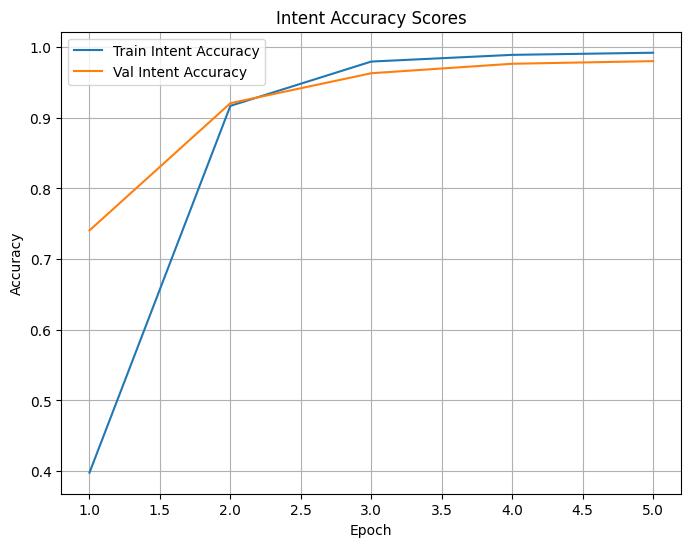

In [ ]:
# Intent Accuracy Plot
epochs = range(1, len(metrics["train_intent_acc"]) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, metrics["train_intent_acc"], label="Train Intent Accuracy")
plt.plot(epochs, metrics["val_intent_acc"], label="Val Intent Accuracy")
plt.title("Intent Accuracy Scores")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAVE_PATH, "intent_acc_plot.png"))
plt.show()
plt.close()

## Confusion Matrix

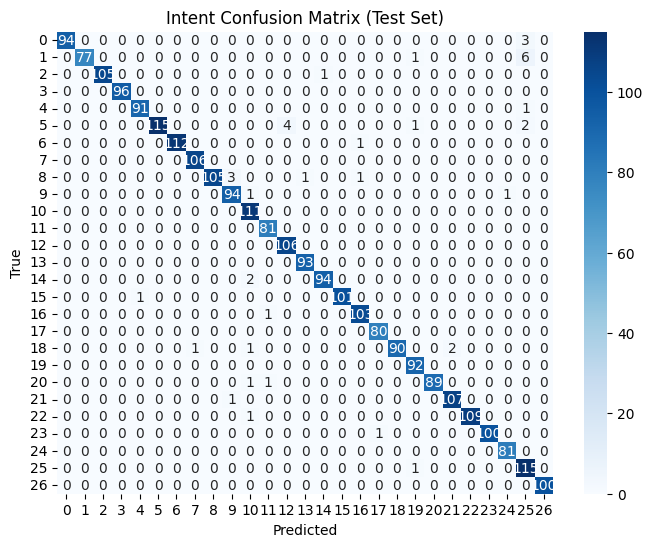

Intent Confusion Matrix saved to /content/drive/MyDrive/gpt2_hybrid_fusion/intent_cm.png


In [ ]:
# Intent Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_results["intent"]["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title("Intent Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
intent_cm_path = os.path.join(SAVE_PATH, "intent_cm.png")
plt.savefig(intent_cm_path)
plt.show()
plt.close()
print(f"Intent Confusion Matrix saved to {intent_cm_path}")


## Category F1 score weighted

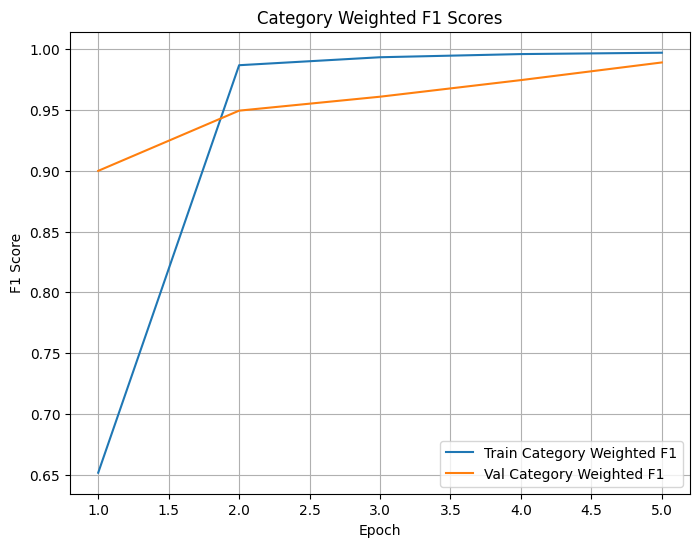

In [ ]:
# Category Weighted F1 Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, metrics["train_category_f1"], label="Train Category Weighted F1")
plt.plot(epochs, metrics["val_category_f1"], label="Val Category Weighted F1")
plt.title("Category Weighted F1 Scores")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAVE_PATH, "category_f1_plot.png"))
plt.show()
plt.close()

## Category Confusion Matrix

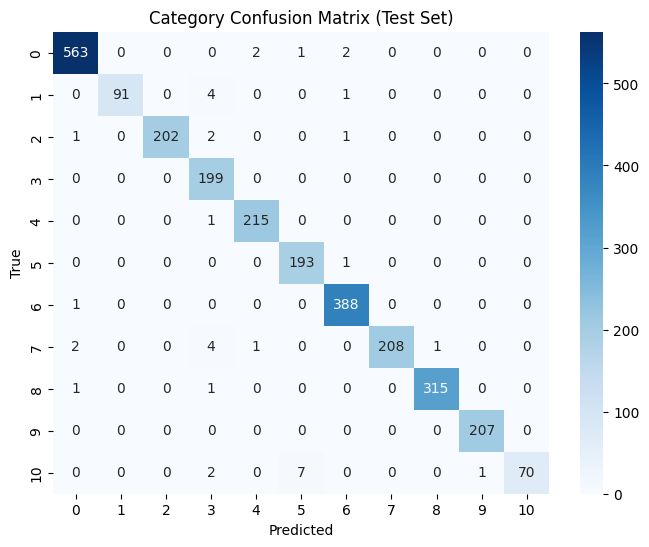

Category Confusion Matrix saved to /content/drive/MyDrive/gpt2_hybrid_fusion/category_cm.png


In [ ]:
# Category Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_results["category"]["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
plt.title("Category Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
category_cm_path = os.path.join(SAVE_PATH, "category_cm.png")
plt.savefig(category_cm_path)
plt.show()
plt.close()
print(f"Category Confusion Matrix saved to {category_cm_path}")

## NER F1 Score

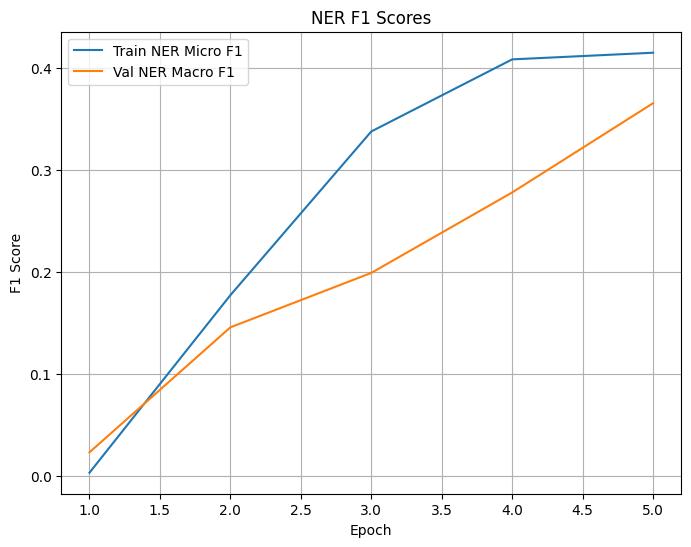

NER plot saved to /content/drive/MyDrive/gpt2_hybrid_fusion


In [ ]:
# NER F1 Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, metrics["train_ner_micro_f1"], label="Train NER Micro F1")
plt.plot(epochs, metrics["val_ner_macro_f1"], label="Val NER Macro F1")
plt.title("NER F1 Scores")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAVE_PATH, "ner_f1_plot.png"))
plt.show()
plt.close()
print(f"NER plot saved to {SAVE_PATH}")